# LunarLander-v3 Project using DQN and PPO

# 1. Libraries

In [2]:
# ====== Libraries  ======
import os
import random
import numpy as np

import gymnasium as gym

# Plots
import matplotlib.pyplot as plt
%matplotlib inline

# DQN 
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.monitor import Monitor


from collections import deque, namedtuple
import random
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

from IPython.display import Image, display


# 2. Create LunarLander-v3 environment

In [2]:
ENV_ID = "LunarLander-v3"
OUT_DIR = "runs_lunarlander"
os.makedirs(OUT_DIR, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)
print("Gymnasium:", gym.__version__)

Device: cpu
Gymnasium: 1.2.3


In [3]:
env = gym.make(ENV_ID)
obs, _ = env.reset(seed=42)
print("Env:", ENV_ID)
print("Obs space:", env.observation_space)
print("Action space:", env.action_space)
print("Obs shape:", obs.shape)
print("Example obs:", obs)
env.close()

Env: LunarLander-v3
Obs space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action space: Discrete(4)
Obs shape: (8,)
Example obs: [ 0.00229702  1.4181306   0.2326471   0.3204666  -0.00265488 -0.05269805
  0.          0.        ]


# 4. CLASSES (ReplayBuffer, Network, DQNAgent)

In [4]:
Transition = namedtuple("Transition", ["s", "a", "r", "s2", "d"])

class ReplayBuffer:
    def __init__(self, capacity, device):
        self.buf = deque(maxlen=capacity)
        self.device = device

    def __len__(self):
        return len(self.buf)

    def add(self, s, a, r, s2, d):
        self.buf.append(Transition(s, a, r, s2, d))

    def sample(self, batch_size):
        batch = random.sample(self.buf, batch_size)
        s  = torch.tensor(np.vstack([t.s  for t in batch]), dtype=torch.float32, device=self.device)
        a  = torch.tensor(np.vstack([t.a  for t in batch]), dtype=torch.int64,   device=self.device)
        r  = torch.tensor(np.vstack([t.r  for t in batch]), dtype=torch.float32, device=self.device)
        s2 = torch.tensor(np.vstack([t.s2 for t in batch]), dtype=torch.float32, device=self.device)
        d  = torch.tensor(np.vstack([t.d  for t in batch]).astype(np.uint8), dtype=torch.float32, device=self.device)
        return s, a, r, s2, d

class Network(nn.Module):
    def __init__(self, state_size, action_size, hidden=256, seed=0):
        super().__init__()
        torch.manual_seed(seed)
        self.net = nn.Sequential(
            nn.Linear(state_size, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, action_size),
        )
    def forward(self, x):
        return self.net(x)

class DQNAgent:
    def __init__(
        self, state_size, action_size,
        lr, gamma, buffer_size, batch_size, tau,
        update_every, learning_starts, grad_clip, seed
    ):
        random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
        self.device = DEVICE
        self.action_size = action_size

        self.q = Network(state_size, action_size, seed=seed).to(self.device)
        self.q_tgt = Network(state_size, action_size, seed=seed+1).to(self.device)
        self.q_tgt.load_state_dict(self.q.state_dict())

        self.opt = optim.Adam(self.q.parameters(), lr=lr)
        self.buf = ReplayBuffer(buffer_size, self.device)

        self.gamma = gamma
        self.batch_size = batch_size
        self.tau = tau
        self.update_every = update_every
        self.learning_starts = learning_starts
        self.grad_clip = grad_clip

        self.total_steps = 0

    def act(self, state, eps):
        if random.random() < eps:
            return random.randrange(self.action_size)
        s = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        with torch.no_grad():
            qvals = self.q(s)
        return int(torch.argmax(qvals, dim=1).item())

    def store(self, s, a, r, s2, done):
        self.buf.add(s, a, r, s2, done)

    def soft_update(self):
        for p_tgt, p in zip(self.q_tgt.parameters(), self.q.parameters()):
            p_tgt.data.mul_(1.0 - self.tau)
            p_tgt.data.add_(self.tau * p.data)

    def train_step(self):
        if len(self.buf) < max(self.batch_size, self.learning_starts):
            return None

        s, a, r, s2, d = self.buf.sample(self.batch_size)

        with torch.no_grad():
            a2 = torch.argmax(self.q(s2), dim=1, keepdim=True)
            q2 = self.q_tgt(s2).gather(1, a2)
            y  = r + self.gamma * q2 * (1.0 - d)

        q_sa = self.q(s).gather(1, a)
        loss = F.smooth_l1_loss(q_sa, y)

        self.opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.q.parameters(), self.grad_clip)
        self.opt.step()

        self.soft_update()
        return float(loss.item())


# 5. UTILITIES (make_env, eval, gif)

In [5]:
def make_env(seed: int, render_mode=None):
    env = gym.make(ENV_ID, render_mode=render_mode)
    env.reset(seed=seed)
    env.action_space.seed(seed)
    return env

@torch.no_grad()
def evaluate_dqn(agent, n_episodes=20, seed=0, max_steps=1000):
    env = make_env(seed + 10_000)
    rets, lens = [], []
    for ep in range(n_episodes):
        s, _ = env.reset(seed=seed + 10_000 + ep)
        ep_ret, ep_len = 0.0, 0
        for _ in range(max_steps):
            a = agent.act(s, eps=0.0)
            s, r, terminated, truncated, _ = env.step(a)
            ep_ret += float(r); ep_len += 1
            if terminated or truncated:
                break
        rets.append(ep_ret); lens.append(ep_len)
    env.close()
    return float(np.mean(rets)), float(np.std(rets, ddof=1)), rets, lens

def moving_avg(x, w=100):
    x = np.asarray(x, float)
    if len(x) < w:
        return np.full_like(x, np.nan)
    c = np.convolve(x, np.ones(w)/w, mode="valid")
    return np.concatenate([np.full(w-1, np.nan), c])

def find_center_seed(agent, base_seed, tries, center_tol, max_steps):
    env = make_env(base_seed)
    for i in range(tries):
        s, _ = env.reset(seed=base_seed + i)
        for _ in range(max_steps):
            a = agent.act(s, eps=0.0)
            s, r, terminated, truncated, _ = env.step(a)
            if terminated or truncated:
                x = float(s[0])
                vx, vy = float(s[2]), float(s[3])
                left, right = float(s[6]), float(s[7])
                landed = (left > 0.5 or right > 0.5) and abs(vx) < 0.35 and abs(vy) < 0.35
                if landed and abs(x) < center_tol:
                    env.close()
                    return base_seed + i
                break
    env.close()
    return None

def save_gif(agent, seed_gif, gif_path, max_steps=1000, fps=30):
    import imageio
    env = make_env(seed_gif, render_mode="rgb_array")
    s, _ = env.reset(seed=seed_gif)
    frames, total_r = [], 0.0
    for _ in range(max_steps):
        frames.append(env.render())
        a = agent.act(s, eps=0.0)
        s, r, terminated, truncated, _ = env.step(a)
        total_r += float(r)
        if terminated or truncated:
            frames.append(env.render())
            break
    env.close()
    imageio.mimsave(gif_path, frames, fps=fps)
    return float(total_r)


# 6. SINGLE TRAIN ENTRYPOINT: run_dqn(cfg, seed)

In [6]:
def run_dqn(cfg: dict, seed: int, run_name: str):
    cfg = dict(cfg)
    # defaults
    cfg.setdefault("gamma", 0.99)
    cfg.setdefault("grad_clip", 10.0)
    cfg.setdefault("eps_start", 1.0)
    cfg.setdefault("total_episodes", 5500)          # ↑ mais margem p/ performance
    cfg.setdefault("max_steps", 1000)
    cfg.setdefault("solved_avg100", 200.0)
    cfg.setdefault("lr_finetune", min(cfg["lr_finetune"], cfg["lr"]))
    cfg.setdefault("eval_episodes", 20)
    cfg.setdefault("extra_after_solved", 500)       # ↑ sobe “ceiling”
    cfg.setdefault("make_gif", False)
    cfg.setdefault("gif_tries", 1200)
    cfg.setdefault("center_tol", 0.12)

    # reproducibility
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

    env = make_env(seed)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = DQNAgent(
        state_size=state_size,
        action_size=action_size,
        lr=cfg["lr"],
        gamma=cfg["gamma"],
        buffer_size=int(cfg["buffer_size"]),
        batch_size=int(cfg["batch_size"]),
        tau=cfg["tau"],
        update_every=int(cfg["update_every"]),
        learning_starts=int(cfg["learning_starts"]),
        grad_clip=cfg["grad_clip"],
        seed=seed,
    )

    scores_100 = deque(maxlen=100)
    eps = cfg["eps_start"]
    solved_at, stop_at = None, None
    finetune_done = False

    ep_returns, ep_lengths, ep_eps, step_losses = [], [], [], []
    grad_updates = 0

    for ep in range(1, cfg["total_episodes"] + 1):
        s, _ = env.reset(seed=seed + ep)
        ep_ret, ep_len = 0.0, 0

        for _ in range(cfg["max_steps"]):
            a = agent.act(s, eps=eps)
            s2, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated

            agent.store(s, a, float(r), s2, done)

            agent.total_steps += 1
            if agent.total_steps % agent.update_every == 0:
                loss = agent.train_step()
                if loss is not None:
                    step_losses.append(loss)
                    grad_updates += 1

            s = s2
            ep_ret += float(r); ep_len += 1
            if done:
                break

        ep_returns.append(ep_ret)
        ep_lengths.append(ep_len)
        ep_eps.append(eps)

        scores_100.append(ep_ret)
        avg100 = float(np.mean(scores_100))

        eps = max(cfg["eps_min"], eps * cfg["eps_decay"])

        if ep % 50 == 0:
            last_loss = float(np.mean(step_losses[-200:])) if len(step_losses) else np.nan
            print(f"{run_name} | Ep {ep:4d} | avg100: {avg100:7.2f} | eps: {eps:6.3f} | loss~: {last_loss:6.3f}")

        if len(scores_100) == 100 and avg100 >= cfg["solved_avg100"] and stop_at is None:
            solved_at = ep
            stop_at = min(cfg["total_episodes"], ep + cfg["extra_after_solved"])
            if not finetune_done:
                for g in agent.opt.param_groups:
                    g["lr"] = cfg["lr_finetune"]
                finetune_done = True
            print(f"\n {run_name} solved at ep {ep} | avg100 {avg100:.2f} | continue until ep {stop_at} | finetune_lr {cfg['lr_finetune']}\n")

        if stop_at is not None and ep >= stop_at:
            break

    env.close()

    mean_eval, std_eval, _, _ = evaluate_dqn(agent, n_episodes=cfg["eval_episodes"], seed=seed, max_steps=cfg["max_steps"])

    model_path = os.path.join(OUT_DIR, f"{run_name}_seed{seed}.pth")
    torch.save(agent.q.state_dict(), model_path)

    curves_path = os.path.join(OUT_DIR, f"{run_name}_seed{seed}_curves.npz")
    np.savez(
        curves_path,
        returns=np.array(ep_returns, float),
        lengths=np.array(ep_lengths, int),
        eps=np.array(ep_eps, float),
        losses=np.array(step_losses, float),
        solved_at_episode=np.array([-1 if solved_at is None else solved_at], int),
        total_steps=np.array([agent.total_steps], int),
        grad_updates=np.array([grad_updates], int),
    )

    res = {
        "seed": seed,
        "cfg": cfg,
        "run_name": run_name,
        "solved_at_episode": solved_at,
        "train_episodes": len(ep_returns),
        "train_total_steps": agent.total_steps,
        "grad_updates": grad_updates,
        "eval_mean": mean_eval,
        "eval_std": std_eval,
        "model_path": model_path,
        "curves_path": curves_path,
    }

    if cfg["make_gif"]:
        good = find_center_seed(agent, base_seed=seed + 1000, tries=cfg["gif_tries"], center_tol=cfg["center_tol"], max_steps=cfg["max_steps"])
        if good is not None:
            gif_path = os.path.join(OUT_DIR, f"{run_name}_seed{seed}_best.gif")
            gif_ret = save_gif(agent, seed_gif=good, gif_path=gif_path, max_steps=cfg["max_steps"], fps=30)
            res["center_gif_path"] = gif_path
            res["center_gif_seed"] = int(good)
            res["center_gif_return"] = float(gif_ret)
            print("Saved GIF:", gif_path, "| return:", round(gif_ret, 2))

    return res


# 7. MONTE CARLO LOOP + select best (triagem)

In [7]:
def sample_dqn_cfg(rng: random.Random):
    lr = rng.choice([2e-4, 1e-4, 8e-5, 5e-5, 3e-5])
    lr_ft_choices = [x for x in [1e-4, 8e-5, 5e-5, 3e-5] if x <= lr]
    return {
        "lr": lr,
        "lr_finetune": rng.choice(lr_ft_choices),
        "tau": rng.choice([2e-3, 1e-3, 5e-4]),
        "batch_size": rng.choice([64, 128, 256]),
        "buffer_size": rng.choice([200_000, 500_000]),
        "learning_starts": 2000,
        "update_every": 4,
        "eps_decay": rng.choice([0.995, 0.997, 0.999]),
        "eps_min": rng.choice([0.01, 0.005]),
        "extra_after_solved": rng.choice([300, 500, 800]),  # ↑ performance ceiling
        "eval_episodes": 20,
        "make_gif": False,
    }


# 8. FINAL EVAL (3 seeds) + plots + gif do melhor

In [8]:
def mc_tune_dqn(n_trials=15, tune_seed=42, train_seed=42):
    rng = random.Random(tune_seed)
    trials, best = [], None

    for t in range(1, n_trials + 1):
        cfg = sample_dqn_cfg(rng)
        run_name = f"dqn_trial{t:02d}"

        print(f"\n=== Trial {t}/{n_trials} | cfg: {cfg} ===")
        res = run_dqn(cfg, seed=train_seed, run_name=run_name)
        trials.append(res)

        if (best is None) or (res["eval_mean"] > best["eval_mean"]):
            best = res

        print(f"Trial {t} -> eval_mean: {res['eval_mean']:.2f} ± {res['eval_std']:.2f} | BEST: {best['eval_mean']:.2f}")

    return trials, best



=== Trial 1/15 | cfg: {'lr': 0.0002, 'lr_finetune': 0.0001, 'tau': 0.0005, 'batch_size': 128, 'buffer_size': 200000, 'learning_starts': 2000, 'update_every': 4, 'eps_decay': 0.995, 'eps_min': 0.01, 'extra_after_solved': 800, 'eval_episodes': 20, 'make_gif': False} ===
dqn_trial01 | Ep   50 | avg100: -188.45 | eps:  0.778 | loss~:  1.571
dqn_trial01 | Ep  100 | avg100: -150.42 | eps:  0.606 | loss~:  1.494
dqn_trial01 | Ep  150 | avg100: -104.53 | eps:  0.471 | loss~:  1.255
dqn_trial01 | Ep  200 | avg100:  -80.27 | eps:  0.367 | loss~:  1.305
dqn_trial01 | Ep  250 | avg100:  -42.14 | eps:  0.286 | loss~:  1.236
dqn_trial01 | Ep  300 | avg100:  -32.74 | eps:  0.222 | loss~:  0.947
dqn_trial01 | Ep  350 | avg100:  -51.33 | eps:  0.173 | loss~:  0.735
dqn_trial01 | Ep  400 | avg100:  -38.43 | eps:  0.135 | loss~:  0.608
dqn_trial01 | Ep  450 | avg100:   32.48 | eps:  0.105 | loss~:  0.424
dqn_trial01 | Ep  500 | avg100:  118.98 | eps:  0.082 | loss~:  0.295
dqn_trial01 | Ep  550 | avg100

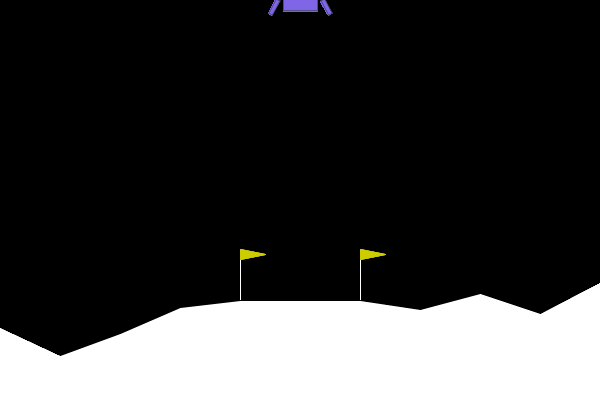

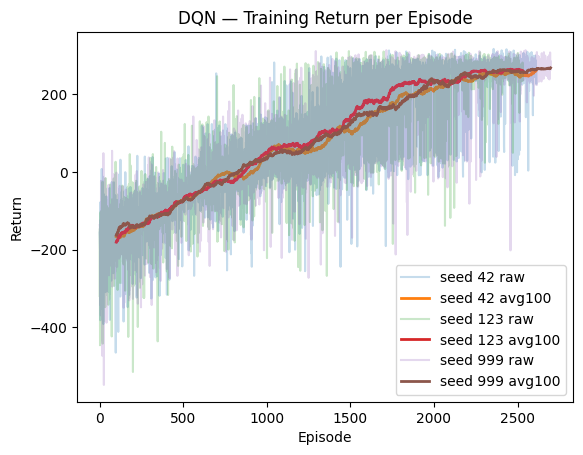

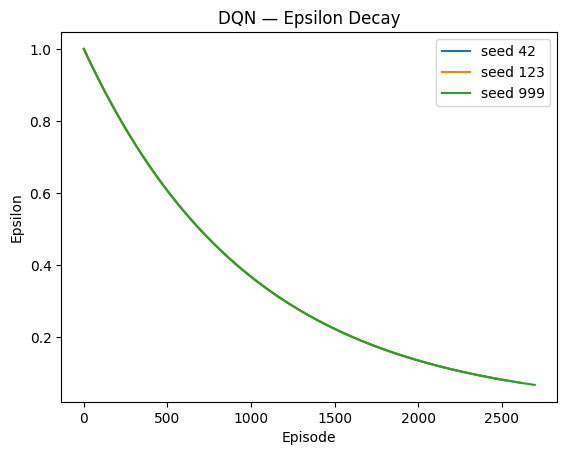

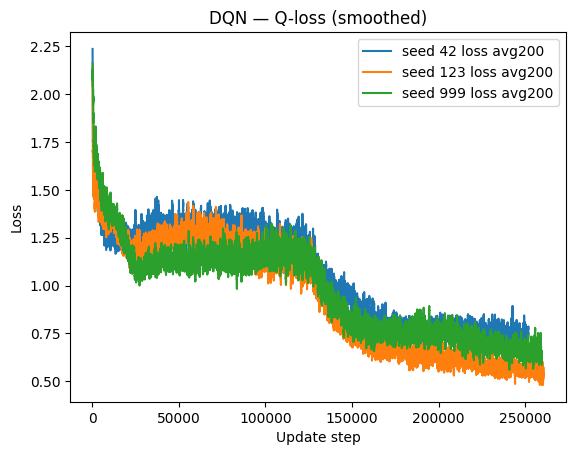

In [9]:
# 1) Tune
dqn_trials, best_dqn = mc_tune_dqn(n_trials=15, tune_seed=42, train_seed=42)
print("\nBEST CFG:", best_dqn["cfg"])

# 2) Final 3 seeds (fair comparison)
FINAL_SEEDS = [42, 123, 999]
final_cfg = dict(best_dqn["cfg"])
final_cfg["eval_episodes"] = 20
final_cfg["make_gif"] = False  # gifs só no melhor final

dqn_final = []
for s in FINAL_SEEDS:
    print("\n=== FINAL seed", s, "===")
    dqn_final.append(run_dqn(final_cfg, seed=s, run_name="dqn_final"))

means = [r["eval_mean"] for r in dqn_final]
print("\nFINAL mean across seeds:", float(np.mean(means)), "| std:", float(np.std(means, ddof=1)))

# 3) Pick best FINAL seed and generate GIF (1 run extra, só para gif)
best_seed = max(dqn_final, key=lambda x: x["eval_mean"])
gif_cfg = dict(final_cfg)
gif_cfg["make_gif"] = True
gif_run = run_dqn(gif_cfg, seed=best_seed["seed"], run_name="dqn_best_gif")

from IPython.display import Image, display
display(Image(filename=gif_run["center_gif_path"]))

# 4) Plots: returns + avg100, epsilon, loss (por seed)
def load_curves(path):
    d = np.load(path, allow_pickle=True)
    return {k: d[k] for k in d.files}

plt.figure()
for r in dqn_final:
    c = load_curves(r["curves_path"])
    y = c["returns"]
    plt.plot(y, alpha=0.25, label=f"seed {r['seed']} raw")
    plt.plot(moving_avg(y, 100), linewidth=2, label=f"seed {r['seed']} avg100")
plt.title("DQN — Training Return per Episode")
plt.xlabel("Episode"); plt.ylabel("Return"); plt.legend(); plt.show()

plt.figure()
for r in dqn_final:
    c = load_curves(r["curves_path"])
    plt.plot(c["eps"], label=f"seed {r['seed']}")
plt.title("DQN — Epsilon Decay")
plt.xlabel("Episode"); plt.ylabel("Epsilon"); plt.legend(); plt.show()

plt.figure()
for r in dqn_final:
    c = load_curves(r["curves_path"])
    if len(c["losses"]) > 0:
        plt.plot(moving_avg(c["losses"], 200), label=f"seed {r['seed']} loss avg200")
plt.title("DQN — Q-loss (smoothed)")
plt.xlabel("Update step"); plt.ylabel("Loss"); plt.legend(); plt.show()



# 9. SB3 DQN

In [3]:
def set_global_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

# Experiment settings
ENV_ID = "LunarLander-v3"
SEEDS = [42, 123, 999]              # >= 3 seeds
EVAL_EPISODES = 20                  # deterministic evaluation
TOTAL_TIMESTEPS = 1_000_000         # <<< ajusta conforme o teu budget
LOG_DIR = "runs_sb3_dqn"
MODEL_DIR = "models_sb3_dqn"
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

## 9.1 Env factory (treino e avaliação)

In [4]:
def make_env(seed: int, render_mode=None):
    env = gym.make(ENV_ID, render_mode=render_mode)
    env = Monitor(env)  # logs: episode reward, length, etc.
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    return env

def make_train_env(seed: int):
    # SB3 geralmente usa VecEnv; aqui mantemos simples com 1 env
    env = DummyVecEnv([lambda: make_env(seed)])
    env = VecMonitor(env)
    return env

def make_eval_env(seed: int):
    # sem VecEnv: evaluate_policy aceita env normal
    return make_env(seed)

## 9.2 Callback para logar epsilon + contar gradient updates

In [5]:
class DQNTelemetryCallback(BaseCallback):
    """
    Logs:
      - exploration_rate (epsilon)
      - number of gradient updates (n_updates)
    """
    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_step(self) -> bool:
        # epsilon do DQN em SB3
        if hasattr(self.model, "exploration_rate"):
            self.logger.record("rollout/exploration_rate", float(self.model.exploration_rate))

        # contador interno de updates (OffPolicyAlgorithm)
        if hasattr(self.model, "_n_updates"):
            self.logger.record("train/n_updates", int(self.model._n_updates))

        return True

## 9.3 Config do SB3 DQN (baseline + “best cfg” aproximada)

In [6]:
def build_dqn(env, cfg: dict, seed: int, tb_log_name: str):
    # policy_kwargs: controla arquitetura MLP (equivalente ao teu "Neural Network Architecture")
    policy_kwargs = dict(net_arch=[256, 256])  
    model = DQN(
        policy="MlpPolicy",
        env=env,
        learning_rate=cfg["learning_rate"],
        buffer_size=cfg["buffer_size"],
        learning_starts=cfg["learning_starts"],
        batch_size=cfg["batch_size"],
        tau=cfg["tau"],
        gamma=cfg["gamma"],
        train_freq=cfg["train_freq"],
        gradient_steps=cfg["gradient_steps"],
        target_update_interval=cfg["target_update_interval"],
        exploration_initial_eps=cfg["exploration_initial_eps"],
        exploration_final_eps=cfg["exploration_final_eps"],
        exploration_fraction=cfg["exploration_fraction"],
        max_grad_norm=cfg["max_grad_norm"],
        policy_kwargs=policy_kwargs,
        verbose=1,
        tensorboard_log=LOG_DIR,
        seed=seed
    )
    return model

# "Best cfg" aproximada do teu custom (com schedule linear)
DQN_CFG = dict(
    learning_rate=2e-4,
    gamma=0.99,
    buffer_size=500_000,
    learning_starts=1_000,
    batch_size=256,
    tau=0.001,
    train_freq=2,              # aproxima o teu update_every=2
    gradient_steps=1,
    target_update_interval=10_000,  # podes ajustar (hard update); com tau baixo, isto pesa menos
    exploration_initial_eps=1.0,
    exploration_final_eps=0.005,
    exploration_fraction=0.8,   # % do treino em que epsilon desce até final_eps
    max_grad_norm=10.0
)

## 9.4 Treinar as 3 seeds e reportar mean±std 

In [7]:
def train_one_seed(seed: int):
    set_global_seed(seed)

    train_env = make_train_env(seed)

    # Eval env para callback (tracking durante o treino)
    eval_env_cb = make_eval_env(seed + 10_000)

    # Eval env para avaliação final (podes usar outra seed para ser “limpo”)
    eval_env_final = make_eval_env(seed + 20_000)

    # Evita disparar mesmo no fim (ex.: 1_000_000 % 50_000 == 0, pode avaliar em 1_000_000)
    # Escolhe um número que NÃO divide TOTAL_TIMESTEPS certinho.
    eval_freq = 60_000  # exemplo bom para 1_000_000

    eval_callback = EvalCallback(
        eval_env_cb,
        best_model_save_path=os.path.join(MODEL_DIR, f"seed{seed}_best"),
        log_path=os.path.join(LOG_DIR, f"seed{seed}_eval"),
        eval_freq=eval_freq,
        n_eval_episodes=5,          # OK: só tracking durante treino
        deterministic=True,
        render=False
    )

    telemetry = DQNTelemetryCallback()

    model = build_dqn(train_env, DQN_CFG, seed=seed, tb_log_name=f"dqn_seed{seed}")

    model.learn(
        total_timesteps=TOTAL_TIMESTEPS,
        callback=[telemetry, eval_callback],
        log_interval=10,
        progress_bar=True
    )

    # Avaliação FINAL obrigatória: 20 episódios determinísticos por seed
    # (isto é o requisito do enunciado)
    mean_r, std_r = evaluate_policy(
        model,
        eval_env_final,
        n_eval_episodes=EVAL_EPISODES,  # EVAL_EPISODES = 20
        deterministic=True,
        render=False
    )

    n_updates = int(getattr(model, "_n_updates", -1))

    model_path = os.path.join(MODEL_DIR, f"dqn_final_seed{seed}.zip")
    model.save(model_path)

    train_env.close()
    eval_env_cb.close()
    eval_env_final.close()

    return dict(
        seed=seed,
        eval_mean=float(mean_r),
        eval_std=float(std_r),
        n_updates=n_updates,
        model_path=model_path
    )

In [ ]:
results = []

for s in SEEDS:
    print(f"\n=== Training seed {s} ===")
    r = train_one_seed(s)
    results.append(r)
    print("DONE:", r)

# Aggregate final metrics
eval_means = np.array([r["eval_mean"] for r in results], dtype=float)

final_mean = float(eval_means.mean())
final_std  = float(eval_means.std(ddof=1))  # sample std

print("\n=== FINAL (SB3 DQN) across seeds ===")
print("mean =", final_mean)
print("std  =", final_std)
print("n_updates per seed =", [r["n_updates"] for r in results])
print("model paths =", [r["model_path"] for r in results])


=== Training seed 42 ===
Using cpu device


c:\Users\ricar\dev\iscte\taap_p2\lib\site-packages\stable_baselines3\common\vec_env\vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


Logging to runs_sb3_dqn\DQN_8


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.7     |
|    ep_rew_mean      | -222     |
|    exploration_rate | 0.999    |
| time/               |          |
|    episodes         | 10       |
|    fps              | 11017    |
|    time_elapsed     | 0        |
|    total_timesteps  | 937      |
| train/              |          |
|    n_updates        | 0        |
----------------------------------


c:\Users\ricar\dev\iscte\taap_p2\lib\site-packages\stable_baselines3\common\callbacks.py:418: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_monitor.VecMonitor object at 0x00000192698C3A60> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x0000019269A51C60>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 95.8     |
|    ep_rew_mean      | -230     |
|    exploration_rate | 0.998    |
| time/               |          |
|    episodes         | 20       |
|    fps              | 2320     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1916     |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.49     |
|    n_updates        | 457      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.4     |
|    ep_rew_mean      | -188     |
|    exploration_rate | 0.997    |
| time/               |          |
|    episodes         | 30       |
|    fps              | 1792     |
|    time_elapsed     | 1        |
|    total_timesteps  | 2772     |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.89     |
|    n_updates        | 885      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.2     |
|    ep_rew_mean      | -185     |
|    exploration_rate | 0.996    |
| time/               |          |
|    episodes         | 40       |
|    fps              | 1594     |
|    time_elapsed     | 2        |
|    total_timesteps  | 3610     |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 3.13     |
|    n_updates        | 1304     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.1     |
|    ep_rew_mean      | -179     |
|    exploration_rate | 0.994    |
| time/               |          |
|    episodes         | 50       |
|    fps              | 1493     |
|    time_elapsed     | 3        |
|    total_timesteps  | 4554     |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.716    |
|    n_updates        | 1776     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92       |
|    ep_rew_mean      | -166     |
|    exploration_rate | 0.993    |
| time/               |          |
|    episodes         | 60       |
|    fps              | 1445     |
|    time_elapsed     | 3        |
|    total_timesteps  | 5520     |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.44     |
|    n_updates        | 2259     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.7     |
|    ep_rew_mean      | -166     |
|    exploration_rate | 0.992    |
| time/               |          |
|    episodes         | 70       |
|    fps              | 1413     |
|    time_elapsed     | 4        |
|    total_timesteps  | 6488     |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.51     |
|    n_updates        | 2743     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.3     |
|    ep_rew_mean      | -165     |
|    exploration_rate | 0.991    |
| time/               |          |
|    episodes         | 80       |
|    fps              | 1398     |
|    time_elapsed     | 5        |
|    total_timesteps  | 7463     |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.801    |
|    n_updates        | 3231     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.6     |
|    ep_rew_mean      | -170     |
|    exploration_rate | 0.99     |
| time/               |          |
|    episodes         | 90       |
|    fps              | 1383     |
|    time_elapsed     | 6        |
|    total_timesteps  | 8423     |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.975    |
|    n_updates        | 3711     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.9     |
|    ep_rew_mean      | -171     |
|    exploration_rate | 0.988    |
| time/               |          |
|    episodes         | 100      |
|    fps              | 1374     |
|    time_elapsed     | 6        |
|    total_timesteps  | 9289     |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.67     |
|    n_updates        | 4144     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.9     |
|    ep_rew_mean      | -165     |
|    exploration_rate | 0.987    |
| time/               |          |
|    episodes         | 110      |
|    fps              | 1364     |
|    time_elapsed     | 7        |
|    total_timesteps  | 10128    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.68     |
|    n_updates        | 4563     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.4     |
|    ep_rew_mean      | -158     |
|    exploration_rate | 0.986    |
| time/               |          |
|    episodes         | 120      |
|    fps              | 1354     |
|    time_elapsed     | 8        |
|    total_timesteps  | 11058    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.52     |
|    n_updates        | 5028     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.3     |
|    ep_rew_mean      | -167     |
|    exploration_rate | 0.985    |
| time/               |          |
|    episodes         | 130      |
|    fps              | 1350     |
|    time_elapsed     | 8        |
|    total_timesteps  | 12007    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.75     |
|    n_updates        | 5503     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.5     |
|    ep_rew_mean      | -169     |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes         | 140      |
|    fps              | 1346     |
|    time_elapsed     | 9        |
|    total_timesteps  | 12962    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.05     |
|    n_updates        | 5980     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.6     |
|    ep_rew_mean      | -171     |
|    exploration_rate | 0.983    |
| time/               |          |
|    episodes         | 150      |
|    fps              | 1339     |
|    time_elapsed     | 10       |
|    total_timesteps  | 13911    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.91     |
|    n_updates        | 6455     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.5     |
|    ep_rew_mean      | -176     |
|    exploration_rate | 0.982    |
| time/               |          |
|    episodes         | 160      |
|    fps              | 1334     |
|    time_elapsed     | 11       |
|    total_timesteps  | 14769    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.66     |
|    n_updates        | 6884     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.3     |
|    ep_rew_mean      | -180     |
|    exploration_rate | 0.98     |
| time/               |          |
|    episodes         | 170      |
|    fps              | 1331     |
|    time_elapsed     | 11       |
|    total_timesteps  | 15720    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.51     |
|    n_updates        | 7359     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.6     |
|    ep_rew_mean      | -187     |
|    exploration_rate | 0.979    |
| time/               |          |
|    episodes         | 180      |
|    fps              | 1327     |
|    time_elapsed     | 12       |
|    total_timesteps  | 16619    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.96     |
|    n_updates        | 7809     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.8     |
|    ep_rew_mean      | -181     |
|    exploration_rate | 0.978    |
| time/               |          |
|    episodes         | 190      |
|    fps              | 1326     |
|    time_elapsed     | 13       |
|    total_timesteps  | 17607    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.719    |
|    n_updates        | 8303     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93       |
|    ep_rew_mean      | -182     |
|    exploration_rate | 0.977    |
| time/               |          |
|    episodes         | 200      |
|    fps              | 1324     |
|    time_elapsed     | 14       |
|    total_timesteps  | 18590    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.49     |
|    n_updates        | 8794     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.2     |
|    ep_rew_mean      | -187     |
|    exploration_rate | 0.976    |
| time/               |          |
|    episodes         | 210      |
|    fps              | 1323     |
|    time_elapsed     | 14       |
|    total_timesteps  | 19453    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.22     |
|    n_updates        | 9226     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 94.1     |
|    ep_rew_mean      | -189     |
|    exploration_rate | 0.975    |
| time/               |          |
|    episodes         | 220      |
|    fps              | 1324     |
|    time_elapsed     | 15       |
|    total_timesteps  | 20467    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.67     |
|    n_updates        | 9733     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 94.1     |
|    ep_rew_mean      | -182     |
|    exploration_rate | 0.973    |
| time/               |          |
|    episodes         | 230      |
|    fps              | 1323     |
|    time_elapsed     | 16       |
|    total_timesteps  | 21419    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.4      |
|    n_updates        | 10209    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 94.5     |
|    ep_rew_mean      | -178     |
|    exploration_rate | 0.972    |
| time/               |          |
|    episodes         | 240      |
|    fps              | 1321     |
|    time_elapsed     | 16       |
|    total_timesteps  | 22408    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.36     |
|    n_updates        | 10703    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 94.5     |
|    ep_rew_mean      | -178     |
|    exploration_rate | 0.971    |
| time/               |          |
|    episodes         | 250      |
|    fps              | 1320     |
|    time_elapsed     | 17       |
|    total_timesteps  | 23359    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.97     |
|    n_updates        | 11179    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 95.3     |
|    ep_rew_mean      | -181     |
|    exploration_rate | 0.97     |
| time/               |          |
|    episodes         | 260      |
|    fps              | 1320     |
|    time_elapsed     | 18       |
|    total_timesteps  | 24295    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.08     |
|    n_updates        | 11647    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 94.4     |
|    ep_rew_mean      | -178     |
|    exploration_rate | 0.969    |
| time/               |          |
|    episodes         | 270      |
|    fps              | 1319     |
|    time_elapsed     | 19       |
|    total_timesteps  | 25162    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.77     |
|    n_updates        | 12080    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 94.5     |
|    ep_rew_mean      | -167     |
|    exploration_rate | 0.968    |
| time/               |          |
|    episodes         | 280      |
|    fps              | 1317     |
|    time_elapsed     | 19       |
|    total_timesteps  | 26067    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.608    |
|    n_updates        | 12533    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.7     |
|    ep_rew_mean      | -170     |
|    exploration_rate | 0.966    |
| time/               |          |
|    episodes         | 290      |
|    fps              | 1317     |
|    time_elapsed     | 20       |
|    total_timesteps  | 26977    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2        |
|    n_updates        | 12988    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.5     |
|    ep_rew_mean      | -170     |
|    exploration_rate | 0.965    |
| time/               |          |
|    episodes         | 300      |
|    fps              | 1316     |
|    time_elapsed     | 21       |
|    total_timesteps  | 27841    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.03     |
|    n_updates        | 13420    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.5     |
|    ep_rew_mean      | -165     |
|    exploration_rate | 0.964    |
| time/               |          |
|    episodes         | 310      |
|    fps              | 1315     |
|    time_elapsed     | 21       |
|    total_timesteps  | 28808    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.917    |
|    n_updates        | 13903    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.8     |
|    ep_rew_mean      | -159     |
|    exploration_rate | 0.963    |
| time/               |          |
|    episodes         | 320      |
|    fps              | 1311     |
|    time_elapsed     | 22       |
|    total_timesteps  | 29847    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.611    |
|    n_updates        | 14423    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.9     |
|    ep_rew_mean      | -164     |
|    exploration_rate | 0.961    |
| time/               |          |
|    episodes         | 340      |
|    fps              | 1306     |
|    time_elapsed     | 24       |
|    total_timesteps  | 31698    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.52     |
|    n_updates        | 15348    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.5     |
|    ep_rew_mean      | -164     |
|    exploration_rate | 0.96     |
| time/               |          |
|    episodes         | 350      |
|    fps              | 1306     |
|    time_elapsed     | 24       |
|    total_timesteps  | 32507    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.507    |
|    n_updates        | 15753    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.9     |
|    ep_rew_mean      | -159     |
|    exploration_rate | 0.958    |
| time/               |          |
|    episodes         | 360      |
|    fps              | 1305     |
|    time_elapsed     | 25       |
|    total_timesteps  | 33486    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.15     |
|    n_updates        | 16242    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.3     |
|    ep_rew_mean      | -166     |
|    exploration_rate | 0.957    |
| time/               |          |
|    episodes         | 370      |
|    fps              | 1304     |
|    time_elapsed     | 26       |
|    total_timesteps  | 34496    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.64     |
|    n_updates        | 16747    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.9     |
|    ep_rew_mean      | -172     |
|    exploration_rate | 0.956    |
| time/               |          |
|    episodes         | 380      |
|    fps              | 1304     |
|    time_elapsed     | 27       |
|    total_timesteps  | 35453    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.06     |
|    n_updates        | 17226    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 94.6     |
|    ep_rew_mean      | -173     |
|    exploration_rate | 0.955    |
| time/               |          |
|    episodes         | 390      |
|    fps              | 1304     |
|    time_elapsed     | 27       |
|    total_timesteps  | 36437    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.61     |
|    n_updates        | 17718    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 95.8     |
|    ep_rew_mean      | -170     |
|    exploration_rate | 0.953    |
| time/               |          |
|    episodes         | 400      |
|    fps              | 1304     |
|    time_elapsed     | 28       |
|    total_timesteps  | 37420    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.13     |
|    n_updates        | 18209    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 94.9     |
|    ep_rew_mean      | -172     |
|    exploration_rate | 0.952    |
| time/               |          |
|    episodes         | 410      |
|    fps              | 1304     |
|    time_elapsed     | 29       |
|    total_timesteps  | 38298    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.28     |
|    n_updates        | 18648    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.8     |
|    ep_rew_mean      | -170     |
|    exploration_rate | 0.951    |
| time/               |          |
|    episodes         | 420      |
|    fps              | 1303     |
|    time_elapsed     | 30       |
|    total_timesteps  | 39122    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.72     |
|    n_updates        | 19060    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.5     |
|    ep_rew_mean      | -175     |
|    exploration_rate | 0.95     |
| time/               |          |
|    episodes         | 430      |
|    fps              | 1302     |
|    time_elapsed     | 30       |
|    total_timesteps  | 40041    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.23     |
|    n_updates        | 19520    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.3     |
|    ep_rew_mean      | -179     |
|    exploration_rate | 0.949    |
| time/               |          |
|    episodes         | 440      |
|    fps              | 1302     |
|    time_elapsed     | 31       |
|    total_timesteps  | 40927    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.802    |
|    n_updates        | 19963    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 94.1     |
|    ep_rew_mean      | -176     |
|    exploration_rate | 0.948    |
| time/               |          |
|    episodes         | 450      |
|    fps              | 1302     |
|    time_elapsed     | 32       |
|    total_timesteps  | 41913    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.16     |
|    n_updates        | 20456    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.9     |
|    ep_rew_mean      | -183     |
|    exploration_rate | 0.947    |
| time/               |          |
|    episodes         | 460      |
|    fps              | 1301     |
|    time_elapsed     | 32       |
|    total_timesteps  | 42874    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.94     |
|    n_updates        | 20936    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.3     |
|    ep_rew_mean      | -174     |
|    exploration_rate | 0.946    |
| time/               |          |
|    episodes         | 470      |
|    fps              | 1301     |
|    time_elapsed     | 33       |
|    total_timesteps  | 43723    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.45     |
|    n_updates        | 21361    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.1     |
|    ep_rew_mean      | -170     |
|    exploration_rate | 0.944    |
| time/               |          |
|    episodes         | 480      |
|    fps              | 1300     |
|    time_elapsed     | 34       |
|    total_timesteps  | 44760    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.31     |
|    n_updates        | 21879    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.4     |
|    ep_rew_mean      | -173     |
|    exploration_rate | 0.943    |
| time/               |          |
|    episodes         | 490      |
|    fps              | 1301     |
|    time_elapsed     | 35       |
|    total_timesteps  | 45677    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.4      |
|    n_updates        | 22338    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.8     |
|    ep_rew_mean      | -170     |
|    exploration_rate | 0.942    |
| time/               |          |
|    episodes         | 500      |
|    fps              | 1301     |
|    time_elapsed     | 35       |
|    total_timesteps  | 46805    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.76     |
|    n_updates        | 22902    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 96.4     |
|    ep_rew_mean      | -171     |
|    exploration_rate | 0.94     |
| time/               |          |
|    episodes         | 510      |
|    fps              | 1300     |
|    time_elapsed     | 36       |
|    total_timesteps  | 47934    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.28     |
|    n_updates        | 23466    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 97.4     |
|    ep_rew_mean      | -178     |
|    exploration_rate | 0.939    |
| time/               |          |
|    episodes         | 520      |
|    fps              | 1300     |
|    time_elapsed     | 37       |
|    total_timesteps  | 48859    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.09     |
|    n_updates        | 23929    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.3     |
|    ep_rew_mean      | -179     |
|    exploration_rate | 0.938    |
| time/               |          |
|    episodes         | 530      |
|    fps              | 1300     |
|    time_elapsed     | 38       |
|    total_timesteps  | 49872    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.77     |
|    n_updates        | 24435    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99       |
|    ep_rew_mean      | -172     |
|    exploration_rate | 0.937    |
| time/               |          |
|    episodes         | 540      |
|    fps              | 1300     |
|    time_elapsed     | 39       |
|    total_timesteps  | 50823    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.13     |
|    n_updates        | 24911    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.2     |
|    ep_rew_mean      | -172     |
|    exploration_rate | 0.936    |
| time/               |          |
|    episodes         | 550      |
|    fps              | 1299     |
|    time_elapsed     | 39       |
|    total_timesteps  | 51733    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.74     |
|    n_updates        | 25366    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 97.8     |
|    ep_rew_mean      | -171     |
|    exploration_rate | 0.935    |
| time/               |          |
|    episodes         | 560      |
|    fps              | 1299     |
|    time_elapsed     | 40       |
|    total_timesteps  | 52656    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.76     |
|    n_updates        | 25827    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.9     |
|    ep_rew_mean      | -174     |
|    exploration_rate | 0.933    |
| time/               |          |
|    episodes         | 570      |
|    fps              | 1298     |
|    time_elapsed     | 41       |
|    total_timesteps  | 53616    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.57     |
|    n_updates        | 26307    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 97.1     |
|    ep_rew_mean      | -173     |
|    exploration_rate | 0.932    |
| time/               |          |
|    episodes         | 580      |
|    fps              | 1298     |
|    time_elapsed     | 41       |
|    total_timesteps  | 54473    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.31     |
|    n_updates        | 26736    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 97.6     |
|    ep_rew_mean      | -166     |
|    exploration_rate | 0.931    |
| time/               |          |
|    episodes         | 590      |
|    fps              | 1298     |
|    time_elapsed     | 42       |
|    total_timesteps  | 55436    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.49     |
|    n_updates        | 27217    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 96.6     |
|    ep_rew_mean      | -171     |
|    exploration_rate | 0.93     |
| time/               |          |
|    episodes         | 600      |
|    fps              | 1298     |
|    time_elapsed     | 43       |
|    total_timesteps  | 56469    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.31     |
|    n_updates        | 27734    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 95.6     |
|    ep_rew_mean      | -168     |
|    exploration_rate | 0.928    |
| time/               |          |
|    episodes         | 610      |
|    fps              | 1298     |
|    time_elapsed     | 44       |
|    total_timesteps  | 57494    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.53     |
|    n_updates        | 28246    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 96.5     |
|    ep_rew_mean      | -163     |
|    exploration_rate | 0.927    |
| time/               |          |
|    episodes         | 620      |
|    fps              | 1298     |
|    time_elapsed     | 45       |
|    total_timesteps  | 58514    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.94     |
|    n_updates        | 28756    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 95.5     |
|    ep_rew_mean      | -158     |
|    exploration_rate | 0.926    |
| time/               |          |
|    episodes         | 630      |
|    fps              | 1298     |
|    time_elapsed     | 45       |
|    total_timesteps  | 59421    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.14     |
|    n_updates        | 29210    |
----------------------------------


Eval num_timesteps=60000, episode_reward=-227.84 +/- 127.07

Episode length: 463.20 +/- 307.74

----------------------------------
| eval/               |          |
|    mean_ep_length   | 463      |
|    mean_reward      | -228     |
| rollout/            |          |
|    exploration_rate | 0.925    |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.74     |
|    n_updates        | 29499    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 96.5     |
|    ep_rew_mean      | -159     |
|    exploration_rate | 0.925    |
| time/               |          |
|    episodes         | 640      |
|    fps              | 1288     |
|    time_elapsed     | 46       |
|    total_timesteps  | 60472    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.847    |
|    n_updates        | 29735    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.5     |
|    ep_rew_mean      | -156     |
|    exploration_rate | 0.923    |
| time/               |          |
|    episodes         | 650      |
|    fps              | 1288     |
|    time_elapsed     | 47       |
|    total_timesteps  | 61587    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.881    |
|    n_updates        | 30293    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99.1     |
|    ep_rew_mean      | -157     |
|    exploration_rate | 0.922    |
| time/               |          |
|    episodes         | 660      |
|    fps              | 1288     |
|    time_elapsed     | 48       |
|    total_timesteps  | 62565    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.98     |
|    n_updates        | 30782    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99.4     |
|    ep_rew_mean      | -160     |
|    exploration_rate | 0.921    |
| time/               |          |
|    episodes         | 670      |
|    fps              | 1288     |
|    time_elapsed     | 49       |
|    total_timesteps  | 63555    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.447    |
|    n_updates        | 31277    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -167     |
|    exploration_rate | 0.92     |
| time/               |          |
|    episodes         | 680      |
|    fps              | 1288     |
|    time_elapsed     | 50       |
|    total_timesteps  | 64593    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.09     |
|    n_updates        | 31796    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -169     |
|    exploration_rate | 0.918    |
| time/               |          |
|    episodes         | 690      |
|    fps              | 1288     |
|    time_elapsed     | 50       |
|    total_timesteps  | 65548    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.1      |
|    n_updates        | 32273    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -163     |
|    exploration_rate | 0.917    |
| time/               |          |
|    episodes         | 700      |
|    fps              | 1288     |
|    time_elapsed     | 51       |
|    total_timesteps  | 66541    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.38     |
|    n_updates        | 32770    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99.1     |
|    ep_rew_mean      | -163     |
|    exploration_rate | 0.916    |
| time/               |          |
|    episodes         | 710      |
|    fps              | 1288     |
|    time_elapsed     | 52       |
|    total_timesteps  | 67406    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.05     |
|    n_updates        | 33202    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.7     |
|    ep_rew_mean      | -167     |
|    exploration_rate | 0.915    |
| time/               |          |
|    episodes         | 720      |
|    fps              | 1287     |
|    time_elapsed     | 53       |
|    total_timesteps  | 68381    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.77     |
|    n_updates        | 33690    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.8     |
|    ep_rew_mean      | -168     |
|    exploration_rate | 0.914    |
| time/               |          |
|    episodes         | 730      |
|    fps              | 1287     |
|    time_elapsed     | 53       |
|    total_timesteps  | 69305    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.13     |
|    n_updates        | 34152    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.7     |
|    ep_rew_mean      | -170     |
|    exploration_rate | 0.913    |
| time/               |          |
|    episodes         | 740      |
|    fps              | 1287     |
|    time_elapsed     | 54       |
|    total_timesteps  | 70342    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.53     |
|    n_updates        | 34670    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 97.5     |
|    ep_rew_mean      | -165     |
|    exploration_rate | 0.911    |
| time/               |          |
|    episodes         | 750      |
|    fps              | 1287     |
|    time_elapsed     | 55       |
|    total_timesteps  | 71340    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.7      |
|    n_updates        | 35169    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.6     |
|    ep_rew_mean      | -160     |
|    exploration_rate | 0.91     |
| time/               |          |
|    episodes         | 760      |
|    fps              | 1287     |
|    time_elapsed     | 56       |
|    total_timesteps  | 72422    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.808    |
|    n_updates        | 35710    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.3     |
|    ep_rew_mean      | -156     |
|    exploration_rate | 0.909    |
| time/               |          |
|    episodes         | 770      |
|    fps              | 1287     |
|    time_elapsed     | 57       |
|    total_timesteps  | 73388    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.57     |
|    n_updates        | 36193    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.3     |
|    ep_rew_mean      | -148     |
|    exploration_rate | 0.907    |
| time/               |          |
|    episodes         | 780      |
|    fps              | 1287     |
|    time_elapsed     | 57       |
|    total_timesteps  | 74427    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.08     |
|    n_updates        | 36713    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 97.8     |
|    ep_rew_mean      | -143     |
|    exploration_rate | 0.906    |
| time/               |          |
|    episodes         | 790      |
|    fps              | 1286     |
|    time_elapsed     | 58       |
|    total_timesteps  | 75326    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.985    |
|    n_updates        | 37162    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 97.1     |
|    ep_rew_mean      | -150     |
|    exploration_rate | 0.905    |
| time/               |          |
|    episodes         | 800      |
|    fps              | 1286     |
|    time_elapsed     | 59       |
|    total_timesteps  | 76251    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.34     |
|    n_updates        | 37625    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99.3     |
|    ep_rew_mean      | -151     |
|    exploration_rate | 0.904    |
| time/               |          |
|    episodes         | 810      |
|    fps              | 1285     |
|    time_elapsed     | 60       |
|    total_timesteps  | 77336    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.746    |
|    n_updates        | 38167    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -154     |
|    exploration_rate | 0.902    |
| time/               |          |
|    episodes         | 820      |
|    fps              | 1285     |
|    time_elapsed     | 61       |
|    total_timesteps  | 78463    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.823    |
|    n_updates        | 38731    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | -154     |
|    exploration_rate | 0.901    |
| time/               |          |
|    episodes         | 830      |
|    fps              | 1285     |
|    time_elapsed     | 61       |
|    total_timesteps  | 79572    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.3      |
|    n_updates        | 39285    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | -151     |
|    exploration_rate | 0.9      |
| time/               |          |
|    episodes         | 840      |
|    fps              | 1285     |
|    time_elapsed     | 62       |
|    total_timesteps  | 80690    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.03     |
|    n_updates        | 39844    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | -160     |
|    exploration_rate | 0.898    |
| time/               |          |
|    episodes         | 850      |
|    fps              | 1285     |
|    time_elapsed     | 63       |
|    total_timesteps  | 81680    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.896    |
|    n_updates        | 40339    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | -161     |
|    exploration_rate | 0.897    |
| time/               |          |
|    episodes         | 860      |
|    fps              | 1285     |
|    time_elapsed     | 64       |
|    total_timesteps  | 82744    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.642    |
|    n_updates        | 40871    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | -163     |
|    exploration_rate | 0.896    |
| time/               |          |
|    episodes         | 870      |
|    fps              | 1285     |
|    time_elapsed     | 65       |
|    total_timesteps  | 83694    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.24     |
|    n_updates        | 41346    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 104      |
|    ep_rew_mean      | -169     |
|    exploration_rate | 0.895    |
| time/               |          |
|    episodes         | 880      |
|    fps              | 1285     |
|    time_elapsed     | 65       |
|    total_timesteps  | 84784    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.79     |
|    n_updates        | 41891    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 105      |
|    ep_rew_mean      | -171     |
|    exploration_rate | 0.893    |
| time/               |          |
|    episodes         | 890      |
|    fps              | 1285     |
|    time_elapsed     | 66       |
|    total_timesteps  | 85790    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.72     |
|    n_updates        | 42394    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 106      |
|    ep_rew_mean      | -177     |
|    exploration_rate | 0.892    |
| time/               |          |
|    episodes         | 900      |
|    fps              | 1285     |
|    time_elapsed     | 67       |
|    total_timesteps  | 86839    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1        |
|    n_updates        | 42919    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 105      |
|    ep_rew_mean      | -178     |
|    exploration_rate | 0.891    |
| time/               |          |
|    episodes         | 910      |
|    fps              | 1285     |
|    time_elapsed     | 68       |
|    total_timesteps  | 87816    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.609    |
|    n_updates        | 43407    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | -168     |
|    exploration_rate | 0.89     |
| time/               |          |
|    episodes         | 920      |
|    fps              | 1285     |
|    time_elapsed     | 69       |
|    total_timesteps  | 88730    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.19     |
|    n_updates        | 43864    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -162     |
|    exploration_rate | 0.888    |
| time/               |          |
|    episodes         | 930      |
|    fps              | 1285     |
|    time_elapsed     | 69       |
|    total_timesteps  | 89783    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.92     |
|    n_updates        | 44391    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -158     |
|    exploration_rate | 0.887    |
| time/               |          |
|    episodes         | 940      |
|    fps              | 1285     |
|    time_elapsed     | 70       |
|    total_timesteps  | 90926    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.77     |
|    n_updates        | 44962    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | -155     |
|    exploration_rate | 0.886    |
| time/               |          |
|    episodes         | 950      |
|    fps              | 1285     |
|    time_elapsed     | 71       |
|    total_timesteps  | 91993    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.68     |
|    n_updates        | 45496    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | -154     |
|    exploration_rate | 0.884    |
| time/               |          |
|    episodes         | 960      |
|    fps              | 1285     |
|    time_elapsed     | 72       |
|    total_timesteps  | 93019    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.21     |
|    n_updates        | 46009    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 104      |
|    ep_rew_mean      | -147     |
|    exploration_rate | 0.883    |
| time/               |          |
|    episodes         | 970      |
|    fps              | 1284     |
|    time_elapsed     | 73       |
|    total_timesteps  | 94117    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.321    |
|    n_updates        | 46558    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 104      |
|    ep_rew_mean      | -144     |
|    exploration_rate | 0.882    |
| time/               |          |
|    episodes         | 980      |
|    fps              | 1284     |
|    time_elapsed     | 74       |
|    total_timesteps  | 95134    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.6      |
|    n_updates        | 47066    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 104      |
|    ep_rew_mean      | -142     |
|    exploration_rate | 0.88     |
| time/               |          |
|    episodes         | 990      |
|    fps              | 1284     |
|    time_elapsed     | 74       |
|    total_timesteps  | 96171    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.732    |
|    n_updates        | 47585    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | -136     |
|    exploration_rate | 0.879    |
| time/               |          |
|    episodes         | 1000     |
|    fps              | 1284     |
|    time_elapsed     | 75       |
|    total_timesteps  | 97106    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.29     |
|    n_updates        | 48052    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | -137     |
|    exploration_rate | 0.878    |
| time/               |          |
|    episodes         | 1010     |
|    fps              | 1284     |
|    time_elapsed     | 76       |
|    total_timesteps  | 98068    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.8      |
|    n_updates        | 48533    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | -134     |
|    exploration_rate | 0.877    |
| time/               |          |
|    episodes         | 1020     |
|    fps              | 1284     |
|    time_elapsed     | 77       |
|    total_timesteps  | 98985    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.1      |
|    n_updates        | 48992    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -142     |
|    exploration_rate | 0.876    |
| time/               |          |
|    episodes         | 1030     |
|    fps              | 1284     |
|    time_elapsed     | 77       |
|    total_timesteps  | 99917    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.54     |
|    n_updates        | 49458    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99       |
|    ep_rew_mean      | -142     |
|    exploration_rate | 0.875    |
| time/               |          |
|    episodes         | 1040     |
|    fps              | 1284     |
|    time_elapsed     | 78       |
|    total_timesteps  | 100831   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.51     |
|    n_updates        | 49915    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.7     |
|    ep_rew_mean      | -140     |
|    exploration_rate | 0.873    |
| time/               |          |
|    episodes         | 1050     |
|    fps              | 1283     |
|    time_elapsed     | 79       |
|    total_timesteps  | 101867   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.834    |
|    n_updates        | 50433    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.8     |
|    ep_rew_mean      | -144     |
|    exploration_rate | 0.872    |
| time/               |          |
|    episodes         | 1060     |
|    fps              | 1284     |
|    time_elapsed     | 80       |
|    total_timesteps  | 102902   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.2      |
|    n_updates        | 50950    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 97.4     |
|    ep_rew_mean      | -150     |
|    exploration_rate | 0.871    |
| time/               |          |
|    episodes         | 1070     |
|    fps              | 1284     |
|    time_elapsed     | 80       |
|    total_timesteps  | 103858   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.18     |
|    n_updates        | 51428    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 97.7     |
|    ep_rew_mean      | -150     |
|    exploration_rate | 0.87     |
| time/               |          |
|    episodes         | 1080     |
|    fps              | 1283     |
|    time_elapsed     | 81       |
|    total_timesteps  | 104900   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.966    |
|    n_updates        | 51949    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.2     |
|    ep_rew_mean      | -158     |
|    exploration_rate | 0.868    |
| time/               |          |
|    episodes         | 1090     |
|    fps              | 1283     |
|    time_elapsed     | 82       |
|    total_timesteps  | 105988   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.22     |
|    n_updates        | 52493    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -162     |
|    exploration_rate | 0.867    |
| time/               |          |
|    episodes         | 1100     |
|    fps              | 1283     |
|    time_elapsed     | 83       |
|    total_timesteps  | 107127   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.18     |
|    n_updates        | 53063    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -160     |
|    exploration_rate | 0.865    |
| time/               |          |
|    episodes         | 1110     |
|    fps              | 1283     |
|    time_elapsed     | 84       |
|    total_timesteps  | 108292   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.41     |
|    n_updates        | 53645    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | -168     |
|    exploration_rate | 0.864    |
| time/               |          |
|    episodes         | 1120     |
|    fps              | 1283     |
|    time_elapsed     | 85       |
|    total_timesteps  | 109300   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.19     |
|    n_updates        | 54149    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | -169     |
|    exploration_rate | 0.863    |
| time/               |          |
|    episodes         | 1130     |
|    fps              | 1283     |
|    time_elapsed     | 85       |
|    total_timesteps  | 110261   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.41     |
|    n_updates        | 54630    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 113      |
|    ep_rew_mean      | -169     |
|    exploration_rate | 0.86     |
| time/               |          |
|    episodes         | 1140     |
|    fps              | 1282     |
|    time_elapsed     | 87       |
|    total_timesteps  | 112166   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.11     |
|    n_updates        | 55582    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 111      |
|    ep_rew_mean      | -172     |
|    exploration_rate | 0.859    |
| time/               |          |
|    episodes         | 1150     |
|    fps              | 1282     |
|    time_elapsed     | 88       |
|    total_timesteps  | 113008   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.06     |
|    n_updates        | 56003    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 111      |
|    ep_rew_mean      | -167     |
|    exploration_rate | 0.858    |
| time/               |          |
|    episodes         | 1160     |
|    fps              | 1282     |
|    time_elapsed     | 88       |
|    total_timesteps  | 113958   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.02     |
|    n_updates        | 56478    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 111      |
|    ep_rew_mean      | -164     |
|    exploration_rate | 0.857    |
| time/               |          |
|    episodes         | 1170     |
|    fps              | 1282     |
|    time_elapsed     | 89       |
|    total_timesteps  | 114911   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.03     |
|    n_updates        | 56955    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 111      |
|    ep_rew_mean      | -165     |
|    exploration_rate | 0.856    |
| time/               |          |
|    episodes         | 1180     |
|    fps              | 1282     |
|    time_elapsed     | 90       |
|    total_timesteps  | 115978   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 3.26     |
|    n_updates        | 57488    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 111      |
|    ep_rew_mean      | -158     |
|    exploration_rate | 0.854    |
| time/               |          |
|    episodes         | 1190     |
|    fps              | 1282     |
|    time_elapsed     | 91       |
|    total_timesteps  | 117087   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.905    |
|    n_updates        | 58043    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 110      |
|    ep_rew_mean      | -149     |
|    exploration_rate | 0.853    |
| time/               |          |
|    episodes         | 1200     |
|    fps              | 1282     |
|    time_elapsed     | 92       |
|    total_timesteps  | 118135   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.542    |
|    n_updates        | 58567    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 108      |
|    ep_rew_mean      | -151     |
|    exploration_rate | 0.852    |
| time/               |          |
|    episodes         | 1210     |
|    fps              | 1282     |
|    time_elapsed     | 92       |
|    total_timesteps  | 119098   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.4      |
|    n_updates        | 59048    |
----------------------------------


Eval num_timesteps=120000, episode_reward=-149.90 +/- 98.39

Episode length: 270.00 +/- 45.73

----------------------------------
| eval/               |          |
|    mean_ep_length   | 270      |
|    mean_reward      | -150     |
| rollout/            |          |
|    exploration_rate | 0.851    |
| time/               |          |
|    total_timesteps  | 120000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.882    |
|    n_updates        | 59499    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 109      |
|    ep_rew_mean      | -149     |
|    exploration_rate | 0.85     |
| time/               |          |
|    episodes         | 1220     |
|    fps              | 1279     |
|    time_elapsed     | 93       |
|    total_timesteps  | 120204   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.86     |
|    n_updates        | 59601    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 109      |
|    ep_rew_mean      | -143     |
|    exploration_rate | 0.849    |
| time/               |          |
|    episodes         | 1230     |
|    fps              | 1279     |
|    time_elapsed     | 94       |
|    total_timesteps  | 121113   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.82     |
|    n_updates        | 60056    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99.3     |
|    ep_rew_mean      | -143     |
|    exploration_rate | 0.848    |
| time/               |          |
|    episodes         | 1240     |
|    fps              | 1279     |
|    time_elapsed     | 95       |
|    total_timesteps  | 122094   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.08     |
|    n_updates        | 60546    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -143     |
|    exploration_rate | 0.847    |
| time/               |          |
|    episodes         | 1250     |
|    fps              | 1279     |
|    time_elapsed     | 96       |
|    total_timesteps  | 123025   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.35     |
|    n_updates        | 61012    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -142     |
|    exploration_rate | 0.846    |
| time/               |          |
|    episodes         | 1260     |
|    fps              | 1279     |
|    time_elapsed     | 96       |
|    total_timesteps  | 124028   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.06     |
|    n_updates        | 61513    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -143     |
|    exploration_rate | 0.845    |
| time/               |          |
|    episodes         | 1270     |
|    fps              | 1279     |
|    time_elapsed     | 97       |
|    total_timesteps  | 125019   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.94     |
|    n_updates        | 62009    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -139     |
|    exploration_rate | 0.843    |
| time/               |          |
|    episodes         | 1280     |
|    fps              | 1279     |
|    time_elapsed     | 98       |
|    total_timesteps  | 126096   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.21     |
|    n_updates        | 62547    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -137     |
|    exploration_rate | 0.842    |
| time/               |          |
|    episodes         | 1290     |
|    fps              | 1279     |
|    time_elapsed     | 99       |
|    total_timesteps  | 127164   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.795    |
|    n_updates        | 63081    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -135     |
|    exploration_rate | 0.84     |
| time/               |          |
|    episodes         | 1300     |
|    fps              | 1278     |
|    time_elapsed     | 100      |
|    total_timesteps  | 128246   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.11     |
|    n_updates        | 63622    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | -133     |
|    exploration_rate | 0.839    |
| time/               |          |
|    episodes         | 1310     |
|    fps              | 1278     |
|    time_elapsed     | 101      |
|    total_timesteps  | 129349   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.875    |
|    n_updates        | 64174    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -133     |
|    exploration_rate | 0.838    |
| time/               |          |
|    episodes         | 1320     |
|    fps              | 1278     |
|    time_elapsed     | 101      |
|    total_timesteps  | 130344   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.22     |
|    n_updates        | 64671    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | -133     |
|    exploration_rate | 0.837    |
| time/               |          |
|    episodes         | 1330     |
|    fps              | 1278     |
|    time_elapsed     | 102      |
|    total_timesteps  | 131368   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.49     |
|    n_updates        | 65183    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | -141     |
|    exploration_rate | 0.835    |
| time/               |          |
|    episodes         | 1340     |
|    fps              | 1277     |
|    time_elapsed     | 103      |
|    total_timesteps  | 132386   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.13     |
|    n_updates        | 65692    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 106      |
|    ep_rew_mean      | -147     |
|    exploration_rate | 0.834    |
| time/               |          |
|    episodes         | 1350     |
|    fps              | 1277     |
|    time_elapsed     | 104      |
|    total_timesteps  | 133582   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.01     |
|    n_updates        | 66290    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 107      |
|    ep_rew_mean      | -145     |
|    exploration_rate | 0.832    |
| time/               |          |
|    episodes         | 1360     |
|    fps              | 1277     |
|    time_elapsed     | 105      |
|    total_timesteps  | 134702   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.18     |
|    n_updates        | 66850    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 108      |
|    ep_rew_mean      | -143     |
|    exploration_rate | 0.831    |
| time/               |          |
|    episodes         | 1370     |
|    fps              | 1277     |
|    time_elapsed     | 106      |
|    total_timesteps  | 135845   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.911    |
|    n_updates        | 67422    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 109      |
|    ep_rew_mean      | -144     |
|    exploration_rate | 0.83     |
| time/               |          |
|    episodes         | 1380     |
|    fps              | 1277     |
|    time_elapsed     | 107      |
|    total_timesteps  | 136974   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.901    |
|    n_updates        | 67986    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 110      |
|    ep_rew_mean      | -143     |
|    exploration_rate | 0.828    |
| time/               |          |
|    episodes         | 1390     |
|    fps              | 1277     |
|    time_elapsed     | 108      |
|    total_timesteps  | 138179   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.317    |
|    n_updates        | 68589    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 109      |
|    ep_rew_mean      | -147     |
|    exploration_rate | 0.827    |
| time/               |          |
|    episodes         | 1400     |
|    fps              | 1277     |
|    time_elapsed     | 108      |
|    total_timesteps  | 139152   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.902    |
|    n_updates        | 69075    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 110      |
|    ep_rew_mean      | -146     |
|    exploration_rate | 0.825    |
| time/               |          |
|    episodes         | 1410     |
|    fps              | 1276     |
|    time_elapsed     | 109      |
|    total_timesteps  | 140308   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.3      |
|    n_updates        | 69653    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 110      |
|    ep_rew_mean      | -144     |
|    exploration_rate | 0.824    |
| time/               |          |
|    episodes         | 1420     |
|    fps              | 1276     |
|    time_elapsed     | 110      |
|    total_timesteps  | 141386   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.635    |
|    n_updates        | 70192    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 113      |
|    ep_rew_mean      | -142     |
|    exploration_rate | 0.823    |
| time/               |          |
|    episodes         | 1430     |
|    fps              | 1276     |
|    time_elapsed     | 111      |
|    total_timesteps  | 142642   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.43     |
|    n_updates        | 70820    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 112      |
|    ep_rew_mean      | -137     |
|    exploration_rate | 0.821    |
| time/               |          |
|    episodes         | 1440     |
|    fps              | 1275     |
|    time_elapsed     | 112      |
|    total_timesteps  | 143581   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.04     |
|    n_updates        | 71290    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 111      |
|    ep_rew_mean      | -133     |
|    exploration_rate | 0.82     |
| time/               |          |
|    episodes         | 1450     |
|    fps              | 1275     |
|    time_elapsed     | 113      |
|    total_timesteps  | 144687   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.22     |
|    n_updates        | 71843    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 110      |
|    ep_rew_mean      | -137     |
|    exploration_rate | 0.819    |
| time/               |          |
|    episodes         | 1460     |
|    fps              | 1275     |
|    time_elapsed     | 114      |
|    total_timesteps  | 145733   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.52     |
|    n_updates        | 72366    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 111      |
|    ep_rew_mean      | -140     |
|    exploration_rate | 0.817    |
| time/               |          |
|    episodes         | 1470     |
|    fps              | 1275     |
|    time_elapsed     | 115      |
|    total_timesteps  | 146923   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.804    |
|    n_updates        | 72961    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 108      |
|    ep_rew_mean      | -137     |
|    exploration_rate | 0.816    |
| time/               |          |
|    episodes         | 1480     |
|    fps              | 1274     |
|    time_elapsed     | 115      |
|    total_timesteps  | 147804   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.2      |
|    n_updates        | 73401    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 106      |
|    ep_rew_mean      | -139     |
|    exploration_rate | 0.815    |
| time/               |          |
|    episodes         | 1490     |
|    fps              | 1274     |
|    time_elapsed     | 116      |
|    total_timesteps  | 148816   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.818    |
|    n_updates        | 73907    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 107      |
|    ep_rew_mean      | -141     |
|    exploration_rate | 0.814    |
| time/               |          |
|    episodes         | 1500     |
|    fps              | 1274     |
|    time_elapsed     | 117      |
|    total_timesteps  | 149884   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.76     |
|    n_updates        | 74441    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 108      |
|    ep_rew_mean      | -137     |
|    exploration_rate | 0.812    |
| time/               |          |
|    episodes         | 1510     |
|    fps              | 1274     |
|    time_elapsed     | 118      |
|    total_timesteps  | 151097   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.52     |
|    n_updates        | 75048    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 108      |
|    ep_rew_mean      | -136     |
|    exploration_rate | 0.811    |
| time/               |          |
|    episodes         | 1520     |
|    fps              | 1274     |
|    time_elapsed     | 119      |
|    total_timesteps  | 152220   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.04     |
|    n_updates        | 75609    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 106      |
|    ep_rew_mean      | -141     |
|    exploration_rate | 0.809    |
| time/               |          |
|    episodes         | 1530     |
|    fps              | 1274     |
|    time_elapsed     | 120      |
|    total_timesteps  | 153280   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.11     |
|    n_updates        | 76139    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 108      |
|    ep_rew_mean      | -143     |
|    exploration_rate | 0.808    |
| time/               |          |
|    episodes         | 1540     |
|    fps              | 1274     |
|    time_elapsed     | 121      |
|    total_timesteps  | 154381   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.96     |
|    n_updates        | 76690    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 109      |
|    ep_rew_mean      | -141     |
|    exploration_rate | 0.807    |
| time/               |          |
|    episodes         | 1550     |
|    fps              | 1274     |
|    time_elapsed     | 122      |
|    total_timesteps  | 155575   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.29     |
|    n_updates        | 77287    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 110      |
|    ep_rew_mean      | -134     |
|    exploration_rate | 0.805    |
| time/               |          |
|    episodes         | 1560     |
|    fps              | 1274     |
|    time_elapsed     | 123      |
|    total_timesteps  | 156720   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.665    |
|    n_updates        | 77859    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 108      |
|    ep_rew_mean      | -127     |
|    exploration_rate | 0.804    |
| time/               |          |
|    episodes         | 1570     |
|    fps              | 1273     |
|    time_elapsed     | 123      |
|    total_timesteps  | 157768   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.788    |
|    n_updates        | 78383    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 111      |
|    ep_rew_mean      | -132     |
|    exploration_rate | 0.802    |
| time/               |          |
|    episodes         | 1580     |
|    fps              | 1273     |
|    time_elapsed     | 124      |
|    total_timesteps  | 158904   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.09     |
|    n_updates        | 78951    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 112      |
|    ep_rew_mean      | -131     |
|    exploration_rate | 0.801    |
| time/               |          |
|    episodes         | 1590     |
|    fps              | 1273     |
|    time_elapsed     | 125      |
|    total_timesteps  | 160051   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.75     |
|    n_updates        | 79525    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 112      |
|    ep_rew_mean      | -128     |
|    exploration_rate | 0.8      |
| time/               |          |
|    episodes         | 1600     |
|    fps              | 1273     |
|    time_elapsed     | 126      |
|    total_timesteps  | 161124   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.68     |
|    n_updates        | 80061    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 111      |
|    ep_rew_mean      | -132     |
|    exploration_rate | 0.798    |
| time/               |          |
|    episodes         | 1610     |
|    fps              | 1273     |
|    time_elapsed     | 127      |
|    total_timesteps  | 162200   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.402    |
|    n_updates        | 80599    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 111      |
|    ep_rew_mean      | -132     |
|    exploration_rate | 0.797    |
| time/               |          |
|    episodes         | 1620     |
|    fps              | 1273     |
|    time_elapsed     | 128      |
|    total_timesteps  | 163314   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.579    |
|    n_updates        | 81156    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 111      |
|    ep_rew_mean      | -129     |
|    exploration_rate | 0.796    |
| time/               |          |
|    episodes         | 1630     |
|    fps              | 1272     |
|    time_elapsed     | 129      |
|    total_timesteps  | 164366   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.13     |
|    n_updates        | 81682    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 111      |
|    ep_rew_mean      | -128     |
|    exploration_rate | 0.794    |
| time/               |          |
|    episodes         | 1640     |
|    fps              | 1272     |
|    time_elapsed     | 130      |
|    total_timesteps  | 165513   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.915    |
|    n_updates        | 82256    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 111      |
|    ep_rew_mean      | -129     |
|    exploration_rate | 0.793    |
| time/               |          |
|    episodes         | 1650     |
|    fps              | 1272     |
|    time_elapsed     | 130      |
|    total_timesteps  | 166630   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.03     |
|    n_updates        | 82814    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 111      |
|    ep_rew_mean      | -136     |
|    exploration_rate | 0.791    |
| time/               |          |
|    episodes         | 1660     |
|    fps              | 1271     |
|    time_elapsed     | 131      |
|    total_timesteps  | 167814   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.72     |
|    n_updates        | 83406    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 113      |
|    ep_rew_mean      | -138     |
|    exploration_rate | 0.79     |
| time/               |          |
|    episodes         | 1670     |
|    fps              | 1271     |
|    time_elapsed     | 132      |
|    total_timesteps  | 169029   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.28     |
|    n_updates        | 84014    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 112      |
|    ep_rew_mean      | -132     |
|    exploration_rate | 0.788    |
| time/               |          |
|    episodes         | 1680     |
|    fps              | 1271     |
|    time_elapsed     | 133      |
|    total_timesteps  | 170104   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.02     |
|    n_updates        | 84551    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 114      |
|    ep_rew_mean      | -133     |
|    exploration_rate | 0.787    |
| time/               |          |
|    episodes         | 1690     |
|    fps              | 1271     |
|    time_elapsed     | 134      |
|    total_timesteps  | 171420   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1        |
|    n_updates        | 85209    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 114      |
|    ep_rew_mean      | -132     |
|    exploration_rate | 0.785    |
| time/               |          |
|    episodes         | 1700     |
|    fps              | 1271     |
|    time_elapsed     | 135      |
|    total_timesteps  | 172485   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.08     |
|    n_updates        | 85742    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 115      |
|    ep_rew_mean      | -134     |
|    exploration_rate | 0.784    |
| time/               |          |
|    episodes         | 1710     |
|    fps              | 1271     |
|    time_elapsed     | 136      |
|    total_timesteps  | 173705   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.92     |
|    n_updates        | 86352    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 115      |
|    ep_rew_mean      | -130     |
|    exploration_rate | 0.783    |
| time/               |          |
|    episodes         | 1720     |
|    fps              | 1271     |
|    time_elapsed     | 137      |
|    total_timesteps  | 174793   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.813    |
|    n_updates        | 86896    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 117      |
|    ep_rew_mean      | -128     |
|    exploration_rate | 0.781    |
| time/               |          |
|    episodes         | 1730     |
|    fps              | 1271     |
|    time_elapsed     | 138      |
|    total_timesteps  | 176032   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.83     |
|    n_updates        | 87515    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 116      |
|    ep_rew_mean      | -122     |
|    exploration_rate | 0.78     |
| time/               |          |
|    episodes         | 1740     |
|    fps              | 1271     |
|    time_elapsed     | 139      |
|    total_timesteps  | 177135   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.46     |
|    n_updates        | 88067    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 117      |
|    ep_rew_mean      | -121     |
|    exploration_rate | 0.778    |
| time/               |          |
|    episodes         | 1750     |
|    fps              | 1270     |
|    time_elapsed     | 140      |
|    total_timesteps  | 178357   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.72     |
|    n_updates        | 88678    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 118      |
|    ep_rew_mean      | -118     |
|    exploration_rate | 0.777    |
| time/               |          |
|    episodes         | 1760     |
|    fps              | 1270     |
|    time_elapsed     | 141      |
|    total_timesteps  | 179602   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.77     |
|    n_updates        | 89300    |
----------------------------------


Eval num_timesteps=180000, episode_reward=-74.55 +/- 192.69

Episode length: 510.80 +/- 173.87

----------------------------------
| eval/               |          |
|    mean_ep_length   | 511      |
|    mean_reward      | -74.5    |
| rollout/            |          |
|    exploration_rate | 0.776    |
| time/               |          |
|    total_timesteps  | 180000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.36     |
|    n_updates        | 89499    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 117      |
|    ep_rew_mean      | -121     |
|    exploration_rate | 0.775    |
| time/               |          |
|    episodes         | 1770     |
|    fps              | 1267     |
|    time_elapsed     | 142      |
|    total_timesteps  | 180724   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.38     |
|    n_updates        | 89861    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 117      |
|    ep_rew_mean      | -126     |
|    exploration_rate | 0.774    |
| time/               |          |
|    episodes         | 1780     |
|    fps              | 1267     |
|    time_elapsed     | 143      |
|    total_timesteps  | 181820   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.726    |
|    n_updates        | 90409    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 115      |
|    ep_rew_mean      | -129     |
|    exploration_rate | 0.772    |
| time/               |          |
|    episodes         | 1790     |
|    fps              | 1267     |
|    time_elapsed     | 144      |
|    total_timesteps  | 182926   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.48     |
|    n_updates        | 90962    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 117      |
|    ep_rew_mean      | -135     |
|    exploration_rate | 0.771    |
| time/               |          |
|    episodes         | 1800     |
|    fps              | 1267     |
|    time_elapsed     | 145      |
|    total_timesteps  | 184173   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.464    |
|    n_updates        | 91586    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 114      |
|    ep_rew_mean      | -131     |
|    exploration_rate | 0.77     |
| time/               |          |
|    episodes         | 1810     |
|    fps              | 1266     |
|    time_elapsed     | 146      |
|    total_timesteps  | 185150   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.42     |
|    n_updates        | 92074    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 115      |
|    ep_rew_mean      | -136     |
|    exploration_rate | 0.768    |
| time/               |          |
|    episodes         | 1820     |
|    fps              | 1266     |
|    time_elapsed     | 147      |
|    total_timesteps  | 186310   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.17     |
|    n_updates        | 92654    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 114      |
|    ep_rew_mean      | -140     |
|    exploration_rate | 0.767    |
| time/               |          |
|    episodes         | 1830     |
|    fps              | 1266     |
|    time_elapsed     | 147      |
|    total_timesteps  | 187387   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.17     |
|    n_updates        | 93193    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 116      |
|    ep_rew_mean      | -144     |
|    exploration_rate | 0.765    |
| time/               |          |
|    episodes         | 1840     |
|    fps              | 1266     |
|    time_elapsed     | 149      |
|    total_timesteps  | 188703   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.54     |
|    n_updates        | 93851    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 114      |
|    ep_rew_mean      | -143     |
|    exploration_rate | 0.764    |
| time/               |          |
|    episodes         | 1850     |
|    fps              | 1265     |
|    time_elapsed     | 149      |
|    total_timesteps  | 189800   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.06     |
|    n_updates        | 94399    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -141     |
|    exploration_rate | 0.761    |
| time/               |          |
|    episodes         | 1860     |
|    fps              | 1265     |
|    time_elapsed     | 151      |
|    total_timesteps  | 191783   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.29     |
|    n_updates        | 95391    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -148     |
|    exploration_rate | 0.76     |
| time/               |          |
|    episodes         | 1870     |
|    fps              | 1265     |
|    time_elapsed     | 152      |
|    total_timesteps  | 192897   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.88     |
|    n_updates        | 95948    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 123      |
|    ep_rew_mean      | -140     |
|    exploration_rate | 0.759    |
| time/               |          |
|    episodes         | 1880     |
|    fps              | 1265     |
|    time_elapsed     | 153      |
|    total_timesteps  | 194115   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.66     |
|    n_updates        | 96557    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 124      |
|    ep_rew_mean      | -144     |
|    exploration_rate | 0.757    |
| time/               |          |
|    episodes         | 1890     |
|    fps              | 1265     |
|    time_elapsed     | 154      |
|    total_timesteps  | 195328   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.78     |
|    n_updates        | 97163    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -138     |
|    exploration_rate | 0.756    |
| time/               |          |
|    episodes         | 1900     |
|    fps              | 1264     |
|    time_elapsed     | 155      |
|    total_timesteps  | 196343   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.82     |
|    n_updates        | 97671    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 124      |
|    ep_rew_mean      | -138     |
|    exploration_rate | 0.754    |
| time/               |          |
|    episodes         | 1910     |
|    fps              | 1264     |
|    time_elapsed     | 156      |
|    total_timesteps  | 197536   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.04     |
|    n_updates        | 98267    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 142      |
|    ep_rew_mean      | -131     |
|    exploration_rate | 0.751    |
| time/               |          |
|    episodes         | 1920     |
|    fps              | 1264     |
|    time_elapsed     | 158      |
|    total_timesteps  | 200543   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.37     |
|    n_updates        | 99771    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 142      |
|    ep_rew_mean      | -128     |
|    exploration_rate | 0.749    |
| time/               |          |
|    episodes         | 1930     |
|    fps              | 1264     |
|    time_elapsed     | 159      |
|    total_timesteps  | 201597   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.905    |
|    n_updates        | 100298   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 141      |
|    ep_rew_mean      | -128     |
|    exploration_rate | 0.748    |
| time/               |          |
|    episodes         | 1940     |
|    fps              | 1263     |
|    time_elapsed     | 160      |
|    total_timesteps  | 202812   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.999    |
|    n_updates        | 100905   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 142      |
|    ep_rew_mean      | -128     |
|    exploration_rate | 0.746    |
| time/               |          |
|    episodes         | 1950     |
|    fps              | 1263     |
|    time_elapsed     | 161      |
|    total_timesteps  | 204004   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.82     |
|    n_updates        | 101501   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 134      |
|    ep_rew_mean      | -127     |
|    exploration_rate | 0.745    |
| time/               |          |
|    episodes         | 1960     |
|    fps              | 1263     |
|    time_elapsed     | 162      |
|    total_timesteps  | 205145   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.28     |
|    n_updates        | 102072   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 134      |
|    ep_rew_mean      | -120     |
|    exploration_rate | 0.743    |
| time/               |          |
|    episodes         | 1970     |
|    fps              | 1263     |
|    time_elapsed     | 163      |
|    total_timesteps  | 206251   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.48     |
|    n_updates        | 102625   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 134      |
|    ep_rew_mean      | -124     |
|    exploration_rate | 0.742    |
| time/               |          |
|    episodes         | 1980     |
|    fps              | 1263     |
|    time_elapsed     | 164      |
|    total_timesteps  | 207468   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.06     |
|    n_updates        | 103233   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 143      |
|    ep_rew_mean      | -115     |
|    exploration_rate | 0.739    |
| time/               |          |
|    episodes         | 1990     |
|    fps              | 1262     |
|    time_elapsed     | 165      |
|    total_timesteps  | 209589   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.06     |
|    n_updates        | 104294   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 143      |
|    ep_rew_mean      | -114     |
|    exploration_rate | 0.738    |
| time/               |          |
|    episodes         | 2000     |
|    fps              | 1262     |
|    time_elapsed     | 166      |
|    total_timesteps  | 210620   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.675    |
|    n_updates        | 104809   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 143      |
|    ep_rew_mean      | -113     |
|    exploration_rate | 0.737    |
| time/               |          |
|    episodes         | 2010     |
|    fps              | 1262     |
|    time_elapsed     | 167      |
|    total_timesteps  | 211849   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.17     |
|    n_updates        | 105424   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 124      |
|    ep_rew_mean      | -121     |
|    exploration_rate | 0.735    |
| time/               |          |
|    episodes         | 2020     |
|    fps              | 1262     |
|    time_elapsed     | 168      |
|    total_timesteps  | 212986   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.641    |
|    n_updates        | 105992   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 126      |
|    ep_rew_mean      | -122     |
|    exploration_rate | 0.734    |
| time/               |          |
|    episodes         | 2030     |
|    fps              | 1262     |
|    time_elapsed     | 169      |
|    total_timesteps  | 214169   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.46     |
|    n_updates        | 106584   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 125      |
|    ep_rew_mean      | -123     |
|    exploration_rate | 0.732    |
| time/               |          |
|    episodes         | 2040     |
|    fps              | 1262     |
|    time_elapsed     | 170      |
|    total_timesteps  | 215283   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.878    |
|    n_updates        | 107141   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 124      |
|    ep_rew_mean      | -123     |
|    exploration_rate | 0.731    |
| time/               |          |
|    episodes         | 2050     |
|    fps              | 1262     |
|    time_elapsed     | 171      |
|    total_timesteps  | 216406   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.16     |
|    n_updates        | 107702   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 125      |
|    ep_rew_mean      | -127     |
|    exploration_rate | 0.729    |
| time/               |          |
|    episodes         | 2060     |
|    fps              | 1261     |
|    time_elapsed     | 172      |
|    total_timesteps  | 217655   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.06     |
|    n_updates        | 108327   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 126      |
|    ep_rew_mean      | -126     |
|    exploration_rate | 0.728    |
| time/               |          |
|    episodes         | 2070     |
|    fps              | 1261     |
|    time_elapsed     | 173      |
|    total_timesteps  | 218853   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.75     |
|    n_updates        | 108926   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 126      |
|    ep_rew_mean      | -125     |
|    exploration_rate | 0.726    |
| time/               |          |
|    episodes         | 2080     |
|    fps              | 1260     |
|    time_elapsed     | 174      |
|    total_timesteps  | 220073   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.81     |
|    n_updates        | 109536   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 117      |
|    ep_rew_mean      | -131     |
|    exploration_rate | 0.725    |
| time/               |          |
|    episodes         | 2090     |
|    fps              | 1260     |
|    time_elapsed     | 175      |
|    total_timesteps  | 221294   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.528    |
|    n_updates        | 110146   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 120      |
|    ep_rew_mean      | -128     |
|    exploration_rate | 0.723    |
| time/               |          |
|    episodes         | 2100     |
|    fps              | 1259     |
|    time_elapsed     | 176      |
|    total_timesteps  | 222625   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.582    |
|    n_updates        | 110812   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 119      |
|    ep_rew_mean      | -126     |
|    exploration_rate | 0.722    |
| time/               |          |
|    episodes         | 2110     |
|    fps              | 1259     |
|    time_elapsed     | 177      |
|    total_timesteps  | 223700   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.41     |
|    n_updates        | 111349   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | -124     |
|    exploration_rate | 0.72     |
| time/               |          |
|    episodes         | 2120     |
|    fps              | 1259     |
|    time_elapsed     | 178      |
|    total_timesteps  | 225040   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.815    |
|    n_updates        | 112019   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 120      |
|    ep_rew_mean      | -125     |
|    exploration_rate | 0.719    |
| time/               |          |
|    episodes         | 2130     |
|    fps              | 1259     |
|    time_elapsed     | 179      |
|    total_timesteps  | 226171   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.24     |
|    n_updates        | 112585   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | -127     |
|    exploration_rate | 0.717    |
| time/               |          |
|    episodes         | 2140     |
|    fps              | 1259     |
|    time_elapsed     | 180      |
|    total_timesteps  | 227336   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.518    |
|    n_updates        | 113167   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -127     |
|    exploration_rate | 0.716    |
| time/               |          |
|    episodes         | 2150     |
|    fps              | 1258     |
|    time_elapsed     | 181      |
|    total_timesteps  | 228570   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.28     |
|    n_updates        | 113784   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | -126     |
|    exploration_rate | 0.714    |
| time/               |          |
|    episodes         | 2160     |
|    fps              | 1258     |
|    time_elapsed     | 182      |
|    total_timesteps  | 229717   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.29     |
|    n_updates        | 114358   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 120      |
|    ep_rew_mean      | -131     |
|    exploration_rate | 0.713    |
| time/               |          |
|    episodes         | 2170     |
|    fps              | 1258     |
|    time_elapsed     | 183      |
|    total_timesteps  | 230876   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.402    |
|    n_updates        | 114937   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 119      |
|    ep_rew_mean      | -130     |
|    exploration_rate | 0.711    |
| time/               |          |
|    episodes         | 2180     |
|    fps              | 1258     |
|    time_elapsed     | 184      |
|    total_timesteps  | 232003   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.14     |
|    n_updates        | 115501   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 118      |
|    ep_rew_mean      | -127     |
|    exploration_rate | 0.71     |
| time/               |          |
|    episodes         | 2190     |
|    fps              | 1258     |
|    time_elapsed     | 185      |
|    total_timesteps  | 233065   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.05     |
|    n_updates        | 116032   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 117      |
|    ep_rew_mean      | -130     |
|    exploration_rate | 0.708    |
| time/               |          |
|    episodes         | 2200     |
|    fps              | 1258     |
|    time_elapsed     | 186      |
|    total_timesteps  | 234373   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.27     |
|    n_updates        | 116686   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 118      |
|    ep_rew_mean      | -129     |
|    exploration_rate | 0.707    |
| time/               |          |
|    episodes         | 2210     |
|    fps              | 1258     |
|    time_elapsed     | 187      |
|    total_timesteps  | 235502   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.814    |
|    n_updates        | 117250   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 116      |
|    ep_rew_mean      | -126     |
|    exploration_rate | 0.706    |
| time/               |          |
|    episodes         | 2220     |
|    fps              | 1258     |
|    time_elapsed     | 188      |
|    total_timesteps  | 236614   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.791    |
|    n_updates        | 117806   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 117      |
|    ep_rew_mean      | -124     |
|    exploration_rate | 0.704    |
| time/               |          |
|    episodes         | 2230     |
|    fps              | 1257     |
|    time_elapsed     | 189      |
|    total_timesteps  | 237832   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.27     |
|    n_updates        | 118415   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 117      |
|    ep_rew_mean      | -116     |
|    exploration_rate | 0.703    |
| time/               |          |
|    episodes         | 2240     |
|    fps              | 1257     |
|    time_elapsed     | 190      |
|    total_timesteps  | 239035   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.29     |
|    n_updates        | 119017   |
----------------------------------


Eval num_timesteps=240000, episode_reward=-147.51 +/- 80.85

Episode length: 262.20 +/- 62.51

----------------------------------
| eval/               |          |
|    mean_ep_length   | 262      |
|    mean_reward      | -148     |
| rollout/            |          |
|    exploration_rate | 0.702    |
| time/               |          |
|    total_timesteps  | 240000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.66     |
|    n_updates        | 119499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 116      |
|    ep_rew_mean      | -117     |
|    exploration_rate | 0.701    |
| time/               |          |
|    episodes         | 2250     |
|    fps              | 1256     |
|    time_elapsed     | 191      |
|    total_timesteps  | 240187   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.08     |
|    n_updates        | 119593   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 117      |
|    ep_rew_mean      | -114     |
|    exploration_rate | 0.7      |
| time/               |          |
|    episodes         | 2260     |
|    fps              | 1256     |
|    time_elapsed     | 192      |
|    total_timesteps  | 241391   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.41     |
|    n_updates        | 120195   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 118      |
|    ep_rew_mean      | -112     |
|    exploration_rate | 0.698    |
| time/               |          |
|    episodes         | 2270     |
|    fps              | 1256     |
|    time_elapsed     | 193      |
|    total_timesteps  | 242705   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.34     |
|    n_updates        | 120852   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 119      |
|    ep_rew_mean      | -114     |
|    exploration_rate | 0.697    |
| time/               |          |
|    episodes         | 2280     |
|    fps              | 1255     |
|    time_elapsed     | 194      |
|    total_timesteps  | 243939   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.3      |
|    n_updates        | 121469   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -112     |
|    exploration_rate | 0.695    |
| time/               |          |
|    episodes         | 2290     |
|    fps              | 1255     |
|    time_elapsed     | 195      |
|    total_timesteps  | 245228   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.956    |
|    n_updates        | 122113   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -116     |
|    exploration_rate | 0.693    |
| time/               |          |
|    episodes         | 2300     |
|    fps              | 1255     |
|    time_elapsed     | 196      |
|    total_timesteps  | 246554   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.72     |
|    n_updates        | 122776   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -117     |
|    exploration_rate | 0.692    |
| time/               |          |
|    episodes         | 2310     |
|    fps              | 1255     |
|    time_elapsed     | 197      |
|    total_timesteps  | 247655   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.86     |
|    n_updates        | 123327   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 124      |
|    ep_rew_mean      | -117     |
|    exploration_rate | 0.69     |
| time/               |          |
|    episodes         | 2320     |
|    fps              | 1254     |
|    time_elapsed     | 198      |
|    total_timesteps  | 248995   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.05     |
|    n_updates        | 123997   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 124      |
|    ep_rew_mean      | -119     |
|    exploration_rate | 0.689    |
| time/               |          |
|    episodes         | 2330     |
|    fps              | 1254     |
|    time_elapsed     | 199      |
|    total_timesteps  | 250233   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.508    |
|    n_updates        | 124616   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 123      |
|    ep_rew_mean      | -122     |
|    exploration_rate | 0.687    |
| time/               |          |
|    episodes         | 2340     |
|    fps              | 1254     |
|    time_elapsed     | 200      |
|    total_timesteps  | 251384   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.19     |
|    n_updates        | 125191   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 125      |
|    ep_rew_mean      | -117     |
|    exploration_rate | 0.686    |
| time/               |          |
|    episodes         | 2350     |
|    fps              | 1254     |
|    time_elapsed     | 201      |
|    total_timesteps  | 252641   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.28     |
|    n_updates        | 125820   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 142      |
|    ep_rew_mean      | -116     |
|    exploration_rate | 0.682    |
| time/               |          |
|    episodes         | 2360     |
|    fps              | 1253     |
|    time_elapsed     | 203      |
|    total_timesteps  | 255564   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.01     |
|    n_updates        | 127281   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 143      |
|    ep_rew_mean      | -111     |
|    exploration_rate | 0.68     |
| time/               |          |
|    episodes         | 2370     |
|    fps              | 1253     |
|    time_elapsed     | 205      |
|    total_timesteps  | 256971   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.634    |
|    n_updates        | 127985   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 154      |
|    ep_rew_mean      | -108     |
|    exploration_rate | 0.677    |
| time/               |          |
|    episodes         | 2380     |
|    fps              | 1252     |
|    time_elapsed     | 207      |
|    total_timesteps  | 259340   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.76     |
|    n_updates        | 129169   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 155      |
|    ep_rew_mean      | -111     |
|    exploration_rate | 0.676    |
| time/               |          |
|    episodes         | 2390     |
|    fps              | 1252     |
|    time_elapsed     | 208      |
|    total_timesteps  | 260753   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.923    |
|    n_updates        | 129876   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 164      |
|    ep_rew_mean      | -104     |
|    exploration_rate | 0.673    |
| time/               |          |
|    episodes         | 2400     |
|    fps              | 1251     |
|    time_elapsed     | 210      |
|    total_timesteps  | 262936   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.08     |
|    n_updates        | 130967   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 166      |
|    ep_rew_mean      | -102     |
|    exploration_rate | 0.671    |
| time/               |          |
|    episodes         | 2410     |
|    fps              | 1251     |
|    time_elapsed     | 211      |
|    total_timesteps  | 264209   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.929    |
|    n_updates        | 131604   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 166      |
|    ep_rew_mean      | -99.7    |
|    exploration_rate | 0.67     |
| time/               |          |
|    episodes         | 2420     |
|    fps              | 1251     |
|    time_elapsed     | 212      |
|    total_timesteps  | 265633   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.575    |
|    n_updates        | 132316   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 166      |
|    ep_rew_mean      | -97.6    |
|    exploration_rate | 0.668    |
| time/               |          |
|    episodes         | 2430     |
|    fps              | 1251     |
|    time_elapsed     | 213      |
|    total_timesteps  | 266855   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.54     |
|    n_updates        | 132927   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 167      |
|    ep_rew_mean      | -98.2    |
|    exploration_rate | 0.667    |
| time/               |          |
|    episodes         | 2440     |
|    fps              | 1250     |
|    time_elapsed     | 214      |
|    total_timesteps  | 268089   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.56     |
|    n_updates        | 133544   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | -94.1    |
|    exploration_rate | 0.663    |
| time/               |          |
|    episodes         | 2450     |
|    fps              | 1250     |
|    time_elapsed     | 216      |
|    total_timesteps  | 270614   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.38     |
|    n_updates        | 134806   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 162      |
|    ep_rew_mean      | -96.2    |
|    exploration_rate | 0.662    |
| time/               |          |
|    episodes         | 2460     |
|    fps              | 1250     |
|    time_elapsed     | 217      |
|    total_timesteps  | 271776   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.23     |
|    n_updates        | 135387   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 160      |
|    ep_rew_mean      | -99.7    |
|    exploration_rate | 0.66     |
| time/               |          |
|    episodes         | 2470     |
|    fps              | 1250     |
|    time_elapsed     | 218      |
|    total_timesteps  | 272977   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.837    |
|    n_updates        | 135988   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 150      |
|    ep_rew_mean      | -101     |
|    exploration_rate | 0.659    |
| time/               |          |
|    episodes         | 2480     |
|    fps              | 1249     |
|    time_elapsed     | 219      |
|    total_timesteps  | 274293   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.31     |
|    n_updates        | 136646   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 148      |
|    ep_rew_mean      | -105     |
|    exploration_rate | 0.657    |
| time/               |          |
|    episodes         | 2490     |
|    fps              | 1249     |
|    time_elapsed     | 220      |
|    total_timesteps  | 275560   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.834    |
|    n_updates        | 137279   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 139      |
|    ep_rew_mean      | -111     |
|    exploration_rate | 0.656    |
| time/               |          |
|    episodes         | 2500     |
|    fps              | 1249     |
|    time_elapsed     | 221      |
|    total_timesteps  | 276843   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.79     |
|    n_updates        | 137921   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 141      |
|    ep_rew_mean      | -114     |
|    exploration_rate | 0.654    |
| time/               |          |
|    episodes         | 2510     |
|    fps              | 1249     |
|    time_elapsed     | 222      |
|    total_timesteps  | 278280   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.96     |
|    n_updates        | 138639   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 138      |
|    ep_rew_mean      | -119     |
|    exploration_rate | 0.652    |
| time/               |          |
|    episodes         | 2520     |
|    fps              | 1249     |
|    time_elapsed     | 223      |
|    total_timesteps  | 279459   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.903    |
|    n_updates        | 139229   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 149      |
|    ep_rew_mean      | -118     |
|    exploration_rate | 0.65     |
| time/               |          |
|    episodes         | 2530     |
|    fps              | 1248     |
|    time_elapsed     | 225      |
|    total_timesteps  | 281743   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.19     |
|    n_updates        | 140371   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 151      |
|    ep_rew_mean      | -116     |
|    exploration_rate | 0.648    |
| time/               |          |
|    episodes         | 2540     |
|    fps              | 1248     |
|    time_elapsed     | 226      |
|    total_timesteps  | 283234   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.14     |
|    n_updates        | 141116   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 139      |
|    ep_rew_mean      | -126     |
|    exploration_rate | 0.646    |
| time/               |          |
|    episodes         | 2550     |
|    fps              | 1248     |
|    time_elapsed     | 227      |
|    total_timesteps  | 284530   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.38     |
|    n_updates        | 141764   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 141      |
|    ep_rew_mean      | -124     |
|    exploration_rate | 0.644    |
| time/               |          |
|    episodes         | 2560     |
|    fps              | 1248     |
|    time_elapsed     | 229      |
|    total_timesteps  | 285855   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.723    |
|    n_updates        | 142427   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 142      |
|    ep_rew_mean      | -119     |
|    exploration_rate | 0.643    |
| time/               |          |
|    episodes         | 2570     |
|    fps              | 1247     |
|    time_elapsed     | 230      |
|    total_timesteps  | 287227   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.47     |
|    n_updates        | 143113   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 143      |
|    ep_rew_mean      | -117     |
|    exploration_rate | 0.641    |
| time/               |          |
|    episodes         | 2580     |
|    fps              | 1247     |
|    time_elapsed     | 231      |
|    total_timesteps  | 288545   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.24     |
|    n_updates        | 143772   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 143      |
|    ep_rew_mean      | -113     |
|    exploration_rate | 0.639    |
| time/               |          |
|    episodes         | 2590     |
|    fps              | 1247     |
|    time_elapsed     | 232      |
|    total_timesteps  | 289889   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.81     |
|    n_updates        | 144444   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 143      |
|    ep_rew_mean      | -110     |
|    exploration_rate | 0.638    |
| time/               |          |
|    episodes         | 2600     |
|    fps              | 1247     |
|    time_elapsed     | 233      |
|    total_timesteps  | 291115   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.23     |
|    n_updates        | 145057   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 143      |
|    ep_rew_mean      | -104     |
|    exploration_rate | 0.636    |
| time/               |          |
|    episodes         | 2610     |
|    fps              | 1247     |
|    time_elapsed     | 234      |
|    total_timesteps  | 292538   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.22     |
|    n_updates        | 145768   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 146      |
|    ep_rew_mean      | -101     |
|    exploration_rate | 0.634    |
| time/               |          |
|    episodes         | 2620     |
|    fps              | 1246     |
|    time_elapsed     | 235      |
|    total_timesteps  | 294093   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.19     |
|    n_updates        | 146546   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 146      |
|    ep_rew_mean      | -102     |
|    exploration_rate | 0.631    |
| time/               |          |
|    episodes         | 2630     |
|    fps              | 1246     |
|    time_elapsed     | 237      |
|    total_timesteps  | 296308   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.455    |
|    n_updates        | 147653   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 153      |
|    ep_rew_mean      | -99.3    |
|    exploration_rate | 0.629    |
| time/               |          |
|    episodes         | 2640     |
|    fps              | 1246     |
|    time_elapsed     | 239      |
|    total_timesteps  | 298495   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.08     |
|    n_updates        | 148747   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 154      |
|    ep_rew_mean      | -100     |
|    exploration_rate | 0.627    |
| time/               |          |
|    episodes         | 2650     |
|    fps              | 1245     |
|    time_elapsed     | 240      |
|    total_timesteps  | 299905   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.26     |
|    n_updates        | 149452   |
----------------------------------


Eval num_timesteps=300000, episode_reward=-111.50 +/- 92.19

Episode length: 503.20 +/- 258.81

----------------------------------
| eval/               |          |
|    mean_ep_length   | 503      |
|    mean_reward      | -111     |
| rollout/            |          |
|    exploration_rate | 0.627    |
| time/               |          |
|    total_timesteps  | 300000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.979    |
|    n_updates        | 149499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 155      |
|    ep_rew_mean      | -100     |
|    exploration_rate | 0.625    |
| time/               |          |
|    episodes         | 2660     |
|    fps              | 1243     |
|    time_elapsed     | 242      |
|    total_timesteps  | 301355   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.29     |
|    n_updates        | 150177   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 155      |
|    ep_rew_mean      | -104     |
|    exploration_rate | 0.623    |
| time/               |          |
|    episodes         | 2670     |
|    fps              | 1243     |
|    time_elapsed     | 243      |
|    total_timesteps  | 302737   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.695    |
|    n_updates        | 150868   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 157      |
|    ep_rew_mean      | -106     |
|    exploration_rate | 0.622    |
| time/               |          |
|    episodes         | 2680     |
|    fps              | 1242     |
|    time_elapsed     | 244      |
|    total_timesteps  | 304267   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.93     |
|    n_updates        | 151633   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 158      |
|    ep_rew_mean      | -104     |
|    exploration_rate | 0.62     |
| time/               |          |
|    episodes         | 2690     |
|    fps              | 1242     |
|    time_elapsed     | 245      |
|    total_timesteps  | 305683   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.32     |
|    n_updates        | 152341   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 159      |
|    ep_rew_mean      | -102     |
|    exploration_rate | 0.618    |
| time/               |          |
|    episodes         | 2700     |
|    fps              | 1242     |
|    time_elapsed     | 247      |
|    total_timesteps  | 307043   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.68     |
|    n_updates        | 153021   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 161      |
|    ep_rew_mean      | -106     |
|    exploration_rate | 0.616    |
| time/               |          |
|    episodes         | 2710     |
|    fps              | 1242     |
|    time_elapsed     | 248      |
|    total_timesteps  | 308620   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.37     |
|    n_updates        | 153809   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 160      |
|    ep_rew_mean      | -104     |
|    exploration_rate | 0.614    |
| time/               |          |
|    episodes         | 2720     |
|    fps              | 1241     |
|    time_elapsed     | 249      |
|    total_timesteps  | 310103   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.19     |
|    n_updates        | 154551   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 153      |
|    ep_rew_mean      | -103     |
|    exploration_rate | 0.612    |
| time/               |          |
|    episodes         | 2730     |
|    fps              | 1241     |
|    time_elapsed     | 250      |
|    total_timesteps  | 311586   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.17     |
|    n_updates        | 155292   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 152      |
|    ep_rew_mean      | -106     |
|    exploration_rate | 0.61     |
| time/               |          |
|    episodes         | 2740     |
|    fps              | 1241     |
|    time_elapsed     | 252      |
|    total_timesteps  | 313742   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.28     |
|    n_updates        | 156370   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 154      |
|    ep_rew_mean      | -99.2    |
|    exploration_rate | 0.608    |
| time/               |          |
|    episodes         | 2750     |
|    fps              | 1240     |
|    time_elapsed     | 254      |
|    total_timesteps  | 315284   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.15     |
|    n_updates        | 157141   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 157      |
|    ep_rew_mean      | -98.7    |
|    exploration_rate | 0.606    |
| time/               |          |
|    episodes         | 2760     |
|    fps              | 1240     |
|    time_elapsed     | 255      |
|    total_timesteps  | 317027   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.49     |
|    n_updates        | 158013   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 157      |
|    ep_rew_mean      | -95.4    |
|    exploration_rate | 0.604    |
| time/               |          |
|    episodes         | 2770     |
|    fps              | 1240     |
|    time_elapsed     | 256      |
|    total_timesteps  | 318457   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.18     |
|    n_updates        | 158728   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 155      |
|    ep_rew_mean      | -94.8    |
|    exploration_rate | 0.602    |
| time/               |          |
|    episodes         | 2780     |
|    fps              | 1240     |
|    time_elapsed     | 257      |
|    total_timesteps  | 319729   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.951    |
|    n_updates        | 159364   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 153      |
|    ep_rew_mean      | -93.5    |
|    exploration_rate | 0.601    |
| time/               |          |
|    episodes         | 2790     |
|    fps              | 1239     |
|    time_elapsed     | 258      |
|    total_timesteps  | 321010   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.83     |
|    n_updates        | 160004   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 163      |
|    ep_rew_mean      | -93.4    |
|    exploration_rate | 0.598    |
| time/               |          |
|    episodes         | 2800     |
|    fps              | 1239     |
|    time_elapsed     | 260      |
|    total_timesteps  | 323320   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.581    |
|    n_updates        | 161159   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 162      |
|    ep_rew_mean      | -91.8    |
|    exploration_rate | 0.596    |
| time/               |          |
|    episodes         | 2810     |
|    fps              | 1239     |
|    time_elapsed     | 262      |
|    total_timesteps  | 324788   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.81     |
|    n_updates        | 161893   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 160      |
|    ep_rew_mean      | -88.5    |
|    exploration_rate | 0.594    |
| time/               |          |
|    episodes         | 2820     |
|    fps              | 1239     |
|    time_elapsed     | 263      |
|    total_timesteps  | 326153   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.16     |
|    n_updates        | 162576   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 177      |
|    ep_rew_mean      | -86.8    |
|    exploration_rate | 0.591    |
| time/               |          |
|    episodes         | 2830     |
|    fps              | 1238     |
|    time_elapsed     | 265      |
|    total_timesteps  | 329244   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.86     |
|    n_updates        | 164121   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | -82.2    |
|    exploration_rate | 0.588    |
| time/               |          |
|    episodes         | 2840     |
|    fps              | 1238     |
|    time_elapsed     | 267      |
|    total_timesteps  | 331608   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.7      |
|    n_updates        | 165303   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 187      |
|    ep_rew_mean      | -87.9    |
|    exploration_rate | 0.585    |
| time/               |          |
|    episodes         | 2850     |
|    fps              | 1237     |
|    time_elapsed     | 269      |
|    total_timesteps  | 333956   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.987    |
|    n_updates        | 166477   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 185      |
|    ep_rew_mean      | -88.5    |
|    exploration_rate | 0.583    |
| time/               |          |
|    episodes         | 2860     |
|    fps              | 1237     |
|    time_elapsed     | 271      |
|    total_timesteps  | 335496   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.35     |
|    n_updates        | 167247   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 187      |
|    ep_rew_mean      | -93.6    |
|    exploration_rate | 0.581    |
| time/               |          |
|    episodes         | 2870     |
|    fps              | 1237     |
|    time_elapsed     | 272      |
|    total_timesteps  | 337143   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.6      |
|    n_updates        | 168071   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 190      |
|    ep_rew_mean      | -94.1    |
|    exploration_rate | 0.579    |
| time/               |          |
|    episodes         | 2880     |
|    fps              | 1237     |
|    time_elapsed     | 273      |
|    total_timesteps  | 338682   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.32     |
|    n_updates        | 168840   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -95.6    |
|    exploration_rate | 0.576    |
| time/               |          |
|    episodes         | 2890     |
|    fps              | 1236     |
|    time_elapsed     | 275      |
|    total_timesteps  | 340990   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.734    |
|    n_updates        | 169994   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 211      |
|    ep_rew_mean      | -92.7    |
|    exploration_rate | 0.572    |
| time/               |          |
|    episodes         | 2900     |
|    fps              | 1236     |
|    time_elapsed     | 278      |
|    total_timesteps  | 344402   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.68     |
|    n_updates        | 171700   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 210      |
|    ep_rew_mean      | -93.1    |
|    exploration_rate | 0.57     |
| time/               |          |
|    episodes         | 2910     |
|    fps              | 1236     |
|    time_elapsed     | 279      |
|    total_timesteps  | 345780   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.372    |
|    n_updates        | 172389   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 213      |
|    ep_rew_mean      | -98.9    |
|    exploration_rate | 0.568    |
| time/               |          |
|    episodes         | 2920     |
|    fps              | 1235     |
|    time_elapsed     | 281      |
|    total_timesteps  | 347494   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.7      |
|    n_updates        | 173246   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 197      |
|    ep_rew_mean      | -104     |
|    exploration_rate | 0.566    |
| time/               |          |
|    episodes         | 2930     |
|    fps              | 1235     |
|    time_elapsed     | 282      |
|    total_timesteps  | 348993   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.742    |
|    n_updates        | 173996   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 206      |
|    ep_rew_mean      | -105     |
|    exploration_rate | 0.562    |
| time/               |          |
|    episodes         | 2940     |
|    fps              | 1235     |
|    time_elapsed     | 285      |
|    total_timesteps  | 352180   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.675    |
|    n_updates        | 175589   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | -102     |
|    exploration_rate | 0.56     |
| time/               |          |
|    episodes         | 2950     |
|    fps              | 1234     |
|    time_elapsed     | 286      |
|    total_timesteps  | 353749   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.892    |
|    n_updates        | 176374   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | -104     |
|    exploration_rate | 0.558    |
| time/               |          |
|    episodes         | 2960     |
|    fps              | 1234     |
|    time_elapsed     | 287      |
|    total_timesteps  | 355432   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.21     |
|    n_updates        | 177215   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 197      |
|    ep_rew_mean      | -102     |
|    exploration_rate | 0.556    |
| time/               |          |
|    episodes         | 2970     |
|    fps              | 1234     |
|    time_elapsed     | 289      |
|    total_timesteps  | 356822   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.2      |
|    n_updates        | 177910   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 196      |
|    ep_rew_mean      | -99.3    |
|    exploration_rate | 0.554    |
| time/               |          |
|    episodes         | 2980     |
|    fps              | 1234     |
|    time_elapsed     | 290      |
|    total_timesteps  | 358329   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.56     |
|    n_updates        | 178664   |
----------------------------------


Eval num_timesteps=360000, episode_reward=-172.35 +/- 83.16

Episode length: 287.20 +/- 66.01

----------------------------------
| eval/               |          |
|    mean_ep_length   | 287      |
|    mean_reward      | -172     |
| rollout/            |          |
|    exploration_rate | 0.552    |
| time/               |          |
|    total_timesteps  | 360000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.67     |
|    n_updates        | 179499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | -98      |
|    exploration_rate | 0.551    |
| time/               |          |
|    episodes         | 2990     |
|    fps              | 1232     |
|    time_elapsed     | 292      |
|    total_timesteps  | 360760   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.2      |
|    n_updates        | 179879   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | -105     |
|    exploration_rate | 0.549    |
| time/               |          |
|    episodes         | 3000     |
|    fps              | 1232     |
|    time_elapsed     | 293      |
|    total_timesteps  | 362345   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.39     |
|    n_updates        | 180672   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 181      |
|    ep_rew_mean      | -104     |
|    exploration_rate | 0.547    |
| time/               |          |
|    episodes         | 3010     |
|    fps              | 1232     |
|    time_elapsed     | 295      |
|    total_timesteps  | 363879   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.991    |
|    n_updates        | 181439   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 192      |
|    ep_rew_mean      | -101     |
|    exploration_rate | 0.544    |
| time/               |          |
|    episodes         | 3020     |
|    fps              | 1232     |
|    time_elapsed     | 297      |
|    total_timesteps  | 366670   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.761    |
|    n_updates        | 182834   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 203      |
|    ep_rew_mean      | -97.1    |
|    exploration_rate | 0.541    |
| time/               |          |
|    episodes         | 3030     |
|    fps              | 1231     |
|    time_elapsed     | 299      |
|    total_timesteps  | 369259   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.679    |
|    n_updates        | 184129   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 212      |
|    ep_rew_mean      | -93.6    |
|    exploration_rate | 0.536    |
| time/               |          |
|    episodes         | 3040     |
|    fps              | 1231     |
|    time_elapsed     | 303      |
|    total_timesteps  | 373429   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.82     |
|    n_updates        | 186214   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 211      |
|    ep_rew_mean      | -90.9    |
|    exploration_rate | 0.534    |
| time/               |          |
|    episodes         | 3050     |
|    fps              | 1231     |
|    time_elapsed     | 304      |
|    total_timesteps  | 374861   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.07     |
|    n_updates        | 186930   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 212      |
|    ep_rew_mean      | -87.7    |
|    exploration_rate | 0.532    |
| time/               |          |
|    episodes         | 3060     |
|    fps              | 1230     |
|    time_elapsed     | 305      |
|    total_timesteps  | 376612   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.11     |
|    n_updates        | 187805   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 222      |
|    ep_rew_mean      | -86.6    |
|    exploration_rate | 0.529    |
| time/               |          |
|    episodes         | 3070     |
|    fps              | 1230     |
|    time_elapsed     | 307      |
|    total_timesteps  | 379016   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.82     |
|    n_updates        | 189007   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 224      |
|    ep_rew_mean      | -89.3    |
|    exploration_rate | 0.527    |
| time/               |          |
|    episodes         | 3080     |
|    fps              | 1230     |
|    time_elapsed     | 309      |
|    total_timesteps  | 380692   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.63     |
|    n_updates        | 189845   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 233      |
|    ep_rew_mean      | -86.6    |
|    exploration_rate | 0.522    |
| time/               |          |
|    episodes         | 3090     |
|    fps              | 1230     |
|    time_elapsed     | 312      |
|    total_timesteps  | 384036   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.29     |
|    n_updates        | 191517   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 231      |
|    ep_rew_mean      | -83.3    |
|    exploration_rate | 0.521    |
| time/               |          |
|    episodes         | 3100     |
|    fps              | 1230     |
|    time_elapsed     | 313      |
|    total_timesteps  | 385397   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.17     |
|    n_updates        | 192198   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 233      |
|    ep_rew_mean      | -80.6    |
|    exploration_rate | 0.518    |
| time/               |          |
|    episodes         | 3110     |
|    fps              | 1229     |
|    time_elapsed     | 314      |
|    total_timesteps  | 387204   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.04     |
|    n_updates        | 193101   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 230      |
|    ep_rew_mean      | -79.1    |
|    exploration_rate | 0.515    |
| time/               |          |
|    episodes         | 3120     |
|    fps              | 1229     |
|    time_elapsed     | 316      |
|    total_timesteps  | 389716   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.49     |
|    n_updates        | 194357   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 222      |
|    ep_rew_mean      | -80.9    |
|    exploration_rate | 0.513    |
| time/               |          |
|    episodes         | 3130     |
|    fps              | 1229     |
|    time_elapsed     | 318      |
|    total_timesteps  | 391444   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.28     |
|    n_updates        | 195221   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 204      |
|    ep_rew_mean      | -86.3    |
|    exploration_rate | 0.51     |
| time/               |          |
|    episodes         | 3140     |
|    fps              | 1229     |
|    time_elapsed     | 320      |
|    total_timesteps  | 393873   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.829    |
|    n_updates        | 196436   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 217      |
|    ep_rew_mean      | -86.6    |
|    exploration_rate | 0.507    |
| time/               |          |
|    episodes         | 3150     |
|    fps              | 1228     |
|    time_elapsed     | 322      |
|    total_timesteps  | 396543   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.14     |
|    n_updates        | 197771   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 216      |
|    ep_rew_mean      | -86      |
|    exploration_rate | 0.505    |
| time/               |          |
|    episodes         | 3160     |
|    fps              | 1228     |
|    time_elapsed     | 324      |
|    total_timesteps  | 398239   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.896    |
|    n_updates        | 198619   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 219      |
|    ep_rew_mean      | -82.4    |
|    exploration_rate | 0.501    |
| time/               |          |
|    episodes         | 3170     |
|    fps              | 1228     |
|    time_elapsed     | 326      |
|    total_timesteps  | 400943   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.36     |
|    n_updates        | 199971   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 220      |
|    ep_rew_mean      | -82.9    |
|    exploration_rate | 0.499    |
| time/               |          |
|    episodes         | 3180     |
|    fps              | 1227     |
|    time_elapsed     | 327      |
|    total_timesteps  | 402698   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.18     |
|    n_updates        | 200848   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 213      |
|    ep_rew_mean      | -87.2    |
|    exploration_rate | 0.496    |
| time/               |          |
|    episodes         | 3190     |
|    fps              | 1227     |
|    time_elapsed     | 330      |
|    total_timesteps  | 405326   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.898    |
|    n_updates        | 202162   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 216      |
|    ep_rew_mean      | -85.4    |
|    exploration_rate | 0.494    |
| time/               |          |
|    episodes         | 3200     |
|    fps              | 1227     |
|    time_elapsed     | 331      |
|    total_timesteps  | 407012   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.939    |
|    n_updates        | 203005   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 225      |
|    ep_rew_mean      | -88.4    |
|    exploration_rate | 0.49     |
| time/               |          |
|    episodes         | 3210     |
|    fps              | 1227     |
|    time_elapsed     | 333      |
|    total_timesteps  | 409735   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.31     |
|    n_updates        | 204367   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 220      |
|    ep_rew_mean      | -90.6    |
|    exploration_rate | 0.488    |
| time/               |          |
|    episodes         | 3220     |
|    fps              | 1226     |
|    time_elapsed     | 335      |
|    total_timesteps  | 411703   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.7      |
|    n_updates        | 205351   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 220      |
|    ep_rew_mean      | -89.6    |
|    exploration_rate | 0.486    |
| time/               |          |
|    episodes         | 3230     |
|    fps              | 1226     |
|    time_elapsed     | 337      |
|    total_timesteps  | 413412   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.15     |
|    n_updates        | 206205   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 221      |
|    ep_rew_mean      | -88.8    |
|    exploration_rate | 0.483    |
| time/               |          |
|    episodes         | 3240     |
|    fps              | 1226     |
|    time_elapsed     | 339      |
|    total_timesteps  | 415972   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.651    |
|    n_updates        | 207485   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 213      |
|    ep_rew_mean      | -89.9    |
|    exploration_rate | 0.48     |
| time/               |          |
|    episodes         | 3250     |
|    fps              | 1225     |
|    time_elapsed     | 340      |
|    total_timesteps  | 417835   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.87     |
|    n_updates        | 208417   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 216      |
|    ep_rew_mean      | -87.4    |
|    exploration_rate | 0.478    |
| time/               |          |
|    episodes         | 3260     |
|    fps              | 1225     |
|    time_elapsed     | 342      |
|    total_timesteps  | 419876   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.08     |
|    n_updates        | 209437   |
----------------------------------


Eval num_timesteps=420000, episode_reward=-51.48 +/- 128.48

Episode length: 298.80 +/- 119.06

----------------------------------
| eval/               |          |
|    mean_ep_length   | 299      |
|    mean_reward      | -51.5    |
| rollout/            |          |
|    exploration_rate | 0.478    |
| time/               |          |
|    total_timesteps  | 420000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.38     |
|    n_updates        | 209499   |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 208      |
|    ep_rew_mean      | -89      |
|    exploration_rate | 0.475    |
| time/               |          |
|    episodes         | 3270     |
|    fps              | 1224     |
|    time_elapsed     | 344      |
|    total_timesteps  | 421734   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.34     |
|    n_updates        | 210366   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 221      |
|    ep_rew_mean      | -87.9    |
|    exploration_rate | 0.472    |
| time/               |          |
|    episodes         | 3280     |
|    fps              | 1224     |
|    time_elapsed     | 346      |
|    total_timesteps  | 424793   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.2      |
|    n_updates        | 211896   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 220      |
|    ep_rew_mean      | -88.3    |
|    exploration_rate | 0.469    |
| time/               |          |
|    episodes         | 3290     |
|    fps              | 1224     |
|    time_elapsed     | 349      |
|    total_timesteps  | 427282   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.694    |
|    n_updates        | 213140   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 239      |
|    ep_rew_mean      | -88.5    |
|    exploration_rate | 0.464    |
| time/               |          |
|    episodes         | 3300     |
|    fps              | 1223     |
|    time_elapsed     | 352      |
|    total_timesteps  | 430870   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.654    |
|    n_updates        | 214934   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 227      |
|    ep_rew_mean      | -86.4    |
|    exploration_rate | 0.462    |
| time/               |          |
|    episodes         | 3310     |
|    fps              | 1223     |
|    time_elapsed     | 353      |
|    total_timesteps  | 432397   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.506    |
|    n_updates        | 215698   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 232      |
|    ep_rew_mean      | -83.6    |
|    exploration_rate | 0.459    |
| time/               |          |
|    episodes         | 3320     |
|    fps              | 1223     |
|    time_elapsed     | 355      |
|    total_timesteps  | 434908   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.785    |
|    n_updates        | 216953   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 246      |
|    ep_rew_mean      | -82      |
|    exploration_rate | 0.455    |
| time/               |          |
|    episodes         | 3330     |
|    fps              | 1222     |
|    time_elapsed     | 358      |
|    total_timesteps  | 437962   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.68     |
|    n_updates        | 218480   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 248      |
|    ep_rew_mean      | -82.1    |
|    exploration_rate | 0.452    |
| time/               |          |
|    episodes         | 3340     |
|    fps              | 1222     |
|    time_elapsed     | 360      |
|    total_timesteps  | 440758   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.29     |
|    n_updates        | 219878   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 267      |
|    ep_rew_mean      | -78.9    |
|    exploration_rate | 0.447    |
| time/               |          |
|    episodes         | 3350     |
|    fps              | 1222     |
|    time_elapsed     | 363      |
|    total_timesteps  | 444572   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.35     |
|    n_updates        | 221785   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 268      |
|    ep_rew_mean      | -86.7    |
|    exploration_rate | 0.444    |
| time/               |          |
|    episodes         | 3360     |
|    fps              | 1221     |
|    time_elapsed     | 365      |
|    total_timesteps  | 446657   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.33     |
|    n_updates        | 222828   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 276      |
|    ep_rew_mean      | -88.7    |
|    exploration_rate | 0.441    |
| time/               |          |
|    episodes         | 3370     |
|    fps              | 1221     |
|    time_elapsed     | 367      |
|    total_timesteps  | 449296   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.43     |
|    n_updates        | 224147   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 268      |
|    ep_rew_mean      | -93      |
|    exploration_rate | 0.438    |
| time/               |          |
|    episodes         | 3380     |
|    fps              | 1221     |
|    time_elapsed     | 369      |
|    total_timesteps  | 451545   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.65     |
|    n_updates        | 225272   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 278      |
|    ep_rew_mean      | -88.9    |
|    exploration_rate | 0.434    |
| time/               |          |
|    episodes         | 3390     |
|    fps              | 1220     |
|    time_elapsed     | 372      |
|    total_timesteps  | 455128   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.55     |
|    n_updates        | 227063   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 287      |
|    ep_rew_mean      | -86      |
|    exploration_rate | 0.428    |
| time/               |          |
|    episodes         | 3400     |
|    fps              | 1220     |
|    time_elapsed     | 376      |
|    total_timesteps  | 459541   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.935    |
|    n_updates        | 229270   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 291      |
|    ep_rew_mean      | -88.2    |
|    exploration_rate | 0.426    |
| time/               |          |
|    episodes         | 3410     |
|    fps              | 1220     |
|    time_elapsed     | 378      |
|    total_timesteps  | 461475   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.85     |
|    n_updates        | 230237   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 286      |
|    ep_rew_mean      | -94.8    |
|    exploration_rate | 0.423    |
| time/               |          |
|    episodes         | 3420     |
|    fps              | 1219     |
|    time_elapsed     | 379      |
|    total_timesteps  | 463523   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.74     |
|    n_updates        | 231261   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 292      |
|    ep_rew_mean      | -97.2    |
|    exploration_rate | 0.419    |
| time/               |          |
|    episodes         | 3430     |
|    fps              | 1219     |
|    time_elapsed     | 383      |
|    total_timesteps  | 467196   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.15     |
|    n_updates        | 233097   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 307      |
|    ep_rew_mean      | -96.4    |
|    exploration_rate | 0.414    |
| time/               |          |
|    episodes         | 3440     |
|    fps              | 1218     |
|    time_elapsed     | 386      |
|    total_timesteps  | 471499   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.61     |
|    n_updates        | 235249   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 290      |
|    ep_rew_mean      | -103     |
|    exploration_rate | 0.411    |
| time/               |          |
|    episodes         | 3450     |
|    fps              | 1218     |
|    time_elapsed     | 388      |
|    total_timesteps  | 473609   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.14     |
|    n_updates        | 236304   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 306      |
|    ep_rew_mean      | -96.7    |
|    exploration_rate | 0.406    |
| time/               |          |
|    episodes         | 3460     |
|    fps              | 1218     |
|    time_elapsed     | 391      |
|    total_timesteps  | 477209   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.731    |
|    n_updates        | 238104   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 301      |
|    ep_rew_mean      | -98.4    |
|    exploration_rate | 0.404    |
| time/               |          |
|    episodes         | 3470     |
|    fps              | 1217     |
|    time_elapsed     | 393      |
|    total_timesteps  | 479383   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.41     |
|    n_updates        | 239191   |
----------------------------------


Eval num_timesteps=480000, episode_reward=-7.93 +/- 143.58

Episode length: 304.40 +/- 45.93

----------------------------------
| eval/               |          |
|    mean_ep_length   | 304      |
|    mean_reward      | -7.93    |
| rollout/            |          |
|    exploration_rate | 0.403    |
| time/               |          |
|    total_timesteps  | 480000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.06     |
|    n_updates        | 239499   |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 300      |
|    ep_rew_mean      | -94.4    |
|    exploration_rate | 0.401    |
| time/               |          |
|    episodes         | 3480     |
|    fps              | 1217     |
|    time_elapsed     | 395      |
|    total_timesteps  | 481541   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.56     |
|    n_updates        | 240270   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 299      |
|    ep_rew_mean      | -99.9    |
|    exploration_rate | 0.397    |
| time/               |          |
|    episodes         | 3490     |
|    fps              | 1216     |
|    time_elapsed     | 398      |
|    total_timesteps  | 485061   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.16     |
|    n_updates        | 242030   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 275      |
|    ep_rew_mean      | -108     |
|    exploration_rate | 0.394    |
| time/               |          |
|    episodes         | 3500     |
|    fps              | 1216     |
|    time_elapsed     | 400      |
|    total_timesteps  | 487054   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.95     |
|    n_updates        | 243026   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 278      |
|    ep_rew_mean      | -108     |
|    exploration_rate | 0.392    |
| time/               |          |
|    episodes         | 3510     |
|    fps              | 1216     |
|    time_elapsed     | 402      |
|    total_timesteps  | 489244   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.739    |
|    n_updates        | 244121   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 288      |
|    ep_rew_mean      | -103     |
|    exploration_rate | 0.388    |
| time/               |          |
|    episodes         | 3520     |
|    fps              | 1215     |
|    time_elapsed     | 404      |
|    total_timesteps  | 492343   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.863    |
|    n_updates        | 245671   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 283      |
|    ep_rew_mean      | -103     |
|    exploration_rate | 0.384    |
| time/               |          |
|    episodes         | 3530     |
|    fps              | 1215     |
|    time_elapsed     | 407      |
|    total_timesteps  | 495460   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.03     |
|    n_updates        | 247229   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 270      |
|    ep_rew_mean      | -105     |
|    exploration_rate | 0.38     |
| time/               |          |
|    episodes         | 3540     |
|    fps              | 1215     |
|    time_elapsed     | 410      |
|    total_timesteps  | 498513   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.56     |
|    n_updates        | 248756   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 289      |
|    ep_rew_mean      | -98.8    |
|    exploration_rate | 0.375    |
| time/               |          |
|    episodes         | 3550     |
|    fps              | 1214     |
|    time_elapsed     | 413      |
|    total_timesteps  | 502526   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.01     |
|    n_updates        | 250762   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 283      |
|    ep_rew_mean      | -97.7    |
|    exploration_rate | 0.371    |
| time/               |          |
|    episodes         | 3560     |
|    fps              | 1214     |
|    time_elapsed     | 416      |
|    total_timesteps  | 505537   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.508    |
|    n_updates        | 252268   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 300      |
|    ep_rew_mean      | -92.9    |
|    exploration_rate | 0.366    |
| time/               |          |
|    episodes         | 3570     |
|    fps              | 1213     |
|    time_elapsed     | 419      |
|    total_timesteps  | 509408   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.08     |
|    n_updates        | 254203   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 310      |
|    ep_rew_mean      | -86.2    |
|    exploration_rate | 0.363    |
| time/               |          |
|    episodes         | 3580     |
|    fps              | 1213     |
|    time_elapsed     | 422      |
|    total_timesteps  | 512506   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.21     |
|    n_updates        | 255752   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 318      |
|    ep_rew_mean      | -75.9    |
|    exploration_rate | 0.357    |
| time/               |          |
|    episodes         | 3590     |
|    fps              | 1212     |
|    time_elapsed     | 426      |
|    total_timesteps  | 516848   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.44     |
|    n_updates        | 257923   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 330      |
|    ep_rew_mean      | -74.1    |
|    exploration_rate | 0.353    |
| time/               |          |
|    episodes         | 3600     |
|    fps              | 1212     |
|    time_elapsed     | 428      |
|    total_timesteps  | 520076   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.25     |
|    n_updates        | 259537   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 347      |
|    ep_rew_mean      | -71.4    |
|    exploration_rate | 0.348    |
| time/               |          |
|    episodes         | 3610     |
|    fps              | 1211     |
|    time_elapsed     | 432      |
|    total_timesteps  | 523897   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.03     |
|    n_updates        | 261448   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 361      |
|    ep_rew_mean      | -68.3    |
|    exploration_rate | 0.343    |
| time/               |          |
|    episodes         | 3620     |
|    fps              | 1211     |
|    time_elapsed     | 436      |
|    total_timesteps  | 528430   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.985    |
|    n_updates        | 263714   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 361      |
|    ep_rew_mean      | -67.6    |
|    exploration_rate | 0.339    |
| time/               |          |
|    episodes         | 3630     |
|    fps              | 1210     |
|    time_elapsed     | 438      |
|    total_timesteps  | 531516   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.829    |
|    n_updates        | 265257   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 363      |
|    ep_rew_mean      | -67.2    |
|    exploration_rate | 0.335    |
| time/               |          |
|    episodes         | 3640     |
|    fps              | 1210     |
|    time_elapsed     | 441      |
|    total_timesteps  | 534813   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.942    |
|    n_updates        | 266906   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 360      |
|    ep_rew_mean      | -66.9    |
|    exploration_rate | 0.33     |
| time/               |          |
|    episodes         | 3650     |
|    fps              | 1209     |
|    time_elapsed     | 445      |
|    total_timesteps  | 538512   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.08     |
|    n_updates        | 268755   |
----------------------------------


Eval num_timesteps=540000, episode_reward=13.71 +/- 198.86

Episode length: 287.00 +/- 85.88

----------------------------------
| eval/               |          |
|    mean_ep_length   | 287      |
|    mean_reward      | 13.7     |
| rollout/            |          |
|    exploration_rate | 0.328    |
| time/               |          |
|    total_timesteps  | 540000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.901    |
|    n_updates        | 269499   |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 353      |
|    ep_rew_mean      | -70.2    |
|    exploration_rate | 0.327    |
| time/               |          |
|    episodes         | 3660     |
|    fps              | 1208     |
|    time_elapsed     | 447      |
|    total_timesteps  | 540810   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.6      |
|    n_updates        | 269904   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 363      |
|    ep_rew_mean      | -64.6    |
|    exploration_rate | 0.321    |
| time/               |          |
|    episodes         | 3670     |
|    fps              | 1208     |
|    time_elapsed     | 451      |
|    total_timesteps  | 545741   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.939    |
|    n_updates        | 272370   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 362      |
|    ep_rew_mean      | -68.2    |
|    exploration_rate | 0.318    |
| time/               |          |
|    episodes         | 3680     |
|    fps              | 1207     |
|    time_elapsed     | 454      |
|    total_timesteps  | 548718   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.884    |
|    n_updates        | 273858   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 347      |
|    ep_rew_mean      | -75.6    |
|    exploration_rate | 0.314    |
| time/               |          |
|    episodes         | 3690     |
|    fps              | 1207     |
|    time_elapsed     | 456      |
|    total_timesteps  | 551520   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.93     |
|    n_updates        | 275259   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 340      |
|    ep_rew_mean      | -79.3    |
|    exploration_rate | 0.311    |
| time/               |          |
|    episodes         | 3700     |
|    fps              | 1207     |
|    time_elapsed     | 458      |
|    total_timesteps  | 554098   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.13     |
|    n_updates        | 276548   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 332      |
|    ep_rew_mean      | -81.3    |
|    exploration_rate | 0.307    |
| time/               |          |
|    episodes         | 3710     |
|    fps              | 1207     |
|    time_elapsed     | 461      |
|    total_timesteps  | 557065   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.36     |
|    n_updates        | 278032   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 318      |
|    ep_rew_mean      | -82.3    |
|    exploration_rate | 0.303    |
| time/               |          |
|    episodes         | 3720     |
|    fps              | 1206     |
|    time_elapsed     | 464      |
|    total_timesteps  | 560262   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.927    |
|    n_updates        | 279630   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 319      |
|    ep_rew_mean      | -78.5    |
|    exploration_rate | 0.299    |
| time/               |          |
|    episodes         | 3730     |
|    fps              | 1206     |
|    time_elapsed     | 467      |
|    total_timesteps  | 563413   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.15     |
|    n_updates        | 281206   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 317      |
|    ep_rew_mean      | -82.1    |
|    exploration_rate | 0.295    |
| time/               |          |
|    episodes         | 3740     |
|    fps              | 1206     |
|    time_elapsed     | 469      |
|    total_timesteps  | 566470   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.48     |
|    n_updates        | 282734   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 311      |
|    ep_rew_mean      | -83.9    |
|    exploration_rate | 0.292    |
| time/               |          |
|    episodes         | 3750     |
|    fps              | 1205     |
|    time_elapsed     | 472      |
|    total_timesteps  | 569596   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.954    |
|    n_updates        | 284297   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 315      |
|    ep_rew_mean      | -82      |
|    exploration_rate | 0.288    |
| time/               |          |
|    episodes         | 3760     |
|    fps              | 1205     |
|    time_elapsed     | 474      |
|    total_timesteps  | 572340   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.09     |
|    n_updates        | 285669   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 314      |
|    ep_rew_mean      | -87.8    |
|    exploration_rate | 0.282    |
| time/               |          |
|    episodes         | 3770     |
|    fps              | 1204     |
|    time_elapsed     | 479      |
|    total_timesteps  | 577126   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.17     |
|    n_updates        | 288062   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 322      |
|    ep_rew_mean      | -87.1    |
|    exploration_rate | 0.278    |
| time/               |          |
|    episodes         | 3780     |
|    fps              | 1204     |
|    time_elapsed     | 482      |
|    total_timesteps  | 580895   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.848    |
|    n_updates        | 289947   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 324      |
|    ep_rew_mean      | -88.1    |
|    exploration_rate | 0.274    |
| time/               |          |
|    episodes         | 3790     |
|    fps              | 1203     |
|    time_elapsed     | 484      |
|    total_timesteps  | 583876   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.32     |
|    n_updates        | 291437   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 329      |
|    ep_rew_mean      | -79.1    |
|    exploration_rate | 0.27     |
| time/               |          |
|    episodes         | 3800     |
|    fps              | 1203     |
|    time_elapsed     | 487      |
|    total_timesteps  | 587008   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.4      |
|    n_updates        | 293003   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 341      |
|    ep_rew_mean      | -72.6    |
|    exploration_rate | 0.265    |
| time/               |          |
|    episodes         | 3810     |
|    fps              | 1203     |
|    time_elapsed     | 491      |
|    total_timesteps  | 591134   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.04     |
|    n_updates        | 295066   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 338      |
|    ep_rew_mean      | -73.1    |
|    exploration_rate | 0.261    |
| time/               |          |
|    episodes         | 3820     |
|    fps              | 1202     |
|    time_elapsed     | 493      |
|    total_timesteps  | 594109   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.09     |
|    n_updates        | 296554   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 334      |
|    ep_rew_mean      | -78.8    |
|    exploration_rate | 0.258    |
| time/               |          |
|    episodes         | 3830     |
|    fps              | 1202     |
|    time_elapsed     | 496      |
|    total_timesteps  | 596823   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.8      |
|    n_updates        | 297911   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 334      |
|    ep_rew_mean      | -78.6    |
|    exploration_rate | 0.254    |
| time/               |          |
|    episodes         | 3840     |
|    fps              | 1202     |
|    time_elapsed     | 498      |
|    total_timesteps  | 599873   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.56     |
|    n_updates        | 299436   |
----------------------------------


Eval num_timesteps=600000, episode_reward=-9.46 +/- 187.26

Episode length: 321.60 +/- 121.15

----------------------------------
| eval/               |          |
|    mean_ep_length   | 322      |
|    mean_reward      | -9.46    |
| rollout/            |          |
|    exploration_rate | 0.254    |
| time/               |          |
|    total_timesteps  | 600000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.36     |
|    n_updates        | 299499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 341      |
|    ep_rew_mean      | -72.2    |
|    exploration_rate | 0.249    |
| time/               |          |
|    episodes         | 3850     |
|    fps              | 1201     |
|    time_elapsed     | 502      |
|    total_timesteps  | 603661   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.32     |
|    n_updates        | 301330   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 349      |
|    ep_rew_mean      | -73.4    |
|    exploration_rate | 0.245    |
| time/               |          |
|    episodes         | 3860     |
|    fps              | 1200     |
|    time_elapsed     | 505      |
|    total_timesteps  | 607273   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.28     |
|    n_updates        | 303136   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 344      |
|    ep_rew_mean      | -70.2    |
|    exploration_rate | 0.239    |
| time/               |          |
|    episodes         | 3870     |
|    fps              | 1200     |
|    time_elapsed     | 509      |
|    total_timesteps  | 611541   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.704    |
|    n_updates        | 305270   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 337      |
|    ep_rew_mean      | -68.7    |
|    exploration_rate | 0.236    |
| time/               |          |
|    episodes         | 3880     |
|    fps              | 1199     |
|    time_elapsed     | 512      |
|    total_timesteps  | 614620   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.51     |
|    n_updates        | 306809   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 358      |
|    ep_rew_mean      | -63.1    |
|    exploration_rate | 0.229    |
| time/               |          |
|    episodes         | 3890     |
|    fps              | 1199     |
|    time_elapsed     | 516      |
|    total_timesteps  | 619644   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.854    |
|    n_updates        | 309321   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 365      |
|    ep_rew_mean      | -66.2    |
|    exploration_rate | 0.225    |
| time/               |          |
|    episodes         | 3900     |
|    fps              | 1198     |
|    time_elapsed     | 520      |
|    total_timesteps  | 623489   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.456    |
|    n_updates        | 311244   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 351      |
|    ep_rew_mean      | -68.2    |
|    exploration_rate | 0.221    |
| time/               |          |
|    episodes         | 3910     |
|    fps              | 1198     |
|    time_elapsed     | 522      |
|    total_timesteps  | 626204   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.63     |
|    n_updates        | 312601   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 362      |
|    ep_rew_mean      | -63.3    |
|    exploration_rate | 0.216    |
| time/               |          |
|    episodes         | 3920     |
|    fps              | 1197     |
|    time_elapsed     | 526      |
|    total_timesteps  | 630320   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.985    |
|    n_updates        | 314659   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 367      |
|    ep_rew_mean      | -56.3    |
|    exploration_rate | 0.212    |
| time/               |          |
|    episodes         | 3930     |
|    fps              | 1197     |
|    time_elapsed     | 528      |
|    total_timesteps  | 633545   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.754    |
|    n_updates        | 316272   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 373      |
|    ep_rew_mean      | -49.6    |
|    exploration_rate | 0.207    |
| time/               |          |
|    episodes         | 3940     |
|    fps              | 1197     |
|    time_elapsed     | 532      |
|    total_timesteps  | 637202   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.598    |
|    n_updates        | 318100   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 362      |
|    ep_rew_mean      | -56.9    |
|    exploration_rate | 0.204    |
| time/               |          |
|    episodes         | 3950     |
|    fps              | 1197     |
|    time_elapsed     | 534      |
|    total_timesteps  | 639830   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.32     |
|    n_updates        | 319414   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 350      |
|    ep_rew_mean      | -59.9    |
|    exploration_rate | 0.201    |
| time/               |          |
|    episodes         | 3960     |
|    fps              | 1196     |
|    time_elapsed     | 536      |
|    total_timesteps  | 642262   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.621    |
|    n_updates        | 320630   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 334      |
|    ep_rew_mean      | -56.1    |
|    exploration_rate | 0.198    |
| time/               |          |
|    episodes         | 3970     |
|    fps              | 1195     |
|    time_elapsed     | 539      |
|    total_timesteps  | 644956   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.88     |
|    n_updates        | 321977   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 349      |
|    ep_rew_mean      | -44.9    |
|    exploration_rate | 0.192    |
| time/               |          |
|    episodes         | 3980     |
|    fps              | 1194     |
|    time_elapsed     | 543      |
|    total_timesteps  | 649539   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.15     |
|    n_updates        | 324269   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 325      |
|    ep_rew_mean      | -51.7    |
|    exploration_rate | 0.189    |
| time/               |          |
|    episodes         | 3990     |
|    fps              | 1194     |
|    time_elapsed     | 546      |
|    total_timesteps  | 652136   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.62     |
|    n_updates        | 325567   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 325      |
|    ep_rew_mean      | -45.4    |
|    exploration_rate | 0.184    |
| time/               |          |
|    episodes         | 4000     |
|    fps              | 1193     |
|    time_elapsed     | 549      |
|    total_timesteps  | 656002   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.612    |
|    n_updates        | 327500   |
----------------------------------


Eval num_timesteps=660000, episode_reward=-40.75 +/- 219.78

Episode length: 378.20 +/- 186.70

----------------------------------
| eval/               |          |
|    mean_ep_length   | 378      |
|    mean_reward      | -40.7    |
| rollout/            |          |
|    exploration_rate | 0.179    |
| time/               |          |
|    total_timesteps  | 660000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.56     |
|    n_updates        | 329499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 340      |
|    ep_rew_mean      | -39.3    |
|    exploration_rate | 0.179    |
| time/               |          |
|    episodes         | 4010     |
|    fps              | 1192     |
|    time_elapsed     | 553      |
|    total_timesteps  | 660165   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.21     |
|    n_updates        | 329582   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 341      |
|    ep_rew_mean      | -38.7    |
|    exploration_rate | 0.174    |
| time/               |          |
|    episodes         | 4020     |
|    fps              | 1191     |
|    time_elapsed     | 557      |
|    total_timesteps  | 664400   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.799    |
|    n_updates        | 331699   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 346      |
|    ep_rew_mean      | -38.7    |
|    exploration_rate | 0.169    |
| time/               |          |
|    episodes         | 4030     |
|    fps              | 1190     |
|    time_elapsed     | 561      |
|    total_timesteps  | 668118   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.32     |
|    n_updates        | 333558   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 341      |
|    ep_rew_mean      | -33      |
|    exploration_rate | 0.165    |
| time/               |          |
|    episodes         | 4040     |
|    fps              | 1190     |
|    time_elapsed     | 563      |
|    total_timesteps  | 671326   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.572    |
|    n_updates        | 335162   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 345      |
|    ep_rew_mean      | -25.4    |
|    exploration_rate | 0.161    |
| time/               |          |
|    episodes         | 4050     |
|    fps              | 1189     |
|    time_elapsed     | 566      |
|    total_timesteps  | 674305   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.08     |
|    n_updates        | 336652   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 352      |
|    ep_rew_mean      | -19.1    |
|    exploration_rate | 0.157    |
| time/               |          |
|    episodes         | 4060     |
|    fps              | 1189     |
|    time_elapsed     | 569      |
|    total_timesteps  | 677491   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.79     |
|    n_updates        | 338245   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 361      |
|    ep_rew_mean      | -15.8    |
|    exploration_rate | 0.153    |
| time/               |          |
|    episodes         | 4070     |
|    fps              | 1188     |
|    time_elapsed     | 572      |
|    total_timesteps  | 681034   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.91     |
|    n_updates        | 340016   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 358      |
|    ep_rew_mean      | -24.1    |
|    exploration_rate | 0.148    |
| time/               |          |
|    episodes         | 4080     |
|    fps              | 1187     |
|    time_elapsed     | 576      |
|    total_timesteps  | 685327   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.05     |
|    n_updates        | 342163   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 357      |
|    ep_rew_mean      | -17.4    |
|    exploration_rate | 0.145    |
| time/               |          |
|    episodes         | 4090     |
|    fps              | 1187     |
|    time_elapsed     | 579      |
|    total_timesteps  | 687835   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.69     |
|    n_updates        | 343417   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 340      |
|    ep_rew_mean      | -26.5    |
|    exploration_rate | 0.142    |
| time/               |          |
|    episodes         | 4100     |
|    fps              | 1187     |
|    time_elapsed     | 581      |
|    total_timesteps  | 690034   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.574    |
|    n_updates        | 344516   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 326      |
|    ep_rew_mean      | -27.8    |
|    exploration_rate | 0.138    |
| time/               |          |
|    episodes         | 4110     |
|    fps              | 1186     |
|    time_elapsed     | 583      |
|    total_timesteps  | 692759   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.869    |
|    n_updates        | 345879   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 324      |
|    ep_rew_mean      | -33.1    |
|    exploration_rate | 0.133    |
| time/               |          |
|    episodes         | 4120     |
|    fps              | 1186     |
|    time_elapsed     | 587      |
|    total_timesteps  | 696772   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.714    |
|    n_updates        | 347885   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 314      |
|    ep_rew_mean      | -30.5    |
|    exploration_rate | 0.13     |
| time/               |          |
|    episodes         | 4130     |
|    fps              | 1186     |
|    time_elapsed     | 589      |
|    total_timesteps  | 699501   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.58     |
|    n_updates        | 349250   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 308      |
|    ep_rew_mean      | -37.9    |
|    exploration_rate | 0.127    |
| time/               |          |
|    episodes         | 4140     |
|    fps              | 1185     |
|    time_elapsed     | 592      |
|    total_timesteps  | 702086   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.2      |
|    n_updates        | 350542   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 302      |
|    ep_rew_mean      | -42.5    |
|    exploration_rate | 0.124    |
| time/               |          |
|    episodes         | 4150     |
|    fps              | 1185     |
|    time_elapsed     | 594      |
|    total_timesteps  | 704514   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.685    |
|    n_updates        | 351756   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 298      |
|    ep_rew_mean      | -39.5    |
|    exploration_rate | 0.12     |
| time/               |          |
|    episodes         | 4160     |
|    fps              | 1185     |
|    time_elapsed     | 596      |
|    total_timesteps  | 707304   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.57     |
|    n_updates        | 353151   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 303      |
|    ep_rew_mean      | -39.8    |
|    exploration_rate | 0.115    |
| time/               |          |
|    episodes         | 4170     |
|    fps              | 1185     |
|    time_elapsed     | 600      |
|    total_timesteps  | 711378   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.87     |
|    n_updates        | 355188   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 298      |
|    ep_rew_mean      | -42.2    |
|    exploration_rate | 0.111    |
| time/               |          |
|    episodes         | 4180     |
|    fps              | 1184     |
|    time_elapsed     | 603      |
|    total_timesteps  | 715144   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.908    |
|    n_updates        | 357071   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 301      |
|    ep_rew_mean      | -37.7    |
|    exploration_rate | 0.107    |
| time/               |          |
|    episodes         | 4190     |
|    fps              | 1184     |
|    time_elapsed     | 606      |
|    total_timesteps  | 717917   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.645    |
|    n_updates        | 358458   |
----------------------------------


Eval num_timesteps=720000, episode_reward=-35.69 +/- 169.19

Episode length: 261.00 +/- 62.43

----------------------------------
| eval/               |          |
|    mean_ep_length   | 261      |
|    mean_reward      | -35.7    |
| rollout/            |          |
|    exploration_rate | 0.105    |
| time/               |          |
|    total_timesteps  | 720000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.25     |
|    n_updates        | 359499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 310      |
|    ep_rew_mean      | -25      |
|    exploration_rate | 0.103    |
| time/               |          |
|    episodes         | 4200     |
|    fps              | 1183     |
|    time_elapsed     | 609      |
|    total_timesteps  | 721014   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.913    |
|    n_updates        | 360006   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 315      |
|    ep_rew_mean      | -17.4    |
|    exploration_rate | 0.0992   |
| time/               |          |
|    episodes         | 4210     |
|    fps              | 1183     |
|    time_elapsed     | 612      |
|    total_timesteps  | 724282   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.44     |
|    n_updates        | 361640   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 300      |
|    ep_rew_mean      | -20.7    |
|    exploration_rate | 0.0961   |
| time/               |          |
|    episodes         | 4220     |
|    fps              | 1182     |
|    time_elapsed     | 614      |
|    total_timesteps  | 726742   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.637    |
|    n_updates        | 362870   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 301      |
|    ep_rew_mean      | -29.3    |
|    exploration_rate | 0.0925   |
| time/               |          |
|    episodes         | 4230     |
|    fps              | 1182     |
|    time_elapsed     | 616      |
|    total_timesteps  | 729641   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.94     |
|    n_updates        | 364320   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 309      |
|    ep_rew_mean      | -36.1    |
|    exploration_rate | 0.0883   |
| time/               |          |
|    episodes         | 4240     |
|    fps              | 1182     |
|    time_elapsed     | 619      |
|    total_timesteps  | 733006   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.663    |
|    n_updates        | 366002   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 309      |
|    ep_rew_mean      | -41      |
|    exploration_rate | 0.0854   |
| time/               |          |
|    episodes         | 4250     |
|    fps              | 1182     |
|    time_elapsed     | 622      |
|    total_timesteps  | 735389   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.67     |
|    n_updates        | 367194   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 321      |
|    ep_rew_mean      | -32.5    |
|    exploration_rate | 0.0804   |
| time/               |          |
|    episodes         | 4260     |
|    fps              | 1181     |
|    time_elapsed     | 625      |
|    total_timesteps  | 739370   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.402    |
|    n_updates        | 369184   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 322      |
|    ep_rew_mean      | -30.8    |
|    exploration_rate | 0.0751   |
| time/               |          |
|    episodes         | 4270     |
|    fps              | 1181     |
|    time_elapsed     | 629      |
|    total_timesteps  | 743613   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.06     |
|    n_updates        | 371306   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 318      |
|    ep_rew_mean      | -28.4    |
|    exploration_rate | 0.071    |
| time/               |          |
|    episodes         | 4280     |
|    fps              | 1180     |
|    time_elapsed     | 632      |
|    total_timesteps  | 746939   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.38     |
|    n_updates        | 372969   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 323      |
|    ep_rew_mean      | -29      |
|    exploration_rate | 0.067    |
| time/               |          |
|    episodes         | 4290     |
|    fps              | 1180     |
|    time_elapsed     | 635      |
|    total_timesteps  | 750189   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.2      |
|    n_updates        | 374594   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 319      |
|    ep_rew_mean      | -34.7    |
|    exploration_rate | 0.0635   |
| time/               |          |
|    episodes         | 4300     |
|    fps              | 1180     |
|    time_elapsed     | 638      |
|    total_timesteps  | 752955   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.835    |
|    n_updates        | 375977   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 316      |
|    ep_rew_mean      | -44.7    |
|    exploration_rate | 0.0599   |
| time/               |          |
|    episodes         | 4310     |
|    fps              | 1179     |
|    time_elapsed     | 640      |
|    total_timesteps  | 755854   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.68     |
|    n_updates        | 377426   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 320      |
|    ep_rew_mean      | -42.4    |
|    exploration_rate | 0.0563   |
| time/               |          |
|    episodes         | 4320     |
|    fps              | 1179     |
|    time_elapsed     | 643      |
|    total_timesteps  | 758736   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.07     |
|    n_updates        | 378867   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 321      |
|    ep_rew_mean      | -39.9    |
|    exploration_rate | 0.0526   |
| time/               |          |
|    episodes         | 4330     |
|    fps              | 1179     |
|    time_elapsed     | 645      |
|    total_timesteps  | 761721   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.824    |
|    n_updates        | 380360   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 315      |
|    ep_rew_mean      | -30.1    |
|    exploration_rate | 0.0492   |
| time/               |          |
|    episodes         | 4340     |
|    fps              | 1178     |
|    time_elapsed     | 648      |
|    total_timesteps  | 764460   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.486    |
|    n_updates        | 381729   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 318      |
|    ep_rew_mean      | -26.8    |
|    exploration_rate | 0.0458   |
| time/               |          |
|    episodes         | 4350     |
|    fps              | 1178     |
|    time_elapsed     | 650      |
|    total_timesteps  | 767188   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.1      |
|    n_updates        | 383093   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 304      |
|    ep_rew_mean      | -37.2    |
|    exploration_rate | 0.0426   |
| time/               |          |
|    episodes         | 4360     |
|    fps              | 1178     |
|    time_elapsed     | 653      |
|    total_timesteps  | 769809   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.14     |
|    n_updates        | 384404   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 287      |
|    ep_rew_mean      | -47      |
|    exploration_rate | 0.0394   |
| time/               |          |
|    episodes         | 4370     |
|    fps              | 1178     |
|    time_elapsed     | 655      |
|    total_timesteps  | 772343   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.729    |
|    n_updates        | 385671   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 290      |
|    ep_rew_mean      | -50.9    |
|    exploration_rate | 0.0349   |
| time/               |          |
|    episodes         | 4380     |
|    fps              | 1177     |
|    time_elapsed     | 659      |
|    total_timesteps  | 775989   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.09     |
|    n_updates        | 387494   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 288      |
|    ep_rew_mean      | -48.3    |
|    exploration_rate | 0.0311   |
| time/               |          |
|    episodes         | 4390     |
|    fps              | 1176     |
|    time_elapsed     | 661      |
|    total_timesteps  | 778984   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.653    |
|    n_updates        | 388991   |
----------------------------------


Eval num_timesteps=780000, episode_reward=-103.24 +/- 132.15

Episode length: 390.40 +/- 307.33

----------------------------------
| eval/               |          |
|    mean_ep_length   | 390      |
|    mean_reward      | -103     |
| rollout/            |          |
|    exploration_rate | 0.0299   |
| time/               |          |
|    total_timesteps  | 780000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.26     |
|    n_updates        | 389499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 287      |
|    ep_rew_mean      | -48.9    |
|    exploration_rate | 0.0279   |
| time/               |          |
|    episodes         | 4400     |
|    fps              | 1175     |
|    time_elapsed     | 664      |
|    total_timesteps  | 781609   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.27     |
|    n_updates        | 390304   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 285      |
|    ep_rew_mean      | -42.6    |
|    exploration_rate | 0.0244   |
| time/               |          |
|    episodes         | 4410     |
|    fps              | 1175     |
|    time_elapsed     | 667      |
|    total_timesteps  | 784393   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.32     |
|    n_updates        | 391696   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 283      |
|    ep_rew_mean      | -39.3    |
|    exploration_rate | 0.0211   |
| time/               |          |
|    episodes         | 4420     |
|    fps              | 1174     |
|    time_elapsed     | 669      |
|    total_timesteps  | 787061   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.426    |
|    n_updates        | 393030   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 285      |
|    ep_rew_mean      | -31.9    |
|    exploration_rate | 0.0172   |
| time/               |          |
|    episodes         | 4430     |
|    fps              | 1174     |
|    time_elapsed     | 672      |
|    total_timesteps  | 790223   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.59     |
|    n_updates        | 394611   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 294      |
|    ep_rew_mean      | -31.9    |
|    exploration_rate | 0.0127   |
| time/               |          |
|    episodes         | 4440     |
|    fps              | 1173     |
|    time_elapsed     | 676      |
|    total_timesteps  | 793819   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.02     |
|    n_updates        | 396409   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 292      |
|    ep_rew_mean      | -36.8    |
|    exploration_rate | 0.00948  |
| time/               |          |
|    episodes         | 4450     |
|    fps              | 1173     |
|    time_elapsed     | 678      |
|    total_timesteps  | 796396   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.704    |
|    n_updates        | 397697   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 293      |
|    ep_rew_mean      | -32.3    |
|    exploration_rate | 0.00611  |
| time/               |          |
|    episodes         | 4460     |
|    fps              | 1173     |
|    time_elapsed     | 681      |
|    total_timesteps  | 799111   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.723    |
|    n_updates        | 399055   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 295      |
|    ep_rew_mean      | -28.7    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4470     |
|    fps              | 1172     |
|    time_elapsed     | 683      |
|    total_timesteps  | 801826   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.815    |
|    n_updates        | 400412   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 288      |
|    ep_rew_mean      | -16.5    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4480     |
|    fps              | 1172     |
|    time_elapsed     | 686      |
|    total_timesteps  | 804838   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.703    |
|    n_updates        | 401918   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 284      |
|    ep_rew_mean      | -23.7    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4490     |
|    fps              | 1172     |
|    time_elapsed     | 688      |
|    total_timesteps  | 807347   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.896    |
|    n_updates        | 403173   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 286      |
|    ep_rew_mean      | -26.2    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4500     |
|    fps              | 1171     |
|    time_elapsed     | 691      |
|    total_timesteps  | 810176   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.616    |
|    n_updates        | 404587   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 284      |
|    ep_rew_mean      | -34.5    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4510     |
|    fps              | 1171     |
|    time_elapsed     | 693      |
|    total_timesteps  | 812777   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.17     |
|    n_updates        | 405888   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 283      |
|    ep_rew_mean      | -30.2    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4520     |
|    fps              | 1170     |
|    time_elapsed     | 696      |
|    total_timesteps  | 815360   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.04     |
|    n_updates        | 407179   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 276      |
|    ep_rew_mean      | -36.5    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4530     |
|    fps              | 1170     |
|    time_elapsed     | 698      |
|    total_timesteps  | 817792   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1        |
|    n_updates        | 408395   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 271      |
|    ep_rew_mean      | -28.7    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4540     |
|    fps              | 1170     |
|    time_elapsed     | 701      |
|    total_timesteps  | 820941   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.968    |
|    n_updates        | 409970   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 282      |
|    ep_rew_mean      | -18      |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4550     |
|    fps              | 1169     |
|    time_elapsed     | 704      |
|    total_timesteps  | 824567   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.43     |
|    n_updates        | 411783   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 280      |
|    ep_rew_mean      | -25.1    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4560     |
|    fps              | 1169     |
|    time_elapsed     | 707      |
|    total_timesteps  | 827105   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.856    |
|    n_updates        | 413052   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 282      |
|    ep_rew_mean      | -34.9    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4570     |
|    fps              | 1168     |
|    time_elapsed     | 710      |
|    total_timesteps  | 830036   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.763    |
|    n_updates        | 414517   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 296      |
|    ep_rew_mean      | -36.8    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4580     |
|    fps              | 1168     |
|    time_elapsed     | 714      |
|    total_timesteps  | 834408   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.992    |
|    n_updates        | 416703   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 307      |
|    ep_rew_mean      | -33.1    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4590     |
|    fps              | 1167     |
|    time_elapsed     | 717      |
|    total_timesteps  | 838018   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.976    |
|    n_updates        | 418508   |
----------------------------------


Eval num_timesteps=840000, episode_reward=-5.24 +/- 139.99

Episode length: 244.20 +/- 73.59

----------------------------------
| eval/               |          |
|    mean_ep_length   | 244      |
|    mean_reward      | -5.24    |
| rollout/            |          |
|    exploration_rate | 0.005    |
| time/               |          |
|    total_timesteps  | 840000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.19     |
|    n_updates        | 419499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 302      |
|    ep_rew_mean      | -33.6    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4600     |
|    fps              | 1167     |
|    time_elapsed     | 719      |
|    total_timesteps  | 840346   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.927    |
|    n_updates        | 419672   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 314      |
|    ep_rew_mean      | -17      |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4610     |
|    fps              | 1166     |
|    time_elapsed     | 723      |
|    total_timesteps  | 844186   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.23     |
|    n_updates        | 421592   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 324      |
|    ep_rew_mean      | -20.9    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4620     |
|    fps              | 1166     |
|    time_elapsed     | 726      |
|    total_timesteps  | 847788   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.21     |
|    n_updates        | 423393   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 329      |
|    ep_rew_mean      | -20.4    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4630     |
|    fps              | 1165     |
|    time_elapsed     | 729      |
|    total_timesteps  | 850649   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.531    |
|    n_updates        | 424824   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 332      |
|    ep_rew_mean      | -29.2    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4640     |
|    fps              | 1165     |
|    time_elapsed     | 732      |
|    total_timesteps  | 854167   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.21     |
|    n_updates        | 426583   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 325      |
|    ep_rew_mean      | -33.1    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4650     |
|    fps              | 1164     |
|    time_elapsed     | 735      |
|    total_timesteps  | 857033   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.592    |
|    n_updates        | 428016   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 334      |
|    ep_rew_mean      | -28.7    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4660     |
|    fps              | 1164     |
|    time_elapsed     | 738      |
|    total_timesteps  | 860540   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.785    |
|    n_updates        | 429769   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 340      |
|    ep_rew_mean      | -23      |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4670     |
|    fps              | 1164     |
|    time_elapsed     | 742      |
|    total_timesteps  | 864000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.701    |
|    n_updates        | 431499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 325      |
|    ep_rew_mean      | -25.5    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4680     |
|    fps              | 1163     |
|    time_elapsed     | 744      |
|    total_timesteps  | 866885   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.29     |
|    n_updates        | 432942   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 315      |
|    ep_rew_mean      | -27.6    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4690     |
|    fps              | 1163     |
|    time_elapsed     | 747      |
|    total_timesteps  | 869505   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.492    |
|    n_updates        | 434252   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 335      |
|    ep_rew_mean      | -21.6    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4700     |
|    fps              | 1162     |
|    time_elapsed     | 751      |
|    total_timesteps  | 873866   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.863    |
|    n_updates        | 436432   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 329      |
|    ep_rew_mean      | -42.3    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4710     |
|    fps              | 1162     |
|    time_elapsed     | 754      |
|    total_timesteps  | 877092   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.496    |
|    n_updates        | 438045   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 323      |
|    ep_rew_mean      | -38.5    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4720     |
|    fps              | 1162     |
|    time_elapsed     | 757      |
|    total_timesteps  | 880128   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.719    |
|    n_updates        | 439563   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 319      |
|    ep_rew_mean      | -32.6    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4730     |
|    fps              | 1162     |
|    time_elapsed     | 759      |
|    total_timesteps  | 882597   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.912    |
|    n_updates        | 440798   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 314      |
|    ep_rew_mean      | -30.5    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4740     |
|    fps              | 1161     |
|    time_elapsed     | 762      |
|    total_timesteps  | 885528   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.456    |
|    n_updates        | 442263   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 312      |
|    ep_rew_mean      | -35.6    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4750     |
|    fps              | 1161     |
|    time_elapsed     | 764      |
|    total_timesteps  | 888187   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.549    |
|    n_updates        | 443593   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 305      |
|    ep_rew_mean      | -31.8    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4760     |
|    fps              | 1161     |
|    time_elapsed     | 767      |
|    total_timesteps  | 891006   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.488    |
|    n_updates        | 445002   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 296      |
|    ep_rew_mean      | -40.3    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4770     |
|    fps              | 1161     |
|    time_elapsed     | 769      |
|    total_timesteps  | 893592   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.469    |
|    n_updates        | 446295   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 298      |
|    ep_rew_mean      | -39.8    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4780     |
|    fps              | 1161     |
|    time_elapsed     | 772      |
|    total_timesteps  | 896711   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.428    |
|    n_updates        | 447855   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 302      |
|    ep_rew_mean      | -41.1    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4790     |
|    fps              | 1161     |
|    time_elapsed     | 774      |
|    total_timesteps  | 899673   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.752    |
|    n_updates        | 449336   |
----------------------------------


Eval num_timesteps=900000, episode_reward=-63.81 +/- 164.71

Episode length: 253.80 +/- 37.69

----------------------------------
| eval/               |          |
|    mean_ep_length   | 254      |
|    mean_reward      | -63.8    |
| rollout/            |          |
|    exploration_rate | 0.005    |
| time/               |          |
|    total_timesteps  | 900000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.989    |
|    n_updates        | 449499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 290      |
|    ep_rew_mean      | -38.5    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4800     |
|    fps              | 1160     |
|    time_elapsed     | 778      |
|    total_timesteps  | 902903   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.713    |
|    n_updates        | 450951   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 286      |
|    ep_rew_mean      | -35.9    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4810     |
|    fps              | 1160     |
|    time_elapsed     | 780      |
|    total_timesteps  | 905729   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.565    |
|    n_updates        | 452364   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 288      |
|    ep_rew_mean      | -39.5    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4820     |
|    fps              | 1159     |
|    time_elapsed     | 783      |
|    total_timesteps  | 908951   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.29     |
|    n_updates        | 453975   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 290      |
|    ep_rew_mean      | -41.9    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4830     |
|    fps              | 1159     |
|    time_elapsed     | 786      |
|    total_timesteps  | 911642   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.14     |
|    n_updates        | 455320   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 293      |
|    ep_rew_mean      | -44.8    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4840     |
|    fps              | 1159     |
|    time_elapsed     | 788      |
|    total_timesteps  | 914795   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.388    |
|    n_updates        | 456897   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 293      |
|    ep_rew_mean      | -41.2    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4850     |
|    fps              | 1159     |
|    time_elapsed     | 791      |
|    total_timesteps  | 917490   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.913    |
|    n_updates        | 458244   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 300      |
|    ep_rew_mean      | -41.4    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4860     |
|    fps              | 1159     |
|    time_elapsed     | 794      |
|    total_timesteps  | 921001   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.931    |
|    n_updates        | 460000   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 298      |
|    ep_rew_mean      | -33.9    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4870     |
|    fps              | 1158     |
|    time_elapsed     | 796      |
|    total_timesteps  | 923416   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.311    |
|    n_updates        | 461207   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 296      |
|    ep_rew_mean      | -39.2    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4880     |
|    fps              | 1158     |
|    time_elapsed     | 799      |
|    total_timesteps  | 926315   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.914    |
|    n_updates        | 462657   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 291      |
|    ep_rew_mean      | -42.7    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4890     |
|    fps              | 1158     |
|    time_elapsed     | 801      |
|    total_timesteps  | 928779   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.68     |
|    n_updates        | 463889   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 292      |
|    ep_rew_mean      | -40.4    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4900     |
|    fps              | 1158     |
|    time_elapsed     | 804      |
|    total_timesteps  | 932116   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.546    |
|    n_updates        | 465557   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 290      |
|    ep_rew_mean      | -42.8    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4910     |
|    fps              | 1158     |
|    time_elapsed     | 806      |
|    total_timesteps  | 934686   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.55     |
|    n_updates        | 466842   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 283      |
|    ep_rew_mean      | -50.7    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4920     |
|    fps              | 1157     |
|    time_elapsed     | 809      |
|    total_timesteps  | 937237   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.661    |
|    n_updates        | 468118   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 285      |
|    ep_rew_mean      | -54.7    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4930     |
|    fps              | 1157     |
|    time_elapsed     | 812      |
|    total_timesteps  | 940187   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.536    |
|    n_updates        | 469593   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 295      |
|    ep_rew_mean      | -41.4    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4940     |
|    fps              | 1157     |
|    time_elapsed     | 815      |
|    total_timesteps  | 944297   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.43     |
|    n_updates        | 471648   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 297      |
|    ep_rew_mean      | -32.2    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4950     |
|    fps              | 1157     |
|    time_elapsed     | 818      |
|    total_timesteps  | 947148   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.916    |
|    n_updates        | 473073   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 285      |
|    ep_rew_mean      | -37.6    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4960     |
|    fps              | 1157     |
|    time_elapsed     | 820      |
|    total_timesteps  | 949468   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.25     |
|    n_updates        | 474233   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 295      |
|    ep_rew_mean      | -32.6    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4970     |
|    fps              | 1156     |
|    time_elapsed     | 823      |
|    total_timesteps  | 952960   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.464    |
|    n_updates        | 475979   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 292      |
|    ep_rew_mean      | -34      |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4980     |
|    fps              | 1156     |
|    time_elapsed     | 826      |
|    total_timesteps  | 955558   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.663    |
|    n_updates        | 477278   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 295      |
|    ep_rew_mean      | -33.7    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4990     |
|    fps              | 1156     |
|    time_elapsed     | 828      |
|    total_timesteps  | 958283   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.608    |
|    n_updates        | 478641   |
----------------------------------


Eval num_timesteps=960000, episode_reward=20.99 +/- 158.43

Episode length: 407.20 +/- 296.89

----------------------------------
| eval/               |          |
|    mean_ep_length   | 407      |
|    mean_reward      | 21       |
| rollout/            |          |
|    exploration_rate | 0.005    |
| time/               |          |
|    total_timesteps  | 960000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.415    |
|    n_updates        | 479499   |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 290      |
|    ep_rew_mean      | -49.6    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 5000     |
|    fps              | 1156     |
|    time_elapsed     | 831      |
|    total_timesteps  | 961112   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.537    |
|    n_updates        | 480055   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 296      |
|    ep_rew_mean      | -46.9    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 5010     |
|    fps              | 1155     |
|    time_elapsed     | 834      |
|    total_timesteps  | 964236   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.628    |
|    n_updates        | 481617   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 296      |
|    ep_rew_mean      | -39.8    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 5020     |
|    fps              | 1155     |
|    time_elapsed     | 836      |
|    total_timesteps  | 966855   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.734    |
|    n_updates        | 482927   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 292      |
|    ep_rew_mean      | -45.5    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 5030     |
|    fps              | 1155     |
|    time_elapsed     | 838      |
|    total_timesteps  | 969391   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.2      |
|    n_updates        | 484195   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 281      |
|    ep_rew_mean      | -54.8    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 5040     |
|    fps              | 1155     |
|    time_elapsed     | 841      |
|    total_timesteps  | 972385   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.77     |
|    n_updates        | 485692   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 281      |
|    ep_rew_mean      | -63.2    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 5050     |
|    fps              | 1155     |
|    time_elapsed     | 844      |
|    total_timesteps  | 975261   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.89     |
|    n_updates        | 487130   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 286      |
|    ep_rew_mean      | -68.2    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 5060     |
|    fps              | 1154     |
|    time_elapsed     | 846      |
|    total_timesteps  | 978072   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.543    |
|    n_updates        | 488535   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 275      |
|    ep_rew_mean      | -72.6    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 5070     |
|    fps              | 1154     |
|    time_elapsed     | 849      |
|    total_timesteps  | 980485   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.02     |
|    n_updates        | 489742   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 275      |
|    ep_rew_mean      | -71.1    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 5080     |
|    fps              | 1154     |
|    time_elapsed     | 851      |
|    total_timesteps  | 983074   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.528    |
|    n_updates        | 491036   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 276      |
|    ep_rew_mean      | -63.5    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 5090     |
|    fps              | 1154     |
|    time_elapsed     | 854      |
|    total_timesteps  | 985904   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.5      |
|    n_updates        | 492451   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 284      |
|    ep_rew_mean      | -52.6    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 5100     |
|    fps              | 1154     |
|    time_elapsed     | 857      |
|    total_timesteps  | 989498   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.615    |
|    n_updates        | 494248   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 288      |
|    ep_rew_mean      | -53.9    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 5110     |
|    fps              | 1153     |
|    time_elapsed     | 860      |
|    total_timesteps  | 993084   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.39     |
|    n_updates        | 496041   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 293      |
|    ep_rew_mean      | -52.4    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 5120     |
|    fps              | 1153     |
|    time_elapsed     | 863      |
|    total_timesteps  | 996166   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.625    |
|    n_updates        | 497582   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 291      |
|    ep_rew_mean      | -47.1    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 5130     |
|    fps              | 1153     |
|    time_elapsed     | 865      |
|    total_timesteps  | 998528   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.448    |
|    n_updates        | 498763   |
----------------------------------


DONE: {'seed': 42, 'eval_mean': -8.523208949999992, 'eval_std': 164.00285691044294, 'n_updates': 499500, 'model_path': 'models_sb3_dqn\\dqn_final_seed42.zip'}

=== Training seed 123 ===
Using cpu device
Logging to runs_sb3_dqn\DQN_9


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 87.5     |
|    ep_rew_mean      | -186     |
|    exploration_rate | 0.999    |
| time/               |          |
|    episodes         | 10       |
|    fps              | 14855    |
|    time_elapsed     | 0        |
|    total_timesteps  | 875      |
| train/              |          |
|    n_updates        | 0        |
----------------------------------


c:\Users\ricar\dev\iscte\taap_p2\lib\site-packages\stable_baselines3\common\vec_env\vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
c:\Users\ricar\dev\iscte\taap_p2\lib\site-packages\stable_baselines3\common\callbacks.py:418: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_monitor.VecMonitor object at 0x0000019269A51840> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x000001927731CE20>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92       |
|    ep_rew_mean      | -206     |
|    exploration_rate | 0.998    |
| time/               |          |
|    episodes         | 20       |
|    fps              | 2526     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1840     |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.61     |
|    n_updates        | 419      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.7     |
|    ep_rew_mean      | -196     |
|    exploration_rate | 0.997    |
| time/               |          |
|    episodes         | 30       |
|    fps              | 1903     |
|    time_elapsed     | 1        |
|    total_timesteps  | 2810     |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.41     |
|    n_updates        | 904      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.6     |
|    ep_rew_mean      | -190     |
|    exploration_rate | 0.995    |
| time/               |          |
|    episodes         | 40       |
|    fps              | 1721     |
|    time_elapsed     | 2        |
|    total_timesteps  | 3744     |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.802    |
|    n_updates        | 1371     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.7     |
|    ep_rew_mean      | -183     |
|    exploration_rate | 0.994    |
| time/               |          |
|    episodes         | 50       |
|    fps              | 1630     |
|    time_elapsed     | 2        |
|    total_timesteps  | 4635     |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.39     |
|    n_updates        | 1817     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91       |
|    ep_rew_mean      | -178     |
|    exploration_rate | 0.993    |
| time/               |          |
|    episodes         | 60       |
|    fps              | 1582     |
|    time_elapsed     | 3        |
|    total_timesteps  | 5459     |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.04     |
|    n_updates        | 2229     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.1     |
|    ep_rew_mean      | -178     |
|    exploration_rate | 0.992    |
| time/               |          |
|    episodes         | 70       |
|    fps              | 1534     |
|    time_elapsed     | 4        |
|    total_timesteps  | 6376     |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.81     |
|    n_updates        | 2687     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.9     |
|    ep_rew_mean      | -175     |
|    exploration_rate | 0.991    |
| time/               |          |
|    episodes         | 80       |
|    fps              | 1510     |
|    time_elapsed     | 4        |
|    total_timesteps  | 7190     |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.53     |
|    n_updates        | 3094     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.3     |
|    ep_rew_mean      | -175     |
|    exploration_rate | 0.99     |
| time/               |          |
|    episodes         | 90       |
|    fps              | 1482     |
|    time_elapsed     | 5        |
|    total_timesteps  | 8213     |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.77     |
|    n_updates        | 3606     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.4     |
|    ep_rew_mean      | -173     |
|    exploration_rate | 0.989    |
| time/               |          |
|    episodes         | 100      |
|    fps              | 1461     |
|    time_elapsed     | 6        |
|    total_timesteps  | 9136     |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.7      |
|    n_updates        | 4067     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.8     |
|    ep_rew_mean      | -172     |
|    exploration_rate | 0.987    |
| time/               |          |
|    episodes         | 110      |
|    fps              | 1448     |
|    time_elapsed     | 6        |
|    total_timesteps  | 10055    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.4      |
|    n_updates        | 4527     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92       |
|    ep_rew_mean      | -173     |
|    exploration_rate | 0.986    |
| time/               |          |
|    episodes         | 120      |
|    fps              | 1435     |
|    time_elapsed     | 7        |
|    total_timesteps  | 11043    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.4      |
|    n_updates        | 5021     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.3     |
|    ep_rew_mean      | -170     |
|    exploration_rate | 0.985    |
| time/               |          |
|    episodes         | 130      |
|    fps              | 1426     |
|    time_elapsed     | 8        |
|    total_timesteps  | 11938    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.15     |
|    n_updates        | 5468     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.9     |
|    ep_rew_mean      | -179     |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes         | 140      |
|    fps              | 1416     |
|    time_elapsed     | 9        |
|    total_timesteps  | 12931    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 3.07     |
|    n_updates        | 5965     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.8     |
|    ep_rew_mean      | -181     |
|    exploration_rate | 0.983    |
| time/               |          |
|    episodes         | 150      |
|    fps              | 1409     |
|    time_elapsed     | 9        |
|    total_timesteps  | 13910    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.708    |
|    n_updates        | 6454     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 94.4     |
|    ep_rew_mean      | -189     |
|    exploration_rate | 0.981    |
| time/               |          |
|    episodes         | 160      |
|    fps              | 1402     |
|    time_elapsed     | 10       |
|    total_timesteps  | 14895    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.05     |
|    n_updates        | 6947     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 94.9     |
|    ep_rew_mean      | -185     |
|    exploration_rate | 0.98     |
| time/               |          |
|    episodes         | 170      |
|    fps              | 1396     |
|    time_elapsed     | 11       |
|    total_timesteps  | 15865    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.853    |
|    n_updates        | 7432     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 96.2     |
|    ep_rew_mean      | -185     |
|    exploration_rate | 0.979    |
| time/               |          |
|    episodes         | 180      |
|    fps              | 1392     |
|    time_elapsed     | 12       |
|    total_timesteps  | 16810    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.715    |
|    n_updates        | 7904     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 95.5     |
|    ep_rew_mean      | -182     |
|    exploration_rate | 0.978    |
| time/               |          |
|    episodes         | 190      |
|    fps              | 1386     |
|    time_elapsed     | 12       |
|    total_timesteps  | 17765    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.745    |
|    n_updates        | 8382     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 95.6     |
|    ep_rew_mean      | -182     |
|    exploration_rate | 0.977    |
| time/               |          |
|    episodes         | 200      |
|    fps              | 1383     |
|    time_elapsed     | 13       |
|    total_timesteps  | 18693    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.853    |
|    n_updates        | 8846     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 96       |
|    ep_rew_mean      | -180     |
|    exploration_rate | 0.976    |
| time/               |          |
|    episodes         | 210      |
|    fps              | 1378     |
|    time_elapsed     | 14       |
|    total_timesteps  | 19653    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.06     |
|    n_updates        | 9326     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 96.6     |
|    ep_rew_mean      | -175     |
|    exploration_rate | 0.974    |
| time/               |          |
|    episodes         | 220      |
|    fps              | 1372     |
|    time_elapsed     | 15       |
|    total_timesteps  | 20705    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.721    |
|    n_updates        | 9852     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 96.8     |
|    ep_rew_mean      | -177     |
|    exploration_rate | 0.973    |
| time/               |          |
|    episodes         | 230      |
|    fps              | 1371     |
|    time_elapsed     | 15       |
|    total_timesteps  | 21619    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.899    |
|    n_updates        | 10309    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 95.4     |
|    ep_rew_mean      | -165     |
|    exploration_rate | 0.972    |
| time/               |          |
|    episodes         | 240      |
|    fps              | 1369     |
|    time_elapsed     | 16       |
|    total_timesteps  | 22473    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.53     |
|    n_updates        | 10736    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 94.3     |
|    ep_rew_mean      | -161     |
|    exploration_rate | 0.971    |
| time/               |          |
|    episodes         | 250      |
|    fps              | 1365     |
|    time_elapsed     | 17       |
|    total_timesteps  | 23343    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.11     |
|    n_updates        | 11171    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 94.1     |
|    ep_rew_mean      | -158     |
|    exploration_rate | 0.97     |
| time/               |          |
|    episodes         | 260      |
|    fps              | 1362     |
|    time_elapsed     | 17       |
|    total_timesteps  | 24301    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.45     |
|    n_updates        | 11650    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.4     |
|    ep_rew_mean      | -162     |
|    exploration_rate | 0.969    |
| time/               |          |
|    episodes         | 270      |
|    fps              | 1360     |
|    time_elapsed     | 18       |
|    total_timesteps  | 25208    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 3.77     |
|    n_updates        | 12103    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.9     |
|    ep_rew_mean      | -163     |
|    exploration_rate | 0.967    |
| time/               |          |
|    episodes         | 280      |
|    fps              | 1357     |
|    time_elapsed     | 19       |
|    total_timesteps  | 26201    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.04     |
|    n_updates        | 12600    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.3     |
|    ep_rew_mean      | -172     |
|    exploration_rate | 0.966    |
| time/               |          |
|    episodes         | 290      |
|    fps              | 1356     |
|    time_elapsed     | 19       |
|    total_timesteps  | 27095    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.951    |
|    n_updates        | 13047    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.7     |
|    ep_rew_mean      | -173     |
|    exploration_rate | 0.965    |
| time/               |          |
|    episodes         | 300      |
|    fps              | 1354     |
|    time_elapsed     | 20       |
|    total_timesteps  | 27967    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.85     |
|    n_updates        | 13483    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93       |
|    ep_rew_mean      | -178     |
|    exploration_rate | 0.964    |
| time/               |          |
|    episodes         | 310      |
|    fps              | 1353     |
|    time_elapsed     | 21       |
|    total_timesteps  | 28954    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.06     |
|    n_updates        | 13976    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.9     |
|    ep_rew_mean      | -174     |
|    exploration_rate | 0.963    |
| time/               |          |
|    episodes         | 320      |
|    fps              | 1352     |
|    time_elapsed     | 22       |
|    total_timesteps  | 29996    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.43     |
|    n_updates        | 14497    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.7     |
|    ep_rew_mean      | -173     |
|    exploration_rate | 0.961    |
| time/               |          |
|    episodes         | 330      |
|    fps              | 1349     |
|    time_elapsed     | 22       |
|    total_timesteps  | 30986    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 3.07     |
|    n_updates        | 14992    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 94.3     |
|    ep_rew_mean      | -178     |
|    exploration_rate | 0.96     |
| time/               |          |
|    episodes         | 340      |
|    fps              | 1347     |
|    time_elapsed     | 23       |
|    total_timesteps  | 31900    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.61     |
|    n_updates        | 15449    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 104      |
|    ep_rew_mean      | -176     |
|    exploration_rate | 0.958    |
| time/               |          |
|    episodes         | 350      |
|    fps              | 1342     |
|    time_elapsed     | 25       |
|    total_timesteps  | 33714    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.97     |
|    n_updates        | 16356    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | -175     |
|    exploration_rate | 0.957    |
| time/               |          |
|    episodes         | 360      |
|    fps              | 1341     |
|    time_elapsed     | 25       |
|    total_timesteps  | 34615    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.13     |
|    n_updates        | 16807    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | -175     |
|    exploration_rate | 0.956    |
| time/               |          |
|    episodes         | 370      |
|    fps              | 1340     |
|    time_elapsed     | 26       |
|    total_timesteps  | 35547    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.874    |
|    n_updates        | 17273    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | -177     |
|    exploration_rate | 0.955    |
| time/               |          |
|    episodes         | 380      |
|    fps              | 1339     |
|    time_elapsed     | 27       |
|    total_timesteps  | 36511    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.77     |
|    n_updates        | 17755    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 104      |
|    ep_rew_mean      | -171     |
|    exploration_rate | 0.953    |
| time/               |          |
|    episodes         | 390      |
|    fps              | 1337     |
|    time_elapsed     | 28       |
|    total_timesteps  | 37465    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.32     |
|    n_updates        | 18232    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 105      |
|    ep_rew_mean      | -175     |
|    exploration_rate | 0.952    |
| time/               |          |
|    episodes         | 400      |
|    fps              | 1337     |
|    time_elapsed     | 28       |
|    total_timesteps  | 38483    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.61     |
|    n_updates        | 18741    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 105      |
|    ep_rew_mean      | -172     |
|    exploration_rate | 0.951    |
| time/               |          |
|    episodes         | 410      |
|    fps              | 1336     |
|    time_elapsed     | 29       |
|    total_timesteps  | 39495    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.608    |
|    n_updates        | 19247    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 105      |
|    ep_rew_mean      | -178     |
|    exploration_rate | 0.95     |
| time/               |          |
|    episodes         | 420      |
|    fps              | 1336     |
|    time_elapsed     | 30       |
|    total_timesteps  | 40511    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.775    |
|    n_updates        | 19755    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 105      |
|    ep_rew_mean      | -181     |
|    exploration_rate | 0.948    |
| time/               |          |
|    episodes         | 430      |
|    fps              | 1335     |
|    time_elapsed     | 31       |
|    total_timesteps  | 41503    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.894    |
|    n_updates        | 20251    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 107      |
|    ep_rew_mean      | -175     |
|    exploration_rate | 0.947    |
| time/               |          |
|    episodes         | 440      |
|    fps              | 1334     |
|    time_elapsed     | 31       |
|    total_timesteps  | 42558    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.781    |
|    n_updates        | 20778    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 97.7     |
|    ep_rew_mean      | -181     |
|    exploration_rate | 0.946    |
| time/               |          |
|    episodes         | 450      |
|    fps              | 1333     |
|    time_elapsed     | 32       |
|    total_timesteps  | 43481    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.46     |
|    n_updates        | 21240    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.3     |
|    ep_rew_mean      | -178     |
|    exploration_rate | 0.945    |
| time/               |          |
|    episodes         | 460      |
|    fps              | 1332     |
|    time_elapsed     | 33       |
|    total_timesteps  | 44449    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.32     |
|    n_updates        | 21724    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.3     |
|    ep_rew_mean      | -176     |
|    exploration_rate | 0.944    |
| time/               |          |
|    episodes         | 470      |
|    fps              | 1332     |
|    time_elapsed     | 34       |
|    total_timesteps  | 45377    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.72     |
|    n_updates        | 22188    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.6     |
|    ep_rew_mean      | -174     |
|    exploration_rate | 0.942    |
| time/               |          |
|    episodes         | 480      |
|    fps              | 1330     |
|    time_elapsed     | 34       |
|    total_timesteps  | 46373    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.944    |
|    n_updates        | 22686    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99.8     |
|    ep_rew_mean      | -171     |
|    exploration_rate | 0.941    |
| time/               |          |
|    episodes         | 490      |
|    fps              | 1330     |
|    time_elapsed     | 35       |
|    total_timesteps  | 47443    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.35     |
|    n_updates        | 23221    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.9     |
|    ep_rew_mean      | -166     |
|    exploration_rate | 0.94     |
| time/               |          |
|    episodes         | 500      |
|    fps              | 1329     |
|    time_elapsed     | 36       |
|    total_timesteps  | 48373    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.5      |
|    n_updates        | 23686    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98       |
|    ep_rew_mean      | -159     |
|    exploration_rate | 0.939    |
| time/               |          |
|    episodes         | 510      |
|    fps              | 1329     |
|    time_elapsed     | 37       |
|    total_timesteps  | 49294    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.875    |
|    n_updates        | 24146    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99.8     |
|    ep_rew_mean      | -151     |
|    exploration_rate | 0.937    |
| time/               |          |
|    episodes         | 520      |
|    fps              | 1329     |
|    time_elapsed     | 37       |
|    total_timesteps  | 50490    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.86     |
|    n_updates        | 24744    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99       |
|    ep_rew_mean      | -148     |
|    exploration_rate | 0.936    |
| time/               |          |
|    episodes         | 530      |
|    fps              | 1328     |
|    time_elapsed     | 38       |
|    total_timesteps  | 51399    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.12     |
|    n_updates        | 25199    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.5     |
|    ep_rew_mean      | -149     |
|    exploration_rate | 0.935    |
| time/               |          |
|    episodes         | 540      |
|    fps              | 1327     |
|    time_elapsed     | 39       |
|    total_timesteps  | 52404    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.42     |
|    n_updates        | 25701    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.5     |
|    ep_rew_mean      | -149     |
|    exploration_rate | 0.934    |
| time/               |          |
|    episodes         | 550      |
|    fps              | 1327     |
|    time_elapsed     | 40       |
|    total_timesteps  | 53336    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.569    |
|    n_updates        | 26167    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.6     |
|    ep_rew_mean      | -152     |
|    exploration_rate | 0.932    |
| time/               |          |
|    episodes         | 560      |
|    fps              | 1326     |
|    time_elapsed     | 40       |
|    total_timesteps  | 54312    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.26     |
|    n_updates        | 26655    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.1     |
|    ep_rew_mean      | -151     |
|    exploration_rate | 0.931    |
| time/               |          |
|    episodes         | 570      |
|    fps              | 1326     |
|    time_elapsed     | 41       |
|    total_timesteps  | 55189    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.54     |
|    n_updates        | 27094    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.2     |
|    ep_rew_mean      | -150     |
|    exploration_rate | 0.93     |
| time/               |          |
|    episodes         | 580      |
|    fps              | 1325     |
|    time_elapsed     | 42       |
|    total_timesteps  | 56194    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.466    |
|    n_updates        | 27596    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 97       |
|    ep_rew_mean      | -155     |
|    exploration_rate | 0.929    |
| time/               |          |
|    episodes         | 590      |
|    fps              | 1324     |
|    time_elapsed     | 43       |
|    total_timesteps  | 57148    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.1      |
|    n_updates        | 28073    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 97       |
|    ep_rew_mean      | -158     |
|    exploration_rate | 0.928    |
| time/               |          |
|    episodes         | 600      |
|    fps              | 1324     |
|    time_elapsed     | 43       |
|    total_timesteps  | 58071    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.751    |
|    n_updates        | 28535    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 96.5     |
|    ep_rew_mean      | -159     |
|    exploration_rate | 0.927    |
| time/               |          |
|    episodes         | 610      |
|    fps              | 1323     |
|    time_elapsed     | 44       |
|    total_timesteps  | 58948    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.88     |
|    n_updates        | 28973    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.2     |
|    ep_rew_mean      | -167     |
|    exploration_rate | 0.926    |
| time/               |          |
|    episodes         | 620      |
|    fps              | 1323     |
|    time_elapsed     | 45       |
|    total_timesteps  | 59808    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.26     |
|    n_updates        | 29403    |
----------------------------------


Eval num_timesteps=60000, episode_reward=-321.90 +/- 82.09

Episode length: 407.40 +/- 296.88

----------------------------------
| eval/               |          |
|    mean_ep_length   | 407      |
|    mean_reward      | -322     |
| rollout/            |          |
|    exploration_rate | 0.925    |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.35     |
|    n_updates        | 29499    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.8     |
|    ep_rew_mean      | -172     |
|    exploration_rate | 0.924    |
| time/               |          |
|    episodes         | 630      |
|    fps              | 1314     |
|    time_elapsed     | 46       |
|    total_timesteps  | 60777    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.58     |
|    n_updates        | 29888    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.2     |
|    ep_rew_mean      | -174     |
|    exploration_rate | 0.923    |
| time/               |          |
|    episodes         | 640      |
|    fps              | 1313     |
|    time_elapsed     | 46       |
|    total_timesteps  | 61721    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.735    |
|    n_updates        | 30360    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.2     |
|    ep_rew_mean      | -173     |
|    exploration_rate | 0.922    |
| time/               |          |
|    episodes         | 650      |
|    fps              | 1313     |
|    time_elapsed     | 47       |
|    total_timesteps  | 62654    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.1      |
|    n_updates        | 30826    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.9     |
|    ep_rew_mean      | -172     |
|    exploration_rate | 0.921    |
| time/               |          |
|    episodes         | 660      |
|    fps              | 1313     |
|    time_elapsed     | 48       |
|    total_timesteps  | 63606    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.34     |
|    n_updates        | 31302    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.3     |
|    ep_rew_mean      | -172     |
|    exploration_rate | 0.92     |
| time/               |          |
|    episodes         | 670      |
|    fps              | 1312     |
|    time_elapsed     | 49       |
|    total_timesteps  | 64519    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.07     |
|    n_updates        | 31759    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 94       |
|    ep_rew_mean      | -176     |
|    exploration_rate | 0.918    |
| time/               |          |
|    episodes         | 680      |
|    fps              | 1311     |
|    time_elapsed     | 50       |
|    total_timesteps  | 65598    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.06     |
|    n_updates        | 32298    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 94.3     |
|    ep_rew_mean      | -170     |
|    exploration_rate | 0.917    |
| time/               |          |
|    episodes         | 690      |
|    fps              | 1311     |
|    time_elapsed     | 50       |
|    total_timesteps  | 66579    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.16     |
|    n_updates        | 32789    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 104      |
|    ep_rew_mean      | -167     |
|    exploration_rate | 0.915    |
| time/               |          |
|    episodes         | 700      |
|    fps              | 1309     |
|    time_elapsed     | 52       |
|    total_timesteps  | 68426    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.26     |
|    n_updates        | 33712    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 105      |
|    ep_rew_mean      | -169     |
|    exploration_rate | 0.914    |
| time/               |          |
|    episodes         | 710      |
|    fps              | 1309     |
|    time_elapsed     | 53       |
|    total_timesteps  | 69415    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.18     |
|    n_updates        | 34207    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 106      |
|    ep_rew_mean      | -161     |
|    exploration_rate | 0.912    |
| time/               |          |
|    episodes         | 720      |
|    fps              | 1308     |
|    time_elapsed     | 53       |
|    total_timesteps  | 70417    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.49     |
|    n_updates        | 34708    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 107      |
|    ep_rew_mean      | -156     |
|    exploration_rate | 0.911    |
| time/               |          |
|    episodes         | 730      |
|    fps              | 1308     |
|    time_elapsed     | 54       |
|    total_timesteps  | 71459    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.57     |
|    n_updates        | 35229    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 108      |
|    ep_rew_mean      | -157     |
|    exploration_rate | 0.91     |
| time/               |          |
|    episodes         | 740      |
|    fps              | 1308     |
|    time_elapsed     | 55       |
|    total_timesteps  | 72476    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.6      |
|    n_updates        | 35737    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 109      |
|    ep_rew_mean      | -153     |
|    exploration_rate | 0.908    |
| time/               |          |
|    episodes         | 750      |
|    fps              | 1307     |
|    time_elapsed     | 56       |
|    total_timesteps  | 73573    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.72     |
|    n_updates        | 36286    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 110      |
|    ep_rew_mean      | -160     |
|    exploration_rate | 0.907    |
| time/               |          |
|    episodes         | 760      |
|    fps              | 1307     |
|    time_elapsed     | 57       |
|    total_timesteps  | 74614    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.705    |
|    n_updates        | 36806    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 111      |
|    ep_rew_mean      | -157     |
|    exploration_rate | 0.906    |
| time/               |          |
|    episodes         | 770      |
|    fps              | 1306     |
|    time_elapsed     | 57       |
|    total_timesteps  | 75610    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.18     |
|    n_updates        | 37304    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 109      |
|    ep_rew_mean      | -154     |
|    exploration_rate | 0.905    |
| time/               |          |
|    episodes         | 780      |
|    fps              | 1305     |
|    time_elapsed     | 58       |
|    total_timesteps  | 76544    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.48     |
|    n_updates        | 37771    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 109      |
|    ep_rew_mean      | -163     |
|    exploration_rate | 0.904    |
| time/               |          |
|    episodes         | 790      |
|    fps              | 1304     |
|    time_elapsed     | 59       |
|    total_timesteps  | 77512    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.61     |
|    n_updates        | 38255    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -165     |
|    exploration_rate | 0.902    |
| time/               |          |
|    episodes         | 800      |
|    fps              | 1304     |
|    time_elapsed     | 60       |
|    total_timesteps  | 78626    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.61     |
|    n_updates        | 38812    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -164     |
|    exploration_rate | 0.901    |
| time/               |          |
|    episodes         | 810      |
|    fps              | 1303     |
|    time_elapsed     | 61       |
|    total_timesteps  | 79569    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.26     |
|    n_updates        | 39284    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -164     |
|    exploration_rate | 0.9      |
| time/               |          |
|    episodes         | 820      |
|    fps              | 1303     |
|    time_elapsed     | 61       |
|    total_timesteps  | 80581    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.54     |
|    n_updates        | 39790    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -169     |
|    exploration_rate | 0.899    |
| time/               |          |
|    episodes         | 830      |
|    fps              | 1303     |
|    time_elapsed     | 62       |
|    total_timesteps  | 81593    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.23     |
|    n_updates        | 40296    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -171     |
|    exploration_rate | 0.897    |
| time/               |          |
|    episodes         | 840      |
|    fps              | 1303     |
|    time_elapsed     | 63       |
|    total_timesteps  | 82622    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.586    |
|    n_updates        | 40810    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99.9     |
|    ep_rew_mean      | -171     |
|    exploration_rate | 0.896    |
| time/               |          |
|    episodes         | 850      |
|    fps              | 1303     |
|    time_elapsed     | 64       |
|    total_timesteps  | 83565    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.64     |
|    n_updates        | 41282    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.6     |
|    ep_rew_mean      | -164     |
|    exploration_rate | 0.895    |
| time/               |          |
|    episodes         | 860      |
|    fps              | 1303     |
|    time_elapsed     | 64       |
|    total_timesteps  | 84471    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.05     |
|    n_updates        | 41735    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.7     |
|    ep_rew_mean      | -164     |
|    exploration_rate | 0.894    |
| time/               |          |
|    episodes         | 870      |
|    fps              | 1303     |
|    time_elapsed     | 65       |
|    total_timesteps  | 85475    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.32     |
|    n_updates        | 42237    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.9     |
|    ep_rew_mean      | -162     |
|    exploration_rate | 0.892    |
| time/               |          |
|    episodes         | 880      |
|    fps              | 1302     |
|    time_elapsed     | 66       |
|    total_timesteps  | 86435    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.16     |
|    n_updates        | 42717    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99.2     |
|    ep_rew_mean      | -156     |
|    exploration_rate | 0.891    |
| time/               |          |
|    episodes         | 890      |
|    fps              | 1302     |
|    time_elapsed     | 67       |
|    total_timesteps  | 87432    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.15     |
|    n_updates        | 43215    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.2     |
|    ep_rew_mean      | -156     |
|    exploration_rate | 0.89     |
| time/               |          |
|    episodes         | 900      |
|    fps              | 1302     |
|    time_elapsed     | 67       |
|    total_timesteps  | 88449    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.632    |
|    n_updates        | 43724    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -151     |
|    exploration_rate | 0.889    |
| time/               |          |
|    episodes         | 910      |
|    fps              | 1302     |
|    time_elapsed     | 68       |
|    total_timesteps  | 89568    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.377    |
|    n_updates        | 44283    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99.7     |
|    ep_rew_mean      | -157     |
|    exploration_rate | 0.887    |
| time/               |          |
|    episodes         | 920      |
|    fps              | 1302     |
|    time_elapsed     | 69       |
|    total_timesteps  | 90555    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.2      |
|    n_updates        | 44777    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -154     |
|    exploration_rate | 0.886    |
| time/               |          |
|    episodes         | 930      |
|    fps              | 1302     |
|    time_elapsed     | 70       |
|    total_timesteps  | 91632    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.03     |
|    n_updates        | 45315    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -155     |
|    exploration_rate | 0.885    |
| time/               |          |
|    episodes         | 940      |
|    fps              | 1301     |
|    time_elapsed     | 71       |
|    total_timesteps  | 92684    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.45     |
|    n_updates        | 45841    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -153     |
|    exploration_rate | 0.883    |
| time/               |          |
|    episodes         | 950      |
|    fps              | 1302     |
|    time_elapsed     | 71       |
|    total_timesteps  | 93687    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.49     |
|    n_updates        | 46343    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -146     |
|    exploration_rate | 0.882    |
| time/               |          |
|    episodes         | 960      |
|    fps              | 1302     |
|    time_elapsed     | 72       |
|    total_timesteps  | 94699    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.4      |
|    n_updates        | 46849    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -152     |
|    exploration_rate | 0.881    |
| time/               |          |
|    episodes         | 970      |
|    fps              | 1301     |
|    time_elapsed     | 73       |
|    total_timesteps  | 95659    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.713    |
|    n_updates        | 47329    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | -148     |
|    exploration_rate | 0.88     |
| time/               |          |
|    episodes         | 980      |
|    fps              | 1300     |
|    time_elapsed     | 74       |
|    total_timesteps  | 96741    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.963    |
|    n_updates        | 47870    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | -145     |
|    exploration_rate | 0.878    |
| time/               |          |
|    episodes         | 990      |
|    fps              | 1300     |
|    time_elapsed     | 75       |
|    total_timesteps  | 97719    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.539    |
|    n_updates        | 48359    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | -143     |
|    exploration_rate | 0.877    |
| time/               |          |
|    episodes         | 1000     |
|    fps              | 1300     |
|    time_elapsed     | 75       |
|    total_timesteps  | 98797    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.989    |
|    n_updates        | 48898    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -145     |
|    exploration_rate | 0.876    |
| time/               |          |
|    episodes         | 1010     |
|    fps              | 1300     |
|    time_elapsed     | 76       |
|    total_timesteps  | 99755    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.2      |
|    n_updates        | 49377    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -141     |
|    exploration_rate | 0.875    |
| time/               |          |
|    episodes         | 1020     |
|    fps              | 1300     |
|    time_elapsed     | 77       |
|    total_timesteps  | 100716   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.687    |
|    n_updates        | 49857    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -143     |
|    exploration_rate | 0.874    |
| time/               |          |
|    episodes         | 1030     |
|    fps              | 1299     |
|    time_elapsed     | 78       |
|    total_timesteps  | 101700   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.21     |
|    n_updates        | 50349    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -135     |
|    exploration_rate | 0.872    |
| time/               |          |
|    episodes         | 1040     |
|    fps              | 1299     |
|    time_elapsed     | 79       |
|    total_timesteps  | 102728   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.51     |
|    n_updates        | 50863    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -137     |
|    exploration_rate | 0.871    |
| time/               |          |
|    episodes         | 1050     |
|    fps              | 1299     |
|    time_elapsed     | 79       |
|    total_timesteps  | 103729   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.817    |
|    n_updates        | 51364    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -142     |
|    exploration_rate | 0.87     |
| time/               |          |
|    episodes         | 1060     |
|    fps              | 1299     |
|    time_elapsed     | 80       |
|    total_timesteps  | 104788   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.753    |
|    n_updates        | 51893    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -140     |
|    exploration_rate | 0.868    |
| time/               |          |
|    episodes         | 1070     |
|    fps              | 1299     |
|    time_elapsed     | 81       |
|    total_timesteps  | 105833   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.924    |
|    n_updates        | 52416    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -145     |
|    exploration_rate | 0.867    |
| time/               |          |
|    episodes         | 1080     |
|    fps              | 1299     |
|    time_elapsed     | 82       |
|    total_timesteps  | 106871   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.345    |
|    n_updates        | 52935    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -144     |
|    exploration_rate | 0.866    |
| time/               |          |
|    episodes         | 1090     |
|    fps              | 1298     |
|    time_elapsed     | 82       |
|    total_timesteps  | 107795   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.918    |
|    n_updates        | 53397    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -148     |
|    exploration_rate | 0.865    |
| time/               |          |
|    episodes         | 1100     |
|    fps              | 1298     |
|    time_elapsed     | 83       |
|    total_timesteps  | 108826   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.35     |
|    n_updates        | 53912    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -147     |
|    exploration_rate | 0.863    |
| time/               |          |
|    episodes         | 1110     |
|    fps              | 1298     |
|    time_elapsed     | 84       |
|    total_timesteps  | 109934   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.426    |
|    n_updates        | 54466    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -146     |
|    exploration_rate | 0.862    |
| time/               |          |
|    episodes         | 1120     |
|    fps              | 1298     |
|    time_elapsed     | 85       |
|    total_timesteps  | 110830   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.01     |
|    n_updates        | 54914    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -141     |
|    exploration_rate | 0.861    |
| time/               |          |
|    episodes         | 1130     |
|    fps              | 1298     |
|    time_elapsed     | 86       |
|    total_timesteps  | 111845   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.735    |
|    n_updates        | 55422    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -141     |
|    exploration_rate | 0.86     |
| time/               |          |
|    episodes         | 1140     |
|    fps              | 1297     |
|    time_elapsed     | 87       |
|    total_timesteps  | 112929   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.06     |
|    n_updates        | 55964    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -142     |
|    exploration_rate | 0.858    |
| time/               |          |
|    episodes         | 1150     |
|    fps              | 1297     |
|    time_elapsed     | 87       |
|    total_timesteps  | 113918   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.7      |
|    n_updates        | 56458    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -144     |
|    exploration_rate | 0.857    |
| time/               |          |
|    episodes         | 1160     |
|    fps              | 1297     |
|    time_elapsed     | 88       |
|    total_timesteps  | 115023   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.83     |
|    n_updates        | 57011    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -141     |
|    exploration_rate | 0.856    |
| time/               |          |
|    episodes         | 1170     |
|    fps              | 1296     |
|    time_elapsed     | 89       |
|    total_timesteps  | 115901   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.08     |
|    n_updates        | 57450    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -140     |
|    exploration_rate | 0.854    |
| time/               |          |
|    episodes         | 1180     |
|    fps              | 1296     |
|    time_elapsed     | 90       |
|    total_timesteps  | 117018   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.35     |
|    n_updates        | 58008    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -141     |
|    exploration_rate | 0.853    |
| time/               |          |
|    episodes         | 1190     |
|    fps              | 1296     |
|    time_elapsed     | 90       |
|    total_timesteps  | 117940   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.8      |
|    n_updates        | 58469    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -137     |
|    exploration_rate | 0.852    |
| time/               |          |
|    episodes         | 1200     |
|    fps              | 1296     |
|    time_elapsed     | 91       |
|    total_timesteps  | 118922   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.809    |
|    n_updates        | 58960    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -141     |
|    exploration_rate | 0.851    |
| time/               |          |
|    episodes         | 1210     |
|    fps              | 1295     |
|    time_elapsed     | 92       |
|    total_timesteps  | 119968   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.47     |
|    n_updates        | 59483    |
----------------------------------


Eval num_timesteps=120000, episode_reward=-154.92 +/- 214.52

Episode length: 418.00 +/- 230.81

----------------------------------
| eval/               |          |
|    mean_ep_length   | 418      |
|    mean_reward      | -155     |
| rollout/            |          |
|    exploration_rate | 0.851    |
| time/               |          |
|    total_timesteps  | 120000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.68     |
|    n_updates        | 59499    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -144     |
|    exploration_rate | 0.85     |
| time/               |          |
|    episodes         | 1220     |
|    fps              | 1290     |
|    time_elapsed     | 93       |
|    total_timesteps  | 120998   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.04     |
|    n_updates        | 59998    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -146     |
|    exploration_rate | 0.848    |
| time/               |          |
|    episodes         | 1230     |
|    fps              | 1290     |
|    time_elapsed     | 94       |
|    total_timesteps  | 122072   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.88     |
|    n_updates        | 60535    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -144     |
|    exploration_rate | 0.847    |
| time/               |          |
|    episodes         | 1240     |
|    fps              | 1290     |
|    time_elapsed     | 95       |
|    total_timesteps  | 123110   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.976    |
|    n_updates        | 61054    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | -140     |
|    exploration_rate | 0.845    |
| time/               |          |
|    episodes         | 1250     |
|    fps              | 1290     |
|    time_elapsed     | 96       |
|    total_timesteps  | 124253   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.82     |
|    n_updates        | 61626    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 104      |
|    ep_rew_mean      | -144     |
|    exploration_rate | 0.844    |
| time/               |          |
|    episodes         | 1260     |
|    fps              | 1289     |
|    time_elapsed     | 97       |
|    total_timesteps  | 125405   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.504    |
|    n_updates        | 62202    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 105      |
|    ep_rew_mean      | -150     |
|    exploration_rate | 0.843    |
| time/               |          |
|    episodes         | 1270     |
|    fps              | 1289     |
|    time_elapsed     | 98       |
|    total_timesteps  | 126391   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.811    |
|    n_updates        | 62695    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 105      |
|    ep_rew_mean      | -150     |
|    exploration_rate | 0.841    |
| time/               |          |
|    episodes         | 1280     |
|    fps              | 1289     |
|    time_elapsed     | 98       |
|    total_timesteps  | 127512   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.42     |
|    n_updates        | 63255    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 106      |
|    ep_rew_mean      | -149     |
|    exploration_rate | 0.84     |
| time/               |          |
|    episodes         | 1290     |
|    fps              | 1289     |
|    time_elapsed     | 99       |
|    total_timesteps  | 128560   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.62     |
|    n_updates        | 63779    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 107      |
|    ep_rew_mean      | -147     |
|    exploration_rate | 0.839    |
| time/               |          |
|    episodes         | 1300     |
|    fps              | 1289     |
|    time_elapsed     | 100      |
|    total_timesteps  | 129633   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.3      |
|    n_updates        | 64316    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 108      |
|    ep_rew_mean      | -144     |
|    exploration_rate | 0.837    |
| time/               |          |
|    episodes         | 1310     |
|    fps              | 1288     |
|    time_elapsed     | 101      |
|    total_timesteps  | 130725   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.46     |
|    n_updates        | 64862    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 108      |
|    ep_rew_mean      | -143     |
|    exploration_rate | 0.836    |
| time/               |          |
|    episodes         | 1320     |
|    fps              | 1288     |
|    time_elapsed     | 102      |
|    total_timesteps  | 131751   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.49     |
|    n_updates        | 65375    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 109      |
|    ep_rew_mean      | -146     |
|    exploration_rate | 0.835    |
| time/               |          |
|    episodes         | 1330     |
|    fps              | 1288     |
|    time_elapsed     | 103      |
|    total_timesteps  | 132957   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.22     |
|    n_updates        | 65978    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 109      |
|    ep_rew_mean      | -153     |
|    exploration_rate | 0.833    |
| time/               |          |
|    episodes         | 1340     |
|    fps              | 1288     |
|    time_elapsed     | 104      |
|    total_timesteps  | 134003   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.44     |
|    n_updates        | 66501    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 108      |
|    ep_rew_mean      | -153     |
|    exploration_rate | 0.832    |
| time/               |          |
|    episodes         | 1350     |
|    fps              | 1288     |
|    time_elapsed     | 104      |
|    total_timesteps  | 135033   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.827    |
|    n_updates        | 67016    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 107      |
|    ep_rew_mean      | -142     |
|    exploration_rate | 0.831    |
| time/               |          |
|    episodes         | 1360     |
|    fps              | 1287     |
|    time_elapsed     | 105      |
|    total_timesteps  | 136092   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.12     |
|    n_updates        | 67545    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 106      |
|    ep_rew_mean      | -139     |
|    exploration_rate | 0.83     |
| time/               |          |
|    episodes         | 1370     |
|    fps              | 1287     |
|    time_elapsed     | 106      |
|    total_timesteps  | 137018   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.42     |
|    n_updates        | 68008    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 106      |
|    ep_rew_mean      | -136     |
|    exploration_rate | 0.828    |
| time/               |          |
|    episodes         | 1380     |
|    fps              | 1287     |
|    time_elapsed     | 107      |
|    total_timesteps  | 138128   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.99     |
|    n_updates        | 68563    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 106      |
|    ep_rew_mean      | -140     |
|    exploration_rate | 0.827    |
| time/               |          |
|    episodes         | 1390     |
|    fps              | 1287     |
|    time_elapsed     | 108      |
|    total_timesteps  | 139157   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.828    |
|    n_updates        | 69078    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 106      |
|    ep_rew_mean      | -140     |
|    exploration_rate | 0.826    |
| time/               |          |
|    episodes         | 1400     |
|    fps              | 1287     |
|    time_elapsed     | 108      |
|    total_timesteps  | 140258   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.25     |
|    n_updates        | 69628    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 106      |
|    ep_rew_mean      | -140     |
|    exploration_rate | 0.824    |
| time/               |          |
|    episodes         | 1410     |
|    fps              | 1286     |
|    time_elapsed     | 109      |
|    total_timesteps  | 141349   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.899    |
|    n_updates        | 70174    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 106      |
|    ep_rew_mean      | -135     |
|    exploration_rate | 0.823    |
| time/               |          |
|    episodes         | 1420     |
|    fps              | 1286     |
|    time_elapsed     | 110      |
|    total_timesteps  | 142359   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.972    |
|    n_updates        | 70679    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 104      |
|    ep_rew_mean      | -130     |
|    exploration_rate | 0.822    |
| time/               |          |
|    episodes         | 1430     |
|    fps              | 1286     |
|    time_elapsed     | 111      |
|    total_timesteps  | 143336   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.523    |
|    n_updates        | 71167    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 105      |
|    ep_rew_mean      | -123     |
|    exploration_rate | 0.82     |
| time/               |          |
|    episodes         | 1440     |
|    fps              | 1286     |
|    time_elapsed     | 112      |
|    total_timesteps  | 144454   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.23     |
|    n_updates        | 71726    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 105      |
|    ep_rew_mean      | -122     |
|    exploration_rate | 0.819    |
| time/               |          |
|    episodes         | 1450     |
|    fps              | 1286     |
|    time_elapsed     | 113      |
|    total_timesteps  | 145493   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.467    |
|    n_updates        | 72246    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 105      |
|    ep_rew_mean      | -128     |
|    exploration_rate | 0.818    |
| time/               |          |
|    episodes         | 1460     |
|    fps              | 1285     |
|    time_elapsed     | 113      |
|    total_timesteps  | 146547   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.69     |
|    n_updates        | 72773    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 105      |
|    ep_rew_mean      | -130     |
|    exploration_rate | 0.817    |
| time/               |          |
|    episodes         | 1470     |
|    fps              | 1285     |
|    time_elapsed     | 114      |
|    total_timesteps  | 147517   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.63     |
|    n_updates        | 73258    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 105      |
|    ep_rew_mean      | -128     |
|    exploration_rate | 0.815    |
| time/               |          |
|    episodes         | 1480     |
|    fps              | 1285     |
|    time_elapsed     | 115      |
|    total_timesteps  | 148594   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.25     |
|    n_updates        | 73796    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 105      |
|    ep_rew_mean      | -133     |
|    exploration_rate | 0.814    |
| time/               |          |
|    episodes         | 1490     |
|    fps              | 1285     |
|    time_elapsed     | 116      |
|    total_timesteps  | 149696   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.734    |
|    n_updates        | 74347    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 104      |
|    ep_rew_mean      | -131     |
|    exploration_rate | 0.813    |
| time/               |          |
|    episodes         | 1500     |
|    fps              | 1284     |
|    time_elapsed     | 117      |
|    total_timesteps  | 150668   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.2      |
|    n_updates        | 74833    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 105      |
|    ep_rew_mean      | -137     |
|    exploration_rate | 0.811    |
| time/               |          |
|    episodes         | 1510     |
|    fps              | 1284     |
|    time_elapsed     | 118      |
|    total_timesteps  | 151840   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.885    |
|    n_updates        | 75419    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 106      |
|    ep_rew_mean      | -136     |
|    exploration_rate | 0.81     |
| time/               |          |
|    episodes         | 1520     |
|    fps              | 1284     |
|    time_elapsed     | 119      |
|    total_timesteps  | 152973   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.977    |
|    n_updates        | 75986    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 107      |
|    ep_rew_mean      | -140     |
|    exploration_rate | 0.808    |
| time/               |          |
|    episodes         | 1530     |
|    fps              | 1284     |
|    time_elapsed     | 119      |
|    total_timesteps  | 154030   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.866    |
|    n_updates        | 76514    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 108      |
|    ep_rew_mean      | -143     |
|    exploration_rate | 0.807    |
| time/               |          |
|    episodes         | 1540     |
|    fps              | 1284     |
|    time_elapsed     | 120      |
|    total_timesteps  | 155251   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.82     |
|    n_updates        | 77125    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 109      |
|    ep_rew_mean      | -147     |
|    exploration_rate | 0.806    |
| time/               |          |
|    episodes         | 1550     |
|    fps              | 1284     |
|    time_elapsed     | 121      |
|    total_timesteps  | 156352   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.89     |
|    n_updates        | 77675    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 111      |
|    ep_rew_mean      | -144     |
|    exploration_rate | 0.804    |
| time/               |          |
|    episodes         | 1560     |
|    fps              | 1284     |
|    time_elapsed     | 122      |
|    total_timesteps  | 157647   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.517    |
|    n_updates        | 78323    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 120      |
|    ep_rew_mean      | -140     |
|    exploration_rate | 0.802    |
| time/               |          |
|    episodes         | 1570     |
|    fps              | 1283     |
|    time_elapsed     | 124      |
|    total_timesteps  | 159562   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.52     |
|    n_updates        | 79280    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | -140     |
|    exploration_rate | 0.8      |
| time/               |          |
|    episodes         | 1580     |
|    fps              | 1283     |
|    time_elapsed     | 125      |
|    total_timesteps  | 160704   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.19     |
|    n_updates        | 79851    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 120      |
|    ep_rew_mean      | -135     |
|    exploration_rate | 0.799    |
| time/               |          |
|    episodes         | 1590     |
|    fps              | 1282     |
|    time_elapsed     | 126      |
|    total_timesteps  | 161734   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.52     |
|    n_updates        | 80366    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -137     |
|    exploration_rate | 0.797    |
| time/               |          |
|    episodes         | 1600     |
|    fps              | 1282     |
|    time_elapsed     | 126      |
|    total_timesteps  | 162822   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.81     |
|    n_updates        | 80910    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 120      |
|    ep_rew_mean      | -129     |
|    exploration_rate | 0.796    |
| time/               |          |
|    episodes         | 1610     |
|    fps              | 1282     |
|    time_elapsed     | 127      |
|    total_timesteps  | 163866   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.925    |
|    n_updates        | 81432    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 118      |
|    ep_rew_mean      | -133     |
|    exploration_rate | 0.795    |
| time/               |          |
|    episodes         | 1620     |
|    fps              | 1282     |
|    time_elapsed     | 128      |
|    total_timesteps  | 164796   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.06     |
|    n_updates        | 81897    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 119      |
|    ep_rew_mean      | -127     |
|    exploration_rate | 0.794    |
| time/               |          |
|    episodes         | 1630     |
|    fps              | 1282     |
|    time_elapsed     | 129      |
|    total_timesteps  | 165884   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.41     |
|    n_updates        | 82441    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 119      |
|    ep_rew_mean      | -123     |
|    exploration_rate | 0.792    |
| time/               |          |
|    episodes         | 1640     |
|    fps              | 1281     |
|    time_elapsed     | 130      |
|    total_timesteps  | 167108   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.942    |
|    n_updates        | 83053    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 119      |
|    ep_rew_mean      | -127     |
|    exploration_rate | 0.791    |
| time/               |          |
|    episodes         | 1650     |
|    fps              | 1281     |
|    time_elapsed     | 131      |
|    total_timesteps  | 168278   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2        |
|    n_updates        | 83638    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 118      |
|    ep_rew_mean      | -133     |
|    exploration_rate | 0.789    |
| time/               |          |
|    episodes         | 1660     |
|    fps              | 1281     |
|    time_elapsed     | 132      |
|    total_timesteps  | 169415   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.729    |
|    n_updates        | 84207    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 108      |
|    ep_rew_mean      | -137     |
|    exploration_rate | 0.788    |
| time/               |          |
|    episodes         | 1670     |
|    fps              | 1281     |
|    time_elapsed     | 132      |
|    total_timesteps  | 170360   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.515    |
|    n_updates        | 84679    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 108      |
|    ep_rew_mean      | -141     |
|    exploration_rate | 0.787    |
| time/               |          |
|    episodes         | 1680     |
|    fps              | 1281     |
|    time_elapsed     | 133      |
|    total_timesteps  | 171491   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.24     |
|    n_updates        | 85245    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 108      |
|    ep_rew_mean      | -140     |
|    exploration_rate | 0.785    |
| time/               |          |
|    episodes         | 1690     |
|    fps              | 1280     |
|    time_elapsed     | 134      |
|    total_timesteps  | 172573   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.79     |
|    n_updates        | 85786    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 109      |
|    ep_rew_mean      | -143     |
|    exploration_rate | 0.784    |
| time/               |          |
|    episodes         | 1700     |
|    fps              | 1280     |
|    time_elapsed     | 135      |
|    total_timesteps  | 173742   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.65     |
|    n_updates        | 86370    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 109      |
|    ep_rew_mean      | -141     |
|    exploration_rate | 0.783    |
| time/               |          |
|    episodes         | 1710     |
|    fps              | 1280     |
|    time_elapsed     | 136      |
|    total_timesteps  | 174805   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.05     |
|    n_updates        | 86902    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 112      |
|    ep_rew_mean      | -144     |
|    exploration_rate | 0.781    |
| time/               |          |
|    episodes         | 1720     |
|    fps              | 1280     |
|    time_elapsed     | 137      |
|    total_timesteps  | 175962   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.61     |
|    n_updates        | 87480    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 114      |
|    ep_rew_mean      | -149     |
|    exploration_rate | 0.779    |
| time/               |          |
|    episodes         | 1730     |
|    fps              | 1280     |
|    time_elapsed     | 138      |
|    total_timesteps  | 177302   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.28     |
|    n_updates        | 88150    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 111      |
|    ep_rew_mean      | -150     |
|    exploration_rate | 0.778    |
| time/               |          |
|    episodes         | 1740     |
|    fps              | 1279     |
|    time_elapsed     | 139      |
|    total_timesteps  | 178222   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.06     |
|    n_updates        | 88610    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 111      |
|    ep_rew_mean      | -143     |
|    exploration_rate | 0.777    |
| time/               |          |
|    episodes         | 1750     |
|    fps              | 1279     |
|    time_elapsed     | 140      |
|    total_timesteps  | 179346   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.47     |
|    n_updates        | 89172    |
----------------------------------


Eval num_timesteps=180000, episode_reward=17.26 +/- 158.09

Episode length: 384.40 +/- 78.54

----------------------------------
| eval/               |          |
|    mean_ep_length   | 384      |
|    mean_reward      | 17.3     |
| rollout/            |          |
|    exploration_rate | 0.776    |
| time/               |          |
|    total_timesteps  | 180000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.47     |
|    n_updates        | 89499    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 110      |
|    ep_rew_mean      | -140     |
|    exploration_rate | 0.776    |
| time/               |          |
|    episodes         | 1760     |
|    fps              | 1276     |
|    time_elapsed     | 141      |
|    total_timesteps  | 180397   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.02     |
|    n_updates        | 89698    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 111      |
|    ep_rew_mean      | -138     |
|    exploration_rate | 0.774    |
| time/               |          |
|    episodes         | 1770     |
|    fps              | 1276     |
|    time_elapsed     | 142      |
|    total_timesteps  | 181475   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.792    |
|    n_updates        | 90237    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 111      |
|    ep_rew_mean      | -133     |
|    exploration_rate | 0.773    |
| time/               |          |
|    episodes         | 1780     |
|    fps              | 1275     |
|    time_elapsed     | 143      |
|    total_timesteps  | 182634   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.21     |
|    n_updates        | 90816    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 111      |
|    ep_rew_mean      | -136     |
|    exploration_rate | 0.772    |
| time/               |          |
|    episodes         | 1790     |
|    fps              | 1275     |
|    time_elapsed     | 143      |
|    total_timesteps  | 183678   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.84     |
|    n_updates        | 91338    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 111      |
|    ep_rew_mean      | -131     |
|    exploration_rate | 0.77     |
| time/               |          |
|    episodes         | 1800     |
|    fps              | 1275     |
|    time_elapsed     | 144      |
|    total_timesteps  | 184861   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.327    |
|    n_updates        | 91930    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 112      |
|    ep_rew_mean      | -133     |
|    exploration_rate | 0.769    |
| time/               |          |
|    episodes         | 1810     |
|    fps              | 1275     |
|    time_elapsed     | 145      |
|    total_timesteps  | 185976   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.24     |
|    n_updates        | 92487    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 112      |
|    ep_rew_mean      | -129     |
|    exploration_rate | 0.767    |
| time/               |          |
|    episodes         | 1820     |
|    fps              | 1275     |
|    time_elapsed     | 146      |
|    total_timesteps  | 187120   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.706    |
|    n_updates        | 93059    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 110      |
|    ep_rew_mean      | -124     |
|    exploration_rate | 0.766    |
| time/               |          |
|    episodes         | 1830     |
|    fps              | 1275     |
|    time_elapsed     | 147      |
|    total_timesteps  | 188285   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.43     |
|    n_updates        | 93642    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 111      |
|    ep_rew_mean      | -121     |
|    exploration_rate | 0.765    |
| time/               |          |
|    episodes         | 1840     |
|    fps              | 1274     |
|    time_elapsed     | 148      |
|    total_timesteps  | 189321   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.967    |
|    n_updates        | 94160    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 111      |
|    ep_rew_mean      | -122     |
|    exploration_rate | 0.763    |
| time/               |          |
|    episodes         | 1850     |
|    fps              | 1274     |
|    time_elapsed     | 149      |
|    total_timesteps  | 190466   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.506    |
|    n_updates        | 94732    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 111      |
|    ep_rew_mean      | -126     |
|    exploration_rate | 0.762    |
| time/               |          |
|    episodes         | 1860     |
|    fps              | 1274     |
|    time_elapsed     | 150      |
|    total_timesteps  | 191493   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.17     |
|    n_updates        | 95246    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 112      |
|    ep_rew_mean      | -126     |
|    exploration_rate | 0.76     |
| time/               |          |
|    episodes         | 1870     |
|    fps              | 1274     |
|    time_elapsed     | 151      |
|    total_timesteps  | 192664   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.49     |
|    n_updates        | 95831    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 112      |
|    ep_rew_mean      | -124     |
|    exploration_rate | 0.759    |
| time/               |          |
|    episodes         | 1880     |
|    fps              | 1273     |
|    time_elapsed     | 152      |
|    total_timesteps  | 193786   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.16     |
|    n_updates        | 96392    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 114      |
|    ep_rew_mean      | -127     |
|    exploration_rate | 0.757    |
| time/               |          |
|    episodes         | 1890     |
|    fps              | 1273     |
|    time_elapsed     | 153      |
|    total_timesteps  | 195080   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.826    |
|    n_updates        | 97039    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 115      |
|    ep_rew_mean      | -130     |
|    exploration_rate | 0.756    |
| time/               |          |
|    episodes         | 1900     |
|    fps              | 1273     |
|    time_elapsed     | 154      |
|    total_timesteps  | 196364   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.55     |
|    n_updates        | 97681    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 116      |
|    ep_rew_mean      | -133     |
|    exploration_rate | 0.754    |
| time/               |          |
|    episodes         | 1910     |
|    fps              | 1272     |
|    time_elapsed     | 155      |
|    total_timesteps  | 197545   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.697    |
|    n_updates        | 98272    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 116      |
|    ep_rew_mean      | -137     |
|    exploration_rate | 0.753    |
| time/               |          |
|    episodes         | 1920     |
|    fps              | 1272     |
|    time_elapsed     | 156      |
|    total_timesteps  | 198745   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.965    |
|    n_updates        | 98872    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 117      |
|    ep_rew_mean      | -141     |
|    exploration_rate | 0.751    |
| time/               |          |
|    episodes         | 1930     |
|    fps              | 1272     |
|    time_elapsed     | 157      |
|    total_timesteps  | 199982   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.18     |
|    n_updates        | 99490    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 118      |
|    ep_rew_mean      | -147     |
|    exploration_rate | 0.75     |
| time/               |          |
|    episodes         | 1940     |
|    fps              | 1272     |
|    time_elapsed     | 158      |
|    total_timesteps  | 201144   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.965    |
|    n_updates        | 100071   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 120      |
|    ep_rew_mean      | -151     |
|    exploration_rate | 0.748    |
| time/               |          |
|    episodes         | 1950     |
|    fps              | 1271     |
|    time_elapsed     | 159      |
|    total_timesteps  | 202416   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.06     |
|    n_updates        | 100707   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | -144     |
|    exploration_rate | 0.747    |
| time/               |          |
|    episodes         | 1960     |
|    fps              | 1271     |
|    time_elapsed     | 160      |
|    total_timesteps  | 203544   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.919    |
|    n_updates        | 101271   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | -140     |
|    exploration_rate | 0.745    |
| time/               |          |
|    episodes         | 1970     |
|    fps              | 1271     |
|    time_elapsed     | 161      |
|    total_timesteps  | 204738   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.49     |
|    n_updates        | 101868   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -143     |
|    exploration_rate | 0.744    |
| time/               |          |
|    episodes         | 1980     |
|    fps              | 1271     |
|    time_elapsed     | 161      |
|    total_timesteps  | 205941   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.767    |
|    n_updates        | 102470   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | -138     |
|    exploration_rate | 0.742    |
| time/               |          |
|    episodes         | 1990     |
|    fps              | 1271     |
|    time_elapsed     | 162      |
|    total_timesteps  | 207142   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.87     |
|    n_updates        | 103070   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 119      |
|    ep_rew_mean      | -137     |
|    exploration_rate | 0.741    |
| time/               |          |
|    episodes         | 2000     |
|    fps              | 1270     |
|    time_elapsed     | 163      |
|    total_timesteps  | 208229   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.21     |
|    n_updates        | 103614   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 120      |
|    ep_rew_mean      | -140     |
|    exploration_rate | 0.739    |
| time/               |          |
|    episodes         | 2010     |
|    fps              | 1270     |
|    time_elapsed     | 164      |
|    total_timesteps  | 209510   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.3      |
|    n_updates        | 104254   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 120      |
|    ep_rew_mean      | -134     |
|    exploration_rate | 0.738    |
| time/               |          |
|    episodes         | 2020     |
|    fps              | 1270     |
|    time_elapsed     | 165      |
|    total_timesteps  | 210733   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.02     |
|    n_updates        | 104866   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 119      |
|    ep_rew_mean      | -134     |
|    exploration_rate | 0.736    |
| time/               |          |
|    episodes         | 2030     |
|    fps              | 1270     |
|    time_elapsed     | 166      |
|    total_timesteps  | 211890   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.39     |
|    n_updates        | 105444   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 117      |
|    ep_rew_mean      | -132     |
|    exploration_rate | 0.735    |
| time/               |          |
|    episodes         | 2040     |
|    fps              | 1269     |
|    time_elapsed     | 167      |
|    total_timesteps  | 212876   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.55     |
|    n_updates        | 105937   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 116      |
|    ep_rew_mean      | -130     |
|    exploration_rate | 0.734    |
| time/               |          |
|    episodes         | 2050     |
|    fps              | 1269     |
|    time_elapsed     | 168      |
|    total_timesteps  | 214053   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.696    |
|    n_updates        | 106526   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 125      |
|    ep_rew_mean      | -125     |
|    exploration_rate | 0.731    |
| time/               |          |
|    episodes         | 2060     |
|    fps              | 1268     |
|    time_elapsed     | 170      |
|    total_timesteps  | 216077   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.25     |
|    n_updates        | 107538   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 125      |
|    ep_rew_mean      | -124     |
|    exploration_rate | 0.73     |
| time/               |          |
|    episodes         | 2070     |
|    fps              | 1268     |
|    time_elapsed     | 171      |
|    total_timesteps  | 217202   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.88     |
|    n_updates        | 108100   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 123      |
|    ep_rew_mean      | -126     |
|    exploration_rate | 0.729    |
| time/               |          |
|    episodes         | 2080     |
|    fps              | 1268     |
|    time_elapsed     | 172      |
|    total_timesteps  | 218281   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.623    |
|    n_updates        | 108640   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 131      |
|    ep_rew_mean      | -124     |
|    exploration_rate | 0.726    |
| time/               |          |
|    episodes         | 2090     |
|    fps              | 1268     |
|    time_elapsed     | 173      |
|    total_timesteps  | 220291   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.35     |
|    n_updates        | 109645   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 133      |
|    ep_rew_mean      | -124     |
|    exploration_rate | 0.724    |
| time/               |          |
|    episodes         | 2100     |
|    fps              | 1267     |
|    time_elapsed     | 174      |
|    total_timesteps  | 221528   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.404    |
|    n_updates        | 110263   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 130      |
|    ep_rew_mean      | -121     |
|    exploration_rate | 0.723    |
| time/               |          |
|    episodes         | 2110     |
|    fps              | 1267     |
|    time_elapsed     | 175      |
|    total_timesteps  | 222527   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.04     |
|    n_updates        | 110763   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 132      |
|    ep_rew_mean      | -122     |
|    exploration_rate | 0.721    |
| time/               |          |
|    episodes         | 2120     |
|    fps              | 1267     |
|    time_elapsed     | 176      |
|    total_timesteps  | 223935   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.866    |
|    n_updates        | 111467   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 132      |
|    ep_rew_mean      | -124     |
|    exploration_rate | 0.72     |
| time/               |          |
|    episodes         | 2130     |
|    fps              | 1267     |
|    time_elapsed     | 177      |
|    total_timesteps  | 225123   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.22     |
|    n_updates        | 112061   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 143      |
|    ep_rew_mean      | -123     |
|    exploration_rate | 0.717    |
| time/               |          |
|    episodes         | 2140     |
|    fps              | 1266     |
|    time_elapsed     | 179      |
|    total_timesteps  | 227157   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.52     |
|    n_updates        | 113078   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 143      |
|    ep_rew_mean      | -119     |
|    exploration_rate | 0.716    |
| time/               |          |
|    episodes         | 2150     |
|    fps              | 1266     |
|    time_elapsed     | 180      |
|    total_timesteps  | 228400   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.03     |
|    n_updates        | 113699   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 135      |
|    ep_rew_mean      | -123     |
|    exploration_rate | 0.714    |
| time/               |          |
|    episodes         | 2160     |
|    fps              | 1266     |
|    time_elapsed     | 181      |
|    total_timesteps  | 229614   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.74     |
|    n_updates        | 114306   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 135      |
|    ep_rew_mean      | -124     |
|    exploration_rate | 0.713    |
| time/               |          |
|    episodes         | 2170     |
|    fps              | 1266     |
|    time_elapsed     | 182      |
|    total_timesteps  | 230700   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.76     |
|    n_updates        | 114849   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 137      |
|    ep_rew_mean      | -125     |
|    exploration_rate | 0.711    |
| time/               |          |
|    episodes         | 2180     |
|    fps              | 1266     |
|    time_elapsed     | 183      |
|    total_timesteps  | 231985   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.46     |
|    n_updates        | 115492   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 128      |
|    ep_rew_mean      | -127     |
|    exploration_rate | 0.71     |
| time/               |          |
|    episodes         | 2190     |
|    fps              | 1265     |
|    time_elapsed     | 184      |
|    total_timesteps  | 233059   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.77     |
|    n_updates        | 116029   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 128      |
|    ep_rew_mean      | -123     |
|    exploration_rate | 0.709    |
| time/               |          |
|    episodes         | 2200     |
|    fps              | 1265     |
|    time_elapsed     | 185      |
|    total_timesteps  | 234321   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.244    |
|    n_updates        | 116660   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 130      |
|    ep_rew_mean      | -118     |
|    exploration_rate | 0.707    |
| time/               |          |
|    episodes         | 2210     |
|    fps              | 1265     |
|    time_elapsed     | 186      |
|    total_timesteps  | 235513   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.01     |
|    n_updates        | 117256   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 126      |
|    ep_rew_mean      | -117     |
|    exploration_rate | 0.706    |
| time/               |          |
|    episodes         | 2220     |
|    fps              | 1265     |
|    time_elapsed     | 187      |
|    total_timesteps  | 236582   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.31     |
|    n_updates        | 117790   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 128      |
|    ep_rew_mean      | -115     |
|    exploration_rate | 0.704    |
| time/               |          |
|    episodes         | 2230     |
|    fps              | 1264     |
|    time_elapsed     | 188      |
|    total_timesteps  | 237898   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.06     |
|    n_updates        | 118448   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 120      |
|    ep_rew_mean      | -113     |
|    exploration_rate | 0.703    |
| time/               |          |
|    episodes         | 2240     |
|    fps              | 1264     |
|    time_elapsed     | 189      |
|    total_timesteps  | 239147   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.775    |
|    n_updates        | 119073   |
----------------------------------


Eval num_timesteps=240000, episode_reward=-4.62 +/- 197.07

Episode length: 366.20 +/- 153.17

----------------------------------
| eval/               |          |
|    mean_ep_length   | 366      |
|    mean_reward      | -4.62    |
| rollout/            |          |
|    exploration_rate | 0.702    |
| time/               |          |
|    total_timesteps  | 240000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.84     |
|    n_updates        | 119499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 120      |
|    ep_rew_mean      | -111     |
|    exploration_rate | 0.701    |
| time/               |          |
|    episodes         | 2250     |
|    fps              | 1262     |
|    time_elapsed     | 190      |
|    total_timesteps  | 240449   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.41     |
|    n_updates        | 119724   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 120      |
|    ep_rew_mean      | -115     |
|    exploration_rate | 0.699    |
| time/               |          |
|    episodes         | 2260     |
|    fps              | 1262     |
|    time_elapsed     | 191      |
|    total_timesteps  | 241663   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.899    |
|    n_updates        | 120331   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | -121     |
|    exploration_rate | 0.698    |
| time/               |          |
|    episodes         | 2270     |
|    fps              | 1261     |
|    time_elapsed     | 192      |
|    total_timesteps  | 242846   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.47     |
|    n_updates        | 120922   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | -114     |
|    exploration_rate | 0.696    |
| time/               |          |
|    episodes         | 2280     |
|    fps              | 1261     |
|    time_elapsed     | 193      |
|    total_timesteps  | 244111   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.33     |
|    n_updates        | 121555   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | -117     |
|    exploration_rate | 0.695    |
| time/               |          |
|    episodes         | 2290     |
|    fps              | 1261     |
|    time_elapsed     | 194      |
|    total_timesteps  | 245205   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.915    |
|    n_updates        | 122102   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | -121     |
|    exploration_rate | 0.694    |
| time/               |          |
|    episodes         | 2300     |
|    fps              | 1261     |
|    time_elapsed     | 195      |
|    total_timesteps  | 246373   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.706    |
|    n_updates        | 122686   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -124     |
|    exploration_rate | 0.692    |
| time/               |          |
|    episodes         | 2310     |
|    fps              | 1260     |
|    time_elapsed     | 196      |
|    total_timesteps  | 247689   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.06     |
|    n_updates        | 123344   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 125      |
|    ep_rew_mean      | -124     |
|    exploration_rate | 0.69     |
| time/               |          |
|    episodes         | 2320     |
|    fps              | 1260     |
|    time_elapsed     | 197      |
|    total_timesteps  | 249040   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.728    |
|    n_updates        | 124019   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 124      |
|    ep_rew_mean      | -124     |
|    exploration_rate | 0.689    |
| time/               |          |
|    episodes         | 2330     |
|    fps              | 1260     |
|    time_elapsed     | 198      |
|    total_timesteps  | 250299   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.3      |
|    n_updates        | 124649   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 125      |
|    ep_rew_mean      | -127     |
|    exploration_rate | 0.687    |
| time/               |          |
|    episodes         | 2340     |
|    fps              | 1260     |
|    time_elapsed     | 199      |
|    total_timesteps  | 251635   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.25     |
|    n_updates        | 125317   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 126      |
|    ep_rew_mean      | -130     |
|    exploration_rate | 0.685    |
| time/               |          |
|    episodes         | 2350     |
|    fps              | 1259     |
|    time_elapsed     | 200      |
|    total_timesteps  | 253028   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.82     |
|    n_updates        | 126013   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 126      |
|    ep_rew_mean      | -127     |
|    exploration_rate | 0.684    |
| time/               |          |
|    episodes         | 2360     |
|    fps              | 1259     |
|    time_elapsed     | 201      |
|    total_timesteps  | 254302   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.23     |
|    n_updates        | 126650   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 136      |
|    ep_rew_mean      | -120     |
|    exploration_rate | 0.681    |
| time/               |          |
|    episodes         | 2370     |
|    fps              | 1259     |
|    time_elapsed     | 203      |
|    total_timesteps  | 256406   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.81     |
|    n_updates        | 127702   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 136      |
|    ep_rew_mean      | -122     |
|    exploration_rate | 0.68     |
| time/               |          |
|    episodes         | 2380     |
|    fps              | 1258     |
|    time_elapsed     | 204      |
|    total_timesteps  | 257673   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.79     |
|    n_updates        | 128336   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 135      |
|    ep_rew_mean      | -119     |
|    exploration_rate | 0.678    |
| time/               |          |
|    episodes         | 2390     |
|    fps              | 1258     |
|    time_elapsed     | 205      |
|    total_timesteps  | 258753   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.601    |
|    n_updates        | 128876   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 137      |
|    ep_rew_mean      | -116     |
|    exploration_rate | 0.677    |
| time/               |          |
|    episodes         | 2400     |
|    fps              | 1258     |
|    time_elapsed     | 206      |
|    total_timesteps  | 260046   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.78     |
|    n_updates        | 129522   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 137      |
|    ep_rew_mean      | -120     |
|    exploration_rate | 0.675    |
| time/               |          |
|    episodes         | 2410     |
|    fps              | 1258     |
|    time_elapsed     | 207      |
|    total_timesteps  | 261399   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.94     |
|    n_updates        | 130199   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 137      |
|    ep_rew_mean      | -116     |
|    exploration_rate | 0.673    |
| time/               |          |
|    episodes         | 2420     |
|    fps              | 1258     |
|    time_elapsed     | 208      |
|    total_timesteps  | 262718   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.78     |
|    n_updates        | 130858   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 138      |
|    ep_rew_mean      | -112     |
|    exploration_rate | 0.672    |
| time/               |          |
|    episodes         | 2430     |
|    fps              | 1257     |
|    time_elapsed     | 210      |
|    total_timesteps  | 264117   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.868    |
|    n_updates        | 131558   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 137      |
|    ep_rew_mean      | -110     |
|    exploration_rate | 0.67     |
| time/               |          |
|    episodes         | 2440     |
|    fps              | 1257     |
|    time_elapsed     | 210      |
|    total_timesteps  | 265294   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.39     |
|    n_updates        | 132146   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 146      |
|    ep_rew_mean      | -103     |
|    exploration_rate | 0.667    |
| time/               |          |
|    episodes         | 2450     |
|    fps              | 1257     |
|    time_elapsed     | 212      |
|    total_timesteps  | 267664   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.994    |
|    n_updates        | 133331   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 147      |
|    ep_rew_mean      | -102     |
|    exploration_rate | 0.665    |
| time/               |          |
|    episodes         | 2460     |
|    fps              | 1256     |
|    time_elapsed     | 214      |
|    total_timesteps  | 269020   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.26     |
|    n_updates        | 134009   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 139      |
|    ep_rew_mean      | -103     |
|    exploration_rate | 0.664    |
| time/               |          |
|    episodes         | 2470     |
|    fps              | 1256     |
|    time_elapsed     | 215      |
|    total_timesteps  | 270269   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.915    |
|    n_updates        | 134634   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 139      |
|    ep_rew_mean      | -104     |
|    exploration_rate | 0.662    |
| time/               |          |
|    episodes         | 2480     |
|    fps              | 1256     |
|    time_elapsed     | 216      |
|    total_timesteps  | 271552   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.69     |
|    n_updates        | 135275   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 141      |
|    ep_rew_mean      | -101     |
|    exploration_rate | 0.661    |
| time/               |          |
|    episodes         | 2490     |
|    fps              | 1256     |
|    time_elapsed     | 217      |
|    total_timesteps  | 272894   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.96     |
|    n_updates        | 135946   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 143      |
|    ep_rew_mean      | -108     |
|    exploration_rate | 0.659    |
| time/               |          |
|    episodes         | 2500     |
|    fps              | 1255     |
|    time_elapsed     | 218      |
|    total_timesteps  | 274304   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.769    |
|    n_updates        | 136651   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 142      |
|    ep_rew_mean      | -104     |
|    exploration_rate | 0.657    |
| time/               |          |
|    episodes         | 2510     |
|    fps              | 1255     |
|    time_elapsed     | 219      |
|    total_timesteps  | 275566   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.1      |
|    n_updates        | 137282   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 160      |
|    ep_rew_mean      | -102     |
|    exploration_rate | 0.653    |
| time/               |          |
|    episodes         | 2520     |
|    fps              | 1255     |
|    time_elapsed     | 222      |
|    total_timesteps  | 278737   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.13     |
|    n_updates        | 138868   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 158      |
|    ep_rew_mean      | -106     |
|    exploration_rate | 0.652    |
| time/               |          |
|    episodes         | 2530     |
|    fps              | 1255     |
|    time_elapsed     | 223      |
|    total_timesteps  | 279959   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.41     |
|    n_updates        | 139479   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 170      |
|    ep_rew_mean      | -105     |
|    exploration_rate | 0.649    |
| time/               |          |
|    episodes         | 2540     |
|    fps              | 1254     |
|    time_elapsed     | 224      |
|    total_timesteps  | 282278   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.21     |
|    n_updates        | 140638   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 160      |
|    ep_rew_mean      | -108     |
|    exploration_rate | 0.647    |
| time/               |          |
|    episodes         | 2550     |
|    fps              | 1254     |
|    time_elapsed     | 226      |
|    total_timesteps  | 283650   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.05     |
|    n_updates        | 141324   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 161      |
|    ep_rew_mean      | -106     |
|    exploration_rate | 0.645    |
| time/               |          |
|    episodes         | 2560     |
|    fps              | 1254     |
|    time_elapsed     | 227      |
|    total_timesteps  | 285157   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.23     |
|    n_updates        | 142078   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 163      |
|    ep_rew_mean      | -109     |
|    exploration_rate | 0.644    |
| time/               |          |
|    episodes         | 2570     |
|    fps              | 1254     |
|    time_elapsed     | 228      |
|    total_timesteps  | 286573   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.02     |
|    n_updates        | 142786   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 164      |
|    ep_rew_mean      | -105     |
|    exploration_rate | 0.642    |
| time/               |          |
|    episodes         | 2580     |
|    fps              | 1254     |
|    time_elapsed     | 229      |
|    total_timesteps  | 287915   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.804    |
|    n_updates        | 143457   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 162      |
|    ep_rew_mean      | -106     |
|    exploration_rate | 0.64     |
| time/               |          |
|    episodes         | 2590     |
|    fps              | 1253     |
|    time_elapsed     | 230      |
|    total_timesteps  | 289071   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.17     |
|    n_updates        | 144035   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 161      |
|    ep_rew_mean      | -103     |
|    exploration_rate | 0.639    |
| time/               |          |
|    episodes         | 2600     |
|    fps              | 1253     |
|    time_elapsed     | 231      |
|    total_timesteps  | 290407   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.424    |
|    n_updates        | 144703   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 172      |
|    ep_rew_mean      | -104     |
|    exploration_rate | 0.636    |
| time/               |          |
|    episodes         | 2610     |
|    fps              | 1253     |
|    time_elapsed     | 233      |
|    total_timesteps  | 292810   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.758    |
|    n_updates        | 145904   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 155      |
|    ep_rew_mean      | -109     |
|    exploration_rate | 0.634    |
| time/               |          |
|    episodes         | 2620     |
|    fps              | 1252     |
|    time_elapsed     | 234      |
|    total_timesteps  | 294246   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.64     |
|    n_updates        | 146622   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 156      |
|    ep_rew_mean      | -110     |
|    exploration_rate | 0.632    |
| time/               |          |
|    episodes         | 2630     |
|    fps              | 1252     |
|    time_elapsed     | 235      |
|    total_timesteps  | 295528   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.74     |
|    n_updates        | 147263   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 145      |
|    ep_rew_mean      | -109     |
|    exploration_rate | 0.631    |
| time/               |          |
|    episodes         | 2640     |
|    fps              | 1252     |
|    time_elapsed     | 236      |
|    total_timesteps  | 296758   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.75     |
|    n_updates        | 147878   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 144      |
|    ep_rew_mean      | -115     |
|    exploration_rate | 0.629    |
| time/               |          |
|    episodes         | 2650     |
|    fps              | 1252     |
|    time_elapsed     | 238      |
|    total_timesteps  | 298063   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.1      |
|    n_updates        | 148531   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 143      |
|    ep_rew_mean      | -115     |
|    exploration_rate | 0.628    |
| time/               |          |
|    episodes         | 2660     |
|    fps              | 1251     |
|    time_elapsed     | 239      |
|    total_timesteps  | 299483   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.59     |
|    n_updates        | 149241   |
----------------------------------


Eval num_timesteps=300000, episode_reward=-17.37 +/- 192.36

Episode length: 357.80 +/- 70.03

----------------------------------
| eval/               |          |
|    mean_ep_length   | 358      |
|    mean_reward      | -17.4    |
| rollout/            |          |
|    exploration_rate | 0.627    |
| time/               |          |
|    total_timesteps  | 300000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.26     |
|    n_updates        | 149499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 148      |
|    ep_rew_mean      | -117     |
|    exploration_rate | 0.625    |
| time/               |          |
|    episodes         | 2670     |
|    fps              | 1250     |
|    time_elapsed     | 241      |
|    total_timesteps  | 301324   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.6      |
|    n_updates        | 150161   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 147      |
|    ep_rew_mean      | -117     |
|    exploration_rate | 0.624    |
| time/               |          |
|    episodes         | 2680     |
|    fps              | 1249     |
|    time_elapsed     | 242      |
|    total_timesteps  | 302590   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.486    |
|    n_updates        | 150794   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 157      |
|    ep_rew_mean      | -115     |
|    exploration_rate | 0.621    |
| time/               |          |
|    episodes         | 2690     |
|    fps              | 1248     |
|    time_elapsed     | 244      |
|    total_timesteps  | 304765   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.45     |
|    n_updates        | 151882   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 156      |
|    ep_rew_mean      | -114     |
|    exploration_rate | 0.619    |
| time/               |          |
|    episodes         | 2700     |
|    fps              | 1248     |
|    time_elapsed     | 245      |
|    total_timesteps  | 306052   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.6      |
|    n_updates        | 152525   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 154      |
|    ep_rew_mean      | -114     |
|    exploration_rate | 0.617    |
| time/               |          |
|    episodes         | 2710     |
|    fps              | 1248     |
|    time_elapsed     | 246      |
|    total_timesteps  | 308207   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.84     |
|    n_updates        | 153603   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 155      |
|    ep_rew_mean      | -107     |
|    exploration_rate | 0.615    |
| time/               |          |
|    episodes         | 2720     |
|    fps              | 1248     |
|    time_elapsed     | 248      |
|    total_timesteps  | 309737   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.29     |
|    n_updates        | 154368   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 157      |
|    ep_rew_mean      | -107     |
|    exploration_rate | 0.613    |
| time/               |          |
|    episodes         | 2730     |
|    fps              | 1248     |
|    time_elapsed     | 249      |
|    total_timesteps  | 311202   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.73     |
|    n_updates        | 155100   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 158      |
|    ep_rew_mean      | -114     |
|    exploration_rate | 0.611    |
| time/               |          |
|    episodes         | 2740     |
|    fps              | 1248     |
|    time_elapsed     | 250      |
|    total_timesteps  | 312511   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.06     |
|    n_updates        | 155755   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 157      |
|    ep_rew_mean      | -111     |
|    exploration_rate | 0.61     |
| time/               |          |
|    episodes         | 2750     |
|    fps              | 1247     |
|    time_elapsed     | 251      |
|    total_timesteps  | 313786   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.869    |
|    n_updates        | 156392   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 158      |
|    ep_rew_mean      | -112     |
|    exploration_rate | 0.608    |
| time/               |          |
|    episodes         | 2760     |
|    fps              | 1247     |
|    time_elapsed     | 252      |
|    total_timesteps  | 315285   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 3.53     |
|    n_updates        | 157142   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 162      |
|    ep_rew_mean      | -109     |
|    exploration_rate | 0.605    |
| time/               |          |
|    episodes         | 2770     |
|    fps              | 1247     |
|    time_elapsed     | 254      |
|    total_timesteps  | 317569   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.719    |
|    n_updates        | 158284   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 173      |
|    ep_rew_mean      | -109     |
|    exploration_rate | 0.602    |
| time/               |          |
|    episodes         | 2780     |
|    fps              | 1247     |
|    time_elapsed     | 256      |
|    total_timesteps  | 319920   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.2      |
|    n_updates        | 159459   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 166      |
|    ep_rew_mean      | -112     |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2790     |
|    fps              | 1246     |
|    time_elapsed     | 257      |
|    total_timesteps  | 321373   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.995    |
|    n_updates        | 160186   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | -114     |
|    exploration_rate | 0.597    |
| time/               |          |
|    episodes         | 2800     |
|    fps              | 1246     |
|    time_elapsed     | 259      |
|    total_timesteps  | 323903   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.989    |
|    n_updates        | 161451   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 172      |
|    ep_rew_mean      | -110     |
|    exploration_rate | 0.595    |
| time/               |          |
|    episodes         | 2810     |
|    fps              | 1246     |
|    time_elapsed     | 261      |
|    total_timesteps  | 325400   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.738    |
|    n_updates        | 162199   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 169      |
|    ep_rew_mean      | -117     |
|    exploration_rate | 0.594    |
| time/               |          |
|    episodes         | 2820     |
|    fps              | 1246     |
|    time_elapsed     | 262      |
|    total_timesteps  | 326621   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.881    |
|    n_updates        | 162810   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 187      |
|    ep_rew_mean      | -109     |
|    exploration_rate | 0.59     |
| time/               |          |
|    episodes         | 2830     |
|    fps              | 1245     |
|    time_elapsed     | 264      |
|    total_timesteps  | 329856   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.833    |
|    n_updates        | 164427   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | -106     |
|    exploration_rate | 0.587    |
| time/               |          |
|    episodes         | 2840     |
|    fps              | 1245     |
|    time_elapsed     | 266      |
|    total_timesteps  | 332454   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.14     |
|    n_updates        | 165726   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | -105     |
|    exploration_rate | 0.585    |
| time/               |          |
|    episodes         | 2850     |
|    fps              | 1245     |
|    time_elapsed     | 267      |
|    total_timesteps  | 333691   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.641    |
|    n_updates        | 166345   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | -103     |
|    exploration_rate | 0.583    |
| time/               |          |
|    episodes         | 2860     |
|    fps              | 1244     |
|    time_elapsed     | 269      |
|    total_timesteps  | 335219   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.797    |
|    n_updates        | 167109   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 199      |
|    ep_rew_mean      | -104     |
|    exploration_rate | 0.58     |
| time/               |          |
|    episodes         | 2870     |
|    fps              | 1244     |
|    time_elapsed     | 271      |
|    total_timesteps  | 337429   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.03     |
|    n_updates        | 168214   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 190      |
|    ep_rew_mean      | -106     |
|    exploration_rate | 0.578    |
| time/               |          |
|    episodes         | 2880     |
|    fps              | 1244     |
|    time_elapsed     | 272      |
|    total_timesteps  | 338966   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.446    |
|    n_updates        | 168982   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 202      |
|    ep_rew_mean      | -103     |
|    exploration_rate | 0.575    |
| time/               |          |
|    episodes         | 2890     |
|    fps              | 1244     |
|    time_elapsed     | 274      |
|    total_timesteps  | 341596   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.25     |
|    n_updates        | 170297   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 193      |
|    ep_rew_mean      | -100     |
|    exploration_rate | 0.573    |
| time/               |          |
|    episodes         | 2900     |
|    fps              | 1244     |
|    time_elapsed     | 275      |
|    total_timesteps  | 343183   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.35     |
|    n_updates        | 171091   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 192      |
|    ep_rew_mean      | -109     |
|    exploration_rate | 0.571    |
| time/               |          |
|    episodes         | 2910     |
|    fps              | 1243     |
|    time_elapsed     | 277      |
|    total_timesteps  | 344576   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.16     |
|    n_updates        | 171787   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 196      |
|    ep_rew_mean      | -110     |
|    exploration_rate | 0.569    |
| time/               |          |
|    episodes         | 2920     |
|    fps              | 1243     |
|    time_elapsed     | 278      |
|    total_timesteps  | 346181   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.734    |
|    n_updates        | 172590   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | -115     |
|    exploration_rate | 0.567    |
| time/               |          |
|    episodes         | 2930     |
|    fps              | 1243     |
|    time_elapsed     | 279      |
|    total_timesteps  | 347848   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.1      |
|    n_updates        | 173423   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 171      |
|    ep_rew_mean      | -114     |
|    exploration_rate | 0.565    |
| time/               |          |
|    episodes         | 2940     |
|    fps              | 1243     |
|    time_elapsed     | 281      |
|    total_timesteps  | 349520   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.32     |
|    n_updates        | 174259   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 176      |
|    ep_rew_mean      | -118     |
|    exploration_rate | 0.563    |
| time/               |          |
|    episodes         | 2950     |
|    fps              | 1243     |
|    time_elapsed     | 282      |
|    total_timesteps  | 351319   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.978    |
|    n_updates        | 175159   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 177      |
|    ep_rew_mean      | -118     |
|    exploration_rate | 0.561    |
| time/               |          |
|    episodes         | 2960     |
|    fps              | 1242     |
|    time_elapsed     | 283      |
|    total_timesteps  | 352905   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.01     |
|    n_updates        | 175952   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 181      |
|    ep_rew_mean      | -118     |
|    exploration_rate | 0.558    |
| time/               |          |
|    episodes         | 2970     |
|    fps              | 1242     |
|    time_elapsed     | 286      |
|    total_timesteps  | 355576   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.71     |
|    n_updates        | 177287   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | -115     |
|    exploration_rate | 0.556    |
| time/               |          |
|    episodes         | 2980     |
|    fps              | 1242     |
|    time_elapsed     | 287      |
|    total_timesteps  | 356999   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.11     |
|    n_updates        | 177999   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 174      |
|    ep_rew_mean      | -116     |
|    exploration_rate | 0.554    |
| time/               |          |
|    episodes         | 2990     |
|    fps              | 1242     |
|    time_elapsed     | 288      |
|    total_timesteps  | 358977   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.15     |
|    n_updates        | 178988   |
----------------------------------


Eval num_timesteps=360000, episode_reward=-96.94 +/- 197.08

Episode length: 469.40 +/- 274.01

----------------------------------
| eval/               |          |
|    mean_ep_length   | 469      |
|    mean_reward      | -96.9    |
| rollout/            |          |
|    exploration_rate | 0.552    |
| time/               |          |
|    total_timesteps  | 360000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.71     |
|    n_updates        | 179499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 173      |
|    ep_rew_mean      | -115     |
|    exploration_rate | 0.552    |
| time/               |          |
|    episodes         | 3000     |
|    fps              | 1240     |
|    time_elapsed     | 290      |
|    total_timesteps  | 360532   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.62     |
|    n_updates        | 179765   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 195      |
|    ep_rew_mean      | -106     |
|    exploration_rate | 0.547    |
| time/               |          |
|    episodes         | 3010     |
|    fps              | 1239     |
|    time_elapsed     | 293      |
|    total_timesteps  | 364052   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.664    |
|    n_updates        | 181525   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 211      |
|    ep_rew_mean      | -103     |
|    exploration_rate | 0.543    |
| time/               |          |
|    episodes         | 3020     |
|    fps              | 1239     |
|    time_elapsed     | 296      |
|    total_timesteps  | 367316   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.659    |
|    n_updates        | 183157   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 237      |
|    ep_rew_mean      | -94.6    |
|    exploration_rate | 0.538    |
| time/               |          |
|    episodes         | 3030     |
|    fps              | 1239     |
|    time_elapsed     | 299      |
|    total_timesteps  | 371535   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.755    |
|    n_updates        | 185267   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 243      |
|    ep_rew_mean      | -96.9    |
|    exploration_rate | 0.535    |
| time/               |          |
|    episodes         | 3040     |
|    fps              | 1238     |
|    time_elapsed     | 301      |
|    total_timesteps  | 373809   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.21     |
|    n_updates        | 186404   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 247      |
|    ep_rew_mean      | -93.3    |
|    exploration_rate | 0.532    |
| time/               |          |
|    episodes         | 3050     |
|    fps              | 1238     |
|    time_elapsed     | 303      |
|    total_timesteps  | 376008   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.89     |
|    n_updates        | 187503   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 258      |
|    ep_rew_mean      | -93.6    |
|    exploration_rate | 0.529    |
| time/               |          |
|    episodes         | 3060     |
|    fps              | 1238     |
|    time_elapsed     | 305      |
|    total_timesteps  | 378671   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.32     |
|    n_updates        | 188835   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 249      |
|    ep_rew_mean      | -92.8    |
|    exploration_rate | 0.527    |
| time/               |          |
|    episodes         | 3070     |
|    fps              | 1237     |
|    time_elapsed     | 307      |
|    total_timesteps  | 380441   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.54     |
|    n_updates        | 189720   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 251      |
|    ep_rew_mean      | -94.2    |
|    exploration_rate | 0.525    |
| time/               |          |
|    episodes         | 3080     |
|    fps              | 1237     |
|    time_elapsed     | 308      |
|    total_timesteps  | 382091   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.23     |
|    n_updates        | 190545   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 254      |
|    ep_rew_mean      | -92.4    |
|    exploration_rate | 0.522    |
| time/               |          |
|    episodes         | 3090     |
|    fps              | 1237     |
|    time_elapsed     | 310      |
|    total_timesteps  | 384389   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.06     |
|    n_updates        | 191694   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 254      |
|    ep_rew_mean      | -90.8    |
|    exploration_rate | 0.52     |
| time/               |          |
|    episodes         | 3100     |
|    fps              | 1237     |
|    time_elapsed     | 311      |
|    total_timesteps  | 385938   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.38     |
|    n_updates        | 192468   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 251      |
|    ep_rew_mean      | -89.3    |
|    exploration_rate | 0.516    |
| time/               |          |
|    episodes         | 3110     |
|    fps              | 1236     |
|    time_elapsed     | 314      |
|    total_timesteps  | 389189   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.47     |
|    n_updates        | 194094   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 245      |
|    ep_rew_mean      | -89.1    |
|    exploration_rate | 0.513    |
| time/               |          |
|    episodes         | 3120     |
|    fps              | 1236     |
|    time_elapsed     | 316      |
|    total_timesteps  | 391788   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.602    |
|    n_updates        | 195393   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 219      |
|    ep_rew_mean      | -94.5    |
|    exploration_rate | 0.511    |
| time/               |          |
|    episodes         | 3130     |
|    fps              | 1236     |
|    time_elapsed     | 318      |
|    total_timesteps  | 393431   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.916    |
|    n_updates        | 196215   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 215      |
|    ep_rew_mean      | -95.4    |
|    exploration_rate | 0.508    |
| time/               |          |
|    episodes         | 3140     |
|    fps              | 1236     |
|    time_elapsed     | 319      |
|    total_timesteps  | 395267   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.878    |
|    n_updates        | 197133   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 211      |
|    ep_rew_mean      | -90.8    |
|    exploration_rate | 0.506    |
| time/               |          |
|    episodes         | 3150     |
|    fps              | 1235     |
|    time_elapsed     | 321      |
|    total_timesteps  | 397099   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.44     |
|    n_updates        | 198049   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 203      |
|    ep_rew_mean      | -89.3    |
|    exploration_rate | 0.504    |
| time/               |          |
|    episodes         | 3160     |
|    fps              | 1235     |
|    time_elapsed     | 322      |
|    total_timesteps  | 398987   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.11     |
|    n_updates        | 198993   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 212      |
|    ep_rew_mean      | -86.5    |
|    exploration_rate | 0.5      |
| time/               |          |
|    episodes         | 3170     |
|    fps              | 1235     |
|    time_elapsed     | 325      |
|    total_timesteps  | 401682   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.07     |
|    n_updates        | 200340   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 216      |
|    ep_rew_mean      | -83.5    |
|    exploration_rate | 0.498    |
| time/               |          |
|    episodes         | 3180     |
|    fps              | 1235     |
|    time_elapsed     | 326      |
|    total_timesteps  | 403721   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.08     |
|    n_updates        | 201360   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 229      |
|    ep_rew_mean      | -81.1    |
|    exploration_rate | 0.493    |
| time/               |          |
|    episodes         | 3190     |
|    fps              | 1234     |
|    time_elapsed     | 329      |
|    total_timesteps  | 407287   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.901    |
|    n_updates        | 203143   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 239      |
|    ep_rew_mean      | -85.6    |
|    exploration_rate | 0.49     |
| time/               |          |
|    episodes         | 3200     |
|    fps              | 1234     |
|    time_elapsed     | 331      |
|    total_timesteps  | 409849   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.05     |
|    n_updates        | 204424   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 226      |
|    ep_rew_mean      | -93      |
|    exploration_rate | 0.488    |
| time/               |          |
|    episodes         | 3210     |
|    fps              | 1234     |
|    time_elapsed     | 333      |
|    total_timesteps  | 411830   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.722    |
|    n_updates        | 205414   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 233      |
|    ep_rew_mean      | -89      |
|    exploration_rate | 0.484    |
| time/               |          |
|    episodes         | 3220     |
|    fps              | 1234     |
|    time_elapsed     | 336      |
|    total_timesteps  | 415101   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.09     |
|    n_updates        | 207050   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 251      |
|    ep_rew_mean      | -86.6    |
|    exploration_rate | 0.479    |
| time/               |          |
|    episodes         | 3230     |
|    fps              | 1233     |
|    time_elapsed     | 339      |
|    total_timesteps  | 418530   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.827    |
|    n_updates        | 208764   |
----------------------------------


Eval num_timesteps=420000, episode_reward=106.81 +/- 168.80

Episode length: 285.20 +/- 50.91

----------------------------------
| eval/               |          |
|    mean_ep_length   | 285      |
|    mean_reward      | 107      |
| rollout/            |          |
|    exploration_rate | 0.478    |
| time/               |          |
|    total_timesteps  | 420000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.712    |
|    n_updates        | 209499   |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 251      |
|    ep_rew_mean      | -80.7    |
|    exploration_rate | 0.477    |
| time/               |          |
|    episodes         | 3240     |
|    fps              | 1232     |
|    time_elapsed     | 341      |
|    total_timesteps  | 420381   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.33     |
|    n_updates        | 209690   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 260      |
|    ep_rew_mean      | -82.9    |
|    exploration_rate | 0.474    |
| time/               |          |
|    episodes         | 3250     |
|    fps              | 1232     |
|    time_elapsed     | 343      |
|    total_timesteps  | 423055   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.641    |
|    n_updates        | 211027   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 267      |
|    ep_rew_mean      | -85      |
|    exploration_rate | 0.471    |
| time/               |          |
|    episodes         | 3260     |
|    fps              | 1231     |
|    time_elapsed     | 345      |
|    total_timesteps  | 425688   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.919    |
|    n_updates        | 212343   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 263      |
|    ep_rew_mean      | -88.9    |
|    exploration_rate | 0.468    |
| time/               |          |
|    episodes         | 3270     |
|    fps              | 1231     |
|    time_elapsed     | 347      |
|    total_timesteps  | 428031   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.67     |
|    n_updates        | 213515   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 267      |
|    ep_rew_mean      | -96      |
|    exploration_rate | 0.465    |
| time/               |          |
|    episodes         | 3280     |
|    fps              | 1231     |
|    time_elapsed     | 349      |
|    total_timesteps  | 430451   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.815    |
|    n_updates        | 214725   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 259      |
|    ep_rew_mean      | -97.6    |
|    exploration_rate | 0.461    |
| time/               |          |
|    episodes         | 3290     |
|    fps              | 1231     |
|    time_elapsed     | 351      |
|    total_timesteps  | 433224   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.38     |
|    n_updates        | 216111   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 279      |
|    ep_rew_mean      | -92.2    |
|    exploration_rate | 0.456    |
| time/               |          |
|    episodes         | 3300     |
|    fps              | 1230     |
|    time_elapsed     | 355      |
|    total_timesteps  | 437722   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.797    |
|    n_updates        | 218360   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 292      |
|    ep_rew_mean      | -83.1    |
|    exploration_rate | 0.451    |
| time/               |          |
|    episodes         | 3310     |
|    fps              | 1230     |
|    time_elapsed     | 358      |
|    total_timesteps  | 441040   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.22     |
|    n_updates        | 220019   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 278      |
|    ep_rew_mean      | -90.1    |
|    exploration_rate | 0.449    |
| time/               |          |
|    episodes         | 3320     |
|    fps              | 1229     |
|    time_elapsed     | 360      |
|    total_timesteps  | 442887   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.31     |
|    n_updates        | 220943   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 288      |
|    ep_rew_mean      | -88.6    |
|    exploration_rate | 0.444    |
| time/               |          |
|    episodes         | 3330     |
|    fps              | 1229     |
|    time_elapsed     | 363      |
|    total_timesteps  | 447341   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.93     |
|    n_updates        | 223170   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 288      |
|    ep_rew_mean      | -95.1    |
|    exploration_rate | 0.441    |
| time/               |          |
|    episodes         | 3340     |
|    fps              | 1228     |
|    time_elapsed     | 365      |
|    total_timesteps  | 449147   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.912    |
|    n_updates        | 224073   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 281      |
|    ep_rew_mean      | -92.7    |
|    exploration_rate | 0.439    |
| time/               |          |
|    episodes         | 3350     |
|    fps              | 1228     |
|    time_elapsed     | 367      |
|    total_timesteps  | 451125   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.23     |
|    n_updates        | 225062   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 281      |
|    ep_rew_mean      | -87.5    |
|    exploration_rate | 0.436    |
| time/               |          |
|    episodes         | 3360     |
|    fps              | 1228     |
|    time_elapsed     | 369      |
|    total_timesteps  | 453810   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.37     |
|    n_updates        | 226404   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 303      |
|    ep_rew_mean      | -83.5    |
|    exploration_rate | 0.43     |
| time/               |          |
|    episodes         | 3370     |
|    fps              | 1228     |
|    time_elapsed     | 373      |
|    total_timesteps  | 458372   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.11     |
|    n_updates        | 228685   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 324      |
|    ep_rew_mean      | -72      |
|    exploration_rate | 0.424    |
| time/               |          |
|    episodes         | 3380     |
|    fps              | 1227     |
|    time_elapsed     | 376      |
|    total_timesteps  | 462828   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.666    |
|    n_updates        | 230913   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 333      |
|    ep_rew_mean      | -76.5    |
|    exploration_rate | 0.42     |
| time/               |          |
|    episodes         | 3390     |
|    fps              | 1227     |
|    time_elapsed     | 380      |
|    total_timesteps  | 466516   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.754    |
|    n_updates        | 232757   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 315      |
|    ep_rew_mean      | -80.8    |
|    exploration_rate | 0.416    |
| time/               |          |
|    episodes         | 3400     |
|    fps              | 1227     |
|    time_elapsed     | 382      |
|    total_timesteps  | 469179   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.63     |
|    n_updates        | 234089   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 314      |
|    ep_rew_mean      | -90.4    |
|    exploration_rate | 0.412    |
| time/               |          |
|    episodes         | 3410     |
|    fps              | 1226     |
|    time_elapsed     | 385      |
|    total_timesteps  | 472444   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.89     |
|    n_updates        | 235721   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 332      |
|    ep_rew_mean      | -83.3    |
|    exploration_rate | 0.408    |
| time/               |          |
|    episodes         | 3420     |
|    fps              | 1226     |
|    time_elapsed     | 388      |
|    total_timesteps  | 476054   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.04     |
|    n_updates        | 237526   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 317      |
|    ep_rew_mean      | -90.1    |
|    exploration_rate | 0.404    |
| time/               |          |
|    episodes         | 3430     |
|    fps              | 1225     |
|    time_elapsed     | 390      |
|    total_timesteps  | 479013   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.732    |
|    n_updates        | 239006   |
----------------------------------


Eval num_timesteps=480000, episode_reward=147.00 +/- 159.85

Episode length: 442.60 +/- 146.04

----------------------------------
| eval/               |          |
|    mean_ep_length   | 443      |
|    mean_reward      | 147      |
| rollout/            |          |
|    exploration_rate | 0.403    |
| time/               |          |
|    total_timesteps  | 480000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.03     |
|    n_updates        | 239499   |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 327      |
|    ep_rew_mean      | -85.5    |
|    exploration_rate | 0.401    |
| time/               |          |
|    episodes         | 3440     |
|    fps              | 1224     |
|    time_elapsed     | 393      |
|    total_timesteps  | 481801   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.17     |
|    n_updates        | 240400   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 330      |
|    ep_rew_mean      | -88.6    |
|    exploration_rate | 0.398    |
| time/               |          |
|    episodes         | 3450     |
|    fps              | 1224     |
|    time_elapsed     | 395      |
|    total_timesteps  | 484150   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.15     |
|    n_updates        | 241574   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 346      |
|    ep_rew_mean      | -89.3    |
|    exploration_rate | 0.393    |
| time/               |          |
|    episodes         | 3460     |
|    fps              | 1223     |
|    time_elapsed     | 399      |
|    total_timesteps  | 488396   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.62     |
|    n_updates        | 243697   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 329      |
|    ep_rew_mean      | -92.3    |
|    exploration_rate | 0.389    |
| time/               |          |
|    episodes         | 3470     |
|    fps              | 1223     |
|    time_elapsed     | 401      |
|    total_timesteps  | 491269   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.45     |
|    n_updates        | 245134   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 323      |
|    ep_rew_mean      | -91.7    |
|    exploration_rate | 0.384    |
| time/               |          |
|    episodes         | 3480     |
|    fps              | 1223     |
|    time_elapsed     | 404      |
|    total_timesteps  | 495160   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.65     |
|    n_updates        | 247079   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 314      |
|    ep_rew_mean      | -93.9    |
|    exploration_rate | 0.381    |
| time/               |          |
|    episodes         | 3490     |
|    fps              | 1222     |
|    time_elapsed     | 407      |
|    total_timesteps  | 497962   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.24     |
|    n_updates        | 248480   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 317      |
|    ep_rew_mean      | -93.1    |
|    exploration_rate | 0.377    |
| time/               |          |
|    episodes         | 3500     |
|    fps              | 1222     |
|    time_elapsed     | 409      |
|    total_timesteps  | 500854   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.05     |
|    n_updates        | 249926   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 315      |
|    ep_rew_mean      | -90.6    |
|    exploration_rate | 0.373    |
| time/               |          |
|    episodes         | 3510     |
|    fps              | 1222     |
|    time_elapsed     | 412      |
|    total_timesteps  | 503930   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.25     |
|    n_updates        | 251464   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 316      |
|    ep_rew_mean      | -97.8    |
|    exploration_rate | 0.369    |
| time/               |          |
|    episodes         | 3520     |
|    fps              | 1221     |
|    time_elapsed     | 415      |
|    total_timesteps  | 507634   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.33     |
|    n_updates        | 253316   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 312      |
|    ep_rew_mean      | -98.8    |
|    exploration_rate | 0.365    |
| time/               |          |
|    episodes         | 3530     |
|    fps              | 1221     |
|    time_elapsed     | 417      |
|    total_timesteps  | 510164   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.66     |
|    n_updates        | 254581   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 303      |
|    ep_rew_mean      | -105     |
|    exploration_rate | 0.363    |
| time/               |          |
|    episodes         | 3540     |
|    fps              | 1221     |
|    time_elapsed     | 419      |
|    total_timesteps  | 512144   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.07     |
|    n_updates        | 255571   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 333      |
|    ep_rew_mean      | -97      |
|    exploration_rate | 0.356    |
| time/               |          |
|    episodes         | 3550     |
|    fps              | 1220     |
|    time_elapsed     | 423      |
|    total_timesteps  | 517470   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.28     |
|    n_updates        | 258234   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 335      |
|    ep_rew_mean      | -95.4    |
|    exploration_rate | 0.351    |
| time/               |          |
|    episodes         | 3560     |
|    fps              | 1220     |
|    time_elapsed     | 427      |
|    total_timesteps  | 521934   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.66     |
|    n_updates        | 260466   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 348      |
|    ep_rew_mean      | -95      |
|    exploration_rate | 0.346    |
| time/               |          |
|    episodes         | 3570     |
|    fps              | 1219     |
|    time_elapsed     | 431      |
|    total_timesteps  | 526113   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.12     |
|    n_updates        | 262556   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 345      |
|    ep_rew_mean      | -96.2    |
|    exploration_rate | 0.341    |
| time/               |          |
|    episodes         | 3580     |
|    fps              | 1219     |
|    time_elapsed     | 434      |
|    total_timesteps  | 529656   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.55     |
|    n_updates        | 264327   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 340      |
|    ep_rew_mean      | -89.3    |
|    exploration_rate | 0.338    |
| time/               |          |
|    episodes         | 3590     |
|    fps              | 1219     |
|    time_elapsed     | 436      |
|    total_timesteps  | 531921   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.27     |
|    n_updates        | 265460   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 360      |
|    ep_rew_mean      | -77.1    |
|    exploration_rate | 0.332    |
| time/               |          |
|    episodes         | 3600     |
|    fps              | 1218     |
|    time_elapsed     | 440      |
|    total_timesteps  | 536804   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2        |
|    n_updates        | 267901   |
----------------------------------


Eval num_timesteps=540000, episode_reward=-7.27 +/- 196.63

Episode length: 275.60 +/- 32.08

----------------------------------
| eval/               |          |
|    mean_ep_length   | 276      |
|    mean_reward      | -7.27    |
| rollout/            |          |
|    exploration_rate | 0.328    |
| time/               |          |
|    total_timesteps  | 540000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.43     |
|    n_updates        | 269499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 368      |
|    ep_rew_mean      | -74      |
|    exploration_rate | 0.327    |
| time/               |          |
|    episodes         | 3610     |
|    fps              | 1217     |
|    time_elapsed     | 444      |
|    total_timesteps  | 540767   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.919    |
|    n_updates        | 269883   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 378      |
|    ep_rew_mean      | -60.6    |
|    exploration_rate | 0.322    |
| time/               |          |
|    episodes         | 3620     |
|    fps              | 1216     |
|    time_elapsed     | 448      |
|    total_timesteps  | 545407   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.922    |
|    n_updates        | 272203   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 421      |
|    ep_rew_mean      | -49.6    |
|    exploration_rate | 0.313    |
| time/               |          |
|    episodes         | 3630     |
|    fps              | 1215     |
|    time_elapsed     | 454      |
|    total_timesteps  | 552277   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.01     |
|    n_updates        | 275638   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 448      |
|    ep_rew_mean      | -42.4    |
|    exploration_rate | 0.307    |
| time/               |          |
|    episodes         | 3640     |
|    fps              | 1215     |
|    time_elapsed     | 458      |
|    total_timesteps  | 556901   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.796    |
|    n_updates        | 277950   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 440      |
|    ep_rew_mean      | -49.1    |
|    exploration_rate | 0.302    |
| time/               |          |
|    episodes         | 3650     |
|    fps              | 1214     |
|    time_elapsed     | 462      |
|    total_timesteps  | 561479   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.17     |
|    n_updates        | 280239   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 451      |
|    ep_rew_mean      | -46.1    |
|    exploration_rate | 0.295    |
| time/               |          |
|    episodes         | 3660     |
|    fps              | 1214     |
|    time_elapsed     | 467      |
|    total_timesteps  | 566995   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.605    |
|    n_updates        | 282997   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 457      |
|    ep_rew_mean      | -42.3    |
|    exploration_rate | 0.289    |
| time/               |          |
|    episodes         | 3670     |
|    fps              | 1213     |
|    time_elapsed     | 471      |
|    total_timesteps  | 571801   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.06     |
|    n_updates        | 285400   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 474      |
|    ep_rew_mean      | -38      |
|    exploration_rate | 0.282    |
| time/               |          |
|    episodes         | 3680     |
|    fps              | 1212     |
|    time_elapsed     | 475      |
|    total_timesteps  | 577075   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.26     |
|    n_updates        | 288037   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 512      |
|    ep_rew_mean      | -31.4    |
|    exploration_rate | 0.275    |
| time/               |          |
|    episodes         | 3690     |
|    fps              | 1212     |
|    time_elapsed     | 480      |
|    total_timesteps  | 583122   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.815    |
|    n_updates        | 291060   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 495      |
|    ep_rew_mean      | -38.7    |
|    exploration_rate | 0.271    |
| time/               |          |
|    episodes         | 3700     |
|    fps              | 1211     |
|    time_elapsed     | 483      |
|    total_timesteps  | 586282   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.56     |
|    n_updates        | 292640   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 504      |
|    ep_rew_mean      | -32.8    |
|    exploration_rate | 0.265    |
| time/               |          |
|    episodes         | 3710     |
|    fps              | 1211     |
|    time_elapsed     | 487      |
|    total_timesteps  | 591133   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.03     |
|    n_updates        | 295066   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 480      |
|    ep_rew_mean      | -43.5    |
|    exploration_rate | 0.262    |
| time/               |          |
|    episodes         | 3720     |
|    fps              | 1212     |
|    time_elapsed     | 489      |
|    total_timesteps  | 593419   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.675    |
|    n_updates        | 296209   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 475      |
|    ep_rew_mean      | -42.4    |
|    exploration_rate | 0.254    |
| time/               |          |
|    episodes         | 3730     |
|    fps              | 1212     |
|    time_elapsed     | 494      |
|    total_timesteps  | 599777   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.35     |
|    n_updates        | 299388   |
----------------------------------


Eval num_timesteps=600000, episode_reward=3.93 +/- 188.19

Episode length: 279.40 +/- 74.76

----------------------------------
| eval/               |          |
|    mean_ep_length   | 279      |
|    mean_reward      | 3.93     |
| rollout/            |          |
|    exploration_rate | 0.254    |
| time/               |          |
|    total_timesteps  | 600000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.75     |
|    n_updates        | 299499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 467      |
|    ep_rew_mean      | -44.4    |
|    exploration_rate | 0.249    |
| time/               |          |
|    episodes         | 3740     |
|    fps              | 1211     |
|    time_elapsed     | 498      |
|    total_timesteps  | 603636   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.984    |
|    n_updates        | 301317   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 463      |
|    ep_rew_mean      | -32.3    |
|    exploration_rate | 0.244    |
| time/               |          |
|    episodes         | 3750     |
|    fps              | 1211     |
|    time_elapsed     | 501      |
|    total_timesteps  | 607732   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.09     |
|    n_updates        | 303365   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 469      |
|    ep_rew_mean      | -36.8    |
|    exploration_rate | 0.236    |
| time/               |          |
|    episodes         | 3760     |
|    fps              | 1211     |
|    time_elapsed     | 506      |
|    total_timesteps  | 613927   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.06     |
|    n_updates        | 306463   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 476      |
|    ep_rew_mean      | -34.8    |
|    exploration_rate | 0.23     |
| time/               |          |
|    episodes         | 3770     |
|    fps              | 1211     |
|    time_elapsed     | 511      |
|    total_timesteps  | 619356   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.7      |
|    n_updates        | 309177   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 447      |
|    ep_rew_mean      | -45.1    |
|    exploration_rate | 0.227    |
| time/               |          |
|    episodes         | 3780     |
|    fps              | 1211     |
|    time_elapsed     | 513      |
|    total_timesteps  | 621754   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.22     |
|    n_updates        | 310376   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 416      |
|    ep_rew_mean      | -50.6    |
|    exploration_rate | 0.223    |
| time/               |          |
|    episodes         | 3790     |
|    fps              | 1211     |
|    time_elapsed     | 515      |
|    total_timesteps  | 624710   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.29     |
|    n_updates        | 311854   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 412      |
|    ep_rew_mean      | -53.6    |
|    exploration_rate | 0.22     |
| time/               |          |
|    episodes         | 3800     |
|    fps              | 1211     |
|    time_elapsed     | 517      |
|    total_timesteps  | 627505   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.715    |
|    n_updates        | 313252   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 389      |
|    ep_rew_mean      | -61      |
|    exploration_rate | 0.216    |
| time/               |          |
|    episodes         | 3810     |
|    fps              | 1212     |
|    time_elapsed     | 519      |
|    total_timesteps  | 630076   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.42     |
|    n_updates        | 314537   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 390      |
|    ep_rew_mean      | -67.7    |
|    exploration_rate | 0.213    |
| time/               |          |
|    episodes         | 3820     |
|    fps              | 1212     |
|    time_elapsed     | 521      |
|    total_timesteps  | 632448   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.536    |
|    n_updates        | 315723   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 348      |
|    ep_rew_mean      | -78      |
|    exploration_rate | 0.211    |
| time/               |          |
|    episodes         | 3830     |
|    fps              | 1212     |
|    time_elapsed     | 523      |
|    total_timesteps  | 634594   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.34     |
|    n_updates        | 316796   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 347      |
|    ep_rew_mean      | -72.8    |
|    exploration_rate | 0.206    |
| time/               |          |
|    episodes         | 3840     |
|    fps              | 1212     |
|    time_elapsed     | 526      |
|    total_timesteps  | 638316   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.64     |
|    n_updates        | 318657   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 332      |
|    ep_rew_mean      | -85.6    |
|    exploration_rate | 0.203    |
| time/               |          |
|    episodes         | 3850     |
|    fps              | 1212     |
|    time_elapsed     | 528      |
|    total_timesteps  | 640930   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.875    |
|    n_updates        | 319964   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 304      |
|    ep_rew_mean      | -88.5    |
|    exploration_rate | 0.199    |
| time/               |          |
|    episodes         | 3860     |
|    fps              | 1212     |
|    time_elapsed     | 531      |
|    total_timesteps  | 644334   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.02     |
|    n_updates        | 321666   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 284      |
|    ep_rew_mean      | -88.6    |
|    exploration_rate | 0.194    |
| time/               |          |
|    episodes         | 3870     |
|    fps              | 1212     |
|    time_elapsed     | 534      |
|    total_timesteps  | 647754   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.47     |
|    n_updates        | 323376   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 287      |
|    ep_rew_mean      | -81.9    |
|    exploration_rate | 0.191    |
| time/               |          |
|    episodes         | 3880     |
|    fps              | 1212     |
|    time_elapsed     | 536      |
|    total_timesteps  | 650479   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.902    |
|    n_updates        | 324739   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 298      |
|    ep_rew_mean      | -76.5    |
|    exploration_rate | 0.186    |
| time/               |          |
|    episodes         | 3890     |
|    fps              | 1212     |
|    time_elapsed     | 539      |
|    total_timesteps  | 654474   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.991    |
|    n_updates        | 326736   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 302      |
|    ep_rew_mean      | -68.7    |
|    exploration_rate | 0.182    |
| time/               |          |
|    episodes         | 3900     |
|    fps              | 1212     |
|    time_elapsed     | 542      |
|    total_timesteps  | 657678   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.03     |
|    n_updates        | 328338   |
----------------------------------


Eval num_timesteps=660000, episode_reward=-122.20 +/- 84.57

Episode length: 244.20 +/- 47.74

----------------------------------
| eval/               |          |
|    mean_ep_length   | 244      |
|    mean_reward      | -122     |
| rollout/            |          |
|    exploration_rate | 0.179    |
| time/               |          |
|    total_timesteps  | 660000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.44     |
|    n_updates        | 329499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 321      |
|    ep_rew_mean      | -59.8    |
|    exploration_rate | 0.176    |
| time/               |          |
|    episodes         | 3910     |
|    fps              | 1211     |
|    time_elapsed     | 546      |
|    total_timesteps  | 662173   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.04     |
|    n_updates        | 330586   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 351      |
|    ep_rew_mean      | -44      |
|    exploration_rate | 0.17     |
| time/               |          |
|    episodes         | 3920     |
|    fps              | 1211     |
|    time_elapsed     | 550      |
|    total_timesteps  | 667537   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.17     |
|    n_updates        | 333268   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 366      |
|    ep_rew_mean      | -34.7    |
|    exploration_rate | 0.165    |
| time/               |          |
|    episodes         | 3930     |
|    fps              | 1211     |
|    time_elapsed     | 553      |
|    total_timesteps  | 671151   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.3      |
|    n_updates        | 335075   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 363      |
|    ep_rew_mean      | -28.2    |
|    exploration_rate | 0.161    |
| time/               |          |
|    episodes         | 3940     |
|    fps              | 1211     |
|    time_elapsed     | 556      |
|    total_timesteps  | 674620   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.57     |
|    n_updates        | 336809   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 374      |
|    ep_rew_mean      | -27.7    |
|    exploration_rate | 0.156    |
| time/               |          |
|    episodes         | 3950     |
|    fps              | 1212     |
|    time_elapsed     | 559      |
|    total_timesteps  | 678321   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.841    |
|    n_updates        | 338660   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 370      |
|    ep_rew_mean      | -21.4    |
|    exploration_rate | 0.153    |
| time/               |          |
|    episodes         | 3960     |
|    fps              | 1212     |
|    time_elapsed     | 562      |
|    total_timesteps  | 681311   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.55     |
|    n_updates        | 340155   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 373      |
|    ep_rew_mean      | -21.8    |
|    exploration_rate | 0.148    |
| time/               |          |
|    episodes         | 3970     |
|    fps              | 1212     |
|    time_elapsed     | 565      |
|    total_timesteps  | 685075   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.941    |
|    n_updates        | 342037   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 383      |
|    ep_rew_mean      | -21.1    |
|    exploration_rate | 0.143    |
| time/               |          |
|    episodes         | 3980     |
|    fps              | 1212     |
|    time_elapsed     | 568      |
|    total_timesteps  | 688826   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.35     |
|    n_updates        | 343912   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 386      |
|    ep_rew_mean      | -17.1    |
|    exploration_rate | 0.138    |
| time/               |          |
|    episodes         | 3990     |
|    fps              | 1212     |
|    time_elapsed     | 571      |
|    total_timesteps  | 693110   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.17     |
|    n_updates        | 346054   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 379      |
|    ep_rew_mean      | -25.7    |
|    exploration_rate | 0.135    |
| time/               |          |
|    episodes         | 4000     |
|    fps              | 1212     |
|    time_elapsed     | 573      |
|    total_timesteps  | 695616   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.14     |
|    n_updates        | 347307   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 368      |
|    ep_rew_mean      | -26.9    |
|    exploration_rate | 0.131    |
| time/               |          |
|    episodes         | 4010     |
|    fps              | 1212     |
|    time_elapsed     | 576      |
|    total_timesteps  | 698967   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.36     |
|    n_updates        | 348983   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 351      |
|    ep_rew_mean      | -24.6    |
|    exploration_rate | 0.126    |
| time/               |          |
|    episodes         | 4020     |
|    fps              | 1212     |
|    time_elapsed     | 579      |
|    total_timesteps  | 702589   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.1      |
|    n_updates        | 350794   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 344      |
|    ep_rew_mean      | -18.4    |
|    exploration_rate | 0.122    |
| time/               |          |
|    episodes         | 4030     |
|    fps              | 1212     |
|    time_elapsed     | 582      |
|    total_timesteps  | 705600   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.5      |
|    n_updates        | 352299   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 338      |
|    ep_rew_mean      | -18.4    |
|    exploration_rate | 0.119    |
| time/               |          |
|    episodes         | 4040     |
|    fps              | 1212     |
|    time_elapsed     | 584      |
|    total_timesteps  | 708402   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.28     |
|    n_updates        | 353700   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 333      |
|    ep_rew_mean      | -9.28    |
|    exploration_rate | 0.115    |
| time/               |          |
|    episodes         | 4050     |
|    fps              | 1212     |
|    time_elapsed     | 586      |
|    total_timesteps  | 711622   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.18     |
|    n_updates        | 355310   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 328      |
|    ep_rew_mean      | -13      |
|    exploration_rate | 0.112    |
| time/               |          |
|    episodes         | 4060     |
|    fps              | 1212     |
|    time_elapsed     | 589      |
|    total_timesteps  | 714141   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.53     |
|    n_updates        | 356570   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 328      |
|    ep_rew_mean      | -10.3    |
|    exploration_rate | 0.107    |
| time/               |          |
|    episodes         | 4070     |
|    fps              | 1212     |
|    time_elapsed     | 592      |
|    total_timesteps  | 717861   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.3      |
|    n_updates        | 358430   |
----------------------------------


Eval num_timesteps=720000, episode_reward=77.11 +/- 138.62

Episode length: 287.00 +/- 58.37

----------------------------------
| eval/               |          |
|    mean_ep_length   | 287      |
|    mean_reward      | 77.1     |
| rollout/            |          |
|    exploration_rate | 0.105    |
| time/               |          |
|    total_timesteps  | 720000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.879    |
|    n_updates        | 359499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 332      |
|    ep_rew_mean      | 2.83     |
|    exploration_rate | 0.102    |
| time/               |          |
|    episodes         | 4080     |
|    fps              | 1211     |
|    time_elapsed     | 595      |
|    total_timesteps  | 721991   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.84     |
|    n_updates        | 360495   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 321      |
|    ep_rew_mean      | -2.15    |
|    exploration_rate | 0.098    |
| time/               |          |
|    episodes         | 4090     |
|    fps              | 1211     |
|    time_elapsed     | 598      |
|    total_timesteps  | 725192   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.954    |
|    n_updates        | 362095   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 320      |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.095    |
| time/               |          |
|    episodes         | 4100     |
|    fps              | 1211     |
|    time_elapsed     | 600      |
|    total_timesteps  | 727651   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.23     |
|    n_updates        | 363325   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 320      |
|    ep_rew_mean      | 8.71     |
|    exploration_rate | 0.0908   |
| time/               |          |
|    episodes         | 4110     |
|    fps              | 1211     |
|    time_elapsed     | 603      |
|    total_timesteps  | 731017   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.44     |
|    n_updates        | 365008   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 315      |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.087    |
| time/               |          |
|    episodes         | 4120     |
|    fps              | 1211     |
|    time_elapsed     | 605      |
|    total_timesteps  | 734081   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.34     |
|    n_updates        | 366540   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 320      |
|    ep_rew_mean      | -8.05    |
|    exploration_rate | 0.0826   |
| time/               |          |
|    episodes         | 4130     |
|    fps              | 1211     |
|    time_elapsed     | 608      |
|    total_timesteps  | 737611   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.737    |
|    n_updates        | 368305   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 319      |
|    ep_rew_mean      | -13.1    |
|    exploration_rate | 0.0792   |
| time/               |          |
|    episodes         | 4140     |
|    fps              | 1211     |
|    time_elapsed     | 611      |
|    total_timesteps  | 740313   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.32     |
|    n_updates        | 369656   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 318      |
|    ep_rew_mean      | -11.9    |
|    exploration_rate | 0.0753   |
| time/               |          |
|    episodes         | 4150     |
|    fps              | 1211     |
|    time_elapsed     | 613      |
|    total_timesteps  | 743463   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.998    |
|    n_updates        | 371231   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 324      |
|    ep_rew_mean      | -0.815   |
|    exploration_rate | 0.0715   |
| time/               |          |
|    episodes         | 4160     |
|    fps              | 1211     |
|    time_elapsed     | 616      |
|    total_timesteps  | 746558   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.9      |
|    n_updates        | 372778   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 316      |
|    ep_rew_mean      | -0.715   |
|    exploration_rate | 0.0678   |
| time/               |          |
|    episodes         | 4170     |
|    fps              | 1211     |
|    time_elapsed     | 618      |
|    total_timesteps  | 749498   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.19     |
|    n_updates        | 374248   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 303      |
|    ep_rew_mean      | -25      |
|    exploration_rate | 0.0643   |
| time/               |          |
|    episodes         | 4180     |
|    fps              | 1211     |
|    time_elapsed     | 620      |
|    total_timesteps  | 752290   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.855    |
|    n_updates        | 375644   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 301      |
|    ep_rew_mean      | -24.2    |
|    exploration_rate | 0.0606   |
| time/               |          |
|    episodes         | 4190     |
|    fps              | 1211     |
|    time_elapsed     | 623      |
|    total_timesteps  | 755263   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.43     |
|    n_updates        | 377131   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 309      |
|    ep_rew_mean      | -13.7    |
|    exploration_rate | 0.0565   |
| time/               |          |
|    episodes         | 4200     |
|    fps              | 1211     |
|    time_elapsed     | 626      |
|    total_timesteps  | 758569   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.916    |
|    n_updates        | 378784   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 311      |
|    ep_rew_mean      | -24.9    |
|    exploration_rate | 0.0521   |
| time/               |          |
|    episodes         | 4210     |
|    fps              | 1211     |
|    time_elapsed     | 629      |
|    total_timesteps  | 762121   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.571    |
|    n_updates        | 380560   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 311      |
|    ep_rew_mean      | -17.7    |
|    exploration_rate | 0.0483   |
| time/               |          |
|    episodes         | 4220     |
|    fps              | 1211     |
|    time_elapsed     | 631      |
|    total_timesteps  | 765162   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.87     |
|    n_updates        | 382080   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 308      |
|    ep_rew_mean      | -10.9    |
|    exploration_rate | 0.0443   |
| time/               |          |
|    episodes         | 4230     |
|    fps              | 1211     |
|    time_elapsed     | 634      |
|    total_timesteps  | 768370   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.25     |
|    n_updates        | 383684   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 308      |
|    ep_rew_mean      | -19.5    |
|    exploration_rate | 0.0409   |
| time/               |          |
|    episodes         | 4240     |
|    fps              | 1211     |
|    time_elapsed     | 636      |
|    total_timesteps  | 771138   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.581    |
|    n_updates        | 385068   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 307      |
|    ep_rew_mean      | -22.2    |
|    exploration_rate | 0.0372   |
| time/               |          |
|    episodes         | 4250     |
|    fps              | 1211     |
|    time_elapsed     | 639      |
|    total_timesteps  | 774125   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.989    |
|    n_updates        | 386562   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 301      |
|    ep_rew_mean      | -36.5    |
|    exploration_rate | 0.034    |
| time/               |          |
|    episodes         | 4260     |
|    fps              | 1211     |
|    time_elapsed     | 641      |
|    total_timesteps  | 776660   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.806    |
|    n_updates        | 387829   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 299      |
|    ep_rew_mean      | -34.9    |
|    exploration_rate | 0.0306   |
| time/               |          |
|    episodes         | 4270     |
|    fps              | 1211     |
|    time_elapsed     | 643      |
|    total_timesteps  | 779405   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.953    |
|    n_updates        | 389202   |
----------------------------------


Eval num_timesteps=780000, episode_reward=-19.91 +/- 211.19

Episode length: 338.20 +/- 129.81

----------------------------------
| eval/               |          |
|    mean_ep_length   | 338      |
|    mean_reward      | -19.9    |
| rollout/            |          |
|    exploration_rate | 0.0299   |
| time/               |          |
|    total_timesteps  | 780000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.61     |
|    n_updates        | 389499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 305      |
|    ep_rew_mean      | -17.4    |
|    exploration_rate | 0.0264   |
| time/               |          |
|    episodes         | 4280     |
|    fps              | 1210     |
|    time_elapsed     | 646      |
|    total_timesteps  | 782766   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.13     |
|    n_updates        | 390882   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 299      |
|    ep_rew_mean      | -31.2    |
|    exploration_rate | 0.0234   |
| time/               |          |
|    episodes         | 4290     |
|    fps              | 1210     |
|    time_elapsed     | 648      |
|    total_timesteps  | 785190   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.62     |
|    n_updates        | 392094   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 297      |
|    ep_rew_mean      | -30.6    |
|    exploration_rate | 0.0196   |
| time/               |          |
|    episodes         | 4300     |
|    fps              | 1210     |
|    time_elapsed     | 651      |
|    total_timesteps  | 788294   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.908    |
|    n_updates        | 393646   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 289      |
|    ep_rew_mean      | -29.8    |
|    exploration_rate | 0.0162   |
| time/               |          |
|    episodes         | 4310     |
|    fps              | 1210     |
|    time_elapsed     | 653      |
|    total_timesteps  | 790975   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.92     |
|    n_updates        | 394987   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 289      |
|    ep_rew_mean      | -28.4    |
|    exploration_rate | 0.0124   |
| time/               |          |
|    episodes         | 4320     |
|    fps              | 1210     |
|    time_elapsed     | 656      |
|    total_timesteps  | 794078   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.813    |
|    n_updates        | 396538   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 284      |
|    ep_rew_mean      | -31.9    |
|    exploration_rate | 0.00896  |
| time/               |          |
|    episodes         | 4330     |
|    fps              | 1210     |
|    time_elapsed     | 658      |
|    total_timesteps  | 796820   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.607    |
|    n_updates        | 397909   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 283      |
|    ep_rew_mean      | -24.7    |
|    exploration_rate | 0.00574  |
| time/               |          |
|    episodes         | 4340     |
|    fps              | 1210     |
|    time_elapsed     | 660      |
|    total_timesteps  | 799407   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.674    |
|    n_updates        | 399203   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 287      |
|    ep_rew_mean      | -29.7    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4350     |
|    fps              | 1209     |
|    time_elapsed     | 663      |
|    total_timesteps  | 802777   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.762    |
|    n_updates        | 400888   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 293      |
|    ep_rew_mean      | -16.8    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4360     |
|    fps              | 1209     |
|    time_elapsed     | 666      |
|    total_timesteps  | 805984   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.9      |
|    n_updates        | 402491   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 294      |
|    ep_rew_mean      | -19.1    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4370     |
|    fps              | 1209     |
|    time_elapsed     | 668      |
|    total_timesteps  | 808782   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.971    |
|    n_updates        | 403890   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 288      |
|    ep_rew_mean      | -22.6    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4380     |
|    fps              | 1209     |
|    time_elapsed     | 670      |
|    total_timesteps  | 811542   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.527    |
|    n_updates        | 405270   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 292      |
|    ep_rew_mean      | -13.7    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4390     |
|    fps              | 1209     |
|    time_elapsed     | 673      |
|    total_timesteps  | 814391   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1        |
|    n_updates        | 406695   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 286      |
|    ep_rew_mean      | -32.9    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4400     |
|    fps              | 1209     |
|    time_elapsed     | 675      |
|    total_timesteps  | 816924   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.25     |
|    n_updates        | 407961   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 288      |
|    ep_rew_mean      | -32.3    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4410     |
|    fps              | 1209     |
|    time_elapsed     | 677      |
|    total_timesteps  | 819732   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.761    |
|    n_updates        | 409365   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 284      |
|    ep_rew_mean      | -40.3    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4420     |
|    fps              | 1209     |
|    time_elapsed     | 680      |
|    total_timesteps  | 822441   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.791    |
|    n_updates        | 410720   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 296      |
|    ep_rew_mean      | -34      |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4430     |
|    fps              | 1209     |
|    time_elapsed     | 683      |
|    total_timesteps  | 826421   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.11     |
|    n_updates        | 412710   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 298      |
|    ep_rew_mean      | -35.5    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4440     |
|    fps              | 1209     |
|    time_elapsed     | 685      |
|    total_timesteps  | 829169   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.69     |
|    n_updates        | 414084   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 291      |
|    ep_rew_mean      | -32.8    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4450     |
|    fps              | 1209     |
|    time_elapsed     | 688      |
|    total_timesteps  | 831912   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.682    |
|    n_updates        | 415455   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 289      |
|    ep_rew_mean      | -36.1    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4460     |
|    fps              | 1209     |
|    time_elapsed     | 690      |
|    total_timesteps  | 834858   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.21     |
|    n_updates        | 416928   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 288      |
|    ep_rew_mean      | -41.6    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4470     |
|    fps              | 1208     |
|    time_elapsed     | 692      |
|    total_timesteps  | 837561   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.637    |
|    n_updates        | 418280   |
----------------------------------


Eval num_timesteps=840000, episode_reward=60.53 +/- 203.75

Episode length: 343.80 +/- 118.78

----------------------------------
| eval/               |          |
|    mean_ep_length   | 344      |
|    mean_reward      | 60.5     |
| rollout/            |          |
|    exploration_rate | 0.005    |
| time/               |          |
|    total_timesteps  | 840000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.39     |
|    n_updates        | 419499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 293      |
|    ep_rew_mean      | -56.4    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4480     |
|    fps              | 1208     |
|    time_elapsed     | 695      |
|    total_timesteps  | 840816   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.7      |
|    n_updates        | 419907   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 291      |
|    ep_rew_mean      | -50.8    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4490     |
|    fps              | 1208     |
|    time_elapsed     | 698      |
|    total_timesteps  | 843510   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.52     |
|    n_updates        | 421254   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 294      |
|    ep_rew_mean      | -41.3    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4500     |
|    fps              | 1208     |
|    time_elapsed     | 700      |
|    total_timesteps  | 846336   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.888    |
|    n_updates        | 422667   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 298      |
|    ep_rew_mean      | -35.5    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4510     |
|    fps              | 1208     |
|    time_elapsed     | 703      |
|    total_timesteps  | 849504   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.27     |
|    n_updates        | 424251   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 303      |
|    ep_rew_mean      | -39.5    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4520     |
|    fps              | 1208     |
|    time_elapsed     | 705      |
|    total_timesteps  | 852704   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.674    |
|    n_updates        | 425851   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 290      |
|    ep_rew_mean      | -47.9    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4530     |
|    fps              | 1208     |
|    time_elapsed     | 708      |
|    total_timesteps  | 855445   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.726    |
|    n_updates        | 427222   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 293      |
|    ep_rew_mean      | -47.3    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4540     |
|    fps              | 1208     |
|    time_elapsed     | 710      |
|    total_timesteps  | 858494   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.31     |
|    n_updates        | 428746   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 292      |
|    ep_rew_mean      | -59.1    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4550     |
|    fps              | 1208     |
|    time_elapsed     | 712      |
|    total_timesteps  | 861108   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.52     |
|    n_updates        | 430053   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 290      |
|    ep_rew_mean      | -57.4    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4560     |
|    fps              | 1208     |
|    time_elapsed     | 715      |
|    total_timesteps  | 863828   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.09     |
|    n_updates        | 431413   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 288      |
|    ep_rew_mean      | -54.9    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4570     |
|    fps              | 1208     |
|    time_elapsed     | 717      |
|    total_timesteps  | 866365   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.48     |
|    n_updates        | 432682   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 296      |
|    ep_rew_mean      | -32.2    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4580     |
|    fps              | 1207     |
|    time_elapsed     | 720      |
|    total_timesteps  | 870401   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.462    |
|    n_updates        | 434700   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 296      |
|    ep_rew_mean      | -35.7    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4590     |
|    fps              | 1207     |
|    time_elapsed     | 722      |
|    total_timesteps  | 873109   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.43     |
|    n_updates        | 436054   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 302      |
|    ep_rew_mean      | -33.4    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4600     |
|    fps              | 1207     |
|    time_elapsed     | 725      |
|    total_timesteps  | 876540   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.693    |
|    n_updates        | 437769   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 305      |
|    ep_rew_mean      | -38.1    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4610     |
|    fps              | 1207     |
|    time_elapsed     | 728      |
|    total_timesteps  | 880008   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.463    |
|    n_updates        | 439503   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 310      |
|    ep_rew_mean      | -28.8    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4620     |
|    fps              | 1207     |
|    time_elapsed     | 731      |
|    total_timesteps  | 883752   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.836    |
|    n_updates        | 441375   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 310      |
|    ep_rew_mean      | -36.7    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4630     |
|    fps              | 1207     |
|    time_elapsed     | 734      |
|    total_timesteps  | 886412   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.925    |
|    n_updates        | 442705   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 309      |
|    ep_rew_mean      | -35.2    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4640     |
|    fps              | 1207     |
|    time_elapsed     | 736      |
|    total_timesteps  | 889393   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.713    |
|    n_updates        | 444196   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 311      |
|    ep_rew_mean      | -14.2    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4650     |
|    fps              | 1207     |
|    time_elapsed     | 738      |
|    total_timesteps  | 892211   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.41     |
|    n_updates        | 445605   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 333      |
|    ep_rew_mean      | -4.03    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4660     |
|    fps              | 1207     |
|    time_elapsed     | 743      |
|    total_timesteps  | 897093   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.81     |
|    n_updates        | 448046   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 335      |
|    ep_rew_mean      | -13      |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4670     |
|    fps              | 1207     |
|    time_elapsed     | 745      |
|    total_timesteps  | 899841   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.765    |
|    n_updates        | 449420   |
----------------------------------


Eval num_timesteps=900000, episode_reward=18.58 +/- 139.26

Episode length: 456.00 +/- 301.66

----------------------------------
| eval/               |          |
|    mean_ep_length   | 456      |
|    mean_reward      | 18.6     |
| rollout/            |          |
|    exploration_rate | 0.005    |
| time/               |          |
|    total_timesteps  | 900000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.717    |
|    n_updates        | 449499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 329      |
|    ep_rew_mean      | -24.4    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4680     |
|    fps              | 1206     |
|    time_elapsed     | 748      |
|    total_timesteps  | 903300   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.84     |
|    n_updates        | 451149   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 330      |
|    ep_rew_mean      | -22.5    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4690     |
|    fps              | 1206     |
|    time_elapsed     | 750      |
|    total_timesteps  | 906131   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.07     |
|    n_updates        | 452565   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 329      |
|    ep_rew_mean      | -28.7    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4700     |
|    fps              | 1206     |
|    time_elapsed     | 753      |
|    total_timesteps  | 909452   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.914    |
|    n_updates        | 454225   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 321      |
|    ep_rew_mean      | -31.6    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4710     |
|    fps              | 1206     |
|    time_elapsed     | 756      |
|    total_timesteps  | 912153   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.804    |
|    n_updates        | 455576   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 316      |
|    ep_rew_mean      | -31.6    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4720     |
|    fps              | 1206     |
|    time_elapsed     | 758      |
|    total_timesteps  | 915376   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.631    |
|    n_updates        | 457187   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 323      |
|    ep_rew_mean      | -17.1    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4730     |
|    fps              | 1206     |
|    time_elapsed     | 761      |
|    total_timesteps  | 918721   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.909    |
|    n_updates        | 458860   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 321      |
|    ep_rew_mean      | -20.1    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4740     |
|    fps              | 1206     |
|    time_elapsed     | 763      |
|    total_timesteps  | 921521   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.42     |
|    n_updates        | 460260   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 329      |
|    ep_rew_mean      | -27.7    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4750     |
|    fps              | 1206     |
|    time_elapsed     | 766      |
|    total_timesteps  | 925099   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.913    |
|    n_updates        | 462049   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 309      |
|    ep_rew_mean      | -43.4    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4760     |
|    fps              | 1206     |
|    time_elapsed     | 769      |
|    total_timesteps  | 928006   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.55     |
|    n_updates        | 463502   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 313      |
|    ep_rew_mean      | -28      |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4770     |
|    fps              | 1206     |
|    time_elapsed     | 771      |
|    total_timesteps  | 931096   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.23     |
|    n_updates        | 465047   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 310      |
|    ep_rew_mean      | -27.4    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4780     |
|    fps              | 1206     |
|    time_elapsed     | 774      |
|    total_timesteps  | 934310   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.347    |
|    n_updates        | 466654   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 315      |
|    ep_rew_mean      | -28.5    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4790     |
|    fps              | 1206     |
|    time_elapsed     | 777      |
|    total_timesteps  | 937614   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.447    |
|    n_updates        | 468306   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 314      |
|    ep_rew_mean      | -30.5    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4800     |
|    fps              | 1206     |
|    time_elapsed     | 780      |
|    total_timesteps  | 940836   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.521    |
|    n_updates        | 469917   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 321      |
|    ep_rew_mean      | -32.2    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4810     |
|    fps              | 1206     |
|    time_elapsed     | 782      |
|    total_timesteps  | 944301   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.885    |
|    n_updates        | 471650   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 318      |
|    ep_rew_mean      | -41.3    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4820     |
|    fps              | 1206     |
|    time_elapsed     | 785      |
|    total_timesteps  | 947126   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.607    |
|    n_updates        | 473062   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 312      |
|    ep_rew_mean      | -38.8    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4830     |
|    fps              | 1206     |
|    time_elapsed     | 787      |
|    total_timesteps  | 949932   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.575    |
|    n_updates        | 474465   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 307      |
|    ep_rew_mean      | -46.8    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4840     |
|    fps              | 1205     |
|    time_elapsed     | 789      |
|    total_timesteps  | 952227   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.17     |
|    n_updates        | 475613   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 311      |
|    ep_rew_mean      | -50.1    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4850     |
|    fps              | 1205     |
|    time_elapsed     | 792      |
|    total_timesteps  | 956240   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.05     |
|    n_updates        | 477619   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 310      |
|    ep_rew_mean      | -53.9    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4860     |
|    fps              | 1205     |
|    time_elapsed     | 795      |
|    total_timesteps  | 958967   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.42     |
|    n_updates        | 478983   |
----------------------------------


Eval num_timesteps=960000, episode_reward=12.74 +/- 189.26

Episode length: 292.40 +/- 70.22

----------------------------------
| eval/               |          |
|    mean_ep_length   | 292      |
|    mean_reward      | 12.7     |
| rollout/            |          |
|    exploration_rate | 0.005    |
| time/               |          |
|    total_timesteps  | 960000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.54     |
|    n_updates        | 479499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 313      |
|    ep_rew_mean      | -61.6    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4870     |
|    fps              | 1205     |
|    time_elapsed     | 798      |
|    total_timesteps  | 962347   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.09     |
|    n_updates        | 480673   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 307      |
|    ep_rew_mean      | -68.3    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4880     |
|    fps              | 1205     |
|    time_elapsed     | 800      |
|    total_timesteps  | 965006   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.03     |
|    n_updates        | 482002   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 313      |
|    ep_rew_mean      | -65.3    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4890     |
|    fps              | 1205     |
|    time_elapsed     | 803      |
|    total_timesteps  | 968880   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.13     |
|    n_updates        | 483939   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 314      |
|    ep_rew_mean      | -53.1    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4900     |
|    fps              | 1205     |
|    time_elapsed     | 806      |
|    total_timesteps  | 972211   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.465    |
|    n_updates        | 485605   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 306      |
|    ep_rew_mean      | -39.5    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4910     |
|    fps              | 1205     |
|    time_elapsed     | 808      |
|    total_timesteps  | 974892   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.389    |
|    n_updates        | 486945   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 304      |
|    ep_rew_mean      | -37.8    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4920     |
|    fps              | 1205     |
|    time_elapsed     | 811      |
|    total_timesteps  | 977492   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.499    |
|    n_updates        | 488245   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 307      |
|    ep_rew_mean      | -43      |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4930     |
|    fps              | 1205     |
|    time_elapsed     | 813      |
|    total_timesteps  | 980657   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.501    |
|    n_updates        | 489828   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 307      |
|    ep_rew_mean      | -42.3    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4940     |
|    fps              | 1205     |
|    time_elapsed     | 815      |
|    total_timesteps  | 982956   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.808    |
|    n_updates        | 490977   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 296      |
|    ep_rew_mean      | -44.1    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4950     |
|    fps              | 1205     |
|    time_elapsed     | 817      |
|    total_timesteps  | 985839   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.15     |
|    n_updates        | 492419   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 300      |
|    ep_rew_mean      | -39      |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4960     |
|    fps              | 1205     |
|    time_elapsed     | 820      |
|    total_timesteps  | 988969   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.668    |
|    n_updates        | 493984   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 301      |
|    ep_rew_mean      | -39.8    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4970     |
|    fps              | 1205     |
|    time_elapsed     | 823      |
|    total_timesteps  | 992458   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.985    |
|    n_updates        | 495728   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 307      |
|    ep_rew_mean      | -31.7    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4980     |
|    fps              | 1205     |
|    time_elapsed     | 826      |
|    total_timesteps  | 995739   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.968    |
|    n_updates        | 497369   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 297      |
|    ep_rew_mean      | -37.9    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4990     |
|    fps              | 1204     |
|    time_elapsed     | 828      |
|    total_timesteps  | 998600   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.302    |
|    n_updates        | 498799   |
----------------------------------


DONE: {'seed': 123, 'eval_mean': -66.80201365, 'eval_std': 153.5920038771009, 'n_updates': 499500, 'model_path': 'models_sb3_dqn\\dqn_final_seed123.zip'}

=== Training seed 999 ===
Using cpu device
Logging to runs_sb3_dqn\DQN_10


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 96.2     |
|    ep_rew_mean      | -181     |
|    exploration_rate | 0.999    |
| time/               |          |
|    episodes         | 10       |
|    fps              | 15203    |
|    time_elapsed     | 0        |
|    total_timesteps  | 962      |
| train/              |          |
|    n_updates        | 0        |
----------------------------------


c:\Users\ricar\dev\iscte\taap_p2\lib\site-packages\stable_baselines3\common\callbacks.py:418: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_monitor.VecMonitor object at 0x00000192772F31C0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x000001927731EF20>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 97       |
|    ep_rew_mean      | -199     |
|    exploration_rate | 0.998    |
| time/               |          |
|    episodes         | 20       |
|    fps              | 2635     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1941     |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.24     |
|    n_updates        | 470      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 95.3     |
|    ep_rew_mean      | -204     |
|    exploration_rate | 0.996    |
| time/               |          |
|    episodes         | 30       |
|    fps              | 2067     |
|    time_elapsed     | 1        |
|    total_timesteps  | 2860     |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.52     |
|    n_updates        | 929      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 94.3     |
|    ep_rew_mean      | -190     |
|    exploration_rate | 0.995    |
| time/               |          |
|    episodes         | 40       |
|    fps              | 1872     |
|    time_elapsed     | 2        |
|    total_timesteps  | 3772     |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.45     |
|    n_updates        | 1385     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.8     |
|    ep_rew_mean      | -194     |
|    exploration_rate | 0.994    |
| time/               |          |
|    episodes         | 50       |
|    fps              | 1764     |
|    time_elapsed     | 2        |
|    total_timesteps  | 4638     |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.76     |
|    n_updates        | 1818     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.5     |
|    ep_rew_mean      | -194     |
|    exploration_rate | 0.993    |
| time/               |          |
|    episodes         | 60       |
|    fps              | 1692     |
|    time_elapsed     | 3        |
|    total_timesteps  | 5612     |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.15     |
|    n_updates        | 2305     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.4     |
|    ep_rew_mean      | -188     |
|    exploration_rate | 0.992    |
| time/               |          |
|    episodes         | 70       |
|    fps              | 1646     |
|    time_elapsed     | 3        |
|    total_timesteps  | 6468     |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.06     |
|    n_updates        | 2733     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.1     |
|    ep_rew_mean      | -187     |
|    exploration_rate | 0.991    |
| time/               |          |
|    episodes         | 80       |
|    fps              | 1621     |
|    time_elapsed     | 4        |
|    total_timesteps  | 7366     |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.21     |
|    n_updates        | 3182     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.5     |
|    ep_rew_mean      | -185     |
|    exploration_rate | 0.99     |
| time/               |          |
|    episodes         | 90       |
|    fps              | 1582     |
|    time_elapsed     | 5        |
|    total_timesteps  | 8329     |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.829    |
|    n_updates        | 3664     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.6     |
|    ep_rew_mean      | -183     |
|    exploration_rate | 0.989    |
| time/               |          |
|    episodes         | 100      |
|    fps              | 1564     |
|    time_elapsed     | 5        |
|    total_timesteps  | 9157     |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.5      |
|    n_updates        | 4078     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92       |
|    ep_rew_mean      | -187     |
|    exploration_rate | 0.987    |
| time/               |          |
|    episodes         | 110      |
|    fps              | 1547     |
|    time_elapsed     | 6        |
|    total_timesteps  | 10160    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.15     |
|    n_updates        | 4579     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91       |
|    ep_rew_mean      | -179     |
|    exploration_rate | 0.986    |
| time/               |          |
|    episodes         | 120      |
|    fps              | 1527     |
|    time_elapsed     | 7        |
|    total_timesteps  | 11041    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.32     |
|    n_updates        | 5020     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.9     |
|    ep_rew_mean      | -173     |
|    exploration_rate | 0.985    |
| time/               |          |
|    episodes         | 130      |
|    fps              | 1518     |
|    time_elapsed     | 7        |
|    total_timesteps  | 11949    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.18     |
|    n_updates        | 5474     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.4     |
|    ep_rew_mean      | -176     |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes         | 140      |
|    fps              | 1516     |
|    time_elapsed     | 8        |
|    total_timesteps  | 12813    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.44     |
|    n_updates        | 5906     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.9     |
|    ep_rew_mean      | -170     |
|    exploration_rate | 0.983    |
| time/               |          |
|    episodes         | 150      |
|    fps              | 1504     |
|    time_elapsed     | 9        |
|    total_timesteps  | 13728    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.25     |
|    n_updates        | 6363     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.7     |
|    ep_rew_mean      | -169     |
|    exploration_rate | 0.982    |
| time/               |          |
|    episodes         | 160      |
|    fps              | 1498     |
|    time_elapsed     | 9        |
|    total_timesteps  | 14681    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.57     |
|    n_updates        | 6840     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.9     |
|    ep_rew_mean      | -168     |
|    exploration_rate | 0.981    |
| time/               |          |
|    episodes         | 170      |
|    fps              | 1491     |
|    time_elapsed     | 10       |
|    total_timesteps  | 15559    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.2      |
|    n_updates        | 7279     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.9     |
|    ep_rew_mean      | -169     |
|    exploration_rate | 0.98     |
| time/               |          |
|    episodes         | 180      |
|    fps              | 1484     |
|    time_elapsed     | 11       |
|    total_timesteps  | 16452    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.12     |
|    n_updates        | 7725     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.8     |
|    ep_rew_mean      | -164     |
|    exploration_rate | 0.978    |
| time/               |          |
|    episodes         | 190      |
|    fps              | 1480     |
|    time_elapsed     | 11       |
|    total_timesteps  | 17307    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.96     |
|    n_updates        | 8153     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.6     |
|    ep_rew_mean      | -164     |
|    exploration_rate | 0.977    |
| time/               |          |
|    episodes         | 200      |
|    fps              | 1478     |
|    time_elapsed     | 12       |
|    total_timesteps  | 18215    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.76     |
|    n_updates        | 8607     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.6     |
|    ep_rew_mean      | -158     |
|    exploration_rate | 0.976    |
| time/               |          |
|    episodes         | 210      |
|    fps              | 1474     |
|    time_elapsed     | 12       |
|    total_timesteps  | 19122    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.299    |
|    n_updates        | 9060     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.1     |
|    ep_rew_mean      | -170     |
|    exploration_rate | 0.975    |
| time/               |          |
|    episodes         | 220      |
|    fps              | 1468     |
|    time_elapsed     | 13       |
|    total_timesteps  | 20055    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.5      |
|    n_updates        | 9527     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.5     |
|    ep_rew_mean      | -171     |
|    exploration_rate | 0.974    |
| time/               |          |
|    episodes         | 230      |
|    fps              | 1463     |
|    time_elapsed     | 14       |
|    total_timesteps  | 20904    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.954    |
|    n_updates        | 9951     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.4     |
|    ep_rew_mean      | -168     |
|    exploration_rate | 0.973    |
| time/               |          |
|    episodes         | 240      |
|    fps              | 1463     |
|    time_elapsed     | 14       |
|    total_timesteps  | 21957    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.06     |
|    n_updates        | 10478    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.2     |
|    ep_rew_mean      | -169     |
|    exploration_rate | 0.972    |
| time/               |          |
|    episodes         | 250      |
|    fps              | 1459     |
|    time_elapsed     | 15       |
|    total_timesteps  | 22843    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.15     |
|    n_updates        | 10921    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.5     |
|    ep_rew_mean      | -169     |
|    exploration_rate | 0.97     |
| time/               |          |
|    episodes         | 260      |
|    fps              | 1458     |
|    time_elapsed     | 16       |
|    total_timesteps  | 23735    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.65     |
|    n_updates        | 11367    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.4     |
|    ep_rew_mean      | -178     |
|    exploration_rate | 0.969    |
| time/               |          |
|    episodes         | 270      |
|    fps              | 1457     |
|    time_elapsed     | 16       |
|    total_timesteps  | 24601    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.496    |
|    n_updates        | 11800    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.5     |
|    ep_rew_mean      | -174     |
|    exploration_rate | 0.968    |
| time/               |          |
|    episodes         | 280      |
|    fps              | 1455     |
|    time_elapsed     | 17       |
|    total_timesteps  | 25603    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.65     |
|    n_updates        | 12301    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.3     |
|    ep_rew_mean      | -181     |
|    exploration_rate | 0.967    |
| time/               |          |
|    episodes         | 290      |
|    fps              | 1452     |
|    time_elapsed     | 18       |
|    total_timesteps  | 26536    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.46     |
|    n_updates        | 12767    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.5     |
|    ep_rew_mean      | -185     |
|    exploration_rate | 0.966    |
| time/               |          |
|    episodes         | 300      |
|    fps              | 1449     |
|    time_elapsed     | 19       |
|    total_timesteps  | 27565    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.45     |
|    n_updates        | 13282    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.5     |
|    ep_rew_mean      | -181     |
|    exploration_rate | 0.965    |
| time/               |          |
|    episodes         | 310      |
|    fps              | 1447     |
|    time_elapsed     | 19       |
|    total_timesteps  | 28470    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.21     |
|    n_updates        | 13734    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.7     |
|    ep_rew_mean      | -172     |
|    exploration_rate | 0.963    |
| time/               |          |
|    episodes         | 320      |
|    fps              | 1446     |
|    time_elapsed     | 20       |
|    total_timesteps  | 29422    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.49     |
|    n_updates        | 14210    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 94.7     |
|    ep_rew_mean      | -173     |
|    exploration_rate | 0.962    |
| time/               |          |
|    episodes         | 330      |
|    fps              | 1443     |
|    time_elapsed     | 21       |
|    total_timesteps  | 30370    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.661    |
|    n_updates        | 14684    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.9     |
|    ep_rew_mean      | -181     |
|    exploration_rate | 0.961    |
| time/               |          |
|    episodes         | 340      |
|    fps              | 1441     |
|    time_elapsed     | 21       |
|    total_timesteps  | 31345    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.54     |
|    n_updates        | 15172    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 95.4     |
|    ep_rew_mean      | -183     |
|    exploration_rate | 0.96     |
| time/               |          |
|    episodes         | 350      |
|    fps              | 1440     |
|    time_elapsed     | 22       |
|    total_timesteps  | 32385    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.727    |
|    n_updates        | 15692    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99       |
|    ep_rew_mean      | -184     |
|    exploration_rate | 0.958    |
| time/               |          |
|    episodes         | 360      |
|    fps              | 1439     |
|    time_elapsed     | 23       |
|    total_timesteps  | 33633    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.94     |
|    n_updates        | 16316    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -177     |
|    exploration_rate | 0.957    |
| time/               |          |
|    episodes         | 370      |
|    fps              | 1438     |
|    time_elapsed     | 24       |
|    total_timesteps  | 34639    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.82     |
|    n_updates        | 16819    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99.5     |
|    ep_rew_mean      | -176     |
|    exploration_rate | 0.956    |
| time/               |          |
|    episodes         | 380      |
|    fps              | 1434     |
|    time_elapsed     | 24       |
|    total_timesteps  | 35552    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.09     |
|    n_updates        | 17275    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99.5     |
|    ep_rew_mean      | -172     |
|    exploration_rate | 0.955    |
| time/               |          |
|    episodes         | 390      |
|    fps              | 1434     |
|    time_elapsed     | 25       |
|    total_timesteps  | 36487    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.25     |
|    n_updates        | 17743    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 97.8     |
|    ep_rew_mean      | -172     |
|    exploration_rate | 0.954    |
| time/               |          |
|    episodes         | 400      |
|    fps              | 1433     |
|    time_elapsed     | 26       |
|    total_timesteps  | 37348    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.57     |
|    n_updates        | 18173    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.4     |
|    ep_rew_mean      | -180     |
|    exploration_rate | 0.952    |
| time/               |          |
|    episodes         | 410      |
|    fps              | 1431     |
|    time_elapsed     | 26       |
|    total_timesteps  | 38306    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.53     |
|    n_updates        | 18652    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.6     |
|    ep_rew_mean      | -177     |
|    exploration_rate | 0.951    |
| time/               |          |
|    episodes         | 420      |
|    fps              | 1431     |
|    time_elapsed     | 27       |
|    total_timesteps  | 39281    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.27     |
|    n_updates        | 19140    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.6     |
|    ep_rew_mean      | -175     |
|    exploration_rate | 0.95     |
| time/               |          |
|    episodes         | 430      |
|    fps              | 1430     |
|    time_elapsed     | 28       |
|    total_timesteps  | 40231    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.84     |
|    n_updates        | 19615    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 97.6     |
|    ep_rew_mean      | -171     |
|    exploration_rate | 0.949    |
| time/               |          |
|    episodes         | 440      |
|    fps              | 1429     |
|    time_elapsed     | 28       |
|    total_timesteps  | 41107    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.83     |
|    n_updates        | 20053    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 97.8     |
|    ep_rew_mean      | -174     |
|    exploration_rate | 0.948    |
| time/               |          |
|    episodes         | 450      |
|    fps              | 1428     |
|    time_elapsed     | 29       |
|    total_timesteps  | 42160    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.93     |
|    n_updates        | 20579    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 95.9     |
|    ep_rew_mean      | -175     |
|    exploration_rate | 0.946    |
| time/               |          |
|    episodes         | 460      |
|    fps              | 1426     |
|    time_elapsed     | 30       |
|    total_timesteps  | 43226    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.63     |
|    n_updates        | 21112    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 94.8     |
|    ep_rew_mean      | -171     |
|    exploration_rate | 0.945    |
| time/               |          |
|    episodes         | 470      |
|    fps              | 1426     |
|    time_elapsed     | 30       |
|    total_timesteps  | 44124    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.18     |
|    n_updates        | 21561    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 94.7     |
|    ep_rew_mean      | -170     |
|    exploration_rate | 0.944    |
| time/               |          |
|    episodes         | 480      |
|    fps              | 1425     |
|    time_elapsed     | 31       |
|    total_timesteps  | 45023    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.73     |
|    n_updates        | 22011    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 94.7     |
|    ep_rew_mean      | -168     |
|    exploration_rate | 0.943    |
| time/               |          |
|    episodes         | 490      |
|    fps              | 1425     |
|    time_elapsed     | 32       |
|    total_timesteps  | 45956    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.272    |
|    n_updates        | 22477    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 95.4     |
|    ep_rew_mean      | -163     |
|    exploration_rate | 0.942    |
| time/               |          |
|    episodes         | 500      |
|    fps              | 1423     |
|    time_elapsed     | 32       |
|    total_timesteps  | 46889    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.854    |
|    n_updates        | 22944    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 94.8     |
|    ep_rew_mean      | -158     |
|    exploration_rate | 0.941    |
| time/               |          |
|    episodes         | 510      |
|    fps              | 1422     |
|    time_elapsed     | 33       |
|    total_timesteps  | 47790    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.959    |
|    n_updates        | 23394    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 94.6     |
|    ep_rew_mean      | -161     |
|    exploration_rate | 0.939    |
| time/               |          |
|    episodes         | 520      |
|    fps              | 1421     |
|    time_elapsed     | 34       |
|    total_timesteps  | 48741    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.3      |
|    n_updates        | 23870    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 105      |
|    ep_rew_mean      | -156     |
|    exploration_rate | 0.937    |
| time/               |          |
|    episodes         | 530      |
|    fps              | 1415     |
|    time_elapsed     | 35       |
|    total_timesteps  | 50708    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.42     |
|    n_updates        | 24853    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 105      |
|    ep_rew_mean      | -155     |
|    exploration_rate | 0.936    |
| time/               |          |
|    episodes         | 540      |
|    fps              | 1415     |
|    time_elapsed     | 36       |
|    total_timesteps  | 51632    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.56     |
|    n_updates        | 25315    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 105      |
|    ep_rew_mean      | -145     |
|    exploration_rate | 0.935    |
| time/               |          |
|    episodes         | 550      |
|    fps              | 1414     |
|    time_elapsed     | 37       |
|    total_timesteps  | 52645    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.4      |
|    n_updates        | 25822    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | -138     |
|    exploration_rate | 0.933    |
| time/               |          |
|    episodes         | 560      |
|    fps              | 1413     |
|    time_elapsed     | 37       |
|    total_timesteps  | 53572    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.33     |
|    n_updates        | 26285    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 104      |
|    ep_rew_mean      | -147     |
|    exploration_rate | 0.932    |
| time/               |          |
|    episodes         | 570      |
|    fps              | 1414     |
|    time_elapsed     | 38       |
|    total_timesteps  | 54558    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.08     |
|    n_updates        | 26778    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 106      |
|    ep_rew_mean      | -150     |
|    exploration_rate | 0.931    |
| time/               |          |
|    episodes         | 580      |
|    fps              | 1412     |
|    time_elapsed     | 39       |
|    total_timesteps  | 55578    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.04     |
|    n_updates        | 27288    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 105      |
|    ep_rew_mean      | -156     |
|    exploration_rate | 0.93     |
| time/               |          |
|    episodes         | 590      |
|    fps              | 1413     |
|    time_elapsed     | 39       |
|    total_timesteps  | 56497    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2        |
|    n_updates        | 27748    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 105      |
|    ep_rew_mean      | -155     |
|    exploration_rate | 0.929    |
| time/               |          |
|    episodes         | 600      |
|    fps              | 1412     |
|    time_elapsed     | 40       |
|    total_timesteps  | 57437    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.46     |
|    n_updates        | 28218    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 107      |
|    ep_rew_mean      | -158     |
|    exploration_rate | 0.927    |
| time/               |          |
|    episodes         | 610      |
|    fps              | 1412     |
|    time_elapsed     | 41       |
|    total_timesteps  | 58496    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.08     |
|    n_updates        | 28747    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 108      |
|    ep_rew_mean      | -157     |
|    exploration_rate | 0.926    |
| time/               |          |
|    episodes         | 620      |
|    fps              | 1412     |
|    time_elapsed     | 42       |
|    total_timesteps  | 59505    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.27     |
|    n_updates        | 29252    |
----------------------------------


Eval num_timesteps=60000, episode_reward=-157.30 +/- 83.91

Episode length: 704.80 +/- 365.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 705      |
|    mean_reward      | -157     |
| rollout/            |          |
|    exploration_rate | 0.925    |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.69     |
|    n_updates        | 29499    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 96.7     |
|    ep_rew_mean      | -161     |
|    exploration_rate | 0.925    |
| time/               |          |
|    episodes         | 630      |
|    fps              | 1394     |
|    time_elapsed     | 43       |
|    total_timesteps  | 60377    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.64     |
|    n_updates        | 29688    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98       |
|    ep_rew_mean      | -160     |
|    exploration_rate | 0.924    |
| time/               |          |
|    episodes         | 640      |
|    fps              | 1393     |
|    time_elapsed     | 44       |
|    total_timesteps  | 61427    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.47     |
|    n_updates        | 30213    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 97.4     |
|    ep_rew_mean      | -166     |
|    exploration_rate | 0.922    |
| time/               |          |
|    episodes         | 650      |
|    fps              | 1393     |
|    time_elapsed     | 44       |
|    total_timesteps  | 62384    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.857    |
|    n_updates        | 30691    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 97.2     |
|    ep_rew_mean      | -163     |
|    exploration_rate | 0.921    |
| time/               |          |
|    episodes         | 660      |
|    fps              | 1393     |
|    time_elapsed     | 45       |
|    total_timesteps  | 63294    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.59     |
|    n_updates        | 31146    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 97.4     |
|    ep_rew_mean      | -153     |
|    exploration_rate | 0.92     |
| time/               |          |
|    episodes         | 670      |
|    fps              | 1393     |
|    time_elapsed     | 46       |
|    total_timesteps  | 64297    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.547    |
|    n_updates        | 31648    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 96.2     |
|    ep_rew_mean      | -147     |
|    exploration_rate | 0.919    |
| time/               |          |
|    episodes         | 680      |
|    fps              | 1392     |
|    time_elapsed     | 46       |
|    total_timesteps  | 65201    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.16     |
|    n_updates        | 32100    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 96.6     |
|    ep_rew_mean      | -141     |
|    exploration_rate | 0.918    |
| time/               |          |
|    episodes         | 690      |
|    fps              | 1391     |
|    time_elapsed     | 47       |
|    total_timesteps  | 66157    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.76     |
|    n_updates        | 32578    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.2     |
|    ep_rew_mean      | -144     |
|    exploration_rate | 0.916    |
| time/               |          |
|    episodes         | 700      |
|    fps              | 1392     |
|    time_elapsed     | 48       |
|    total_timesteps  | 67260    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.52     |
|    n_updates        | 33129    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 97.9     |
|    ep_rew_mean      | -142     |
|    exploration_rate | 0.915    |
| time/               |          |
|    episodes         | 710      |
|    fps              | 1392     |
|    time_elapsed     | 49       |
|    total_timesteps  | 68285    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.76     |
|    n_updates        | 33642    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 97.9     |
|    ep_rew_mean      | -137     |
|    exploration_rate | 0.914    |
| time/               |          |
|    episodes         | 720      |
|    fps              | 1391     |
|    time_elapsed     | 49       |
|    total_timesteps  | 69295    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.46     |
|    n_updates        | 34147    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.2     |
|    ep_rew_mean      | -138     |
|    exploration_rate | 0.913    |
| time/               |          |
|    episodes         | 730      |
|    fps              | 1391     |
|    time_elapsed     | 50       |
|    total_timesteps  | 70202    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.75     |
|    n_updates        | 34600    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.3     |
|    ep_rew_mean      | -134     |
|    exploration_rate | 0.911    |
| time/               |          |
|    episodes         | 740      |
|    fps              | 1389     |
|    time_elapsed     | 51       |
|    total_timesteps  | 71257    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.819    |
|    n_updates        | 35128    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.4     |
|    ep_rew_mean      | -129     |
|    exploration_rate | 0.91     |
| time/               |          |
|    episodes         | 750      |
|    fps              | 1389     |
|    time_elapsed     | 51       |
|    total_timesteps  | 72227    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.25     |
|    n_updates        | 35613    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99.3     |
|    ep_rew_mean      | -134     |
|    exploration_rate | 0.909    |
| time/               |          |
|    episodes         | 760      |
|    fps              | 1389     |
|    time_elapsed     | 52       |
|    total_timesteps  | 73221    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.61     |
|    n_updates        | 36110    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.3     |
|    ep_rew_mean      | -137     |
|    exploration_rate | 0.908    |
| time/               |          |
|    episodes         | 770      |
|    fps              | 1388     |
|    time_elapsed     | 53       |
|    total_timesteps  | 74127    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.12     |
|    n_updates        | 36563    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99.3     |
|    ep_rew_mean      | -142     |
|    exploration_rate | 0.907    |
| time/               |          |
|    episodes         | 780      |
|    fps              | 1387     |
|    time_elapsed     | 54       |
|    total_timesteps  | 75132    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.91     |
|    n_updates        | 37065    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -143     |
|    exploration_rate | 0.905    |
| time/               |          |
|    episodes         | 790      |
|    fps              | 1387     |
|    time_elapsed     | 54       |
|    total_timesteps  | 76202    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.18     |
|    n_updates        | 37600    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99.3     |
|    ep_rew_mean      | -143     |
|    exploration_rate | 0.904    |
| time/               |          |
|    episodes         | 800      |
|    fps              | 1386     |
|    time_elapsed     | 55       |
|    total_timesteps  | 77193    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.01     |
|    n_updates        | 38096    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99.2     |
|    ep_rew_mean      | -144     |
|    exploration_rate | 0.903    |
| time/               |          |
|    episodes         | 810      |
|    fps              | 1386     |
|    time_elapsed     | 56       |
|    total_timesteps  | 78208    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.63     |
|    n_updates        | 38603    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99.6     |
|    ep_rew_mean      | -148     |
|    exploration_rate | 0.901    |
| time/               |          |
|    episodes         | 820      |
|    fps              | 1385     |
|    time_elapsed     | 57       |
|    total_timesteps  | 79252    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.67     |
|    n_updates        | 39125    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -153     |
|    exploration_rate | 0.9      |
| time/               |          |
|    episodes         | 830      |
|    fps              | 1385     |
|    time_elapsed     | 57       |
|    total_timesteps  | 80326    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.01     |
|    n_updates        | 39662    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -157     |
|    exploration_rate | 0.899    |
| time/               |          |
|    episodes         | 840      |
|    fps              | 1385     |
|    time_elapsed     | 58       |
|    total_timesteps  | 81338    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.15     |
|    n_updates        | 40168    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -161     |
|    exploration_rate | 0.898    |
| time/               |          |
|    episodes         | 850      |
|    fps              | 1385     |
|    time_elapsed     | 59       |
|    total_timesteps  | 82273    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.853    |
|    n_updates        | 40636    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99.8     |
|    ep_rew_mean      | -158     |
|    exploration_rate | 0.897    |
| time/               |          |
|    episodes         | 860      |
|    fps              | 1385     |
|    time_elapsed     | 60       |
|    total_timesteps  | 83204    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.47     |
|    n_updates        | 41101    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -162     |
|    exploration_rate | 0.895    |
| time/               |          |
|    episodes         | 870      |
|    fps              | 1385     |
|    time_elapsed     | 60       |
|    total_timesteps  | 84160    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.86     |
|    n_updates        | 41579    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -163     |
|    exploration_rate | 0.894    |
| time/               |          |
|    episodes         | 880      |
|    fps              | 1385     |
|    time_elapsed     | 61       |
|    total_timesteps  | 85191    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.39     |
|    n_updates        | 42095    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99.4     |
|    ep_rew_mean      | -162     |
|    exploration_rate | 0.893    |
| time/               |          |
|    episodes         | 890      |
|    fps              | 1385     |
|    time_elapsed     | 62       |
|    total_timesteps  | 86146    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.967    |
|    n_updates        | 42572    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99.2     |
|    ep_rew_mean      | -158     |
|    exploration_rate | 0.892    |
| time/               |          |
|    episodes         | 900      |
|    fps              | 1385     |
|    time_elapsed     | 62       |
|    total_timesteps  | 87109    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.65     |
|    n_updates        | 43054    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -159     |
|    exploration_rate | 0.89     |
| time/               |          |
|    episodes         | 910      |
|    fps              | 1385     |
|    time_elapsed     | 63       |
|    total_timesteps  | 88280    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.46     |
|    n_updates        | 43639    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -159     |
|    exploration_rate | 0.889    |
| time/               |          |
|    episodes         | 920      |
|    fps              | 1385     |
|    time_elapsed     | 64       |
|    total_timesteps  | 89362    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.63     |
|    n_updates        | 44180    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -158     |
|    exploration_rate | 0.888    |
| time/               |          |
|    episodes         | 930      |
|    fps              | 1384     |
|    time_elapsed     | 65       |
|    total_timesteps  | 90408    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.4      |
|    n_updates        | 44703    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -152     |
|    exploration_rate | 0.886    |
| time/               |          |
|    episodes         | 940      |
|    fps              | 1384     |
|    time_elapsed     | 66       |
|    total_timesteps  | 91399    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.371    |
|    n_updates        | 45199    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -152     |
|    exploration_rate | 0.885    |
| time/               |          |
|    episodes         | 950      |
|    fps              | 1384     |
|    time_elapsed     | 66       |
|    total_timesteps  | 92382    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.01     |
|    n_updates        | 45690    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -160     |
|    exploration_rate | 0.884    |
| time/               |          |
|    episodes         | 960      |
|    fps              | 1383     |
|    time_elapsed     | 67       |
|    total_timesteps  | 93343    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.49     |
|    n_updates        | 46171    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | -159     |
|    exploration_rate | 0.883    |
| time/               |          |
|    episodes         | 970      |
|    fps              | 1383     |
|    time_elapsed     | 68       |
|    total_timesteps  | 94428    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.814    |
|    n_updates        | 46713    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -159     |
|    exploration_rate | 0.881    |
| time/               |          |
|    episodes         | 980      |
|    fps              | 1384     |
|    time_elapsed     | 68       |
|    total_timesteps  | 95337    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.46     |
|    n_updates        | 47168    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -166     |
|    exploration_rate | 0.88     |
| time/               |          |
|    episodes         | 990      |
|    fps              | 1383     |
|    time_elapsed     | 69       |
|    total_timesteps  | 96328    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.27     |
|    n_updates        | 47663    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -164     |
|    exploration_rate | 0.879    |
| time/               |          |
|    episodes         | 1000     |
|    fps              | 1383     |
|    time_elapsed     | 70       |
|    total_timesteps  | 97251    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.889    |
|    n_updates        | 48125    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99.2     |
|    ep_rew_mean      | -159     |
|    exploration_rate | 0.878    |
| time/               |          |
|    episodes         | 1010     |
|    fps              | 1383     |
|    time_elapsed     | 70       |
|    total_timesteps  | 98205    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.1      |
|    n_updates        | 48602    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.1     |
|    ep_rew_mean      | -157     |
|    exploration_rate | 0.877    |
| time/               |          |
|    episodes         | 1020     |
|    fps              | 1383     |
|    time_elapsed     | 71       |
|    total_timesteps  | 99168    |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.13     |
|    n_updates        | 49083    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.3     |
|    ep_rew_mean      | -163     |
|    exploration_rate | 0.875    |
| time/               |          |
|    episodes         | 1030     |
|    fps              | 1383     |
|    time_elapsed     | 72       |
|    total_timesteps  | 100240   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.737    |
|    n_updates        | 49619    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -164     |
|    exploration_rate | 0.874    |
| time/               |          |
|    episodes         | 1040     |
|    fps              | 1383     |
|    time_elapsed     | 73       |
|    total_timesteps  | 101418   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.6      |
|    n_updates        | 50208    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99.8     |
|    ep_rew_mean      | -162     |
|    exploration_rate | 0.873    |
| time/               |          |
|    episodes         | 1050     |
|    fps              | 1382     |
|    time_elapsed     | 74       |
|    total_timesteps  | 102367   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.847    |
|    n_updates        | 50683    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -156     |
|    exploration_rate | 0.871    |
| time/               |          |
|    episodes         | 1060     |
|    fps              | 1382     |
|    time_elapsed     | 74       |
|    total_timesteps  | 103444   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.766    |
|    n_updates        | 51221    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -154     |
|    exploration_rate | 0.87     |
| time/               |          |
|    episodes         | 1070     |
|    fps              | 1382     |
|    time_elapsed     | 75       |
|    total_timesteps  | 104472   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.06     |
|    n_updates        | 51735    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -152     |
|    exploration_rate | 0.869    |
| time/               |          |
|    episodes         | 1080     |
|    fps              | 1381     |
|    time_elapsed     | 76       |
|    total_timesteps  | 105503   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.647    |
|    n_updates        | 52251    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -148     |
|    exploration_rate | 0.867    |
| time/               |          |
|    episodes         | 1090     |
|    fps              | 1381     |
|    time_elapsed     | 77       |
|    total_timesteps  | 106569   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.485    |
|    n_updates        | 52784    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | -154     |
|    exploration_rate | 0.866    |
| time/               |          |
|    episodes         | 1100     |
|    fps              | 1381     |
|    time_elapsed     | 77       |
|    total_timesteps  | 107538   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.46     |
|    n_updates        | 53268    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 104      |
|    ep_rew_mean      | -153     |
|    exploration_rate | 0.865    |
| time/               |          |
|    episodes         | 1110     |
|    fps              | 1381     |
|    time_elapsed     | 78       |
|    total_timesteps  | 108563   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.41     |
|    n_updates        | 53781    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 104      |
|    ep_rew_mean      | -151     |
|    exploration_rate | 0.864    |
| time/               |          |
|    episodes         | 1120     |
|    fps              | 1381     |
|    time_elapsed     | 79       |
|    total_timesteps  | 109575   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.83     |
|    n_updates        | 54287    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 104      |
|    ep_rew_mean      | -138     |
|    exploration_rate | 0.862    |
| time/               |          |
|    episodes         | 1130     |
|    fps              | 1381     |
|    time_elapsed     | 80       |
|    total_timesteps  | 110601   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.605    |
|    n_updates        | 54800    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -139     |
|    exploration_rate | 0.861    |
| time/               |          |
|    episodes         | 1140     |
|    fps              | 1381     |
|    time_elapsed     | 80       |
|    total_timesteps  | 111614   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.13     |
|    n_updates        | 55306    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -138     |
|    exploration_rate | 0.86     |
| time/               |          |
|    episodes         | 1150     |
|    fps              | 1381     |
|    time_elapsed     | 81       |
|    total_timesteps  | 112579   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.41     |
|    n_updates        | 55789    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -136     |
|    exploration_rate | 0.859    |
| time/               |          |
|    episodes         | 1160     |
|    fps              | 1381     |
|    time_elapsed     | 82       |
|    total_timesteps  | 113617   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.04     |
|    n_updates        | 56308    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -139     |
|    exploration_rate | 0.857    |
| time/               |          |
|    episodes         | 1170     |
|    fps              | 1380     |
|    time_elapsed     | 83       |
|    total_timesteps  | 114682   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.3      |
|    n_updates        | 56840    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -140     |
|    exploration_rate | 0.856    |
| time/               |          |
|    episodes         | 1180     |
|    fps              | 1380     |
|    time_elapsed     | 83       |
|    total_timesteps  | 115627   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.05     |
|    n_updates        | 57313    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -140     |
|    exploration_rate | 0.855    |
| time/               |          |
|    episodes         | 1190     |
|    fps              | 1380     |
|    time_elapsed     | 84       |
|    total_timesteps  | 116734   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.882    |
|    n_updates        | 57866    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -136     |
|    exploration_rate | 0.854    |
| time/               |          |
|    episodes         | 1200     |
|    fps              | 1379     |
|    time_elapsed     | 85       |
|    total_timesteps  | 117729   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.33     |
|    n_updates        | 58364    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -138     |
|    exploration_rate | 0.852    |
| time/               |          |
|    episodes         | 1210     |
|    fps              | 1379     |
|    time_elapsed     | 86       |
|    total_timesteps  | 118725   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.14     |
|    n_updates        | 58862    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -139     |
|    exploration_rate | 0.851    |
| time/               |          |
|    episodes         | 1220     |
|    fps              | 1379     |
|    time_elapsed     | 86       |
|    total_timesteps  | 119675   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.44     |
|    n_updates        | 59337    |
----------------------------------


Eval num_timesteps=120000, episode_reward=37.17 +/- 152.91

Episode length: 453.40 +/- 234.54

----------------------------------
| eval/               |          |
|    mean_ep_length   | 453      |
|    mean_reward      | 37.2     |
| rollout/            |          |
|    exploration_rate | 0.851    |
| time/               |          |
|    total_timesteps  | 120000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.634    |
|    n_updates        | 59499    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -138     |
|    exploration_rate | 0.85     |
| time/               |          |
|    episodes         | 1230     |
|    fps              | 1373     |
|    time_elapsed     | 87       |
|    total_timesteps  | 120667   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.926    |
|    n_updates        | 59833    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | -139     |
|    exploration_rate | 0.848    |
| time/               |          |
|    episodes         | 1240     |
|    fps              | 1374     |
|    time_elapsed     | 88       |
|    total_timesteps  | 121934   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.946    |
|    n_updates        | 60466    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 105      |
|    ep_rew_mean      | -142     |
|    exploration_rate | 0.847    |
| time/               |          |
|    episodes         | 1250     |
|    fps              | 1373     |
|    time_elapsed     | 89       |
|    total_timesteps  | 123061   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.94     |
|    n_updates        | 61030    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 114      |
|    ep_rew_mean      | -139     |
|    exploration_rate | 0.844    |
| time/               |          |
|    episodes         | 1260     |
|    fps              | 1371     |
|    time_elapsed     | 91       |
|    total_timesteps  | 125031   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.614    |
|    n_updates        | 62015    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 112      |
|    ep_rew_mean      | -136     |
|    exploration_rate | 0.843    |
| time/               |          |
|    episodes         | 1270     |
|    fps              | 1371     |
|    time_elapsed     | 91       |
|    total_timesteps  | 125928   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.42     |
|    n_updates        | 62463    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 114      |
|    ep_rew_mean      | -133     |
|    exploration_rate | 0.842    |
| time/               |          |
|    episodes         | 1280     |
|    fps              | 1371     |
|    time_elapsed     | 92       |
|    total_timesteps  | 127014   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.01     |
|    n_updates        | 63006    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 113      |
|    ep_rew_mean      | -132     |
|    exploration_rate | 0.841    |
| time/               |          |
|    episodes         | 1290     |
|    fps              | 1371     |
|    time_elapsed     | 93       |
|    total_timesteps  | 127988   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.04     |
|    n_updates        | 63493    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 112      |
|    ep_rew_mean      | -129     |
|    exploration_rate | 0.84     |
| time/               |          |
|    episodes         | 1300     |
|    fps              | 1371     |
|    time_elapsed     | 93       |
|    total_timesteps  | 128943   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.726    |
|    n_updates        | 63971    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 114      |
|    ep_rew_mean      | -132     |
|    exploration_rate | 0.838    |
| time/               |          |
|    episodes         | 1310     |
|    fps              | 1371     |
|    time_elapsed     | 94       |
|    total_timesteps  | 130097   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.51     |
|    n_updates        | 64548    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 115      |
|    ep_rew_mean      | -133     |
|    exploration_rate | 0.837    |
| time/               |          |
|    episodes         | 1320     |
|    fps              | 1371     |
|    time_elapsed     | 95       |
|    total_timesteps  | 131165   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.942    |
|    n_updates        | 65082    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 116      |
|    ep_rew_mean      | -137     |
|    exploration_rate | 0.835    |
| time/               |          |
|    episodes         | 1330     |
|    fps              | 1371     |
|    time_elapsed     | 96       |
|    total_timesteps  | 132299   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.79     |
|    n_updates        | 65649    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 114      |
|    ep_rew_mean      | -132     |
|    exploration_rate | 0.834    |
| time/               |          |
|    episodes         | 1340     |
|    fps              | 1371     |
|    time_elapsed     | 97       |
|    total_timesteps  | 133342   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.42     |
|    n_updates        | 66170    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 112      |
|    ep_rew_mean      | -131     |
|    exploration_rate | 0.833    |
| time/               |          |
|    episodes         | 1350     |
|    fps              | 1370     |
|    time_elapsed     | 97       |
|    total_timesteps  | 134295   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.38     |
|    n_updates        | 66647    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 104      |
|    ep_rew_mean      | -132     |
|    exploration_rate | 0.832    |
| time/               |          |
|    episodes         | 1360     |
|    fps              | 1371     |
|    time_elapsed     | 98       |
|    total_timesteps  | 135440   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.43     |
|    n_updates        | 67219    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 107      |
|    ep_rew_mean      | -135     |
|    exploration_rate | 0.83     |
| time/               |          |
|    episodes         | 1370     |
|    fps              | 1370     |
|    time_elapsed     | 99       |
|    total_timesteps  | 136617   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.06     |
|    n_updates        | 67808    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 105      |
|    ep_rew_mean      | -137     |
|    exploration_rate | 0.829    |
| time/               |          |
|    episodes         | 1380     |
|    fps              | 1370     |
|    time_elapsed     | 100      |
|    total_timesteps  | 137535   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.05     |
|    n_updates        | 68267    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 107      |
|    ep_rew_mean      | -138     |
|    exploration_rate | 0.828    |
| time/               |          |
|    episodes         | 1390     |
|    fps              | 1370     |
|    time_elapsed     | 101      |
|    total_timesteps  | 138653   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.487    |
|    n_updates        | 68826    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 117      |
|    ep_rew_mean      | -140     |
|    exploration_rate | 0.825    |
| time/               |          |
|    episodes         | 1400     |
|    fps              | 1369     |
|    time_elapsed     | 102      |
|    total_timesteps  | 140618   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.939    |
|    n_updates        | 69808    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 116      |
|    ep_rew_mean      | -136     |
|    exploration_rate | 0.824    |
| time/               |          |
|    episodes         | 1410     |
|    fps              | 1369     |
|    time_elapsed     | 103      |
|    total_timesteps  | 141680   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.23     |
|    n_updates        | 70339    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 116      |
|    ep_rew_mean      | -138     |
|    exploration_rate | 0.822    |
| time/               |          |
|    episodes         | 1420     |
|    fps              | 1368     |
|    time_elapsed     | 104      |
|    total_timesteps  | 142755   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.2      |
|    n_updates        | 70877    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 116      |
|    ep_rew_mean      | -140     |
|    exploration_rate | 0.821    |
| time/               |          |
|    episodes         | 1430     |
|    fps              | 1368     |
|    time_elapsed     | 105      |
|    total_timesteps  | 143944   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.564    |
|    n_updates        | 71471    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 116      |
|    ep_rew_mean      | -143     |
|    exploration_rate | 0.82     |
| time/               |          |
|    episodes         | 1440     |
|    fps              | 1368     |
|    time_elapsed     | 105      |
|    total_timesteps  | 144958   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.607    |
|    n_updates        | 71978    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 117      |
|    ep_rew_mean      | -148     |
|    exploration_rate | 0.818    |
| time/               |          |
|    episodes         | 1450     |
|    fps              | 1368     |
|    time_elapsed     | 106      |
|    total_timesteps  | 145966   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.864    |
|    n_updates        | 72482    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 117      |
|    ep_rew_mean      | -156     |
|    exploration_rate | 0.817    |
| time/               |          |
|    episodes         | 1460     |
|    fps              | 1368     |
|    time_elapsed     | 107      |
|    total_timesteps  | 147108   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.24     |
|    n_updates        | 73053    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 125      |
|    ep_rew_mean      | -148     |
|    exploration_rate | 0.815    |
| time/               |          |
|    episodes         | 1470     |
|    fps              | 1367     |
|    time_elapsed     | 109      |
|    total_timesteps  | 149101   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.04     |
|    n_updates        | 74050    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 126      |
|    ep_rew_mean      | -146     |
|    exploration_rate | 0.813    |
| time/               |          |
|    episodes         | 1480     |
|    fps              | 1366     |
|    time_elapsed     | 109      |
|    total_timesteps  | 150140   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.13     |
|    n_updates        | 74569    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 125      |
|    ep_rew_mean      | -150     |
|    exploration_rate | 0.812    |
| time/               |          |
|    episodes         | 1490     |
|    fps              | 1366     |
|    time_elapsed     | 110      |
|    total_timesteps  | 151184   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.2      |
|    n_updates        | 75091    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 116      |
|    ep_rew_mean      | -151     |
|    exploration_rate | 0.811    |
| time/               |          |
|    episodes         | 1500     |
|    fps              | 1366     |
|    time_elapsed     | 111      |
|    total_timesteps  | 152219   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.03     |
|    n_updates        | 75609    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 116      |
|    ep_rew_mean      | -151     |
|    exploration_rate | 0.809    |
| time/               |          |
|    episodes         | 1510     |
|    fps              | 1366     |
|    time_elapsed     | 112      |
|    total_timesteps  | 153297   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.479    |
|    n_updates        | 76148    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 115      |
|    ep_rew_mean      | -144     |
|    exploration_rate | 0.808    |
| time/               |          |
|    episodes         | 1520     |
|    fps              | 1365     |
|    time_elapsed     | 112      |
|    total_timesteps  | 154244   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.29     |
|    n_updates        | 76621    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 115      |
|    ep_rew_mean      | -141     |
|    exploration_rate | 0.807    |
| time/               |          |
|    episodes         | 1530     |
|    fps              | 1365     |
|    time_elapsed     | 113      |
|    total_timesteps  | 155448   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.916    |
|    n_updates        | 77223    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 116      |
|    ep_rew_mean      | -145     |
|    exploration_rate | 0.805    |
| time/               |          |
|    episodes         | 1540     |
|    fps              | 1365     |
|    time_elapsed     | 114      |
|    total_timesteps  | 156594   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.22     |
|    n_updates        | 77796    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 117      |
|    ep_rew_mean      | -142     |
|    exploration_rate | 0.804    |
| time/               |          |
|    episodes         | 1550     |
|    fps              | 1365     |
|    time_elapsed     | 115      |
|    total_timesteps  | 157700   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.59     |
|    n_updates        | 78349    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 117      |
|    ep_rew_mean      | -136     |
|    exploration_rate | 0.803    |
| time/               |          |
|    episodes         | 1560     |
|    fps              | 1365     |
|    time_elapsed     | 116      |
|    total_timesteps  | 158763   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.782    |
|    n_updates        | 78881    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 107      |
|    ep_rew_mean      | -139     |
|    exploration_rate | 0.801    |
| time/               |          |
|    episodes         | 1570     |
|    fps              | 1365     |
|    time_elapsed     | 117      |
|    total_timesteps  | 159790   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.61     |
|    n_updates        | 79394    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 107      |
|    ep_rew_mean      | -138     |
|    exploration_rate | 0.8      |
| time/               |          |
|    episodes         | 1580     |
|    fps              | 1365     |
|    time_elapsed     | 117      |
|    total_timesteps  | 160826   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.55     |
|    n_updates        | 79912    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 107      |
|    ep_rew_mean      | -132     |
|    exploration_rate | 0.799    |
| time/               |          |
|    episodes         | 1590     |
|    fps              | 1365     |
|    time_elapsed     | 118      |
|    total_timesteps  | 161866   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.17     |
|    n_updates        | 80432    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 108      |
|    ep_rew_mean      | -134     |
|    exploration_rate | 0.797    |
| time/               |          |
|    episodes         | 1600     |
|    fps              | 1365     |
|    time_elapsed     | 119      |
|    total_timesteps  | 163012   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.54     |
|    n_updates        | 81005    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 109      |
|    ep_rew_mean      | -132     |
|    exploration_rate | 0.796    |
| time/               |          |
|    episodes         | 1610     |
|    fps              | 1365     |
|    time_elapsed     | 120      |
|    total_timesteps  | 164169   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.24     |
|    n_updates        | 81584    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 111      |
|    ep_rew_mean      | -136     |
|    exploration_rate | 0.794    |
| time/               |          |
|    episodes         | 1620     |
|    fps              | 1365     |
|    time_elapsed     | 121      |
|    total_timesteps  | 165319   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.28     |
|    n_updates        | 82159    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 111      |
|    ep_rew_mean      | -137     |
|    exploration_rate | 0.793    |
| time/               |          |
|    episodes         | 1630     |
|    fps              | 1364     |
|    time_elapsed     | 122      |
|    total_timesteps  | 166514   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.76     |
|    n_updates        | 82756    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 110      |
|    ep_rew_mean      | -133     |
|    exploration_rate | 0.792    |
| time/               |          |
|    episodes         | 1640     |
|    fps              | 1365     |
|    time_elapsed     | 122      |
|    total_timesteps  | 167613   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.58     |
|    n_updates        | 83306    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 112      |
|    ep_rew_mean      | -130     |
|    exploration_rate | 0.79     |
| time/               |          |
|    episodes         | 1650     |
|    fps              | 1364     |
|    time_elapsed     | 123      |
|    total_timesteps  | 168885   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.94     |
|    n_updates        | 83942    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 112      |
|    ep_rew_mean      | -127     |
|    exploration_rate | 0.789    |
| time/               |          |
|    episodes         | 1660     |
|    fps              | 1364     |
|    time_elapsed     | 124      |
|    total_timesteps  | 169986   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.822    |
|    n_updates        | 84492    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -127     |
|    exploration_rate | 0.786    |
| time/               |          |
|    episodes         | 1670     |
|    fps              | 1363     |
|    time_elapsed     | 126      |
|    total_timesteps  | 171987   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.09     |
|    n_updates        | 85493    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -128     |
|    exploration_rate | 0.785    |
| time/               |          |
|    episodes         | 1680     |
|    fps              | 1363     |
|    time_elapsed     | 126      |
|    total_timesteps  | 173061   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.95     |
|    n_updates        | 86030    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 123      |
|    ep_rew_mean      | -129     |
|    exploration_rate | 0.783    |
| time/               |          |
|    episodes         | 1690     |
|    fps              | 1363     |
|    time_elapsed     | 127      |
|    total_timesteps  | 174182   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.34     |
|    n_updates        | 86590    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 123      |
|    ep_rew_mean      | -131     |
|    exploration_rate | 0.782    |
| time/               |          |
|    episodes         | 1700     |
|    fps              | 1362     |
|    time_elapsed     | 128      |
|    total_timesteps  | 175281   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.545    |
|    n_updates        | 87140    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -135     |
|    exploration_rate | 0.781    |
| time/               |          |
|    episodes         | 1710     |
|    fps              | 1362     |
|    time_elapsed     | 129      |
|    total_timesteps  | 176399   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.4      |
|    n_updates        | 87699    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | -135     |
|    exploration_rate | 0.779    |
| time/               |          |
|    episodes         | 1720     |
|    fps              | 1362     |
|    time_elapsed     | 130      |
|    total_timesteps  | 177527   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.21     |
|    n_updates        | 88263    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 120      |
|    ep_rew_mean      | -133     |
|    exploration_rate | 0.778    |
| time/               |          |
|    episodes         | 1730     |
|    fps              | 1361     |
|    time_elapsed     | 131      |
|    total_timesteps  | 178525   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.84     |
|    n_updates        | 88762    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 120      |
|    ep_rew_mean      | -135     |
|    exploration_rate | 0.777    |
| time/               |          |
|    episodes         | 1740     |
|    fps              | 1361     |
|    time_elapsed     | 131      |
|    total_timesteps  | 179660   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.27     |
|    n_updates        | 89329    |
----------------------------------


Eval num_timesteps=180000, episode_reward=81.89 +/- 112.83

Episode length: 434.60 +/- 199.85

----------------------------------
| eval/               |          |
|    mean_ep_length   | 435      |
|    mean_reward      | 81.9     |
| rollout/            |          |
|    exploration_rate | 0.776    |
| time/               |          |
|    total_timesteps  | 180000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.47     |
|    n_updates        | 89499    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 118      |
|    ep_rew_mean      | -135     |
|    exploration_rate | 0.775    |
| time/               |          |
|    episodes         | 1750     |
|    fps              | 1358     |
|    time_elapsed     | 133      |
|    total_timesteps  | 180692   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.894    |
|    n_updates        | 89845    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 119      |
|    ep_rew_mean      | -138     |
|    exploration_rate | 0.774    |
| time/               |          |
|    episodes         | 1760     |
|    fps              | 1358     |
|    time_elapsed     | 133      |
|    total_timesteps  | 181850   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.52     |
|    n_updates        | 90424    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 110      |
|    ep_rew_mean      | -136     |
|    exploration_rate | 0.772    |
| time/               |          |
|    episodes         | 1770     |
|    fps              | 1357     |
|    time_elapsed     | 134      |
|    total_timesteps  | 183025   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.17     |
|    n_updates        | 91012    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 110      |
|    ep_rew_mean      | -144     |
|    exploration_rate | 0.771    |
| time/               |          |
|    episodes         | 1780     |
|    fps              | 1357     |
|    time_elapsed     | 135      |
|    total_timesteps  | 184055   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.661    |
|    n_updates        | 91527    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 118      |
|    ep_rew_mean      | -141     |
|    exploration_rate | 0.769    |
| time/               |          |
|    episodes         | 1790     |
|    fps              | 1356     |
|    time_elapsed     | 137      |
|    total_timesteps  | 185962   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.73     |
|    n_updates        | 92480    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 117      |
|    ep_rew_mean      | -137     |
|    exploration_rate | 0.767    |
| time/               |          |
|    episodes         | 1800     |
|    fps              | 1356     |
|    time_elapsed     | 137      |
|    total_timesteps  | 186983   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.25     |
|    n_updates        | 92991    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 118      |
|    ep_rew_mean      | -135     |
|    exploration_rate | 0.766    |
| time/               |          |
|    episodes         | 1810     |
|    fps              | 1355     |
|    time_elapsed     | 138      |
|    total_timesteps  | 188151   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.02     |
|    n_updates        | 93575    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 117      |
|    ep_rew_mean      | -134     |
|    exploration_rate | 0.765    |
| time/               |          |
|    episodes         | 1820     |
|    fps              | 1355     |
|    time_elapsed     | 139      |
|    total_timesteps  | 189258   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.564    |
|    n_updates        | 94128    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 118      |
|    ep_rew_mean      | -133     |
|    exploration_rate | 0.763    |
| time/               |          |
|    episodes         | 1830     |
|    fps              | 1355     |
|    time_elapsed     | 140      |
|    total_timesteps  | 190322   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.55     |
|    n_updates        | 94660    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 127      |
|    ep_rew_mean      | -129     |
|    exploration_rate | 0.761    |
| time/               |          |
|    episodes         | 1840     |
|    fps              | 1355     |
|    time_elapsed     | 141      |
|    total_timesteps  | 192385   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.752    |
|    n_updates        | 95692    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 128      |
|    ep_rew_mean      | -130     |
|    exploration_rate | 0.759    |
| time/               |          |
|    episodes         | 1850     |
|    fps              | 1355     |
|    time_elapsed     | 142      |
|    total_timesteps  | 193494   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.39     |
|    n_updates        | 96246    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 129      |
|    ep_rew_mean      | -129     |
|    exploration_rate | 0.758    |
| time/               |          |
|    episodes         | 1860     |
|    fps              | 1354     |
|    time_elapsed     | 143      |
|    total_timesteps  | 194728   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.527    |
|    n_updates        | 96863    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 129      |
|    ep_rew_mean      | -132     |
|    exploration_rate | 0.756    |
| time/               |          |
|    episodes         | 1870     |
|    fps              | 1354     |
|    time_elapsed     | 144      |
|    total_timesteps  | 195898   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.78     |
|    n_updates        | 97448    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 131      |
|    ep_rew_mean      | -122     |
|    exploration_rate | 0.755    |
| time/               |          |
|    episodes         | 1880     |
|    fps              | 1353     |
|    time_elapsed     | 145      |
|    total_timesteps  | 197122   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.63     |
|    n_updates        | 98060    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 123      |
|    ep_rew_mean      | -122     |
|    exploration_rate | 0.753    |
| time/               |          |
|    episodes         | 1890     |
|    fps              | 1353     |
|    time_elapsed     | 146      |
|    total_timesteps  | 198283   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.62     |
|    n_updates        | 98641    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 125      |
|    ep_rew_mean      | -124     |
|    exploration_rate | 0.752    |
| time/               |          |
|    episodes         | 1900     |
|    fps              | 1353     |
|    time_elapsed     | 147      |
|    total_timesteps  | 199474   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.826    |
|    n_updates        | 99236    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 124      |
|    ep_rew_mean      | -118     |
|    exploration_rate | 0.751    |
| time/               |          |
|    episodes         | 1910     |
|    fps              | 1353     |
|    time_elapsed     | 148      |
|    total_timesteps  | 200524   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.76     |
|    n_updates        | 99761    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 126      |
|    ep_rew_mean      | -123     |
|    exploration_rate | 0.749    |
| time/               |          |
|    episodes         | 1920     |
|    fps              | 1353     |
|    time_elapsed     | 149      |
|    total_timesteps  | 201841   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.71     |
|    n_updates        | 100420   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 127      |
|    ep_rew_mean      | -128     |
|    exploration_rate | 0.747    |
| time/               |          |
|    episodes         | 1930     |
|    fps              | 1353     |
|    time_elapsed     | 150      |
|    total_timesteps  | 203038   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.52     |
|    n_updates        | 101018   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 119      |
|    ep_rew_mean      | -131     |
|    exploration_rate | 0.746    |
| time/               |          |
|    episodes         | 1940     |
|    fps              | 1353     |
|    time_elapsed     | 150      |
|    total_timesteps  | 204250   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.92     |
|    n_updates        | 101624   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 129      |
|    ep_rew_mean      | -127     |
|    exploration_rate | 0.743    |
| time/               |          |
|    episodes         | 1950     |
|    fps              | 1352     |
|    time_elapsed     | 152      |
|    total_timesteps  | 206380   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.34     |
|    n_updates        | 102689   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 129      |
|    ep_rew_mean      | -123     |
|    exploration_rate | 0.742    |
| time/               |          |
|    episodes         | 1960     |
|    fps              | 1352     |
|    time_elapsed     | 153      |
|    total_timesteps  | 207588   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.06     |
|    n_updates        | 103293   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 129      |
|    ep_rew_mean      | -123     |
|    exploration_rate | 0.74     |
| time/               |          |
|    episodes         | 1970     |
|    fps              | 1352     |
|    time_elapsed     | 154      |
|    total_timesteps  | 208804   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.83     |
|    n_updates        | 103901   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 129      |
|    ep_rew_mean      | -128     |
|    exploration_rate | 0.739    |
| time/               |          |
|    episodes         | 1980     |
|    fps              | 1351     |
|    time_elapsed     | 155      |
|    total_timesteps  | 210046   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2        |
|    n_updates        | 104522   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 129      |
|    ep_rew_mean      | -128     |
|    exploration_rate | 0.737    |
| time/               |          |
|    episodes         | 1990     |
|    fps              | 1351     |
|    time_elapsed     | 156      |
|    total_timesteps  | 211174   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.05     |
|    n_updates        | 105086   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 137      |
|    ep_rew_mean      | -123     |
|    exploration_rate | 0.735    |
| time/               |          |
|    episodes         | 2000     |
|    fps              | 1351     |
|    time_elapsed     | 157      |
|    total_timesteps  | 213187   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.44     |
|    n_updates        | 106093   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 139      |
|    ep_rew_mean      | -124     |
|    exploration_rate | 0.733    |
| time/               |          |
|    episodes         | 2010     |
|    fps              | 1350     |
|    time_elapsed     | 158      |
|    total_timesteps  | 214400   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.21     |
|    n_updates        | 106699   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 136      |
|    ep_rew_mean      | -117     |
|    exploration_rate | 0.732    |
| time/               |          |
|    episodes         | 2020     |
|    fps              | 1350     |
|    time_elapsed     | 159      |
|    total_timesteps  | 215473   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.922    |
|    n_updates        | 107236   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 135      |
|    ep_rew_mean      | -115     |
|    exploration_rate | 0.731    |
| time/               |          |
|    episodes         | 2030     |
|    fps              | 1350     |
|    time_elapsed     | 160      |
|    total_timesteps  | 216521   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.33     |
|    n_updates        | 107760   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 135      |
|    ep_rew_mean      | -111     |
|    exploration_rate | 0.729    |
| time/               |          |
|    episodes         | 2040     |
|    fps              | 1350     |
|    time_elapsed     | 161      |
|    total_timesteps  | 217742   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.71     |
|    n_updates        | 108370   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 134      |
|    ep_rew_mean      | -108     |
|    exploration_rate | 0.727    |
| time/               |          |
|    episodes         | 2050     |
|    fps              | 1349     |
|    time_elapsed     | 162      |
|    total_timesteps  | 219774   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.966    |
|    n_updates        | 109386   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 134      |
|    ep_rew_mean      | -112     |
|    exploration_rate | 0.725    |
| time/               |          |
|    episodes         | 2060     |
|    fps              | 1349     |
|    time_elapsed     | 163      |
|    total_timesteps  | 220970   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.881    |
|    n_updates        | 109984   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 141      |
|    ep_rew_mean      | -109     |
|    exploration_rate | 0.723    |
| time/               |          |
|    episodes         | 2070     |
|    fps              | 1349     |
|    time_elapsed     | 165      |
|    total_timesteps  | 222917   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.47     |
|    n_updates        | 110958   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 140      |
|    ep_rew_mean      | -105     |
|    exploration_rate | 0.721    |
| time/               |          |
|    episodes         | 2080     |
|    fps              | 1349     |
|    time_elapsed     | 166      |
|    total_timesteps  | 224035   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.1      |
|    n_updates        | 111517   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 142      |
|    ep_rew_mean      | -108     |
|    exploration_rate | 0.72     |
| time/               |          |
|    episodes         | 2090     |
|    fps              | 1348     |
|    time_elapsed     | 167      |
|    total_timesteps  | 225332   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.14     |
|    n_updates        | 112165   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 133      |
|    ep_rew_mean      | -110     |
|    exploration_rate | 0.718    |
| time/               |          |
|    episodes         | 2100     |
|    fps              | 1348     |
|    time_elapsed     | 167      |
|    total_timesteps  | 226456   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.35     |
|    n_updates        | 112727   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 134      |
|    ep_rew_mean      | -115     |
|    exploration_rate | 0.717    |
| time/               |          |
|    episodes         | 2110     |
|    fps              | 1348     |
|    time_elapsed     | 168      |
|    total_timesteps  | 227779   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.36     |
|    n_updates        | 113389   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 144      |
|    ep_rew_mean      | -108     |
|    exploration_rate | 0.714    |
| time/               |          |
|    episodes         | 2120     |
|    fps              | 1347     |
|    time_elapsed     | 170      |
|    total_timesteps  | 229908   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.15     |
|    n_updates        | 114453   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 144      |
|    ep_rew_mean      | -105     |
|    exploration_rate | 0.713    |
| time/               |          |
|    episodes         | 2130     |
|    fps              | 1347     |
|    time_elapsed     | 171      |
|    total_timesteps  | 230963   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.943    |
|    n_updates        | 114981   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 153      |
|    ep_rew_mean      | -106     |
|    exploration_rate | 0.71     |
| time/               |          |
|    episodes         | 2140     |
|    fps              | 1346     |
|    time_elapsed     | 173      |
|    total_timesteps  | 233073   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.396    |
|    n_updates        | 116036   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 145      |
|    ep_rew_mean      | -114     |
|    exploration_rate | 0.709    |
| time/               |          |
|    episodes         | 2150     |
|    fps              | 1346     |
|    time_elapsed     | 173      |
|    total_timesteps  | 234230   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.948    |
|    n_updates        | 116614   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 145      |
|    ep_rew_mean      | -114     |
|    exploration_rate | 0.707    |
| time/               |          |
|    episodes         | 2160     |
|    fps              | 1346     |
|    time_elapsed     | 174      |
|    total_timesteps  | 235443   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.648    |
|    n_updates        | 117221   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 137      |
|    ep_rew_mean      | -114     |
|    exploration_rate | 0.706    |
| time/               |          |
|    episodes         | 2170     |
|    fps              | 1346     |
|    time_elapsed     | 175      |
|    total_timesteps  | 236605   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.35     |
|    n_updates        | 117802   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 139      |
|    ep_rew_mean      | -113     |
|    exploration_rate | 0.704    |
| time/               |          |
|    episodes         | 2180     |
|    fps              | 1345     |
|    time_elapsed     | 176      |
|    total_timesteps  | 237935   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.6      |
|    n_updates        | 118467   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 139      |
|    ep_rew_mean      | -112     |
|    exploration_rate | 0.702    |
| time/               |          |
|    episodes         | 2190     |
|    fps              | 1345     |
|    time_elapsed     | 177      |
|    total_timesteps  | 239202   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.751    |
|    n_updates        | 119100   |
----------------------------------


Eval num_timesteps=240000, episode_reward=70.41 +/- 123.42

Episode length: 311.20 +/- 135.67

----------------------------------
| eval/               |          |
|    mean_ep_length   | 311      |
|    mean_reward      | 70.4     |
| rollout/            |          |
|    exploration_rate | 0.702    |
| time/               |          |
|    total_timesteps  | 240000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.86     |
|    n_updates        | 119499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 139      |
|    ep_rew_mean      | -117     |
|    exploration_rate | 0.701    |
| time/               |          |
|    episodes         | 2200     |
|    fps              | 1343     |
|    time_elapsed     | 178      |
|    total_timesteps  | 240385   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.89     |
|    n_updates        | 119692   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 149      |
|    ep_rew_mean      | -115     |
|    exploration_rate | 0.698    |
| time/               |          |
|    episodes         | 2210     |
|    fps              | 1343     |
|    time_elapsed     | 180      |
|    total_timesteps  | 242653   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.17     |
|    n_updates        | 120826   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 139      |
|    ep_rew_mean      | -124     |
|    exploration_rate | 0.697    |
| time/               |          |
|    episodes         | 2220     |
|    fps              | 1343     |
|    time_elapsed     | 181      |
|    total_timesteps  | 243775   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.83     |
|    n_updates        | 121387   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 139      |
|    ep_rew_mean      | -125     |
|    exploration_rate | 0.695    |
| time/               |          |
|    episodes         | 2230     |
|    fps              | 1343     |
|    time_elapsed     | 182      |
|    total_timesteps  | 244892   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.842    |
|    n_updates        | 121945   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 139      |
|    ep_rew_mean      | -122     |
|    exploration_rate | 0.693    |
| time/               |          |
|    episodes         | 2240     |
|    fps              | 1342     |
|    time_elapsed     | 183      |
|    total_timesteps  | 247001   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.847    |
|    n_updates        | 123000   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 139      |
|    ep_rew_mean      | -127     |
|    exploration_rate | 0.691    |
| time/               |          |
|    episodes         | 2250     |
|    fps              | 1342     |
|    time_elapsed     | 184      |
|    total_timesteps  | 248116   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.692    |
|    n_updates        | 123557   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 140      |
|    ep_rew_mean      | -124     |
|    exploration_rate | 0.69     |
| time/               |          |
|    episodes         | 2260     |
|    fps              | 1342     |
|    time_elapsed     | 185      |
|    total_timesteps  | 249452   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.945    |
|    n_updates        | 124225   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 142      |
|    ep_rew_mean      | -123     |
|    exploration_rate | 0.688    |
| time/               |          |
|    episodes         | 2270     |
|    fps              | 1342     |
|    time_elapsed     | 186      |
|    total_timesteps  | 250803   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.56     |
|    n_updates        | 124901   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 142      |
|    ep_rew_mean      | -125     |
|    exploration_rate | 0.686    |
| time/               |          |
|    episodes         | 2280     |
|    fps              | 1342     |
|    time_elapsed     | 187      |
|    total_timesteps  | 252124   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.65     |
|    n_updates        | 125561   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 142      |
|    ep_rew_mean      | -127     |
|    exploration_rate | 0.685    |
| time/               |          |
|    episodes         | 2290     |
|    fps              | 1341     |
|    time_elapsed     | 188      |
|    total_timesteps  | 253423   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.925    |
|    n_updates        | 126211   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 143      |
|    ep_rew_mean      | -127     |
|    exploration_rate | 0.683    |
| time/               |          |
|    episodes         | 2300     |
|    fps              | 1341     |
|    time_elapsed     | 189      |
|    total_timesteps  | 254660   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.08     |
|    n_updates        | 126829   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 132      |
|    ep_rew_mean      | -125     |
|    exploration_rate | 0.682    |
| time/               |          |
|    episodes         | 2310     |
|    fps              | 1341     |
|    time_elapsed     | 190      |
|    total_timesteps  | 255895   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.18     |
|    n_updates        | 127447   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 135      |
|    ep_rew_mean      | -123     |
|    exploration_rate | 0.68     |
| time/               |          |
|    episodes         | 2320     |
|    fps              | 1341     |
|    time_elapsed     | 191      |
|    total_timesteps  | 257312   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.89     |
|    n_updates        | 128155   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 137      |
|    ep_rew_mean      | -127     |
|    exploration_rate | 0.678    |
| time/               |          |
|    episodes         | 2330     |
|    fps              | 1341     |
|    time_elapsed     | 192      |
|    total_timesteps  | 258587   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.869    |
|    n_updates        | 128793   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 129      |
|    ep_rew_mean      | -134     |
|    exploration_rate | 0.677    |
| time/               |          |
|    episodes         | 2340     |
|    fps              | 1340     |
|    time_elapsed     | 193      |
|    total_timesteps  | 259921   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.619    |
|    n_updates        | 129460   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 130      |
|    ep_rew_mean      | -132     |
|    exploration_rate | 0.675    |
| time/               |          |
|    episodes         | 2350     |
|    fps              | 1340     |
|    time_elapsed     | 194      |
|    total_timesteps  | 261100   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.41     |
|    n_updates        | 130049   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 138      |
|    ep_rew_mean      | -128     |
|    exploration_rate | 0.673    |
| time/               |          |
|    episodes         | 2360     |
|    fps              | 1340     |
|    time_elapsed     | 196      |
|    total_timesteps  | 263289   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.31     |
|    n_updates        | 131144   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 138      |
|    ep_rew_mean      | -128     |
|    exploration_rate | 0.671    |
| time/               |          |
|    episodes         | 2370     |
|    fps              | 1339     |
|    time_elapsed     | 197      |
|    total_timesteps  | 264647   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.42     |
|    n_updates        | 131823   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 138      |
|    ep_rew_mean      | -128     |
|    exploration_rate | 0.669    |
| time/               |          |
|    episodes         | 2380     |
|    fps              | 1339     |
|    time_elapsed     | 198      |
|    total_timesteps  | 265932   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.27     |
|    n_updates        | 132465   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 138      |
|    ep_rew_mean      | -124     |
|    exploration_rate | 0.668    |
| time/               |          |
|    episodes         | 2390     |
|    fps              | 1339     |
|    time_elapsed     | 199      |
|    total_timesteps  | 267260   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.999    |
|    n_updates        | 133129   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 138      |
|    ep_rew_mean      | -121     |
|    exploration_rate | 0.666    |
| time/               |          |
|    episodes         | 2400     |
|    fps              | 1339     |
|    time_elapsed     | 200      |
|    total_timesteps  | 268459   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.668    |
|    n_updates        | 133729   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 138      |
|    ep_rew_mean      | -124     |
|    exploration_rate | 0.665    |
| time/               |          |
|    episodes         | 2410     |
|    fps              | 1339     |
|    time_elapsed     | 201      |
|    total_timesteps  | 269737   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.61     |
|    n_updates        | 134368   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 138      |
|    ep_rew_mean      | -122     |
|    exploration_rate | 0.663    |
| time/               |          |
|    episodes         | 2420     |
|    fps              | 1338     |
|    time_elapsed     | 202      |
|    total_timesteps  | 271101   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.21     |
|    n_updates        | 135050   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 139      |
|    ep_rew_mean      | -118     |
|    exploration_rate | 0.661    |
| time/               |          |
|    episodes         | 2430     |
|    fps              | 1338     |
|    time_elapsed     | 203      |
|    total_timesteps  | 272525   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.48     |
|    n_updates        | 135762   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 137      |
|    ep_rew_mean      | -117     |
|    exploration_rate | 0.66     |
| time/               |          |
|    episodes         | 2440     |
|    fps              | 1338     |
|    time_elapsed     | 204      |
|    total_timesteps  | 273652   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.981    |
|    n_updates        | 136325   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 139      |
|    ep_rew_mean      | -114     |
|    exploration_rate | 0.658    |
| time/               |          |
|    episodes         | 2450     |
|    fps              | 1337     |
|    time_elapsed     | 205      |
|    total_timesteps  | 275045   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.58     |
|    n_updates        | 137022   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 139      |
|    ep_rew_mean      | -116     |
|    exploration_rate | 0.655    |
| time/               |          |
|    episodes         | 2460     |
|    fps              | 1337     |
|    time_elapsed     | 207      |
|    total_timesteps  | 277234   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.45     |
|    n_updates        | 138116   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 139      |
|    ep_rew_mean      | -118     |
|    exploration_rate | 0.654    |
| time/               |          |
|    episodes         | 2470     |
|    fps              | 1337     |
|    time_elapsed     | 208      |
|    total_timesteps  | 278583   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.19     |
|    n_updates        | 138791   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 149      |
|    ep_rew_mean      | -114     |
|    exploration_rate | 0.651    |
| time/               |          |
|    episodes         | 2480     |
|    fps              | 1336     |
|    time_elapsed     | 210      |
|    total_timesteps  | 280858   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.8      |
|    n_updates        | 139928   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 150      |
|    ep_rew_mean      | -113     |
|    exploration_rate | 0.649    |
| time/               |          |
|    episodes         | 2490     |
|    fps              | 1336     |
|    time_elapsed     | 211      |
|    total_timesteps  | 282308   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.2      |
|    n_updates        | 140653   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 152      |
|    ep_rew_mean      | -113     |
|    exploration_rate | 0.647    |
| time/               |          |
|    episodes         | 2500     |
|    fps              | 1335     |
|    time_elapsed     | 212      |
|    total_timesteps  | 283640   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.74     |
|    n_updates        | 141319   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 153      |
|    ep_rew_mean      | -113     |
|    exploration_rate | 0.645    |
| time/               |          |
|    episodes         | 2510     |
|    fps              | 1335     |
|    time_elapsed     | 213      |
|    total_timesteps  | 285028   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.701    |
|    n_updates        | 142013   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 152      |
|    ep_rew_mean      | -113     |
|    exploration_rate | 0.644    |
| time/               |          |
|    episodes         | 2520     |
|    fps              | 1334     |
|    time_elapsed     | 214      |
|    total_timesteps  | 286319   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.95     |
|    n_updates        | 142659   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 161      |
|    ep_rew_mean      | -112     |
|    exploration_rate | 0.641    |
| time/               |          |
|    episodes         | 2530     |
|    fps              | 1334     |
|    time_elapsed     | 216      |
|    total_timesteps  | 288631   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.15     |
|    n_updates        | 143815   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 172      |
|    ep_rew_mean      | -107     |
|    exploration_rate | 0.638    |
| time/               |          |
|    episodes         | 2540     |
|    fps              | 1334     |
|    time_elapsed     | 217      |
|    total_timesteps  | 290822   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.2      |
|    n_updates        | 144910   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 171      |
|    ep_rew_mean      | -105     |
|    exploration_rate | 0.637    |
| time/               |          |
|    episodes         | 2550     |
|    fps              | 1333     |
|    time_elapsed     | 219      |
|    total_timesteps  | 292177   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.712    |
|    n_updates        | 145588   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 162      |
|    ep_rew_mean      | -108     |
|    exploration_rate | 0.635    |
| time/               |          |
|    episodes         | 2560     |
|    fps              | 1333     |
|    time_elapsed     | 219      |
|    total_timesteps  | 293409   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.16     |
|    n_updates        | 146204   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 169      |
|    ep_rew_mean      | -106     |
|    exploration_rate | 0.632    |
| time/               |          |
|    episodes         | 2570     |
|    fps              | 1332     |
|    time_elapsed     | 221      |
|    total_timesteps  | 295528   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.903    |
|    n_updates        | 147263   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 161      |
|    ep_rew_mean      | -108     |
|    exploration_rate | 0.631    |
| time/               |          |
|    episodes         | 2580     |
|    fps              | 1332     |
|    time_elapsed     | 222      |
|    total_timesteps  | 296985   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.26     |
|    n_updates        | 147992   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 162      |
|    ep_rew_mean      | -106     |
|    exploration_rate | 0.629    |
| time/               |          |
|    episodes         | 2590     |
|    fps              | 1331     |
|    time_elapsed     | 224      |
|    total_timesteps  | 298513   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.06     |
|    n_updates        | 148756   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 161      |
|    ep_rew_mean      | -102     |
|    exploration_rate | 0.627    |
| time/               |          |
|    episodes         | 2600     |
|    fps              | 1331     |
|    time_elapsed     | 225      |
|    total_timesteps  | 299778   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.625    |
|    n_updates        | 149388   |
----------------------------------


Eval num_timesteps=300000, episode_reward=-137.28 +/- 85.69

Episode length: 275.00 +/- 44.15

----------------------------------
| eval/               |          |
|    mean_ep_length   | 275      |
|    mean_reward      | -137     |
| rollout/            |          |
|    exploration_rate | 0.627    |
| time/               |          |
|    total_timesteps  | 300000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.03     |
|    n_updates        | 149499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 160      |
|    ep_rew_mean      | -97.2    |
|    exploration_rate | 0.626    |
| time/               |          |
|    episodes         | 2610     |
|    fps              | 1330     |
|    time_elapsed     | 226      |
|    total_timesteps  | 301006   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.663    |
|    n_updates        | 150002   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 163      |
|    ep_rew_mean      | -98.8    |
|    exploration_rate | 0.624    |
| time/               |          |
|    episodes         | 2620     |
|    fps              | 1330     |
|    time_elapsed     | 227      |
|    total_timesteps  | 302627   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.41     |
|    n_updates        | 150813   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 155      |
|    ep_rew_mean      | -95.7    |
|    exploration_rate | 0.622    |
| time/               |          |
|    episodes         | 2630     |
|    fps              | 1330     |
|    time_elapsed     | 228      |
|    total_timesteps  | 304141   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.59     |
|    n_updates        | 151570   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 147      |
|    ep_rew_mean      | -101     |
|    exploration_rate | 0.62     |
| time/               |          |
|    episodes         | 2640     |
|    fps              | 1329     |
|    time_elapsed     | 229      |
|    total_timesteps  | 305506   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.73     |
|    n_updates        | 152252   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 146      |
|    ep_rew_mean      | -103     |
|    exploration_rate | 0.618    |
| time/               |          |
|    episodes         | 2650     |
|    fps              | 1329     |
|    time_elapsed     | 230      |
|    total_timesteps  | 306796   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.36     |
|    n_updates        | 152897   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 156      |
|    ep_rew_mean      | -97      |
|    exploration_rate | 0.616    |
| time/               |          |
|    episodes         | 2660     |
|    fps              | 1328     |
|    time_elapsed     | 232      |
|    total_timesteps  | 309056   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.31     |
|    n_updates        | 154027   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 149      |
|    ep_rew_mean      | -101     |
|    exploration_rate | 0.614    |
| time/               |          |
|    episodes         | 2670     |
|    fps              | 1328     |
|    time_elapsed     | 233      |
|    total_timesteps  | 310422   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.834    |
|    n_updates        | 154710   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 147      |
|    ep_rew_mean      | -99.9    |
|    exploration_rate | 0.612    |
| time/               |          |
|    episodes         | 2680     |
|    fps              | 1327     |
|    time_elapsed     | 234      |
|    total_timesteps  | 311654   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.88     |
|    n_updates        | 155326   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 155      |
|    ep_rew_mean      | -102     |
|    exploration_rate | 0.609    |
| time/               |          |
|    episodes         | 2690     |
|    fps              | 1327     |
|    time_elapsed     | 236      |
|    total_timesteps  | 313972   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.59     |
|    n_updates        | 156485   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 156      |
|    ep_rew_mean      | -102     |
|    exploration_rate | 0.608    |
| time/               |          |
|    episodes         | 2700     |
|    fps              | 1327     |
|    time_elapsed     | 237      |
|    total_timesteps  | 315406   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.02     |
|    n_updates        | 157202   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 159      |
|    ep_rew_mean      | -106     |
|    exploration_rate | 0.606    |
| time/               |          |
|    episodes         | 2710     |
|    fps              | 1327     |
|    time_elapsed     | 238      |
|    total_timesteps  | 316873   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.2      |
|    n_updates        | 157936   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 158      |
|    ep_rew_mean      | -103     |
|    exploration_rate | 0.604    |
| time/               |          |
|    episodes         | 2720     |
|    fps              | 1326     |
|    time_elapsed     | 239      |
|    total_timesteps  | 318420   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.08     |
|    n_updates        | 158709   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 165      |
|    ep_rew_mean      | -103     |
|    exploration_rate | 0.601    |
| time/               |          |
|    episodes         | 2730     |
|    fps              | 1326     |
|    time_elapsed     | 241      |
|    total_timesteps  | 320659   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.4      |
|    n_updates        | 159829   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 167      |
|    ep_rew_mean      | -101     |
|    exploration_rate | 0.599    |
| time/               |          |
|    episodes         | 2740     |
|    fps              | 1326     |
|    time_elapsed     | 242      |
|    total_timesteps  | 322207   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.733    |
|    n_updates        | 160603   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 168      |
|    ep_rew_mean      | -101     |
|    exploration_rate | 0.598    |
| time/               |          |
|    episodes         | 2750     |
|    fps              | 1326     |
|    time_elapsed     | 244      |
|    total_timesteps  | 323570   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.48     |
|    n_updates        | 161284   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 160      |
|    ep_rew_mean      | -104     |
|    exploration_rate | 0.596    |
| time/               |          |
|    episodes         | 2760     |
|    fps              | 1325     |
|    time_elapsed     | 245      |
|    total_timesteps  | 325014   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.72     |
|    n_updates        | 162006   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 160      |
|    ep_rew_mean      | -98.3    |
|    exploration_rate | 0.594    |
| time/               |          |
|    episodes         | 2770     |
|    fps              | 1325     |
|    time_elapsed     | 246      |
|    total_timesteps  | 326379   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.44     |
|    n_updates        | 162689   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 160      |
|    ep_rew_mean      | -103     |
|    exploration_rate | 0.592    |
| time/               |          |
|    episodes         | 2780     |
|    fps              | 1325     |
|    time_elapsed     | 247      |
|    total_timesteps  | 327667   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.583    |
|    n_updates        | 163333   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 150      |
|    ep_rew_mean      | -101     |
|    exploration_rate | 0.591    |
| time/               |          |
|    episodes         | 2790     |
|    fps              | 1325     |
|    time_elapsed     | 248      |
|    total_timesteps  | 328998   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.717    |
|    n_updates        | 163998   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 160      |
|    ep_rew_mean      | -103     |
|    exploration_rate | 0.588    |
| time/               |          |
|    episodes         | 2800     |
|    fps              | 1324     |
|    time_elapsed     | 250      |
|    total_timesteps  | 331400   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.18     |
|    n_updates        | 165199   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 160      |
|    ep_rew_mean      | -103     |
|    exploration_rate | 0.586    |
| time/               |          |
|    episodes         | 2810     |
|    fps              | 1324     |
|    time_elapsed     | 251      |
|    total_timesteps  | 332902   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.32     |
|    n_updates        | 165950   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 168      |
|    ep_rew_mean      | -99.5    |
|    exploration_rate | 0.583    |
| time/               |          |
|    episodes         | 2820     |
|    fps              | 1324     |
|    time_elapsed     | 253      |
|    total_timesteps  | 335202   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.86     |
|    n_updates        | 167100   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 160      |
|    ep_rew_mean      | -103     |
|    exploration_rate | 0.581    |
| time/               |          |
|    episodes         | 2830     |
|    fps              | 1324     |
|    time_elapsed     | 254      |
|    total_timesteps  | 336702   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.775    |
|    n_updates        | 167850   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 160      |
|    ep_rew_mean      | -101     |
|    exploration_rate | 0.579    |
| time/               |          |
|    episodes         | 2840     |
|    fps              | 1323     |
|    time_elapsed     | 255      |
|    total_timesteps  | 338157   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.996    |
|    n_updates        | 168578   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 160      |
|    ep_rew_mean      | -97.1    |
|    exploration_rate | 0.578    |
| time/               |          |
|    episodes         | 2850     |
|    fps              | 1323     |
|    time_elapsed     | 256      |
|    total_timesteps  | 339599   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.82     |
|    n_updates        | 169299   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 159      |
|    ep_rew_mean      | -100     |
|    exploration_rate | 0.576    |
| time/               |          |
|    episodes         | 2860     |
|    fps              | 1323     |
|    time_elapsed     | 257      |
|    total_timesteps  | 340944   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.14     |
|    n_updates        | 169971   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 165      |
|    ep_rew_mean      | -101     |
|    exploration_rate | 0.574    |
| time/               |          |
|    episodes         | 2870     |
|    fps              | 1323     |
|    time_elapsed     | 259      |
|    total_timesteps  | 342870   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.53     |
|    n_updates        | 170934   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 167      |
|    ep_rew_mean      | -96.5    |
|    exploration_rate | 0.572    |
| time/               |          |
|    episodes         | 2880     |
|    fps              | 1322     |
|    time_elapsed     | 260      |
|    total_timesteps  | 344378   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.3      |
|    n_updates        | 171688   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 171      |
|    ep_rew_mean      | -102     |
|    exploration_rate | 0.57     |
| time/               |          |
|    episodes         | 2890     |
|    fps              | 1322     |
|    time_elapsed     | 261      |
|    total_timesteps  | 346100   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.794    |
|    n_updates        | 172549   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 162      |
|    ep_rew_mean      | -105     |
|    exploration_rate | 0.568    |
| time/               |          |
|    episodes         | 2900     |
|    fps              | 1322     |
|    time_elapsed     | 262      |
|    total_timesteps  | 347644   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.49     |
|    n_updates        | 173321   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 163      |
|    ep_rew_mean      | -105     |
|    exploration_rate | 0.566    |
| time/               |          |
|    episodes         | 2910     |
|    fps              | 1321     |
|    time_elapsed     | 264      |
|    total_timesteps  | 349197   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.441    |
|    n_updates        | 174098   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 173      |
|    ep_rew_mean      | -107     |
|    exploration_rate | 0.562    |
| time/               |          |
|    episodes         | 2920     |
|    fps              | 1321     |
|    time_elapsed     | 266      |
|    total_timesteps  | 352538   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.37     |
|    n_updates        | 175768   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 182      |
|    ep_rew_mean      | -105     |
|    exploration_rate | 0.559    |
| time/               |          |
|    episodes         | 2930     |
|    fps              | 1320     |
|    time_elapsed     | 268      |
|    total_timesteps  | 354919   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.69     |
|    n_updates        | 176959   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 183      |
|    ep_rew_mean      | -108     |
|    exploration_rate | 0.557    |
| time/               |          |
|    episodes         | 2940     |
|    fps              | 1320     |
|    time_elapsed     | 269      |
|    total_timesteps  | 356480   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.576    |
|    n_updates        | 177739   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 184      |
|    ep_rew_mean      | -112     |
|    exploration_rate | 0.555    |
| time/               |          |
|    episodes         | 2950     |
|    fps              | 1320     |
|    time_elapsed     | 271      |
|    total_timesteps  | 357949   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.68     |
|    n_updates        | 178474   |
----------------------------------


Eval num_timesteps=360000, episode_reward=-42.72 +/- 220.32

Episode length: 329.00 +/- 76.15

----------------------------------
| eval/               |          |
|    mean_ep_length   | 329      |
|    mean_reward      | -42.7    |
| rollout/            |          |
|    exploration_rate | 0.552    |
| time/               |          |
|    total_timesteps  | 360000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.16     |
|    n_updates        | 179499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 195      |
|    ep_rew_mean      | -107     |
|    exploration_rate | 0.552    |
| time/               |          |
|    episodes         | 2960     |
|    fps              | 1319     |
|    time_elapsed     | 273      |
|    total_timesteps  | 360471   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.458    |
|    n_updates        | 179735   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 191      |
|    ep_rew_mean      | -109     |
|    exploration_rate | 0.55     |
| time/               |          |
|    episodes         | 2970     |
|    fps              | 1318     |
|    time_elapsed     | 274      |
|    total_timesteps  | 361950   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.19     |
|    n_updates        | 180474   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 208      |
|    ep_rew_mean      | -106     |
|    exploration_rate | 0.546    |
| time/               |          |
|    episodes         | 2980     |
|    fps              | 1318     |
|    time_elapsed     | 277      |
|    total_timesteps  | 365152   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.719    |
|    n_updates        | 182075   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 206      |
|    ep_rew_mean      | -97.9    |
|    exploration_rate | 0.544    |
| time/               |          |
|    episodes         | 2990     |
|    fps              | 1317     |
|    time_elapsed     | 278      |
|    total_timesteps  | 366680   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.48     |
|    n_updates        | 182839   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 218      |
|    ep_rew_mean      | -90.6    |
|    exploration_rate | 0.54     |
| time/               |          |
|    episodes         | 3000     |
|    fps              | 1317     |
|    time_elapsed     | 280      |
|    total_timesteps  | 369456   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.775    |
|    n_updates        | 184227   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 228      |
|    ep_rew_mean      | -88.6    |
|    exploration_rate | 0.537    |
| time/               |          |
|    episodes         | 3010     |
|    fps              | 1317     |
|    time_elapsed     | 282      |
|    total_timesteps  | 371968   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.775    |
|    n_updates        | 185483   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 221      |
|    ep_rew_mean      | -91.1    |
|    exploration_rate | 0.534    |
| time/               |          |
|    episodes         | 3020     |
|    fps              | 1317     |
|    time_elapsed     | 284      |
|    total_timesteps  | 374653   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.82     |
|    n_updates        | 186826   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 228      |
|    ep_rew_mean      | -85.8    |
|    exploration_rate | 0.53     |
| time/               |          |
|    episodes         | 3030     |
|    fps              | 1316     |
|    time_elapsed     | 286      |
|    total_timesteps  | 377705   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.943    |
|    n_updates        | 188352   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 226      |
|    ep_rew_mean      | -83.5    |
|    exploration_rate | 0.528    |
| time/               |          |
|    episodes         | 3040     |
|    fps              | 1316     |
|    time_elapsed     | 288      |
|    total_timesteps  | 379129   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.596    |
|    n_updates        | 189064   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 227      |
|    ep_rew_mean      | -81.3    |
|    exploration_rate | 0.527    |
| time/               |          |
|    episodes         | 3050     |
|    fps              | 1316     |
|    time_elapsed     | 289      |
|    total_timesteps  | 380605   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.04     |
|    n_updates        | 189802   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 226      |
|    ep_rew_mean      | -82.5    |
|    exploration_rate | 0.524    |
| time/               |          |
|    episodes         | 3060     |
|    fps              | 1315     |
|    time_elapsed     | 291      |
|    total_timesteps  | 383049   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.95     |
|    n_updates        | 191024   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 237      |
|    ep_rew_mean      | -83.1    |
|    exploration_rate | 0.52     |
| time/               |          |
|    episodes         | 3070     |
|    fps              | 1315     |
|    time_elapsed     | 293      |
|    total_timesteps  | 385647   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.07     |
|    n_updates        | 192323   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 240      |
|    ep_rew_mean      | -83.3    |
|    exploration_rate | 0.516    |
| time/               |          |
|    episodes         | 3080     |
|    fps              | 1314     |
|    time_elapsed     | 295      |
|    total_timesteps  | 389166   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.785    |
|    n_updates        | 194082   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | -83.4    |
|    exploration_rate | 0.513    |
| time/               |          |
|    episodes         | 3090     |
|    fps              | 1314     |
|    time_elapsed     | 297      |
|    total_timesteps  | 391655   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.616    |
|    n_updates        | 195327   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 254      |
|    ep_rew_mean      | -82      |
|    exploration_rate | 0.509    |
| time/               |          |
|    episodes         | 3100     |
|    fps              | 1314     |
|    time_elapsed     | 300      |
|    total_timesteps  | 394884   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.1      |
|    n_updates        | 196941   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 270      |
|    ep_rew_mean      | -77.8    |
|    exploration_rate | 0.504    |
| time/               |          |
|    episodes         | 3110     |
|    fps              | 1313     |
|    time_elapsed     | 303      |
|    total_timesteps  | 398923   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.33     |
|    n_updates        | 198961   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 274      |
|    ep_rew_mean      | -77.8    |
|    exploration_rate | 0.5      |
| time/               |          |
|    episodes         | 3120     |
|    fps              | 1312     |
|    time_elapsed     | 306      |
|    total_timesteps  | 402067   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.08     |
|    n_updates        | 200533   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 260      |
|    ep_rew_mean      | -79.8    |
|    exploration_rate | 0.498    |
| time/               |          |
|    episodes         | 3130     |
|    fps              | 1312     |
|    time_elapsed     | 307      |
|    total_timesteps  | 403696   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.488    |
|    n_updates        | 201347   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 281      |
|    ep_rew_mean      | -76.9    |
|    exploration_rate | 0.494    |
| time/               |          |
|    episodes         | 3140     |
|    fps              | 1312     |
|    time_elapsed     | 310      |
|    total_timesteps  | 407200   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.48     |
|    n_updates        | 203099   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 295      |
|    ep_rew_mean      | -72.7    |
|    exploration_rate | 0.49     |
| time/               |          |
|    episodes         | 3150     |
|    fps              | 1311     |
|    time_elapsed     | 312      |
|    total_timesteps  | 410149   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.62     |
|    n_updates        | 204574   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 296      |
|    ep_rew_mean      | -69.1    |
|    exploration_rate | 0.487    |
| time/               |          |
|    episodes         | 3160     |
|    fps              | 1311     |
|    time_elapsed     | 314      |
|    total_timesteps  | 412691   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.46     |
|    n_updates        | 205845   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 294      |
|    ep_rew_mean      | -68.2    |
|    exploration_rate | 0.484    |
| time/               |          |
|    episodes         | 3170     |
|    fps              | 1310     |
|    time_elapsed     | 316      |
|    total_timesteps  | 415013   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.09     |
|    n_updates        | 207006   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 276      |
|    ep_rew_mean      | -73.4    |
|    exploration_rate | 0.482    |
| time/               |          |
|    episodes         | 3180     |
|    fps              | 1310     |
|    time_elapsed     | 317      |
|    total_timesteps  | 416734   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.73     |
|    n_updates        | 207866   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 283      |
|    ep_rew_mean      | -78.5    |
|    exploration_rate | 0.478    |
| time/               |          |
|    episodes         | 3190     |
|    fps              | 1310     |
|    time_elapsed     | 320      |
|    total_timesteps  | 419908   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.95     |
|    n_updates        | 209453   |
----------------------------------


Eval num_timesteps=420000, episode_reward=-193.09 +/- 54.14

Episode length: 293.80 +/- 54.59

----------------------------------
| eval/               |          |
|    mean_ep_length   | 294      |
|    mean_reward      | -193     |
| rollout/            |          |
|    exploration_rate | 0.478    |
| time/               |          |
|    total_timesteps  | 420000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.61     |
|    n_updates        | 209499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 266      |
|    ep_rew_mean      | -79.1    |
|    exploration_rate | 0.476    |
| time/               |          |
|    episodes         | 3200     |
|    fps              | 1309     |
|    time_elapsed     | 321      |
|    total_timesteps  | 421501   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.821    |
|    n_updates        | 210250   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 260      |
|    ep_rew_mean      | -80      |
|    exploration_rate | 0.472    |
| time/               |          |
|    episodes         | 3210     |
|    fps              | 1309     |
|    time_elapsed     | 324      |
|    total_timesteps  | 424921   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.35     |
|    n_updates        | 211960   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 248      |
|    ep_rew_mean      | -79.6    |
|    exploration_rate | 0.469    |
| time/               |          |
|    episodes         | 3220     |
|    fps              | 1309     |
|    time_elapsed     | 326      |
|    total_timesteps  | 426825   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.96     |
|    n_updates        | 212912   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 256      |
|    ep_rew_mean      | -84      |
|    exploration_rate | 0.466    |
| time/               |          |
|    episodes         | 3230     |
|    fps              | 1308     |
|    time_elapsed     | 327      |
|    total_timesteps  | 429247   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.55     |
|    n_updates        | 214123   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 238      |
|    ep_rew_mean      | -87.5    |
|    exploration_rate | 0.464    |
| time/               |          |
|    episodes         | 3240     |
|    fps              | 1308     |
|    time_elapsed     | 329      |
|    total_timesteps  | 430959   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.66     |
|    n_updates        | 214979   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 243      |
|    ep_rew_mean      | -88.7    |
|    exploration_rate | 0.46     |
| time/               |          |
|    episodes         | 3250     |
|    fps              | 1307     |
|    time_elapsed     | 332      |
|    total_timesteps  | 434448   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.72     |
|    n_updates        | 216723   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 235      |
|    ep_rew_mean      | -92.8    |
|    exploration_rate | 0.457    |
| time/               |          |
|    episodes         | 3260     |
|    fps              | 1307     |
|    time_elapsed     | 333      |
|    total_timesteps  | 436208   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.24     |
|    n_updates        | 217603   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 229      |
|    ep_rew_mean      | -90.7    |
|    exploration_rate | 0.455    |
| time/               |          |
|    episodes         | 3270     |
|    fps              | 1307     |
|    time_elapsed     | 334      |
|    total_timesteps  | 437957   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.37     |
|    n_updates        | 218478   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 232      |
|    ep_rew_mean      | -88      |
|    exploration_rate | 0.453    |
| time/               |          |
|    episodes         | 3280     |
|    fps              | 1307     |
|    time_elapsed     | 336      |
|    total_timesteps  | 439915   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.885    |
|    n_updates        | 219457   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 220      |
|    ep_rew_mean      | -84.4    |
|    exploration_rate | 0.45     |
| time/               |          |
|    episodes         | 3290     |
|    fps              | 1306     |
|    time_elapsed     | 338      |
|    total_timesteps  | 441940   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.2      |
|    n_updates        | 220469   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 236      |
|    ep_rew_mean      | -92      |
|    exploration_rate | 0.446    |
| time/               |          |
|    episodes         | 3300     |
|    fps              | 1306     |
|    time_elapsed     | 340      |
|    total_timesteps  | 445075   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.45     |
|    n_updates        | 222037   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 222      |
|    ep_rew_mean      | -97.2    |
|    exploration_rate | 0.444    |
| time/               |          |
|    episodes         | 3310     |
|    fps              | 1306     |
|    time_elapsed     | 342      |
|    total_timesteps  | 447093   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.932    |
|    n_updates        | 223046   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 230      |
|    ep_rew_mean      | -97.4    |
|    exploration_rate | 0.441    |
| time/               |          |
|    episodes         | 3320     |
|    fps              | 1305     |
|    time_elapsed     | 344      |
|    total_timesteps  | 449801   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.62     |
|    n_updates        | 224400   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 225      |
|    ep_rew_mean      | -96.9    |
|    exploration_rate | 0.438    |
| time/               |          |
|    episodes         | 3330     |
|    fps              | 1305     |
|    time_elapsed     | 346      |
|    total_timesteps  | 451771   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.632    |
|    n_updates        | 225385   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 225      |
|    ep_rew_mean      | -94.7    |
|    exploration_rate | 0.436    |
| time/               |          |
|    episodes         | 3340     |
|    fps              | 1305     |
|    time_elapsed     | 347      |
|    total_timesteps  | 453491   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.969    |
|    n_updates        | 226245   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 236      |
|    ep_rew_mean      | -89.1    |
|    exploration_rate | 0.43     |
| time/               |          |
|    episodes         | 3350     |
|    fps              | 1304     |
|    time_elapsed     | 350      |
|    total_timesteps  | 458012   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.961    |
|    n_updates        | 228505   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 242      |
|    ep_rew_mean      | -96.9    |
|    exploration_rate | 0.427    |
| time/               |          |
|    episodes         | 3360     |
|    fps              | 1304     |
|    time_elapsed     | 352      |
|    total_timesteps  | 460410   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.81     |
|    n_updates        | 229704   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 249      |
|    ep_rew_mean      | -96.8    |
|    exploration_rate | 0.424    |
| time/               |          |
|    episodes         | 3370     |
|    fps              | 1304     |
|    time_elapsed     | 354      |
|    total_timesteps  | 462816   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.47     |
|    n_updates        | 230907   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 280      |
|    ep_rew_mean      | -90.1    |
|    exploration_rate | 0.418    |
| time/               |          |
|    episodes         | 3380     |
|    fps              | 1303     |
|    time_elapsed     | 358      |
|    total_timesteps  | 467955   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.56     |
|    n_updates        | 233477   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 288      |
|    ep_rew_mean      | -91.6    |
|    exploration_rate | 0.415    |
| time/               |          |
|    episodes         | 3390     |
|    fps              | 1303     |
|    time_elapsed     | 361      |
|    total_timesteps  | 470728   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.28     |
|    n_updates        | 234863   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 279      |
|    ep_rew_mean      | -87.8    |
|    exploration_rate | 0.412    |
| time/               |          |
|    episodes         | 3400     |
|    fps              | 1302     |
|    time_elapsed     | 362      |
|    total_timesteps  | 472930   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.884    |
|    n_updates        | 235964   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 295      |
|    ep_rew_mean      | -84.7    |
|    exploration_rate | 0.407    |
| time/               |          |
|    episodes         | 3410     |
|    fps              | 1302     |
|    time_elapsed     | 365      |
|    total_timesteps  | 476564   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.04     |
|    n_updates        | 237781   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 301      |
|    ep_rew_mean      | -79.1    |
|    exploration_rate | 0.403    |
| time/               |          |
|    episodes         | 3420     |
|    fps              | 1301     |
|    time_elapsed     | 368      |
|    total_timesteps  | 479906   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.19     |
|    n_updates        | 239452   |
----------------------------------


Eval num_timesteps=480000, episode_reward=-86.69 +/- 159.32

Episode length: 347.40 +/- 124.66

----------------------------------
| eval/               |          |
|    mean_ep_length   | 347      |
|    mean_reward      | -86.7    |
| rollout/            |          |
|    exploration_rate | 0.403    |
| time/               |          |
|    total_timesteps  | 480000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.03     |
|    n_updates        | 239499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 326      |
|    ep_rew_mean      | -73.2    |
|    exploration_rate | 0.398    |
| time/               |          |
|    episodes         | 3430     |
|    fps              | 1300     |
|    time_elapsed     | 372      |
|    total_timesteps  | 484355   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.38     |
|    n_updates        | 241677   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 330      |
|    ep_rew_mean      | -75      |
|    exploration_rate | 0.395    |
| time/               |          |
|    episodes         | 3440     |
|    fps              | 1300     |
|    time_elapsed     | 374      |
|    total_timesteps  | 486502   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.3      |
|    n_updates        | 242750   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 342      |
|    ep_rew_mean      | -75.6    |
|    exploration_rate | 0.388    |
| time/               |          |
|    episodes         | 3450     |
|    fps              | 1299     |
|    time_elapsed     | 378      |
|    total_timesteps  | 492215   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.785    |
|    n_updates        | 245607   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 348      |
|    ep_rew_mean      | -67.5    |
|    exploration_rate | 0.384    |
| time/               |          |
|    episodes         | 3460     |
|    fps              | 1299     |
|    time_elapsed     | 381      |
|    total_timesteps  | 495189   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.69     |
|    n_updates        | 247094   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 354      |
|    ep_rew_mean      | -68.8    |
|    exploration_rate | 0.38     |
| time/               |          |
|    episodes         | 3470     |
|    fps              | 1298     |
|    time_elapsed     | 383      |
|    total_timesteps  | 498225   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.37     |
|    n_updates        | 248612   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 331      |
|    ep_rew_mean      | -75.5    |
|    exploration_rate | 0.377    |
| time/               |          |
|    episodes         | 3480     |
|    fps              | 1298     |
|    time_elapsed     | 385      |
|    total_timesteps  | 501046   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.36     |
|    n_updates        | 250022   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 343      |
|    ep_rew_mean      | -72.8    |
|    exploration_rate | 0.372    |
| time/               |          |
|    episodes         | 3490     |
|    fps              | 1297     |
|    time_elapsed     | 389      |
|    total_timesteps  | 504996   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.65     |
|    n_updates        | 251997   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 352      |
|    ep_rew_mean      | -72.1    |
|    exploration_rate | 0.368    |
| time/               |          |
|    episodes         | 3500     |
|    fps              | 1297     |
|    time_elapsed     | 391      |
|    total_timesteps  | 508086   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.37     |
|    n_updates        | 253542   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 349      |
|    ep_rew_mean      | -73      |
|    exploration_rate | 0.364    |
| time/               |          |
|    episodes         | 3510     |
|    fps              | 1296     |
|    time_elapsed     | 394      |
|    total_timesteps  | 511453   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.38     |
|    n_updates        | 255226   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 339      |
|    ep_rew_mean      | -84.2    |
|    exploration_rate | 0.361    |
| time/               |          |
|    episodes         | 3520     |
|    fps              | 1296     |
|    time_elapsed     | 396      |
|    total_timesteps  | 513788   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.19     |
|    n_updates        | 256393   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 335      |
|    ep_rew_mean      | -82.7    |
|    exploration_rate | 0.356    |
| time/               |          |
|    episodes         | 3530     |
|    fps              | 1296     |
|    time_elapsed     | 399      |
|    total_timesteps  | 517902   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.31     |
|    n_updates        | 258450   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 345      |
|    ep_rew_mean      | -80.4    |
|    exploration_rate | 0.352    |
| time/               |          |
|    episodes         | 3540     |
|    fps              | 1295     |
|    time_elapsed     | 402      |
|    total_timesteps  | 520981   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.618    |
|    n_updates        | 259990   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 316      |
|    ep_rew_mean      | -88      |
|    exploration_rate | 0.349    |
| time/               |          |
|    episodes         | 3550     |
|    fps              | 1295     |
|    time_elapsed     | 404      |
|    total_timesteps  | 523798   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.16     |
|    n_updates        | 261398   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 316      |
|    ep_rew_mean      | -85.7    |
|    exploration_rate | 0.345    |
| time/               |          |
|    episodes         | 3560     |
|    fps              | 1295     |
|    time_elapsed     | 406      |
|    total_timesteps  | 526760   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.36     |
|    n_updates        | 262879   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 331      |
|    ep_rew_mean      | -79.6    |
|    exploration_rate | 0.339    |
| time/               |          |
|    episodes         | 3570     |
|    fps              | 1294     |
|    time_elapsed     | 410      |
|    total_timesteps  | 531306   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.01     |
|    n_updates        | 265152   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 354      |
|    ep_rew_mean      | -69.9    |
|    exploration_rate | 0.333    |
| time/               |          |
|    episodes         | 3580     |
|    fps              | 1294     |
|    time_elapsed     | 414      |
|    total_timesteps  | 536401   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.714    |
|    n_updates        | 267700   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 337      |
|    ep_rew_mean      | -78.8    |
|    exploration_rate | 0.33     |
| time/               |          |
|    episodes         | 3590     |
|    fps              | 1293     |
|    time_elapsed     | 416      |
|    total_timesteps  | 538697   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.17     |
|    n_updates        | 268848   |
----------------------------------


Eval num_timesteps=540000, episode_reward=27.57 +/- 158.37

Episode length: 341.20 +/- 93.95

----------------------------------
| eval/               |          |
|    mean_ep_length   | 341      |
|    mean_reward      | 27.6     |
| rollout/            |          |
|    exploration_rate | 0.328    |
| time/               |          |
|    total_timesteps  | 540000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.03     |
|    n_updates        | 269499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 336      |
|    ep_rew_mean      | -79.7    |
|    exploration_rate | 0.326    |
| time/               |          |
|    episodes         | 3600     |
|    fps              | 1292     |
|    time_elapsed     | 418      |
|    total_timesteps  | 541651   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.89     |
|    n_updates        | 270325   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 349      |
|    ep_rew_mean      | -77.4    |
|    exploration_rate | 0.32     |
| time/               |          |
|    episodes         | 3610     |
|    fps              | 1292     |
|    time_elapsed     | 422      |
|    total_timesteps  | 546391   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.46     |
|    n_updates        | 272695   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 374      |
|    ep_rew_mean      | -68.2    |
|    exploration_rate | 0.314    |
| time/               |          |
|    episodes         | 3620     |
|    fps              | 1292     |
|    time_elapsed     | 426      |
|    total_timesteps  | 551216   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.9      |
|    n_updates        | 275107   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 374      |
|    ep_rew_mean      | -67.7    |
|    exploration_rate | 0.309    |
| time/               |          |
|    episodes         | 3630     |
|    fps              | 1291     |
|    time_elapsed     | 429      |
|    total_timesteps  | 555294   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.63     |
|    n_updates        | 277146   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 375      |
|    ep_rew_mean      | -72.6    |
|    exploration_rate | 0.305    |
| time/               |          |
|    episodes         | 3640     |
|    fps              | 1291     |
|    time_elapsed     | 432      |
|    total_timesteps  | 558450   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.73     |
|    n_updates        | 278724   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 374      |
|    ep_rew_mean      | -72.3    |
|    exploration_rate | 0.302    |
| time/               |          |
|    episodes         | 3650     |
|    fps              | 1291     |
|    time_elapsed     | 434      |
|    total_timesteps  | 561222   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.42     |
|    n_updates        | 280110   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 390      |
|    ep_rew_mean      | -71      |
|    exploration_rate | 0.296    |
| time/               |          |
|    episodes         | 3660     |
|    fps              | 1290     |
|    time_elapsed     | 438      |
|    total_timesteps  | 565719   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.851    |
|    n_updates        | 282359   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 376      |
|    ep_rew_mean      | -81      |
|    exploration_rate | 0.292    |
| time/               |          |
|    episodes         | 3670     |
|    fps              | 1290     |
|    time_elapsed     | 440      |
|    total_timesteps  | 568944   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.06     |
|    n_updates        | 283971   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 368      |
|    ep_rew_mean      | -85.5    |
|    exploration_rate | 0.287    |
| time/               |          |
|    episodes         | 3680     |
|    fps              | 1290     |
|    time_elapsed     | 444      |
|    total_timesteps  | 573205   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.883    |
|    n_updates        | 286102   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 382      |
|    ep_rew_mean      | -74.9    |
|    exploration_rate | 0.282    |
| time/               |          |
|    episodes         | 3690     |
|    fps              | 1289     |
|    time_elapsed     | 447      |
|    total_timesteps  | 576923   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.27     |
|    n_updates        | 287961   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 398      |
|    ep_rew_mean      | -67.4    |
|    exploration_rate | 0.277    |
| time/               |          |
|    episodes         | 3700     |
|    fps              | 1288     |
|    time_elapsed     | 451      |
|    total_timesteps  | 581457   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.503    |
|    n_updates        | 290228   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 388      |
|    ep_rew_mean      | -62.4    |
|    exploration_rate | 0.272    |
| time/               |          |
|    episodes         | 3710     |
|    fps              | 1286     |
|    time_elapsed     | 454      |
|    total_timesteps  | 585176   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.02     |
|    n_updates        | 292087   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 380      |
|    ep_rew_mean      | -65.3    |
|    exploration_rate | 0.267    |
| time/               |          |
|    episodes         | 3720     |
|    fps              | 1285     |
|    time_elapsed     | 458      |
|    total_timesteps  | 589227   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.82     |
|    n_updates        | 294113   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 372      |
|    ep_rew_mean      | -69.5    |
|    exploration_rate | 0.263    |
| time/               |          |
|    episodes         | 3730     |
|    fps              | 1284     |
|    time_elapsed     | 461      |
|    total_timesteps  | 592508   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.876    |
|    n_updates        | 295753   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 381      |
|    ep_rew_mean      | -60      |
|    exploration_rate | 0.258    |
| time/               |          |
|    episodes         | 3740     |
|    fps              | 1283     |
|    time_elapsed     | 464      |
|    total_timesteps  | 596547   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.02     |
|    n_updates        | 297773   |
----------------------------------


Eval num_timesteps=600000, episode_reward=52.62 +/- 125.64

Episode length: 350.80 +/- 100.87

----------------------------------
| eval/               |          |
|    mean_ep_length   | 351      |
|    mean_reward      | 52.6     |
| rollout/            |          |
|    exploration_rate | 0.254    |
| time/               |          |
|    total_timesteps  | 600000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.19     |
|    n_updates        | 299499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 391      |
|    ep_rew_mean      | -55.2    |
|    exploration_rate | 0.253    |
| time/               |          |
|    episodes         | 3750     |
|    fps              | 1281     |
|    time_elapsed     | 468      |
|    total_timesteps  | 600337   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.58     |
|    n_updates        | 299668   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 377      |
|    ep_rew_mean      | -63.3    |
|    exploration_rate | 0.25     |
| time/               |          |
|    episodes         | 3760     |
|    fps              | 1280     |
|    time_elapsed     | 471      |
|    total_timesteps  | 603396   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.47     |
|    n_updates        | 301197   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 372      |
|    ep_rew_mean      | -54      |
|    exploration_rate | 0.246    |
| time/               |          |
|    episodes         | 3770     |
|    fps              | 1279     |
|    time_elapsed     | 473      |
|    total_timesteps  | 606181   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.15     |
|    n_updates        | 302590   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 361      |
|    ep_rew_mean      | -63      |
|    exploration_rate | 0.242    |
| time/               |          |
|    episodes         | 3780     |
|    fps              | 1277     |
|    time_elapsed     | 476      |
|    total_timesteps  | 609279   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.948    |
|    n_updates        | 304139   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 384      |
|    ep_rew_mean      | -55.7    |
|    exploration_rate | 0.235    |
| time/               |          |
|    episodes         | 3790     |
|    fps              | 1275     |
|    time_elapsed     | 482      |
|    total_timesteps  | 615294   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.911    |
|    n_updates        | 307146   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 388      |
|    ep_rew_mean      | -56.5    |
|    exploration_rate | 0.229    |
| time/               |          |
|    episodes         | 3800     |
|    fps              | 1274     |
|    time_elapsed     | 486      |
|    total_timesteps  | 620236   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.25     |
|    n_updates        | 309617   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 401      |
|    ep_rew_mean      | -58.4    |
|    exploration_rate | 0.222    |
| time/               |          |
|    episodes         | 3810     |
|    fps              | 1272     |
|    time_elapsed     | 491      |
|    total_timesteps  | 625253   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.45     |
|    n_updates        | 312126   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 391      |
|    ep_rew_mean      | -59.4    |
|    exploration_rate | 0.218    |
| time/               |          |
|    episodes         | 3820     |
|    fps              | 1272     |
|    time_elapsed     | 493      |
|    total_timesteps  | 628360   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.89     |
|    n_updates        | 313679   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 410      |
|    ep_rew_mean      | -52.3    |
|    exploration_rate | 0.212    |
| time/               |          |
|    episodes         | 3830     |
|    fps              | 1270     |
|    time_elapsed     | 498      |
|    total_timesteps  | 633478   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.53     |
|    n_updates        | 316238   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 413      |
|    ep_rew_mean      | -45.7    |
|    exploration_rate | 0.207    |
| time/               |          |
|    episodes         | 3840     |
|    fps              | 1269     |
|    time_elapsed     | 502      |
|    total_timesteps  | 637811   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.36     |
|    n_updates        | 318405   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 422      |
|    ep_rew_mean      | -35.9    |
|    exploration_rate | 0.201    |
| time/               |          |
|    episodes         | 3850     |
|    fps              | 1268     |
|    time_elapsed     | 506      |
|    total_timesteps  | 642548   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.35     |
|    n_updates        | 320773   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 439      |
|    ep_rew_mean      | -22      |
|    exploration_rate | 0.195    |
| time/               |          |
|    episodes         | 3860     |
|    fps              | 1266     |
|    time_elapsed     | 511      |
|    total_timesteps  | 647304   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.85     |
|    n_updates        | 323151   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 452      |
|    ep_rew_mean      | -18.8    |
|    exploration_rate | 0.19     |
| time/               |          |
|    episodes         | 3870     |
|    fps              | 1264     |
|    time_elapsed     | 515      |
|    total_timesteps  | 651413   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.7      |
|    n_updates        | 325206   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 454      |
|    ep_rew_mean      | -13.8    |
|    exploration_rate | 0.186    |
| time/               |          |
|    episodes         | 3880     |
|    fps              | 1263     |
|    time_elapsed     | 518      |
|    total_timesteps  | 654712   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.74     |
|    n_updates        | 326855   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 441      |
|    ep_rew_mean      | -16.2    |
|    exploration_rate | 0.18     |
| time/               |          |
|    episodes         | 3890     |
|    fps              | 1259     |
|    time_elapsed     | 523      |
|    total_timesteps  | 659364   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.977    |
|    n_updates        | 329181   |
----------------------------------


Eval num_timesteps=660000, episode_reward=-32.40 +/- 160.61

Episode length: 311.40 +/- 45.09

----------------------------------
| eval/               |          |
|    mean_ep_length   | 311      |
|    mean_reward      | -32.4    |
| rollout/            |          |
|    exploration_rate | 0.179    |
| time/               |          |
|    total_timesteps  | 660000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.34     |
|    n_updates        | 329499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 415      |
|    ep_rew_mean      | -25.3    |
|    exploration_rate | 0.177    |
| time/               |          |
|    episodes         | 3900     |
|    fps              | 1257     |
|    time_elapsed     | 526      |
|    total_timesteps  | 661741   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.1      |
|    n_updates        | 330370   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 397      |
|    ep_rew_mean      | -32.2    |
|    exploration_rate | 0.173    |
| time/               |          |
|    episodes         | 3910     |
|    fps              | 1255     |
|    time_elapsed     | 529      |
|    total_timesteps  | 664950   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.81     |
|    n_updates        | 331974   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 406      |
|    ep_rew_mean      | -26      |
|    exploration_rate | 0.168    |
| time/               |          |
|    episodes         | 3920     |
|    fps              | 1253     |
|    time_elapsed     | 533      |
|    total_timesteps  | 668945   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.94     |
|    n_updates        | 333972   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 394      |
|    ep_rew_mean      | -33.7    |
|    exploration_rate | 0.163    |
| time/               |          |
|    episodes         | 3930     |
|    fps              | 1251     |
|    time_elapsed     | 537      |
|    total_timesteps  | 672891   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.08     |
|    n_updates        | 335945   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 380      |
|    ep_rew_mean      | -41.3    |
|    exploration_rate | 0.159    |
| time/               |          |
|    episodes         | 3940     |
|    fps              | 1249     |
|    time_elapsed     | 540      |
|    total_timesteps  | 675792   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.05     |
|    n_updates        | 337395   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 365      |
|    ep_rew_mean      | -46.9    |
|    exploration_rate | 0.155    |
| time/               |          |
|    episodes         | 3950     |
|    fps              | 1248     |
|    time_elapsed     | 544      |
|    total_timesteps  | 679021   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.51     |
|    n_updates        | 339010   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 344      |
|    ep_rew_mean      | -57      |
|    exploration_rate | 0.152    |
| time/               |          |
|    episodes         | 3960     |
|    fps              | 1246     |
|    time_elapsed     | 546      |
|    total_timesteps  | 681663   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.6      |
|    n_updates        | 340331   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 338      |
|    ep_rew_mean      | -53.7    |
|    exploration_rate | 0.148    |
| time/               |          |
|    episodes         | 3970     |
|    fps              | 1245     |
|    time_elapsed     | 550      |
|    total_timesteps  | 685191   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.722    |
|    n_updates        | 342095   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 339      |
|    ep_rew_mean      | -49.4    |
|    exploration_rate | 0.143    |
| time/               |          |
|    episodes         | 3980     |
|    fps              | 1243     |
|    time_elapsed     | 553      |
|    total_timesteps  | 688651   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.07     |
|    n_updates        | 343825   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 336      |
|    ep_rew_mean      | -56.1    |
|    exploration_rate | 0.138    |
| time/               |          |
|    episodes         | 3990     |
|    fps              | 1241     |
|    time_elapsed     | 557      |
|    total_timesteps  | 692929   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.3      |
|    n_updates        | 345964   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 339      |
|    ep_rew_mean      | -50.4    |
|    exploration_rate | 0.135    |
| time/               |          |
|    episodes         | 4000     |
|    fps              | 1241     |
|    time_elapsed     | 560      |
|    total_timesteps  | 695628   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.07     |
|    n_updates        | 347313   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 340      |
|    ep_rew_mean      | -34      |
|    exploration_rate | 0.131    |
| time/               |          |
|    episodes         | 4010     |
|    fps              | 1240     |
|    time_elapsed     | 563      |
|    total_timesteps  | 698951   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.21     |
|    n_updates        | 348975   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 329      |
|    ep_rew_mean      | -37      |
|    exploration_rate | 0.127    |
| time/               |          |
|    episodes         | 4020     |
|    fps              | 1239     |
|    time_elapsed     | 566      |
|    total_timesteps  | 701823   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.08     |
|    n_updates        | 350411   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 335      |
|    ep_rew_mean      | -29.7    |
|    exploration_rate | 0.121    |
| time/               |          |
|    episodes         | 4030     |
|    fps              | 1237     |
|    time_elapsed     | 570      |
|    total_timesteps  | 706414   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.915    |
|    n_updates        | 352706   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 339      |
|    ep_rew_mean      | -20.2    |
|    exploration_rate | 0.117    |
| time/               |          |
|    episodes         | 4040     |
|    fps              | 1236     |
|    time_elapsed     | 573      |
|    total_timesteps  | 709697   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.66     |
|    n_updates        | 354348   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 338      |
|    ep_rew_mean      | -17.2    |
|    exploration_rate | 0.113    |
| time/               |          |
|    episodes         | 4050     |
|    fps              | 1235     |
|    time_elapsed     | 577      |
|    total_timesteps  | 712794   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.55     |
|    n_updates        | 355896   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 342      |
|    ep_rew_mean      | -10.3    |
|    exploration_rate | 0.11     |
| time/               |          |
|    episodes         | 4060     |
|    fps              | 1233     |
|    time_elapsed     | 580      |
|    total_timesteps  | 715820   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.983    |
|    n_updates        | 357409   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 339      |
|    ep_rew_mean      | -15.8    |
|    exploration_rate | 0.106    |
| time/               |          |
|    episodes         | 4070     |
|    fps              | 1232     |
|    time_elapsed     | 583      |
|    total_timesteps  | 719139   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.757    |
|    n_updates        | 359069   |
----------------------------------


Eval num_timesteps=720000, episode_reward=99.38 +/- 188.98

Episode length: 354.40 +/- 120.21

----------------------------------
| eval/               |          |
|    mean_ep_length   | 354      |
|    mean_reward      | 99.4     |
| rollout/            |          |
|    exploration_rate | 0.105    |
| time/               |          |
|    total_timesteps  | 720000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.903    |
|    n_updates        | 359499   |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 338      |
|    ep_rew_mean      | -2.45    |
|    exploration_rate | 0.101    |
| time/               |          |
|    episodes         | 4080     |
|    fps              | 1229     |
|    time_elapsed     | 587      |
|    total_timesteps  | 722438   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.498    |
|    n_updates        | 360718   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 323      |
|    ep_rew_mean      | -0.276   |
|    exploration_rate | 0.0981   |
| time/               |          |
|    episodes         | 4090     |
|    fps              | 1228     |
|    time_elapsed     | 590      |
|    total_timesteps  | 725183   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.75     |
|    n_updates        | 362091   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 329      |
|    ep_rew_mean      | 11       |
|    exploration_rate | 0.0939   |
| time/               |          |
|    episodes         | 4100     |
|    fps              | 1227     |
|    time_elapsed     | 593      |
|    total_timesteps  | 728552   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.873    |
|    n_updates        | 363775   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 331      |
|    ep_rew_mean      | 3.14     |
|    exploration_rate | 0.0895   |
| time/               |          |
|    episodes         | 4110     |
|    fps              | 1225     |
|    time_elapsed     | 597      |
|    total_timesteps  | 732045   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.12     |
|    n_updates        | 365522   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 330      |
|    ep_rew_mean      | -1.55    |
|    exploration_rate | 0.0861   |
| time/               |          |
|    episodes         | 4120     |
|    fps              | 1225     |
|    time_elapsed     | 599      |
|    total_timesteps  | 734802   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.34     |
|    n_updates        | 366900   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 322      |
|    ep_rew_mean      | 4.82     |
|    exploration_rate | 0.0814   |
| time/               |          |
|    episodes         | 4130     |
|    fps              | 1223     |
|    time_elapsed     | 603      |
|    total_timesteps  | 738592   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.25     |
|    n_updates        | 368795   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 319      |
|    ep_rew_mean      | -3.21    |
|    exploration_rate | 0.0777   |
| time/               |          |
|    episodes         | 4140     |
|    fps              | 1222     |
|    time_elapsed     | 606      |
|    total_timesteps  | 741587   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.49     |
|    n_updates        | 370293   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 327      |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.0728   |
| time/               |          |
|    episodes         | 4150     |
|    fps              | 1221     |
|    time_elapsed     | 610      |
|    total_timesteps  | 745455   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.655    |
|    n_updates        | 372227   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 331      |
|    ep_rew_mean      | 3.49     |
|    exploration_rate | 0.0685   |
| time/               |          |
|    episodes         | 4160     |
|    fps              | 1220     |
|    time_elapsed     | 613      |
|    total_timesteps  | 748947   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.94     |
|    n_updates        | 373973   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 334      |
|    ep_rew_mean      | 8.21     |
|    exploration_rate | 0.0641   |
| time/               |          |
|    episodes         | 4170     |
|    fps              | 1220     |
|    time_elapsed     | 616      |
|    total_timesteps  | 752497   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.08     |
|    n_updates        | 375748   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 333      |
|    ep_rew_mean      | -7.54    |
|    exploration_rate | 0.06     |
| time/               |          |
|    episodes         | 4180     |
|    fps              | 1219     |
|    time_elapsed     | 619      |
|    total_timesteps  | 755784   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.594    |
|    n_updates        | 377391   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 332      |
|    ep_rew_mean      | -12.9    |
|    exploration_rate | 0.0568   |
| time/               |          |
|    episodes         | 4190     |
|    fps              | 1218     |
|    time_elapsed     | 622      |
|    total_timesteps  | 758350   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.58     |
|    n_updates        | 378674   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 325      |
|    ep_rew_mean      | -24.7    |
|    exploration_rate | 0.0534   |
| time/               |          |
|    episodes         | 4200     |
|    fps              | 1217     |
|    time_elapsed     | 624      |
|    total_timesteps  | 761064   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.04     |
|    n_updates        | 380031   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 320      |
|    ep_rew_mean      | -19.8    |
|    exploration_rate | 0.0497   |
| time/               |          |
|    episodes         | 4210     |
|    fps              | 1217     |
|    time_elapsed     | 627      |
|    total_timesteps  | 764062   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.732    |
|    n_updates        | 381530   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 324      |
|    ep_rew_mean      | -5.99    |
|    exploration_rate | 0.0457   |
| time/               |          |
|    episodes         | 4220     |
|    fps              | 1216     |
|    time_elapsed     | 630      |
|    total_timesteps  | 767241   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.64     |
|    n_updates        | 383120   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 319      |
|    ep_rew_mean      | -13.1    |
|    exploration_rate | 0.0417   |
| time/               |          |
|    episodes         | 4230     |
|    fps              | 1215     |
|    time_elapsed     | 633      |
|    total_timesteps  | 770524   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.02     |
|    n_updates        | 384761   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 323      |
|    ep_rew_mean      | -17.8    |
|    exploration_rate | 0.0375   |
| time/               |          |
|    episodes         | 4240     |
|    fps              | 1214     |
|    time_elapsed     | 637      |
|    total_timesteps  | 773888   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.766    |
|    n_updates        | 386443   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 311      |
|    ep_rew_mean      | -28.2    |
|    exploration_rate | 0.0342   |
| time/               |          |
|    episodes         | 4250     |
|    fps              | 1214     |
|    time_elapsed     | 639      |
|    total_timesteps  | 776521   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.869    |
|    n_updates        | 387760   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 302      |
|    ep_rew_mean      | -28.9    |
|    exploration_rate | 0.031    |
| time/               |          |
|    episodes         | 4260     |
|    fps              | 1213     |
|    time_elapsed     | 641      |
|    total_timesteps  | 779125   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.945    |
|    n_updates        | 389062   |
----------------------------------


Eval num_timesteps=780000, episode_reward=-69.56 +/- 144.34

Episode length: 301.20 +/- 125.65

----------------------------------
| eval/               |          |
|    mean_ep_length   | 301      |
|    mean_reward      | -69.6    |
| rollout/            |          |
|    exploration_rate | 0.0299   |
| time/               |          |
|    total_timesteps  | 780000   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.69     |
|    n_updates        | 389499   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 302      |
|    ep_rew_mean      | -31.6    |
|    exploration_rate | 0.0265   |
| time/               |          |
|    episodes         | 4270     |
|    fps              | 1212     |
|    time_elapsed     | 645      |
|    total_timesteps  | 782739   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.06     |
|    n_updates        | 390869   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 304      |
|    ep_rew_mean      | -28.3    |
|    exploration_rate | 0.0221   |
| time/               |          |
|    episodes         | 4280     |
|    fps              | 1212     |
|    time_elapsed     | 648      |
|    total_timesteps  | 786216   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.702    |
|    n_updates        | 392607   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 313      |
|    ep_rew_mean      | -17.9    |
|    exploration_rate | 0.0179   |
| time/               |          |
|    episodes         | 4290     |
|    fps              | 1211     |
|    time_elapsed     | 651      |
|    total_timesteps  | 789645   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.47     |
|    n_updates        | 394322   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 313      |
|    ep_rew_mean      | -15.2    |
|    exploration_rate | 0.0145   |
| time/               |          |
|    episodes         | 4300     |
|    fps              | 1211     |
|    time_elapsed     | 654      |
|    total_timesteps  | 792342   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.772    |
|    n_updates        | 395670   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 312      |
|    ep_rew_mean      | -27.6    |
|    exploration_rate | 0.0109   |
| time/               |          |
|    episodes         | 4310     |
|    fps              | 1210     |
|    time_elapsed     | 656      |
|    total_timesteps  | 795239   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.962    |
|    n_updates        | 397119   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 309      |
|    ep_rew_mean      | -41.7    |
|    exploration_rate | 0.00727  |
| time/               |          |
|    episodes         | 4320     |
|    fps              | 1209     |
|    time_elapsed     | 659      |
|    total_timesteps  | 798172   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.04     |
|    n_updates        | 398585   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 305      |
|    ep_rew_mean      | -47      |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4330     |
|    fps              | 1209     |
|    time_elapsed     | 662      |
|    total_timesteps  | 800982   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.21     |
|    n_updates        | 399990   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 297      |
|    ep_rew_mean      | -38.8    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4340     |
|    fps              | 1208     |
|    time_elapsed     | 665      |
|    total_timesteps  | 803586   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 0.795    |
|    n_updates        | 401292   |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 305      |
|    ep_rew_mean      | -40.7    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4350     |
|    fps              | 1207     |
|    time_elapsed     | 668      |
|    total_timesteps  | 807022   |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 1.08     |
|    n_updates        | 403010   |
----------------------------------


KeyboardInterrupt: 

# 10. SB3 EXPERIMENTAL

In [ ]:
def moving_avg(x, w=100):
    x = np.asarray(x, dtype=float)
    if len(x) < w:
        return x
    return np.convolve(x, np.ones(w)/w, mode="valid")

def set_global_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [ ]:
ENV_ID = "LunarLander-v3"

def make_env(seed: int, render_mode=None):
    env = gym.make(ENV_ID, render_mode=render_mode)
    env = Monitor(env)
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    return env

def make_train_env(seed: int):
    venv = DummyVecEnv([lambda: make_env(seed)])
    venv = VecMonitor(venv)
    return venv

def make_eval_env(seed: int):
    return make_env(seed)

In [ ]:
class CurveLoggerCallback(BaseCallback):
    """
    Saves arrays similar to your custom pipeline:
      - timesteps
      - ep_returns (from Monitor)
      - ep_lengths  (from Monitor)
      - eps (exploration_rate)
      - loss (train/loss)
      - n_updates
    """
    def __init__(self, save_path: str, verbose=0):
        super().__init__(verbose)
        self.save_path = save_path

        self.timesteps = []
        self.ep_returns = []
        self.ep_lengths = []
        self.eps = []
        self.loss = []
        self.n_updates = []

    def _on_step(self) -> bool:
        t = self.num_timesteps
        self.timesteps.append(t)

        # epsilon
        if hasattr(self.model, "exploration_rate"):
            self.eps.append(float(self.model.exploration_rate))
        else:
            self.eps.append(np.nan)

        # internal updates counter
        if hasattr(self.model, "_n_updates"):
            self.n_updates.append(int(self.model._n_updates))
        else:
            self.n_updates.append(-1)

        # try to read last logged loss (SB3 logs train/loss periodically)
        try:
            # SB3 logger stores last values internally; this is a best-effort
            loss_val = self.model.logger.name_to_value.get("train/loss", np.nan)
        except Exception:
            loss_val = np.nan
        self.loss.append(float(loss_val) if loss_val is not None else np.nan)

        # episode info from Monitor
        infos = self.locals.get("infos", [])
        for info in infos:
            if "episode" in info:
                self.ep_returns.append(float(info["episode"]["r"]))
                self.ep_lengths.append(int(info["episode"]["l"]))

        return True

    def _on_training_end(self) -> None:
        os.makedirs(os.path.dirname(self.save_path), exist_ok=True)
        np.savez(
            self.save_path,
            timesteps=np.array(self.timesteps, dtype=np.int64),
            ep_returns=np.array(self.ep_returns, dtype=np.float32),
            ep_lengths=np.array(self.ep_lengths, dtype=np.int32),
            eps=np.array(self.eps, dtype=np.float32),
            loss=np.array(self.loss, dtype=np.float32),
            n_updates=np.array(self.n_updates, dtype=np.int64),
        )

In [ ]:
def build_sb3_dqn(env, cfg: dict, seed: int, log_dir: str):
    policy_kwargs = dict(net_arch=cfg.get("net_arch", [256, 256]))

    model = DQN(
        "MlpPolicy",
        env,
        learning_rate=cfg["learning_rate"],
        gamma=cfg["gamma"],
        buffer_size=cfg["buffer_size"],
        learning_starts=cfg["learning_starts"],
        batch_size=cfg["batch_size"],
        tau=cfg["tau"],
        train_freq=cfg["train_freq"],
        gradient_steps=cfg["gradient_steps"],
        target_update_interval=cfg["target_update_interval"],
        exploration_initial_eps=cfg["exploration_initial_eps"],
        exploration_final_eps=cfg["exploration_final_eps"],
        exploration_fraction=cfg["exploration_fraction"],
        max_grad_norm=cfg["max_grad_norm"],
        policy_kwargs=policy_kwargs,
        verbose=1,
        tensorboard_log=log_dir,
        seed=seed,
    )
    return model

In [ ]:
RUNS_DIR = "runs_sb3"
MODELS_DIR = "models_sb3"
CURVES_DIR = os.path.join(RUNS_DIR, "curves")
os.makedirs(RUNS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(CURVES_DIR, exist_ok=True)

EVAL_EPISODES = 20
TOTAL_TIMESTEPS = 1_000_000  # ajusta

def run_dqn_sb3(cfg: dict, seed: int, run_name: str):
    set_global_seed(seed)

    print(f"\n[{run_name}] seed={seed} | total_timesteps={TOTAL_TIMESTEPS}")
    train_env = make_train_env(seed)
    eval_env = make_eval_env(seed + 10_000)

    tag = f"{run_name}_seed{seed}"
    curves_path = os.path.join(CURVES_DIR, f"{tag}.npz")
    model_path = os.path.join(MODELS_DIR, f"{tag}.zip")

    curve_cb = CurveLoggerCallback(save_path=curves_path)

    model = build_sb3_dqn(train_env, cfg, seed=seed, log_dir=RUNS_DIR)

    model.learn(
        total_timesteps=TOTAL_TIMESTEPS,
        callback=curve_cb,
        log_interval=10,
        progress_bar=True
    )

    eval_mean, eval_std = evaluate_policy(
        model, eval_env,
        n_eval_episodes=cfg.get("eval_episodes", EVAL_EPISODES),
        deterministic=True,
        render=False
    )

    n_updates = int(getattr(model, "_n_updates", -1))

    model.save(model_path)
    train_env.close()
    eval_env.close()

    return {
        "seed": seed,
        "eval_mean": float(eval_mean),
        "eval_std": float(eval_std),
        "n_updates": n_updates,
        "curves_path": curves_path,
        "model_path": model_path,
        "cfg": cfg,
    }

In [ ]:
def sample_cfg(base_cfg: dict, rng: np.random.Generator):
    cfg = dict(base_cfg)

    # exemplos de ranges razoáveis
    cfg["learning_rate"] = float(rng.choice([1e-4, 2e-4, 3e-4, 5e-4]))
    cfg["batch_size"] = int(rng.choice([64, 128, 256]))
    cfg["train_freq"] = int(rng.choice([1, 2, 4]))
    cfg["gradient_steps"] = int(rng.choice([1, 2]))
    cfg["tau"] = float(rng.choice([0.001, 0.005, 0.01]))
    cfg["exploration_fraction"] = float(rng.choice([0.4, 0.6, 0.8]))
    cfg["exploration_final_eps"] = float(rng.choice([0.01, 0.005]))
    cfg["target_update_interval"] = int(rng.choice([5_000, 10_000, 20_000]))
    cfg["net_arch"] = list(rng.choice([[256,256], [128,128], [256,128]]))

    return cfg

def mc_tune_dqn_sb3(n_trials: int, tune_seed: int, train_seed: int, base_cfg: dict):
    rng = np.random.default_rng(tune_seed)

    trials = []
    best = None

    for i in range(1, n_trials + 1):
        cfg = sample_cfg(base_cfg, rng)
        cfg["eval_episodes"] = 20

        print(f"\n=== Trial {i}/{n_trials} | cfg={cfg} ===")
        out = run_dqn_sb3(cfg, seed=train_seed, run_name=f"dqn_trial{i:02d}")

        trials.append(out)
        if (best is None) or (out["eval_mean"] > best["eval_mean"]):
            best = out
            print(f">>> NEW BEST: eval_mean={best['eval_mean']:.2f} | trial={i}")

    return trials, best

In [ ]:
BASE_DQN_CFG = {
    "learning_rate": 2e-4,
    "gamma": 0.99,
    "buffer_size": 500_000,
    "learning_starts": 1_000,
    "batch_size": 256,
    "tau": 0.001,
    "train_freq": 2,
    "gradient_steps": 1,
    "target_update_interval": 10_000,
    "exploration_initial_eps": 1.0,
    "exploration_final_eps": 0.005,
    "exploration_fraction": 0.8,
    "max_grad_norm": 10.0,
    "net_arch": [256, 256],
    "eval_episodes": 20,
}

In [ ]:
dqn_trials, best_dqn = mc_tune_dqn_sb3(
    n_trials=15,
    tune_seed=42,
    train_seed=42,
    base_cfg=BASE_DQN_CFG
)
print("\nBEST CFG:", best_dqn["cfg"])

In [ ]:
FINAL_SEEDS = [42, 123, 999]
final_cfg = dict(best_dqn["cfg"])
final_cfg["eval_episodes"] = 20

dqn_final = []
for i, s in enumerate(FINAL_SEEDS, start=1):
    print(f"\n=== FINAL seed {s} ({i}/{len(FINAL_SEEDS)}) ===")
    dqn_final.append(run_dqn_sb3(final_cfg, seed=s, run_name="dqn_final"))

means = [r["eval_mean"] for r in dqn_final]
print("\nFINAL mean across seeds:", float(np.mean(means)), "| std:", float(np.std(means, ddof=1)))
print("n_updates per seed:", [(r["seed"], r["n_updates"]) for r in dqn_final])

In [ ]:
def load_curves(path):
    d = np.load(path, allow_pickle=True)
    return {k: d[k] for k in d.files}

# 8.1 Returns per episode + avg100
plt.figure(figsize=(10, 5))
for r in dqn_final:
    c = load_curves(r["curves_path"])
    y = c["ep_returns"]
    plt.plot(y, alpha=0.25, label=f"seed {r['seed']} raw")
    plt.plot(moving_avg(y, 100), linewidth=2, label=f"seed {r['seed']} avg100")
plt.title("SB3 DQN — Training Return per Episode")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

# 8.2 Epsilon (exploration rate) over timesteps
plt.figure(figsize=(10, 5))
for r in dqn_final:
    c = load_curves(r["curves_path"])
    plt.plot(c["timesteps"], c["eps"], label=f"seed {r['seed']}")
plt.title("SB3 DQN — Epsilon (exploration_rate) over timesteps")
plt.xlabel("Env steps")
plt.ylabel("Epsilon")
plt.legend()
plt.show()

# 8.3 Loss (smoothed) over timesteps
plt.figure(figsize=(10, 5))
for r in dqn_final:
    c = load_curves(r["curves_path"])
    losses = c["loss"]
    # remove NaNs
    losses = losses[~np.isnan(losses)]
    if len(losses) > 50:
        plt.plot(moving_avg(losses, 200), label=f"seed {r['seed']} loss avg200")
plt.title("SB3 DQN — TD Loss (smoothed)")
plt.xlabel("Update index (approx)")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
import imageio

def record_gif(model_path: str, seed: int, gif_path: str, max_steps=1000):
    env = gym.make(ENV_ID, render_mode="rgb_array")
    obs, _ = env.reset(seed=seed)
    frames = []
    total_r = 0.0

    model = DQN.load(model_path)

    for _ in range(max_steps):
        frame = env.render()
        frames.append(frame)
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(int(action))
        total_r += float(reward)
        if terminated or truncated:
            break

    env.close()
    os.makedirs(os.path.dirname(gif_path), exist_ok=True)
    imageio.mimsave(gif_path, frames, fps=30)
    return total_r, gif_path

best_seed_run = max(dqn_final, key=lambda x: x["eval_mean"])
best_seed = best_seed_run["seed"]
best_model_path = best_seed_run["model_path"]

gif_path = os.path.join(RUNS_DIR, f"dqn_best_gif_seed{best_seed}.gif")
gif_return, gif_path = record_gif(best_model_path, seed=best_seed + 1234, gif_path=gif_path)

print("Saved GIF:", gif_path, "| return:", gif_return)